<h1>PRML Project Assignment - BMI Faces</h1>

<h2>
TEAM MEMBERS:
</h2>

Kathiravan S      (CS22B2052) \
Avinaash A        (CS22B1064) \
Ashwinth Anbu     (CS22B2055) 

In [1]:
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
import os
import pandas as pd
import numpy as np
from torchvision import transforms
from tqdm import tqdm
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from skimage import io 
warnings.filterwarnings('ignore')

<h2>Setting Basic Parameters</h2>

In [2]:
BASE_PATH = "/media/kathir/Apps and Games/prml project/illinois_doc_dataset"
MAX_PERSONS = 60000
OUTPUT_FILE = "face_features_60000.csv"

<h2>Feature Extraction - FaceNet Features (512 x 2 = 1024 Features per Person)</h2>

In [3]:
def load_and_process_image(image_path, device, mtcnn, resnet):
    try:
        img = Image.open(image_path)
        img_cropped = mtcnn(img)
        
        if img_cropped is None:
            print(f"No face detected in {image_path}")
            return None
            
        img_cropped = torch.unsqueeze(img_cropped, 0).to(device)
        with torch.no_grad():
            features = resnet(img_cropped)
        return features.cpu().numpy().flatten()
        
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

In [4]:
def extract_features(base_path, max_persons=1000):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    mtcnn = MTCNN(device=device)
    resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
    
    front_path = os.path.join(base_path, 'front')
    front_files = sorted(os.listdir(front_path))
    
    if max_persons: front_files = front_files[:max_persons]
    
    all_features = []
    processed_files = []
    
    for front_file in tqdm(front_files, desc="Processing images"):
        side_file = front_file  # Same filename in side folder
        
        front_features = load_and_process_image(
            os.path.join(front_path, front_file),
            device, mtcnn, resnet
        )
        
        side_features = load_and_process_image(
            os.path.join(base_path, 'side', side_file),
            device, mtcnn, resnet
        )
        
        if front_features is not None and side_features is not None:
            combined_features = np.concatenate([front_features, side_features])
            all_features.append(combined_features)
            processed_files.append(front_file)
    
    # Create feature column names
    front_cols = [f'front_feature_{i}' for i in range(512)]  # FaceNet outputs 512-D vectors
    side_cols = [f'side_feature_{i}' for i in range(512)]
    all_cols = front_cols + side_cols
    
    df = pd.DataFrame(all_features, columns=all_cols)
    df.insert(0, 'id', processed_files)
    
    return df

<h2>Extracting...</h2>

In [5]:
print("Starting feature extraction...")
features_df = extract_features(BASE_PATH, MAX_PERSONS)

Starting feature extraction...
Using device: cpu


Processing images:   0%|                                                           | 3/65000 [00:00<46:41, 23.20it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/A00220.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A00220.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A00220.jpg'


Processing images:   0%|                                                         | 6/65000 [00:00<1:10:44, 15.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A01054.jpg


Processing images:   0%|                                                          | 17/65000 [00:00<59:54, 18.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A01356.jpg


Processing images:   0%|                                                        | 21/65000 [00:01<1:07:19, 16.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A01422.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A01467.jpg


Processing images:   0%|                                                        | 26/65000 [00:01<1:01:06, 17.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A01615.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A01676.jpg


Processing images:   0%|                                                        | 31/65000 [00:01<1:02:01, 17.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A01736.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A01759.jpg


Processing images:   0%|                                                        | 37/65000 [00:02<1:24:12, 12.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A01834.jpg


Processing images:   0%|                                                        | 53/65000 [00:03<1:00:10, 17.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A02077.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A02088.jpg


Processing images:   0%|                                                        | 61/65000 [00:03<1:05:26, 16.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A02312.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A02376.jpg


Processing images:   0%|                                                        | 70/65000 [00:04<1:01:09, 17.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A08141.jpg


Processing images:   0%|                                                        | 74/65000 [00:04<1:08:37, 15.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A08307.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A10002.jpg


Processing images:   0%|                                                        | 80/65000 [00:05<1:23:41, 12.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A10157.jpg


Processing images:   0%|                                                        | 86/65000 [00:05<1:26:51, 12.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A10388.jpg


Processing images:   0%|                                                        | 88/65000 [00:05<1:22:26, 13.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A10410.jpg


Processing images:   0%|                                                        | 96/65000 [00:06<1:30:51, 11.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A10508.jpg


Processing images:   0%|                                                       | 106/65000 [00:07<1:14:15, 14.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A10859.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A10883.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A10913.jpg


Processing images:   0%|                                                       | 110/65000 [00:07<1:16:19, 14.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A10935.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A10938.jpg


Processing images:   0%|                                                       | 127/65000 [00:08<1:03:10, 17.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A15172.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A15210.jpg


Processing images:   0%|                                                       | 131/65000 [00:08<1:18:16, 13.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A15243.jpg


Processing images:   0%|                                                       | 139/65000 [00:09<1:31:54, 11.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A15423.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A15497.jpg


Processing images:   0%|                                                       | 143/65000 [00:09<1:32:37, 11.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A15580.jpg


Processing images:   0%|▏                                                      | 149/65000 [00:10<1:34:43, 11.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A15655.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A15702.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/A15763.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A15763.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A15763.jpg'


Processing images:   0%|▏                                                      | 152/65000 [00:10<1:17:11, 14.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A15776.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A15828.jpg


Processing images:   0%|▏                                                      | 158/65000 [00:11<1:13:58, 14.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A15856.jpg


Processing images:   0%|▏                                                      | 164/65000 [00:11<1:05:32, 16.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A25100.jpg


Processing images:   0%|▏                                                      | 169/65000 [00:11<1:03:18, 17.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A50013.jpg


Processing images:   0%|▏                                                        | 176/65000 [00:12<55:51, 19.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A50207.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A50229.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A50273.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A50324.jpg


Processing images:   0%|▏                                                      | 190/65000 [00:12<1:08:47, 15.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A50844.jpg


Processing images:   0%|▏                                                      | 195/65000 [00:13<1:02:45, 17.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A51054.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A51082.jpg


Processing images:   0%|▏                                                        | 212/65000 [00:14<53:44, 20.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A56081.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/A56106.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A56106.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A56106.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A56131.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A57711.jpg


Processing images:   0%|▏                                                        | 215/65000 [00:14<52:13, 20.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A57980.jpg


Processing images:   0%|▏                                                        | 222/65000 [00:14<57:30, 18.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A60145.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A60158.jpg


Processing images:   0%|▏                                                        | 229/65000 [00:15<58:56, 18.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A60247.jpg


Processing images:   0%|▏                                                      | 245/65000 [00:16<1:22:46, 13.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A60879.jpg


Processing images:   0%|▏                                                      | 250/65000 [00:16<1:16:43, 14.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A61010.jpg


Processing images:   0%|▏                                                      | 259/65000 [00:17<1:04:04, 16.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A61191.jpg


Processing images:   0%|▏                                                      | 262/65000 [00:17<1:01:41, 17.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A61441.jpg


Processing images:   0%|▏                                                      | 268/65000 [00:17<1:00:59, 17.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A61629.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A61697.jpg


Processing images:   0%|▏                                                        | 273/65000 [00:17<57:28, 18.77it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/A61982.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A61982.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A61982.jpg'


Processing images:   0%|▏                                                      | 281/65000 [00:18<1:26:18, 12.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A62278.jpg


Processing images:   0%|▏                                                      | 287/65000 [00:19<1:30:26, 11.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A62585.jpg


Processing images:   0%|▏                                                      | 291/65000 [00:19<1:28:28, 12.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A62696.jpg


Processing images:   0%|▏                                                      | 295/65000 [00:19<1:21:24, 13.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A62907.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A63018.jpg


Processing images:   0%|▎                                                      | 299/65000 [00:20<1:32:27, 11.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A63074.jpg


Processing images:   0%|▎                                                      | 301/65000 [00:20<1:34:37, 11.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A63227.jpg


Processing images:   1%|▎                                                      | 328/65000 [00:22<1:03:44, 16.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A64229.jpg


Processing images:   1%|▎                                                        | 352/65000 [00:23<59:49, 18.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A68363.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A68398.jpg


Processing images:   1%|▎                                                      | 356/65000 [00:23<1:00:26, 17.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A68643.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A68718.jpg


Processing images:   1%|▎                                                        | 365/65000 [00:24<56:59, 18.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A69051.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A70170.jpg


Processing images:   1%|▎                                                        | 371/65000 [00:24<59:36, 18.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A70208.jpg


Processing images:   1%|▎                                                      | 375/65000 [00:24<1:02:11, 17.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A70343.jpg


Processing images:   1%|▎                                                      | 379/65000 [00:24<1:02:05, 17.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A70481.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A70571.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/A70618.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A70618.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A70618.jpg'


Processing images:   1%|▎                                                        | 388/65000 [00:25<59:36, 18.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A70764.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A70869.jpg


Processing images:   1%|▎                                                      | 396/65000 [00:26<1:22:00, 13.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A70983.jpg


Processing images:   1%|▎                                                      | 400/65000 [00:26<1:32:55, 11.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A71082.jpg


Processing images:   1%|▎                                                      | 412/65000 [00:27<1:41:27, 10.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A71530.jpg


Processing images:   1%|▎                                                      | 434/65000 [00:29<1:26:33, 12.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A72308.jpg


Processing images:   1%|▎                                                      | 442/65000 [00:30<1:35:36, 11.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A72649.jpg


Processing images:   1%|▍                                                      | 456/65000 [00:31<1:21:49, 13.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A73335.jpg


Processing images:   1%|▍                                                      | 460/65000 [00:31<1:14:56, 14.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A73498.jpg


Processing images:   1%|▍                                                      | 470/65000 [00:32<1:05:56, 16.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A73734.jpg


Processing images:   1%|▍                                                      | 483/65000 [00:32<1:00:49, 17.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A74143.jpg


Processing images:   1%|▍                                                      | 487/65000 [00:33<1:05:40, 16.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A76000.jpg


Processing images:   1%|▍                                                      | 492/65000 [00:33<1:01:38, 17.44it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A76118.jpg


Processing images:   1%|▍                                                      | 495/65000 [00:33<1:00:25, 17.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A76285.jpg


Processing images:   1%|▍                                                      | 507/65000 [00:34<1:03:26, 16.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A77947.jpg


Processing images:   1%|▍                                                      | 521/65000 [00:35<1:08:42, 15.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A80123.jpg


Processing images:   1%|▍                                                      | 537/65000 [00:36<1:20:32, 13.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A80533.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A80582.jpg


Processing images:   1%|▍                                                      | 561/65000 [00:38<1:17:47, 13.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A81401.jpg


Processing images:   1%|▍                                                      | 569/65000 [00:39<1:18:54, 13.61it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/A81652.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A81652.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A81652.jpg'


Processing images:   1%|▍                                                      | 582/65000 [00:40<1:27:14, 12.31it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/A81850.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A81850.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A81850.jpg'


Processing images:   1%|▍                                                      | 590/65000 [00:41<1:29:38, 11.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A82077.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A82091.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/A82134.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A82134.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A82134.jpg'


Processing images:   1%|▌                                                      | 607/65000 [00:42<1:29:38, 11.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A82509.jpg


Processing images:   1%|▌                                                      | 622/65000 [00:43<1:02:38, 17.13it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/A82875.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A82875.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A82875.jpg'


Processing images:   1%|▌                                                      | 628/65000 [00:43<1:04:02, 16.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A82944.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A82968.jpg


Processing images:   1%|▌                                                      | 636/65000 [00:44<1:05:35, 16.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A83084.jpg


Processing images:   1%|▌                                                        | 647/65000 [00:44<56:11, 19.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A83281.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A83283.jpg


Processing images:   1%|▌                                                        | 654/65000 [00:45<57:56, 18.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A83405.jpg


Processing images:   1%|▌                                                        | 658/65000 [00:45<59:48, 17.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A83550.jpg


Processing images:   1%|▌                                                      | 680/65000 [00:46<1:03:31, 16.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A86071.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/A86277.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A86277.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A86277.jpg'


Processing images:   1%|▌                                                        | 692/65000 [00:47<57:16, 18.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A87851.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A87924.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A88000.jpg


Processing images:   1%|▌                                                        | 703/65000 [00:48<58:37, 18.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A88425.jpg


Processing images:   1%|▌                                                      | 707/65000 [00:48<1:00:25, 17.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A90145.jpg


Processing images:   1%|▌                                                      | 713/65000 [00:48<1:03:17, 16.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A90344.jpg


Processing images:   1%|▌                                                      | 720/65000 [00:49<1:00:55, 17.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A90485.jpg


Processing images:   1%|▌                                                      | 730/65000 [00:49<1:03:36, 16.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A90733.jpg


Processing images:   1%|▌                                                      | 734/65000 [00:49<1:05:55, 16.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A90868.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A90911.jpg


Processing images:   1%|▋                                                        | 740/65000 [00:50<54:43, 19.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A90937.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A90949.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/A90976.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A90976.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A90976.jpg'


Processing images:   1%|▋                                                        | 749/65000 [00:50<56:05, 19.09it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/A91256.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A91256.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A91256.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A91375.jpg


Processing images:   1%|▋                                                        | 757/65000 [00:51<57:12, 18.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A91478.jpg


Processing images:   1%|▋                                                        | 762/65000 [00:51<54:31, 19.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A91584.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A91609.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A91619.jpg


Processing images:   1%|▋                                                        | 768/65000 [00:51<55:13, 19.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A91775.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A91779.jpg


Processing images:   1%|▋                                                        | 773/65000 [00:51<59:21, 18.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A91793.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A91837.jpg


Processing images:   1%|▋                                                        | 776/65000 [00:52<57:34, 18.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A91846.jpg


Processing images:   1%|▋                                                        | 783/65000 [00:52<57:46, 18.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A92033.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A92080.jpg


Processing images:   1%|▋                                                        | 790/65000 [00:52<55:02, 19.44it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/A92207.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A92207.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A92207.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A92280.jpg


Processing images:   1%|▋                                                      | 798/65000 [00:53<1:02:20, 17.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A92426.jpg


Processing images:   1%|▋                                                      | 802/65000 [00:53<1:01:11, 17.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A92482.jpg


Processing images:   1%|▋                                                        | 828/65000 [00:54<52:25, 20.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A93094.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/A93184.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A93184.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A93184.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/A93211.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A93211.jpg: cannot identify image file '/media/kathir/Apps an

Processing images:   1%|▋                                                      | 833/65000 [00:55<1:05:20, 16.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A93251.jpg


Processing images:   1%|▋                                                        | 838/65000 [00:55<59:40, 17.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A93275.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A93280.jpg


Processing images:   1%|▋                                                      | 844/65000 [00:55<1:01:59, 17.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A93480.jpg


Processing images:   1%|▋                                                      | 850/65000 [00:56<1:12:36, 14.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A93573.jpg


Processing images:   1%|▋                                                      | 854/65000 [00:56<1:20:18, 13.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A93699.jpg


Processing images:   1%|▋                                                      | 860/65000 [00:57<1:27:14, 12.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A93755.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A95046.jpg


Processing images:   1%|▋                                                      | 868/65000 [00:57<1:26:07, 12.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A96214.jpg


Processing images:   1%|▋                                                      | 875/65000 [00:58<1:08:00, 15.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A97532.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A97723.jpg


Processing images:   1%|▋                                                      | 880/65000 [00:58<1:00:48, 17.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A97808.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/A97828.jpg


Processing images:   1%|▊                                                      | 907/65000 [01:00<1:06:10, 16.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B00217.jpg


Processing images:   1%|▊                                                      | 916/65000 [01:00<1:06:15, 16.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B00347.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B00366.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B00366.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B00366.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B00368.jpg


Processing images:   1%|▊                                                        | 925/65000 [01:01<57:31, 18.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B00466.jpg


Processing images:   1%|▊                                                      | 966/65000 [01:04<1:17:15, 13.82it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B00857.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B00857.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B00857.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B00862.jpg


Processing images:   1%|▊                                                      | 970/65000 [01:04<1:23:09, 12.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B00914.jpg


Processing images:   2%|▊                                                      | 976/65000 [01:05<1:32:08, 11.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B00984.jpg


Processing images:   2%|▊                                                      | 987/65000 [01:06<1:31:45, 11.63it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B01107.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B01107.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B01107.jpg'


Processing images:   2%|▊                                                      | 991/65000 [01:06<1:29:11, 11.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B01148.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B01151.jpg


Processing images:   2%|▊                                                      | 997/65000 [01:06<1:32:07, 11.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B01215.jpg


Processing images:   2%|▊                                                      | 999/65000 [01:07<1:29:13, 11.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B01266.jpg


Processing images:   2%|▊                                                     | 1007/65000 [01:07<1:14:56, 14.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B01303.jpg


Processing images:   2%|▊                                                     | 1011/65000 [01:07<1:06:33, 16.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B01358.jpg


Processing images:   2%|▊                                                     | 1021/65000 [01:08<1:02:52, 16.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B01507.jpg


Processing images:   2%|▊                                                     | 1038/65000 [01:09<1:02:29, 17.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B01684.jpg


Processing images:   2%|▉                                                       | 1047/65000 [01:10<57:46, 18.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B01785.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B01791.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B01791.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B01791.jpg'


Processing images:   2%|▉                                                       | 1056/65000 [01:10<59:13, 18.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B01934.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B01941.jpg


Processing images:   2%|▉                                                     | 1062/65000 [01:10<1:05:56, 16.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B01969.jpg


Processing images:   2%|▉                                                     | 1095/65000 [01:13<1:06:44, 15.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B02344.jpg


Processing images:   2%|▉                                                     | 1097/65000 [01:13<1:11:09, 14.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B02374.jpg


Processing images:   2%|▉                                                     | 1135/65000 [01:16<1:39:31, 10.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B02801.jpg


Processing images:   2%|▉                                                     | 1154/65000 [01:18<1:43:32, 10.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B03033.jpg


Processing images:   2%|▉                                                     | 1158/65000 [01:18<1:41:58, 10.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B03069.jpg


Processing images:   2%|▉                                                     | 1166/65000 [01:19<1:31:10, 11.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B03164.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B03186.jpg


Processing images:   2%|▉                                                     | 1178/65000 [01:20<1:31:24, 11.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B03301.jpg


Processing images:   2%|▉                                                     | 1186/65000 [01:21<1:31:15, 11.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B03368.jpg


Processing images:   2%|█                                                     | 1217/65000 [01:23<1:29:51, 11.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B03705.jpg


Processing images:   2%|█                                                     | 1235/65000 [01:25<1:41:58, 10.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B03901.jpg


Processing images:   2%|█                                                     | 1245/65000 [01:26<1:38:16, 10.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B04091.jpg


Processing images:   2%|█                                                     | 1263/65000 [01:28<1:38:49, 10.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B04228.jpg


Processing images:   2%|█                                                     | 1280/65000 [01:29<1:08:31, 15.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B04428.jpg


Processing images:   2%|█                                                     | 1288/65000 [01:30<1:13:29, 14.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B04516.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B04522.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B04535.jpg


Processing images:   2%|█                                                     | 1295/65000 [01:30<1:17:48, 13.65it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B04630.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B04630.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B04630.jpg'


Processing images:   2%|█                                                     | 1301/65000 [01:31<1:26:50, 12.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B04694.jpg


Processing images:   2%|█                                                     | 1303/65000 [01:31<1:30:18, 11.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B04717.jpg


Processing images:   2%|█                                                     | 1311/65000 [01:32<1:29:03, 11.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B04824.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B04832.jpg


Processing images:   2%|█                                                     | 1323/65000 [01:33<1:22:33, 12.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B04962.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B05021.jpg


Processing images:   2%|█                                                     | 1349/65000 [01:34<1:12:18, 14.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B05310.jpg


Processing images:   2%|█▏                                                    | 1359/65000 [01:35<1:13:16, 14.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B05407.jpg


Processing images:   2%|█▏                                                    | 1389/65000 [01:37<1:19:46, 13.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B05803.jpg


Processing images:   2%|█▏                                                    | 1395/65000 [01:38<1:15:14, 14.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B05839.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B05850.jpg


Processing images:   2%|█▏                                                    | 1401/65000 [01:38<1:09:56, 15.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B05916.jpg


Processing images:   2%|█▏                                                    | 1407/65000 [01:38<1:08:06, 15.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B05972.jpg


Processing images:   2%|█▏                                                    | 1411/65000 [01:39<1:03:08, 16.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B06028.jpg


Processing images:   2%|█▏                                                    | 1416/65000 [01:39<1:00:05, 17.63it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B06088.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B06088.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B06088.jpg'


Processing images:   2%|█▏                                                    | 1418/65000 [01:39<1:07:17, 15.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B06137.jpg


Processing images:   2%|█▏                                                    | 1427/65000 [01:40<1:07:31, 15.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B06276.jpg


Processing images:   2%|█▏                                                      | 1438/65000 [01:40<54:30, 19.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B06428.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B06439.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B06442.jpg


Processing images:   2%|█▏                                                    | 1444/65000 [01:41<1:06:15, 15.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B06517.jpg


Processing images:   2%|█▎                                                      | 1507/65000 [01:45<51:37, 20.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B07817.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B07828.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B07829.jpg


Processing images:   2%|█▎                                                      | 1510/65000 [01:45<55:01, 19.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B07870.jpg


Processing images:   2%|█▎                                                    | 1516/65000 [01:46<1:03:54, 16.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B07932.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B07963.jpg


Processing images:   2%|█▎                                                      | 1539/65000 [01:47<59:07, 17.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B08176.jpg


Processing images:   2%|█▎                                                      | 1552/65000 [01:48<57:05, 18.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B08296.jpg


Processing images:   2%|█▎                                                    | 1556/65000 [01:48<1:13:20, 14.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B08373.jpg


Processing images:   2%|█▎                                                    | 1560/65000 [01:48<1:21:39, 12.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B08422.jpg


Processing images:   2%|█▎                                                    | 1564/65000 [01:49<1:24:53, 12.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B08544.jpg


Processing images:   2%|█▎                                                    | 1574/65000 [01:50<1:25:43, 12.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B08687.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B08694.jpg


Processing images:   2%|█▎                                                    | 1590/65000 [01:51<1:31:17, 11.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B09025.jpg


Processing images:   2%|█▍                                                      | 1607/65000 [01:52<59:20, 17.80it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B09213.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B09213.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B09213.jpg'


Processing images:   2%|█▎                                                    | 1614/65000 [01:53<1:02:02, 17.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B09259.jpg


Processing images:   3%|█▎                                                    | 1632/65000 [01:54<1:01:49, 17.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B09533.jpg


Processing images:   3%|█▎                                                    | 1641/65000 [01:54<1:00:48, 17.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B09609.jpg


Processing images:   3%|█▍                                                      | 1646/65000 [01:54<57:21, 18.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B09641.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B09664.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B09671.jpg


Processing images:   3%|█▍                                                      | 1653/65000 [01:55<51:55, 20.33it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B09724.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B09724.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B09724.jpg'


Processing images:   3%|█▍                                                    | 1674/65000 [01:56<1:01:21, 17.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B09953.jpg


Processing images:   3%|█▍                                                    | 1680/65000 [01:56<1:05:08, 16.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B10050.jpg


Processing images:   3%|█▍                                                    | 1688/65000 [01:57<1:06:12, 15.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B10120.jpg


Processing images:   3%|█▍                                                    | 1708/65000 [01:58<1:03:18, 16.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B10386.jpg


Processing images:   3%|█▍                                                    | 1715/65000 [01:58<1:00:59, 17.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B10548.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B10551.jpg


Processing images:   3%|█▍                                                      | 1728/65000 [01:59<57:16, 18.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B10620.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B10625.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B10630.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B10636.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B10645.jpg


Processing images:   3%|█▍                                                    | 1734/65000 [02:00<1:21:38, 12.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B10701.jpg


Processing images:   3%|█▍                                                    | 1762/65000 [02:02<1:34:27, 11.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B11032.jpg


Processing images:   3%|█▌                                                    | 1812/65000 [02:06<1:11:33, 14.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B11567.jpg


Processing images:   3%|█▌                                                    | 1820/65000 [02:07<1:16:58, 13.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B11647.jpg


Processing images:   3%|█▌                                                    | 1838/65000 [02:08<1:09:36, 15.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B11956.jpg


Processing images:   3%|█▌                                                    | 1848/65000 [02:09<1:28:02, 11.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B12065.jpg


Processing images:   3%|█▌                                                    | 1852/65000 [02:09<1:31:47, 11.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B12095.jpg


Processing images:   3%|█▌                                                    | 1860/65000 [02:10<1:32:43, 11.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B12143.jpg


Processing images:   3%|█▌                                                    | 1864/65000 [02:10<1:37:33, 10.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B12151.jpg


Processing images:   3%|█▌                                                    | 1874/65000 [02:11<1:33:02, 11.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B12333.jpg


Processing images:   3%|█▌                                                    | 1882/65000 [02:12<1:30:53, 11.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B12382.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B12394.jpg


Processing images:   3%|█▌                                                    | 1888/65000 [02:12<1:32:09, 11.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B12442.jpg


Processing images:   3%|█▌                                                    | 1896/65000 [02:13<1:31:06, 11.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B12544.jpg


Processing images:   3%|█▌                                                    | 1900/65000 [02:13<1:31:58, 11.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B12577.jpg


Processing images:   3%|█▌                                                    | 1906/65000 [02:14<1:33:40, 11.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B12683.jpg


Processing images:   3%|█▌                                                    | 1915/65000 [02:15<1:23:10, 12.64it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B12719.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B12719.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B12719.jpg'


Processing images:   3%|█▌                                                    | 1921/65000 [02:15<1:25:16, 12.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B12791.jpg


Processing images:   3%|█▌                                                    | 1929/65000 [02:16<1:32:04, 11.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B12871.jpg


Processing images:   3%|█▌                                                    | 1937/65000 [02:17<1:28:40, 11.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B12937.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B12965.jpg


Processing images:   3%|█▌                                                    | 1953/65000 [02:18<1:15:07, 13.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B13148.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B13161.jpg


Processing images:   3%|█▋                                                    | 1965/65000 [02:19<1:13:08, 14.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B13253.jpg


Processing images:   3%|█▋                                                    | 1971/65000 [02:19<1:08:27, 15.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B13365.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B13418.jpg


Processing images:   3%|█▋                                                    | 1976/65000 [02:19<1:02:15, 16.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B13466.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B13485.jpg


Processing images:   3%|█▋                                                      | 1982/65000 [02:20<48:39, 21.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B13487.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B13493.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B13502.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B13502.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B13502.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B13522.jpg


Processing images:   3%|█▋                                                    | 2001/65000 [02:21<1:00:16, 17.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B13785.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B13801.jpg


Processing images:   3%|█▋                                                    | 2020/65000 [02:22<1:00:55, 17.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B13949.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B13952.jpg


Processing images:   3%|█▋                                                    | 2026/65000 [02:22<1:01:41, 17.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B13995.jpg


Processing images:   3%|█▊                                                      | 2032/65000 [02:23<59:16, 17.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B14066.jpg


Processing images:   3%|█▋                                                    | 2037/65000 [02:23<1:00:37, 17.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B14128.jpg


Processing images:   3%|█▋                                                    | 2058/65000 [02:24<1:01:46, 16.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B14321.jpg


Processing images:   3%|█▋                                                    | 2068/65000 [02:25<1:01:42, 17.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B14481.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B14500.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B14500.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B14500.jpg'


Processing images:   3%|█▋                                                    | 2081/65000 [02:25<1:01:45, 16.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B14602.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B14642.jpg


Processing images:   3%|█▋                                                    | 2099/65000 [02:27<1:05:26, 16.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B14873.jpg


Processing images:   3%|█▊                                                    | 2123/65000 [02:28<1:09:45, 15.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B15140.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B15197.jpg


Processing images:   3%|█▊                                                    | 2133/65000 [02:29<1:05:30, 15.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B15257.jpg


Processing images:   3%|█▊                                                    | 2157/65000 [02:30<1:03:11, 16.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B15465.jpg


Processing images:   3%|█▊                                                    | 2175/65000 [02:32<1:35:00, 11.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B15704.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B15748.jpg


Processing images:   3%|█▊                                                    | 2177/65000 [02:32<1:30:09, 11.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B15771.jpg


Processing images:   3%|█▊                                                    | 2185/65000 [02:33<1:36:16, 10.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B15894.jpg


Processing images:   3%|█▊                                                    | 2197/65000 [02:34<1:29:48, 11.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B16000.jpg


Processing images:   3%|█▊                                                    | 2213/65000 [02:35<1:30:25, 11.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B16171.jpg


Processing images:   3%|█▊                                                    | 2237/65000 [02:37<1:26:13, 12.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B16449.jpg


Processing images:   3%|█▊                                                    | 2243/65000 [02:38<1:35:18, 10.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B16523.jpg


Processing images:   3%|█▉                                                    | 2261/65000 [02:39<1:28:57, 11.75it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B16775.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B16775.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B16775.jpg'


Processing images:   3%|█▉                                                    | 2267/65000 [02:40<1:30:56, 11.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B16849.jpg


Processing images:   4%|█▉                                                    | 2280/65000 [02:41<1:08:26, 15.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B16988.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B17010.jpg


Processing images:   4%|█▉                                                    | 2286/65000 [02:41<1:05:44, 15.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B17025.jpg


Processing images:   4%|█▉                                                      | 2301/65000 [02:42<58:49, 17.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B17253.jpg


Processing images:   4%|█▉                                                      | 2305/65000 [02:42<57:25, 18.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B17293.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B17339.jpg


Processing images:   4%|█▉                                                    | 2321/65000 [02:43<1:00:58, 17.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B17471.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B17505.jpg


Processing images:   4%|█▉                                                    | 2328/65000 [02:44<1:00:51, 17.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B17543.jpg


Processing images:   4%|█▉                                                    | 2336/65000 [02:44<1:01:54, 16.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B17633.jpg


Processing images:   4%|█▉                                                    | 2348/65000 [02:45<1:04:53, 16.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B17710.jpg


Processing images:   4%|█▉                                                    | 2352/65000 [02:45<1:01:56, 16.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B17765.jpg


Processing images:   4%|██                                                      | 2365/65000 [02:46<56:32, 18.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B17891.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B17906.jpg


Processing images:   4%|██                                                      | 2384/65000 [02:47<59:04, 17.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B18014.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B18036.jpg


Processing images:   4%|██                                                    | 2418/65000 [02:49<1:04:05, 16.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B18346.jpg


Processing images:   4%|██                                                    | 2426/65000 [02:50<1:08:10, 15.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B18419.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B18442.jpg


Processing images:   4%|██                                                    | 2430/65000 [02:50<1:13:34, 14.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B18477.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B18498.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B18498.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B18498.jpg'


Processing images:   4%|██                                                    | 2438/65000 [02:51<1:09:38, 14.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B18587.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B18634.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B18634.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B18634.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B18636.jpg


Processing images:   4%|██                                                    | 2452/65000 [02:52<1:33:04, 11.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B18788.jpg


Processing images:   4%|██                                                    | 2480/65000 [02:54<1:30:04, 11.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B19099.jpg


Processing images:   4%|██                                                    | 2494/65000 [02:55<1:31:07, 11.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B19221.jpg


Processing images:   4%|██                                                    | 2496/65000 [02:55<1:29:54, 11.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B19294.jpg


Processing images:   4%|██                                                    | 2502/65000 [02:56<1:26:04, 12.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B19389.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B19412.jpg


Processing images:   4%|██                                                    | 2506/65000 [02:56<1:28:49, 11.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B19441.jpg


Processing images:   4%|██                                                    | 2518/65000 [02:57<1:28:42, 11.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B19523.jpg


Processing images:   4%|██                                                    | 2522/65000 [02:58<1:32:10, 11.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B19573.jpg


Processing images:   4%|██                                                    | 2550/65000 [03:00<1:29:01, 11.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B19981.jpg


Processing images:   4%|██                                                    | 2556/65000 [03:01<1:30:31, 11.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B20147.jpg


Processing images:   4%|██▏                                                   | 2562/65000 [03:01<1:28:37, 11.74it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B20284.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B20284.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B20284.jpg'


Processing images:   4%|██▏                                                   | 2570/65000 [03:02<1:28:50, 11.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B20360.jpg


Processing images:   4%|██▏                                                   | 2576/65000 [03:03<1:21:35, 12.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B20449.jpg


Processing images:   4%|██▏                                                   | 2584/65000 [03:03<1:30:05, 11.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B20513.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B20531.jpg


Processing images:   4%|██▏                                                   | 2603/65000 [03:05<1:28:54, 11.70it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B20741.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B20741.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B20741.jpg'


Processing images:   4%|██▏                                                   | 2621/65000 [03:06<1:08:27, 15.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B20884.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B20964.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B20964.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B20964.jpg'


Processing images:   4%|██▎                                                     | 2635/65000 [03:07<55:55, 18.59it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B21271.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B21271.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B21271.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B21338.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B21338.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B21338.jpg'


Processing images:   4%|██▎                                                     | 2641/65000 [03:07<45:57, 22.61it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B21460.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B21460.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B21460.jpg'


Processing images:   4%|██▏                                                   | 2665/65000 [03:09<1:00:26, 17.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B22287.jpg


Processing images:   4%|██▎                                                   | 2709/65000 [03:12<1:30:53, 11.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B23442.jpg


Processing images:   4%|██▎                                                   | 2719/65000 [03:13<1:27:19, 11.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B23558.jpg


Processing images:   4%|██▎                                                   | 2729/65000 [03:14<1:17:01, 13.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B23629.jpg


Processing images:   4%|██▎                                                   | 2734/65000 [03:14<1:03:40, 16.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B23681.jpg


Processing images:   4%|██▎                                                     | 2742/65000 [03:14<57:33, 18.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B23771.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B23828.jpg


Processing images:   4%|██▎                                                   | 2748/65000 [03:15<1:02:59, 16.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B23924.jpg


Processing images:   4%|██▎                                                   | 2778/65000 [03:17<1:28:39, 11.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B24193.jpg


Processing images:   4%|██▎                                                   | 2788/65000 [03:18<1:30:21, 11.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B24282.jpg


Processing images:   4%|██▎                                                   | 2790/65000 [03:18<1:27:08, 11.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B24290.jpg


Processing images:   4%|██▎                                                   | 2794/65000 [03:18<1:26:50, 11.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B24361.jpg


Processing images:   4%|██▎                                                   | 2808/65000 [03:19<1:09:52, 14.83it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B24561.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B24561.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B24561.jpg'


Processing images:   4%|██▎                                                   | 2827/65000 [03:21<1:21:30, 12.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B24709.jpg


Processing images:   4%|██▎                                                   | 2842/65000 [03:22<1:00:34, 17.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B24901.jpg


Processing images:   4%|██▎                                                   | 2848/65000 [03:22<1:01:39, 16.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B24941.jpg


Processing images:   4%|██▎                                                   | 2852/65000 [03:22<1:02:28, 16.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B25002.jpg


Processing images:   4%|██▍                                                     | 2860/65000 [03:23<48:37, 21.30it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B25084.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B25084.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B25084.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B25107.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B25107.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B25107.jpg'


Processing images:   4%|██▍                                                     | 2866/65000 [03:23<51:19, 20.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B25162.jpg


Processing images:   4%|██▍                                                     | 2878/65000 [03:24<58:33, 17.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B25329.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B25341.jpg


Processing images:   4%|██▍                                                   | 2884/65000 [03:24<1:00:22, 17.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B25380.jpg


Processing images:   4%|██▍                                                   | 2888/65000 [03:24<1:03:33, 16.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B25438.jpg


Processing images:   4%|██▌                                                     | 2907/65000 [03:25<59:00, 17.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B25658.jpg


Processing images:   4%|██▍                                                   | 2911/65000 [03:26<1:14:05, 13.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B25731.jpg


Processing images:   4%|██▍                                                   | 2915/65000 [03:26<1:16:36, 13.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B25761.jpg


Processing images:   4%|██▍                                                   | 2921/65000 [03:27<1:29:23, 11.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B25806.jpg


Processing images:   5%|██▍                                                   | 2929/65000 [03:27<1:24:58, 12.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B25879.jpg


Processing images:   5%|██▍                                                   | 2933/65000 [03:28<1:29:54, 11.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B25912.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B25918.jpg


Processing images:   5%|██▍                                                   | 2937/65000 [03:28<1:26:59, 11.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B25940.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B25948.jpg


Processing images:   5%|██▍                                                   | 2941/65000 [03:28<1:28:06, 11.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B25970.jpg


Processing images:   5%|██▍                                                   | 2955/65000 [03:29<1:18:38, 13.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B26134.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B26160.jpg


Processing images:   5%|██▍                                                   | 2977/65000 [03:31<1:30:02, 11.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B26389.jpg


Processing images:   5%|██▍                                                   | 2983/65000 [03:32<1:27:11, 11.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B26459.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B26460.jpg


Processing images:   5%|██▍                                                   | 2989/65000 [03:32<1:26:33, 11.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B26484.jpg


Processing images:   5%|██▍                                                   | 2999/65000 [03:33<1:23:58, 12.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B26598.jpg


Processing images:   5%|██▍                                                   | 3005/65000 [03:34<1:18:09, 13.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B26659.jpg


Processing images:   5%|██▌                                                   | 3013/65000 [03:34<1:21:03, 12.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B26754.jpg


Processing images:   5%|██▌                                                   | 3025/65000 [03:35<1:22:49, 12.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B26989.jpg


Processing images:   5%|██▌                                                   | 3032/65000 [03:36<1:13:56, 13.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B27048.jpg


Processing images:   5%|██▌                                                   | 3036/65000 [03:36<1:07:12, 15.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B27110.jpg


Processing images:   5%|██▋                                                     | 3051/65000 [03:37<58:44, 17.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B27294.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B27295.jpg


Processing images:   5%|██▌                                                   | 3072/65000 [03:38<1:01:00, 16.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B27502.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B27518.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B27541.jpg


Processing images:   5%|██▌                                                   | 3088/65000 [03:40<1:25:53, 12.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B27670.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B27684.jpg


Processing images:   5%|██▌                                                   | 3102/65000 [03:41<1:26:35, 11.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B27879.jpg


Processing images:   5%|██▌                                                   | 3115/65000 [03:42<1:10:47, 14.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B28021.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B28046.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B28066.jpg


Processing images:   5%|██▌                                                   | 3125/65000 [03:43<1:03:29, 16.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B28144.jpg


Processing images:   5%|██▋                                                     | 3136/65000 [03:43<59:25, 17.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B28267.jpg


Processing images:   5%|██▋                                                     | 3155/65000 [03:44<57:56, 17.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B28569.jpg


Processing images:   5%|██▋                                                     | 3162/65000 [03:45<59:01, 17.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B28660.jpg


Processing images:   5%|██▋                                                   | 3174/65000 [03:46<1:15:10, 13.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B28794.jpg


Processing images:   5%|██▋                                                   | 3184/65000 [03:46<1:25:44, 12.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B28873.jpg


Processing images:   5%|██▋                                                   | 3203/65000 [03:48<1:19:58, 12.88it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B29053.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B29053.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B29053.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B29056.jpg


Processing images:   5%|██▋                                                   | 3229/65000 [03:50<1:06:10, 15.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B29280.jpg


Processing images:   5%|██▋                                                   | 3239/65000 [03:51<1:23:38, 12.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B29436.jpg


Processing images:   5%|██▋                                                   | 3241/65000 [03:51<1:19:49, 12.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B29459.jpg


Processing images:   5%|██▋                                                   | 3245/65000 [03:51<1:19:15, 12.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B29466.jpg


Processing images:   5%|██▋                                                   | 3263/65000 [03:53<1:33:08, 11.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B29648.jpg


Processing images:   5%|██▋                                                   | 3287/65000 [03:55<1:26:24, 11.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B29930.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B29934.jpg


Processing images:   5%|██▋                                                   | 3296/65000 [03:56<1:25:54, 11.97it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B30072.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B30072.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B30072.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B30106.jpg


Processing images:   5%|██▋                                                   | 3304/65000 [03:57<1:33:05, 11.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B30182.jpg


Processing images:   5%|██▊                                                   | 3320/65000 [03:58<1:08:19, 15.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B30323.jpg


Processing images:   5%|██▊                                                     | 3331/65000 [03:58<59:49, 17.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B30526.jpg


Processing images:   5%|██▊                                                   | 3362/65000 [04:00<1:03:12, 16.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B30836.jpg


Processing images:   5%|██▊                                                   | 3378/65000 [04:01<1:04:34, 15.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B31036.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B31040.jpg


Processing images:   5%|██▊                                                   | 3383/65000 [04:02<1:02:05, 16.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B31080.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B31096.jpg


Processing images:   5%|██▉                                                     | 3395/65000 [04:02<58:08, 17.66it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B31176.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B31176.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B31176.jpg'


Processing images:   5%|██▊                                                   | 3399/65000 [04:03<1:02:56, 16.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B31238.jpg


Processing images:   5%|██▉                                                     | 3416/65000 [04:04<57:36, 17.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B31401.jpg


Processing images:   5%|██▊                                                   | 3429/65000 [04:05<1:01:58, 16.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B31532.jpg


Processing images:   5%|██▊                                                   | 3435/65000 [04:05<1:03:38, 16.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B31607.jpg


Processing images:   5%|██▉                                                     | 3442/65000 [04:05<57:51, 17.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B31679.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B31743.jpg


Processing images:   5%|██▊                                                   | 3458/65000 [04:07<1:31:27, 11.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B31919.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B31961.jpg


Processing images:   5%|██▉                                                   | 3474/65000 [04:08<1:29:43, 11.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B32162.jpg


Processing images:   5%|██▉                                                   | 3476/65000 [04:08<1:28:51, 11.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B32229.jpg


Processing images:   5%|██▉                                                   | 3486/65000 [04:09<1:27:27, 11.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B32366.jpg


Processing images:   5%|██▉                                                   | 3494/65000 [04:10<1:31:24, 11.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B32580.jpg


Processing images:   5%|██▉                                                   | 3514/65000 [04:11<1:08:24, 14.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B32769.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B32775.jpg


Processing images:   5%|██▉                                                   | 3539/65000 [04:13<1:09:00, 14.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B32968.jpg


Processing images:   5%|██▉                                                   | 3548/65000 [04:14<1:11:36, 14.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B33050.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B33058.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B33058.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B33058.jpg'


Processing images:   5%|██▉                                                   | 3559/65000 [04:15<1:01:58, 16.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B33107.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B33146.jpg


Processing images:   5%|██▉                                                   | 3563/65000 [04:15<1:04:44, 15.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B33165.jpg


Processing images:   6%|██▉                                                   | 3575/65000 [04:16<1:07:24, 15.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B33292.jpg


Processing images:   6%|██▉                                                   | 3583/65000 [04:16<1:02:21, 16.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B33371.jpg


Processing images:   6%|███                                                     | 3596/65000 [04:17<56:00, 18.27it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B33508.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B33508.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B33508.jpg'


Processing images:   6%|███                                                     | 3600/65000 [04:17<54:57, 18.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B33552.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B33569.jpg


Processing images:   6%|███                                                   | 3614/65000 [04:18<1:01:36, 16.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B33761.jpg


Processing images:   6%|███                                                     | 3623/65000 [04:19<58:24, 17.52it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B33833.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B33833.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B33833.jpg'


Processing images:   6%|███                                                     | 3626/65000 [04:19<56:04, 18.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B33920.jpg


Processing images:   6%|███                                                   | 3640/65000 [04:20<1:03:13, 16.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B34046.jpg


Processing images:   6%|███                                                   | 3645/65000 [04:20<1:01:04, 16.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B34113.jpg


Processing images:   6%|███                                                   | 3661/65000 [04:21<1:02:57, 16.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B34329.jpg


Processing images:   6%|███▏                                                    | 3683/65000 [04:22<59:34, 17.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B34589.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B34597.jpg


Processing images:   6%|███▏                                                    | 3687/65000 [04:23<58:55, 17.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B34639.jpg


Processing images:   6%|███                                                   | 3695/65000 [04:23<1:01:55, 16.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B34707.jpg


Processing images:   6%|███                                                   | 3711/65000 [04:24<1:02:15, 16.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B34837.jpg


Processing images:   6%|███                                                   | 3723/65000 [04:25<1:01:26, 16.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B35014.jpg


Processing images:   6%|███▏                                                    | 3740/65000 [04:26<53:01, 19.25it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B35162.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B35162.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B35162.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B35183.jpg


Processing images:   6%|███▏                                                  | 3786/65000 [04:29<1:03:21, 16.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B35680.jpg


Processing images:   6%|███▏                                                  | 3808/65000 [04:30<1:05:11, 15.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B35869.jpg


Processing images:   6%|███▏                                                  | 3812/65000 [04:31<1:12:23, 14.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B35928.jpg


Processing images:   6%|███▏                                                  | 3830/65000 [04:32<1:06:20, 15.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B36186.jpg


Processing images:   6%|███▏                                                  | 3834/65000 [04:32<1:08:38, 14.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B36206.jpg


Processing images:   6%|███▏                                                  | 3844/65000 [04:33<1:00:31, 16.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B36320.jpg


Processing images:   6%|███▏                                                  | 3850/65000 [04:33<1:02:06, 16.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B36402.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B36514.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B36514.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B36514.jpg'


Processing images:   6%|███▎                                                    | 3856/65000 [04:33<54:00, 18.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B36538.jpg


Processing images:   6%|███▏                                                  | 3889/65000 [04:35<1:00:32, 16.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B36900.jpg


Processing images:   6%|███▎                                                  | 3914/65000 [04:38<1:22:15, 12.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B37111.jpg


Processing images:   6%|███▎                                                  | 3944/65000 [04:40<1:15:24, 13.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B37386.jpg


Processing images:   6%|███▎                                                  | 3954/65000 [04:41<1:05:00, 15.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B37444.jpg


Processing images:   6%|███▍                                                    | 3963/65000 [04:41<57:40, 17.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B37516.jpg


Processing images:   6%|███▍                                                    | 3966/65000 [04:41<51:06, 19.90it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B37562.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B37562.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B37562.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B37564.jpg


Processing images:   6%|███▎                                                  | 3985/65000 [04:42<1:02:39, 16.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B37777.jpg


Processing images:   6%|███▍                                                    | 4008/65000 [04:44<57:58, 17.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B38148.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B38164.jpg


Processing images:   6%|███▎                                                  | 4020/65000 [04:45<1:04:45, 15.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B38286.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B38288.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B38295.jpg


Processing images:   6%|███▎                                                  | 4028/65000 [04:45<1:27:37, 11.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B38379.jpg


Processing images:   6%|███▎                                                  | 4034/65000 [04:46<1:28:59, 11.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B38420.jpg


Processing images:   6%|███▎                                                  | 4036/65000 [04:46<1:26:07, 11.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B38443.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B38457.jpg


Processing images:   6%|███▎                                                  | 4042/65000 [04:47<1:27:02, 11.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B38485.jpg


Processing images:   6%|███▍                                                  | 4094/65000 [04:52<1:27:38, 11.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B39187.jpg


Processing images:   6%|███▍                                                  | 4132/65000 [04:55<1:39:42, 10.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B39666.jpg


Processing images:   6%|███▍                                                  | 4146/65000 [04:56<1:16:51, 13.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B39819.jpg


Processing images:   6%|███▍                                                  | 4162/65000 [04:58<1:32:38, 10.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B39970.jpg


Processing images:   6%|███▍                                                  | 4182/65000 [05:00<1:18:24, 12.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B40194.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B40225.jpg


Processing images:   6%|███▍                                                  | 4187/65000 [05:00<1:07:56, 14.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B40292.jpg


Processing images:   6%|███▍                                                  | 4191/65000 [05:00<1:10:02, 14.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B40331.jpg


Processing images:   6%|███▍                                                  | 4206/65000 [05:01<1:05:53, 15.38it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B40520.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B40520.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B40520.jpg'


Processing images:   7%|███▌                                                  | 4228/65000 [05:03<1:03:16, 16.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B40757.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B40790.jpg


Processing images:   7%|███▌                                                  | 4230/65000 [05:03<1:01:11, 16.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B40795.jpg


Processing images:   7%|███▌                                                  | 4260/65000 [05:06<1:30:49, 11.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B41129.jpg


Processing images:   7%|███▌                                                  | 4268/65000 [05:06<1:32:38, 10.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B41185.jpg


Processing images:   7%|███▌                                                  | 4279/65000 [05:07<1:06:51, 15.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B41303.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B41343.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B41391.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B41391.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B41391.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B41393.jpg


Processing images:   7%|███▌                                                  | 4293/65000 [05:08<1:01:35, 16.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B41501.jpg


Processing images:   7%|███▌                                                  | 4307/65000 [05:09<1:15:21, 13.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B41630.jpg


Processing images:   7%|███▌                                                  | 4317/65000 [05:10<1:23:07, 12.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B41769.jpg


Processing images:   7%|███▌                                                  | 4327/65000 [05:11<1:37:42, 10.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B41920.jpg


Processing images:   7%|███▌                                                  | 4357/65000 [05:14<1:30:02, 11.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B42140.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B42142.jpg


Processing images:   7%|███▌                                                  | 4359/65000 [05:14<1:28:56, 11.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B42218.jpg


Processing images:   7%|███▋                                                  | 4367/65000 [05:15<1:30:51, 11.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B42296.jpg


Processing images:   7%|███▋                                                  | 4391/65000 [05:17<1:13:08, 13.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B42492.jpg


Processing images:   7%|███▋                                                  | 4393/65000 [05:17<1:10:10, 14.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B42569.jpg


Processing images:   7%|███▋                                                  | 4398/65000 [05:17<1:05:20, 15.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B42599.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B42647.jpg


Processing images:   7%|███▋                                                  | 4407/65000 [05:18<1:00:09, 16.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B42689.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B42705.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B42705.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B42705.jpg'


Processing images:   7%|███▋                                                  | 4430/65000 [05:19<1:13:41, 13.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B42953.jpg


Processing images:   7%|███▋                                                  | 4434/65000 [05:19<1:23:04, 12.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B42960.jpg


Processing images:   7%|███▋                                                  | 4440/65000 [05:20<1:27:19, 11.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B43017.jpg


Processing images:   7%|███▋                                                  | 4450/65000 [05:21<1:31:56, 10.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B43114.jpg


Processing images:   7%|███▋                                                  | 4466/65000 [05:22<1:08:37, 14.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B43267.jpg


Processing images:   7%|███▋                                                  | 4474/65000 [05:23<1:04:37, 15.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B43414.jpg


Processing images:   7%|███▊                                                    | 4481/65000 [05:23<49:26, 20.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B43455.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B43470.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B43470.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B43470.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B43473.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B43473.jpg: cannot identify image file '/media/kathir/Apps an

Processing images:   7%|███▊                                                    | 4497/65000 [05:24<56:01, 18.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B43597.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B43613.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B43613.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B43613.jpg'


Processing images:   7%|███▉                                                    | 4511/65000 [05:25<57:16, 17.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B43769.jpg


Processing images:   7%|███▊                                                  | 4525/65000 [05:26<1:00:30, 16.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B43909.jpg


Processing images:   7%|███▊                                                  | 4541/65000 [05:27<1:01:17, 16.44it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B44063.jpg


Processing images:   7%|███▊                                                  | 4547/65000 [05:27<1:02:22, 16.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B44107.jpg


Processing images:   7%|███▊                                                  | 4575/65000 [05:29<1:23:40, 12.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B44352.jpg


Processing images:   7%|███▊                                                  | 4590/65000 [05:30<1:21:10, 12.40it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B44522.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B44522.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B44522.jpg'


Processing images:   7%|███▊                                                  | 4595/65000 [05:31<1:09:08, 14.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B44617.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B44623.jpg


Processing images:   7%|███▊                                                  | 4599/65000 [05:31<1:15:50, 13.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B44631.jpg


Processing images:   7%|███▊                                                  | 4607/65000 [05:32<1:20:41, 12.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B44717.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B44729.jpg


Processing images:   7%|███▊                                                  | 4627/65000 [05:34<1:33:22, 10.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B44938.jpg


Processing images:   7%|███▊                                                  | 4641/65000 [05:35<1:30:17, 11.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B45149.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B45166.jpg


Processing images:   7%|███▊                                                  | 4647/65000 [05:36<1:31:57, 10.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B45207.jpg


Processing images:   7%|███▊                                                  | 4653/65000 [05:36<1:29:52, 11.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B45273.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B45285.jpg


Processing images:   7%|███▉                                                  | 4675/65000 [05:38<1:25:07, 11.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B45533.jpg


Processing images:   7%|████                                                    | 4712/65000 [05:41<59:56, 16.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B45909.jpg


Processing images:   7%|███▉                                                  | 4716/65000 [05:41<1:01:12, 16.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B45956.jpg


Processing images:   7%|███▉                                                  | 4722/65000 [05:41<1:02:50, 15.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B46039.jpg


Processing images:   7%|████                                                    | 4733/65000 [05:42<55:01, 18.26it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B46160.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B46160.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B46160.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B46210.jpg


Processing images:   7%|████                                                    | 4739/65000 [05:42<50:43, 19.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B46220.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B46241.jpg


Processing images:   7%|███▉                                                  | 4747/65000 [05:43<1:01:09, 16.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B46351.jpg


Processing images:   7%|███▉                                                  | 4787/65000 [05:46<1:15:03, 13.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B46780.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B46822.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B46822.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B46822.jpg'


Processing images:   7%|███▉                                                  | 4794/65000 [05:47<1:03:25, 15.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B46918.jpg


Processing images:   7%|████                                                  | 4849/65000 [05:51<1:11:58, 13.93it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B48615.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B48615.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B48615.jpg'


Processing images:   7%|████                                                  | 4869/65000 [05:52<1:26:05, 11.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B49009.jpg


Processing images:   8%|████                                                  | 4886/65000 [05:54<1:17:46, 12.88it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B49538.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B49538.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B49538.jpg'


Processing images:   8%|████                                                  | 4892/65000 [05:54<1:13:24, 13.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B49627.jpg


Processing images:   8%|████                                                  | 4907/65000 [05:55<1:01:52, 16.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B50020.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B50035.jpg


Processing images:   8%|████▏                                                   | 4913/65000 [05:56<58:58, 16.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B50069.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B50077.jpg


Processing images:   8%|████                                                  | 4940/65000 [05:57<1:18:21, 12.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B50387.jpg


Processing images:   8%|████                                                  | 4944/65000 [05:58<1:19:25, 12.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B50404.jpg


Processing images:   8%|████                                                  | 4946/65000 [05:58<1:20:58, 12.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B50450.jpg


Processing images:   8%|████                                                  | 4952/65000 [05:58<1:15:26, 13.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B50484.jpg


Processing images:   8%|████                                                  | 4962/65000 [05:59<1:00:20, 16.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B50577.jpg


Processing images:   8%|████▎                                                   | 4968/65000 [05:59<54:37, 18.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B50643.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B50678.jpg


Processing images:   8%|████▏                                                 | 4978/65000 [06:00<1:00:25, 16.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B50777.jpg


Processing images:   8%|████▏                                                 | 5002/65000 [06:01<1:11:34, 13.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B51055.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B51057.jpg


Processing images:   8%|████▏                                                 | 5018/65000 [06:03<1:28:53, 11.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B51235.jpg


Processing images:   8%|████▏                                                 | 5054/65000 [06:05<1:02:49, 15.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B51658.jpg


Processing images:   8%|████▏                                                 | 5058/65000 [06:05<1:14:50, 13.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B51707.jpg


Processing images:   8%|████▏                                                 | 5068/65000 [06:06<1:15:38, 13.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B51797.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B51809.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B51809.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B51809.jpg'


Processing images:   8%|████▏                                                 | 5090/65000 [06:08<1:33:03, 10.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B51989.jpg


Processing images:   8%|████▏                                                 | 5094/65000 [06:09<1:32:20, 10.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B52011.jpg


Processing images:   8%|████▏                                                 | 5112/65000 [06:10<1:27:36, 11.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B52291.jpg


Processing images:   8%|████▎                                                 | 5121/65000 [06:11<1:10:10, 14.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B52399.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B52408.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B52408.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B52408.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B52418.jpg


Processing images:   8%|████▎                                                 | 5125/65000 [06:12<1:19:21, 12.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B52455.jpg


Processing images:   8%|████▎                                                 | 5129/65000 [06:12<1:22:15, 12.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B52488.jpg


Processing images:   8%|████▎                                                 | 5131/65000 [06:12<1:19:46, 12.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B52505.jpg


Processing images:   8%|████▎                                                 | 5137/65000 [06:12<1:16:28, 13.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B52558.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B52592.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B52592.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B52592.jpg'


Processing images:   8%|████▎                                                 | 5161/65000 [06:15<1:23:16, 11.98it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B52878.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B52878.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B52878.jpg'


Processing images:   8%|████▎                                                 | 5171/65000 [06:16<1:32:34, 10.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B53020.jpg


Processing images:   8%|████▎                                                 | 5189/65000 [06:17<1:03:36, 15.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B53189.jpg


Processing images:   8%|████▎                                                 | 5193/65000 [06:17<1:00:29, 16.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B53257.jpg


Processing images:   8%|████▎                                                 | 5209/65000 [06:19<1:23:08, 11.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B53588.jpg


Processing images:   8%|████▎                                                 | 5217/65000 [06:19<1:33:47, 10.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B53679.jpg


Processing images:   8%|████▎                                                 | 5221/65000 [06:20<1:31:51, 10.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B53712.jpg


Processing images:   8%|████▎                                                 | 5235/65000 [06:21<1:10:59, 14.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B53826.jpg


Processing images:   8%|████▌                                                   | 5247/65000 [06:22<54:25, 18.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B53891.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B53912.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B53912.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B53912.jpg'


Processing images:   8%|████▌                                                   | 5264/65000 [06:23<56:01, 17.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B54070.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B54100.jpg


Processing images:   8%|████▍                                                 | 5270/65000 [06:23<1:12:42, 13.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B54124.jpg


Processing images:   8%|████▍                                                 | 5294/65000 [06:25<1:11:58, 13.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B54362.jpg


Processing images:   8%|████▌                                                   | 5307/65000 [06:26<54:46, 18.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B54473.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B54478.jpg


Processing images:   8%|████▌                                                   | 5315/65000 [06:26<57:50, 17.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B54584.jpg


Processing images:   8%|████▌                                                   | 5320/65000 [06:27<54:22, 18.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B54636.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B54656.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B54680.jpg


Processing images:   8%|████▌                                                   | 5339/65000 [06:28<57:55, 17.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B54877.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B54894.jpg


Processing images:   8%|████▍                                                 | 5369/65000 [06:30<1:03:50, 15.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B55290.jpg


Processing images:   8%|████▋                                                   | 5383/65000 [06:31<59:52, 16.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B55378.jpg


Processing images:   8%|████▍                                                 | 5415/65000 [06:33<1:29:13, 11.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B55815.jpg


Processing images:   8%|████▌                                                 | 5437/65000 [06:35<1:31:02, 10.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B56034.jpg


Processing images:   8%|████▌                                                 | 5457/65000 [06:37<1:20:04, 12.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B56218.jpg


Processing images:   8%|████▌                                                 | 5463/65000 [06:37<1:27:41, 11.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B56276.jpg


Processing images:   8%|████▌                                                 | 5475/65000 [06:39<1:30:37, 10.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B56582.jpg


Processing images:   8%|████▌                                                 | 5481/65000 [06:39<1:25:51, 11.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B56626.jpg


Processing images:   8%|████▌                                                 | 5491/65000 [06:40<1:28:51, 11.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B56656.jpg


Processing images:   8%|████▌                                                 | 5493/65000 [06:40<1:27:47, 11.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B56711.jpg


Processing images:   8%|████▌                                                 | 5516/65000 [06:42<1:03:35, 15.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B56967.jpg


Processing images:   9%|████▌                                                 | 5536/65000 [06:44<1:27:12, 11.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B57175.jpg


Processing images:   9%|████▌                                                 | 5542/65000 [06:44<1:26:40, 11.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B57262.jpg


Processing images:   9%|████▌                                                 | 5546/65000 [06:45<1:20:22, 12.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B57285.jpg


Processing images:   9%|████▌                                                 | 5560/65000 [06:46<1:26:33, 11.44it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B57425.jpg


Processing images:   9%|████▌                                                 | 5566/65000 [06:46<1:28:51, 11.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B57477.jpg


Processing images:   9%|████▋                                                 | 5574/65000 [06:47<1:27:11, 11.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B57529.jpg


Processing images:   9%|████▋                                                 | 5578/65000 [06:48<1:27:45, 11.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B57626.jpg


Processing images:   9%|████▋                                                 | 5582/65000 [06:48<1:24:50, 11.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B57644.jpg


Processing images:   9%|████▋                                                 | 5586/65000 [06:48<1:26:24, 11.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B57671.jpg


Processing images:   9%|████▋                                                 | 5604/65000 [06:50<1:09:23, 14.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B57838.jpg


Processing images:   9%|████▊                                                   | 5634/65000 [06:52<57:37, 17.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B58148.jpg


Processing images:   9%|████▋                                                 | 5678/65000 [06:55<1:24:42, 11.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B58742.jpg


Processing images:   9%|████▋                                                 | 5688/65000 [06:56<1:31:49, 10.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B58844.jpg


Processing images:   9%|████▋                                                 | 5692/65000 [06:56<1:13:51, 13.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B58917.jpg


Processing images:   9%|████▋                                                 | 5698/65000 [06:57<1:18:14, 12.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B58969.jpg


Processing images:   9%|████▊                                                 | 5730/65000 [07:00<1:30:06, 10.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B59377.jpg


Processing images:   9%|████▊                                                 | 5734/65000 [07:00<1:23:12, 11.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B59388.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B59414.jpg


Processing images:   9%|████▊                                                 | 5760/65000 [07:02<1:17:33, 12.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B59703.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B59745.jpg


Processing images:   9%|████▊                                                 | 5768/65000 [07:03<1:03:06, 15.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B59785.jpg


Processing images:   9%|████▊                                                 | 5787/65000 [07:04<1:00:04, 16.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B59999.jpg


Processing images:   9%|█████                                                   | 5816/65000 [07:06<55:51, 17.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B60223.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B60224.jpg


Processing images:   9%|████▊                                                 | 5822/65000 [07:06<1:05:02, 15.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B60247.jpg


Processing images:   9%|████▊                                                 | 5826/65000 [07:06<1:05:09, 15.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B60318.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B60348.jpg


Processing images:   9%|█████                                                   | 5835/65000 [07:07<51:31, 19.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B60430.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B60440.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B60440.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B60440.jpg'


Processing images:   9%|█████                                                   | 5840/65000 [07:07<52:19, 18.84it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B60462.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B60462.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B60462.jpg'


Processing images:   9%|████▊                                                 | 5846/65000 [07:08<1:09:38, 14.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B60514.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B60545.jpg


Processing images:   9%|████▊                                                 | 5850/65000 [07:08<1:13:50, 13.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B60603.jpg


Processing images:   9%|████▉                                                 | 5882/65000 [07:11<1:11:07, 13.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B60876.jpg


Processing images:   9%|████▉                                                 | 5886/65000 [07:11<1:08:03, 14.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B60917.jpg


Processing images:   9%|█████                                                   | 5901/65000 [07:12<59:03, 16.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B61047.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B61051.jpg


Processing images:   9%|█████                                                   | 5936/65000 [07:14<56:09, 17.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B61343.jpg


Processing images:   9%|█████▏                                                  | 5964/65000 [07:16<59:54, 16.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B61764.jpg


Processing images:   9%|████▉                                                 | 5988/65000 [07:17<1:07:18, 14.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B61984.jpg


Processing images:   9%|████▉                                                 | 5998/65000 [07:18<1:03:48, 15.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B62081.jpg


Processing images:   9%|████▉                                                 | 6009/65000 [07:19<1:00:14, 16.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B62219.jpg


Processing images:   9%|█████▏                                                  | 6018/65000 [07:19<57:02, 17.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B62273.jpg


Processing images:   9%|█████                                                 | 6028/65000 [07:20<1:03:09, 15.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B62354.jpg


Processing images:   9%|█████▏                                                  | 6032/65000 [07:20<59:32, 16.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B62395.jpg


Processing images:   9%|█████                                                 | 6054/65000 [07:22<1:00:29, 16.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B62562.jpg


Processing images:   9%|█████▏                                                  | 6071/65000 [07:23<56:40, 17.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B62739.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B62744.jpg


Processing images:   9%|█████▏                                                  | 6084/65000 [07:23<52:01, 18.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B62884.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B62914.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B62914.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B62914.jpg'


Processing images:   9%|█████▎                                                  | 6099/65000 [07:24<56:46, 17.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B63121.jpg


Processing images:   9%|█████▎                                                  | 6104/65000 [07:25<54:31, 18.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B63194.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B63195.jpg


Processing images:   9%|█████▎                                                  | 6109/65000 [07:25<54:39, 17.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B63234.jpg


Processing images:   9%|█████▎                                                  | 6136/65000 [07:26<53:06, 18.47it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B63526.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B63526.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B63526.jpg'


Processing images:   9%|█████                                                 | 6158/65000 [07:28<1:26:33, 11.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B63728.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B63749.jpg


Processing images:   9%|█████                                                 | 6166/65000 [07:29<1:30:09, 10.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B63831.jpg


Processing images:  10%|█████▏                                                | 6184/65000 [07:31<1:22:18, 11.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B64026.jpg


Processing images:  10%|█████▏                                                | 6190/65000 [07:31<1:14:07, 13.22it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B64059.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B64059.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B64059.jpg'


Processing images:  10%|█████▏                                                | 6200/65000 [07:32<1:27:46, 11.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B64143.jpg


Processing images:  10%|█████▏                                                | 6204/65000 [07:32<1:24:08, 11.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B64210.jpg


Processing images:  10%|█████▏                                                | 6218/65000 [07:34<1:26:29, 11.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B64364.jpg


Processing images:  10%|█████▏                                                | 6220/65000 [07:34<1:24:40, 11.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B64415.jpg


Processing images:  10%|█████▏                                                | 6228/65000 [07:35<1:31:34, 10.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B64475.jpg


Processing images:  10%|█████▏                                                | 6242/65000 [07:36<1:25:43, 11.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B64670.jpg


Processing images:  10%|█████▏                                                | 6244/65000 [07:36<1:21:15, 12.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B64684.jpg


Processing images:  10%|█████▏                                                | 6248/65000 [07:36<1:24:04, 11.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B64756.jpg


Processing images:  10%|█████▏                                                | 6254/65000 [07:37<1:22:55, 11.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B64881.jpg


Processing images:  10%|█████▏                                                | 6290/65000 [07:40<1:00:48, 16.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B65394.jpg


Processing images:  10%|█████▍                                                  | 6309/65000 [07:41<56:14, 17.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B65564.jpg


Processing images:  10%|█████▎                                                | 6321/65000 [07:42<1:22:35, 11.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B65703.jpg


Processing images:  10%|█████▎                                                | 6325/65000 [07:42<1:22:32, 11.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B65714.jpg


Processing images:  10%|█████▎                                                | 6347/65000 [07:44<1:27:51, 11.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B66006.jpg


Processing images:  10%|█████▎                                                | 6361/65000 [07:46<1:30:02, 10.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B66171.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B66207.jpg


Processing images:  10%|█████▎                                                | 6371/65000 [07:47<1:25:28, 11.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B66268.jpg


Processing images:  10%|█████▎                                                | 6395/65000 [07:49<1:29:34, 10.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B66495.jpg


Processing images:  10%|█████▎                                                | 6403/65000 [07:50<1:11:25, 13.67it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B66533.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B66533.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B66533.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B66541.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B66541.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B66541.jpg'


Processing images:  10%|█████▎                                                | 6411/65000 [07:50<1:14:36, 13.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B66609.jpg


Processing images:  10%|█████▎                                                | 6417/65000 [07:51<1:18:55, 12.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B66678.jpg


Processing images:  10%|█████▎                                                | 6433/65000 [07:52<1:19:30, 12.28it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B66828.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B66828.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B66828.jpg'


Processing images:  10%|█████▎                                                | 6444/65000 [07:53<1:16:04, 12.83it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B66909.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B66909.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B66909.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B66915.jpg


Processing images:  10%|█████▎                                                | 6446/65000 [07:53<1:19:48, 12.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B66965.jpg


Processing images:  10%|█████▎                                                | 6460/65000 [07:54<1:22:15, 11.86it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B67123.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B67123.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B67123.jpg'


Processing images:  10%|█████▎                                                | 6469/65000 [07:55<1:02:48, 15.53it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B67194.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B67194.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B67194.jpg'


Processing images:  10%|█████▌                                                  | 6506/65000 [07:57<53:21, 18.27it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B67651.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B67651.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B67651.jpg'


Processing images:  10%|█████▌                                                  | 6517/65000 [07:58<55:32, 17.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B67703.jpg


Processing images:  10%|█████▍                                                | 6547/65000 [08:00<1:13:33, 13.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B68134.jpg


Processing images:  10%|█████▋                                                  | 6566/65000 [08:01<58:12, 16.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B68318.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B68344.jpg


Processing images:  10%|█████▋                                                  | 6587/65000 [08:02<56:19, 17.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B68582.jpg


Processing images:  10%|█████▋                                                  | 6598/65000 [08:03<58:33, 16.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B68750.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B68763.jpg


Processing images:  10%|█████▋                                                  | 6609/65000 [08:04<59:39, 16.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B68859.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B68938.jpg


Processing images:  10%|█████▋                                                  | 6617/65000 [08:04<59:38, 16.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B68973.jpg


Processing images:  10%|█████▋                                                  | 6650/65000 [08:06<53:51, 18.06it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B69220.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B69220.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B69220.jpg'


Processing images:  10%|█████▋                                                  | 6654/65000 [08:07<55:49, 17.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B69263.jpg


Processing images:  10%|█████▋                                                  | 6661/65000 [08:07<54:14, 17.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B69328.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B69369.jpg


Processing images:  10%|█████▊                                                  | 6679/65000 [08:08<58:27, 16.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B69547.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B69560.jpg


Processing images:  10%|█████▊                                                  | 6683/65000 [08:08<56:21, 17.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B69570.jpg


Processing images:  10%|█████▊                                                  | 6732/65000 [08:11<54:57, 17.67it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B69979.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B69979.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B69979.jpg'


Processing images:  10%|█████▊                                                  | 6740/65000 [08:12<58:10, 16.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B70031.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B70051.jpg


Processing images:  10%|█████▌                                                | 6760/65000 [08:13<1:00:52, 15.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B70291.jpg


Processing images:  10%|█████▊                                                  | 6764/65000 [08:13<57:38, 16.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B70298.jpg


Processing images:  10%|█████▊                                                  | 6797/65000 [08:15<56:35, 17.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B70625.jpg


Processing images:  10%|█████▋                                                | 6809/65000 [08:16<1:13:29, 13.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B70709.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B70715.jpg


Processing images:  11%|█████▋                                                | 6833/65000 [08:18<1:23:56, 11.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B70947.jpg


Processing images:  11%|█████▋                                                | 6837/65000 [08:19<1:23:01, 11.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B70993.jpg


Processing images:  11%|█████▋                                                | 6847/65000 [08:19<1:17:36, 12.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B71054.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B71059.jpg


Processing images:  11%|█████▋                                                | 6871/65000 [08:22<1:23:14, 11.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B71273.jpg


Processing images:  11%|█████▋                                                | 6885/65000 [08:23<1:27:26, 11.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B71508.jpg


Processing images:  11%|█████▋                                                | 6897/65000 [08:24<1:23:10, 11.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B71583.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B71590.jpg


Processing images:  11%|█████▋                                                | 6921/65000 [08:26<1:30:06, 10.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B71826.jpg


Processing images:  11%|█████▊                                                | 6931/65000 [08:27<1:28:39, 10.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B71889.jpg


Processing images:  11%|█████▊                                                | 6937/65000 [08:28<1:18:00, 12.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B71942.jpg


Processing images:  11%|█████▊                                                | 6939/65000 [08:28<1:15:09, 12.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B71966.jpg


Processing images:  11%|█████▊                                                | 6947/65000 [08:28<1:21:43, 11.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B72063.jpg


Processing images:  11%|█████▊                                                | 6951/65000 [08:29<1:14:22, 13.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B72104.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B72134.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B72143.jpg


Processing images:  11%|█████▊                                                | 6953/65000 [08:29<1:18:52, 12.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B72148.jpg


Processing images:  11%|█████▊                                                | 6957/65000 [08:29<1:20:32, 12.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B72151.jpg


Processing images:  11%|█████▊                                                | 6963/65000 [08:30<1:21:57, 11.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B72185.jpg


Processing images:  11%|█████▊                                                | 6967/65000 [08:30<1:21:02, 11.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B72216.jpg


Processing images:  11%|█████▊                                                | 6979/65000 [08:31<1:26:40, 11.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B72357.jpg


Processing images:  11%|█████▊                                                | 6989/65000 [08:32<1:14:11, 13.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B72493.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B72494.jpg


Processing images:  11%|█████▊                                                | 6995/65000 [08:33<1:22:34, 11.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B72528.jpg


Processing images:  11%|█████▊                                                | 6999/65000 [08:33<1:20:03, 12.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B72560.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B72575.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B72575.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B72575.jpg'


Processing images:  11%|█████▊                                                | 7014/65000 [08:34<1:24:22, 11.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B72747.jpg


Processing images:  11%|█████▊                                                | 7026/65000 [08:35<1:27:26, 11.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B72905.jpg


Processing images:  11%|█████▊                                                | 7048/65000 [08:37<1:30:08, 10.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B73106.jpg


Processing images:  11%|█████▊                                                | 7056/65000 [08:38<1:26:50, 11.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B73212.jpg


Processing images:  11%|█████▉                                                | 7082/65000 [08:40<1:24:56, 11.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B73373.jpg


Processing images:  11%|█████▉                                                | 7088/65000 [08:41<1:23:03, 11.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B73430.jpg


Processing images:  11%|█████▉                                                | 7092/65000 [08:41<1:22:24, 11.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B73471.jpg


Processing images:  11%|█████▉                                                | 7114/65000 [08:43<1:29:54, 10.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B73675.jpg


Processing images:  11%|█████▉                                                | 7146/65000 [08:46<1:19:13, 12.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B74005.jpg


Processing images:  11%|█████▉                                                | 7152/65000 [08:47<1:15:22, 12.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B74070.jpg


Processing images:  11%|█████▉                                                | 7162/65000 [08:47<1:16:58, 12.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B74178.jpg


Processing images:  11%|█████▉                                                | 7170/65000 [08:48<1:23:16, 11.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B74261.jpg


Processing images:  11%|█████▉                                                | 7176/65000 [08:49<1:22:35, 11.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B74371.jpg


Processing images:  11%|█████▉                                                | 7180/65000 [08:49<1:25:10, 11.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B74396.jpg


Processing images:  11%|█████▉                                                | 7214/65000 [08:52<1:24:47, 11.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B74621.jpg


Processing images:  11%|█████▉                                                | 7218/65000 [08:53<1:17:16, 12.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B74680.jpg


Processing images:  11%|██████                                                | 7234/65000 [08:54<1:18:38, 12.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B74877.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B74897.jpg


Processing images:  11%|██████                                                | 7236/65000 [08:54<1:11:50, 13.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B74904.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B74909.jpg


Processing images:  11%|██████                                                | 7268/65000 [08:57<1:21:14, 11.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B75153.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B75169.jpg


Processing images:  11%|██████                                                | 7280/65000 [08:58<1:19:21, 12.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B75226.jpg


Processing images:  11%|██████                                                | 7288/65000 [08:59<1:14:56, 12.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B75350.jpg


Processing images:  11%|██████                                                | 7298/65000 [08:59<1:22:58, 11.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B75462.jpg


Processing images:  11%|██████                                                | 7308/65000 [09:00<1:23:41, 11.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B75533.jpg


Processing images:  11%|██████                                                | 7311/65000 [09:01<1:16:41, 12.54it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B75573.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B75573.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B75573.jpg'


Processing images:  11%|██████                                                | 7319/65000 [09:01<1:18:14, 12.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B75655.jpg


Processing images:  11%|██████                                                | 7340/65000 [09:03<1:14:52, 12.83it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B75896.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B75896.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B75896.jpg'


Processing images:  11%|██████                                                | 7368/65000 [09:05<1:21:04, 11.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B76167.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B76169.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B76174.jpg


Processing images:  11%|██████▏                                               | 7388/65000 [09:07<1:26:36, 11.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B76384.jpg


Processing images:  11%|██████▏                                               | 7404/65000 [09:09<1:21:50, 11.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B76498.jpg


Processing images:  11%|██████▏                                               | 7416/65000 [09:10<1:22:12, 11.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B76602.jpg


Processing images:  11%|██████▏                                               | 7448/65000 [09:13<1:30:55, 10.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B76921.jpg


Processing images:  11%|██████▏                                               | 7452/65000 [09:13<1:25:24, 11.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B76955.jpg


Processing images:  12%|██████▏                                               | 7480/65000 [09:16<1:23:11, 11.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B77269.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B77288.jpg


Processing images:  12%|██████▏                                               | 7486/65000 [09:16<1:22:27, 11.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B77336.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B77338.jpg


Processing images:  12%|██████▏                                               | 7490/65000 [09:16<1:22:03, 11.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B77388.jpg


Processing images:  12%|██████▏                                               | 7494/65000 [09:17<1:20:51, 11.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B77426.jpg


Processing images:  12%|██████▏                                               | 7520/65000 [09:19<1:20:38, 11.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B77657.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B77663.jpg


Processing images:  12%|██████▎                                               | 7530/65000 [09:20<1:27:53, 10.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B77736.jpg


Processing images:  12%|██████▎                                               | 7572/65000 [09:24<1:22:37, 11.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B78089.jpg


Processing images:  12%|██████▎                                               | 7574/65000 [09:24<1:18:15, 12.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B78105.jpg


Processing images:  12%|██████▎                                               | 7580/65000 [09:25<1:17:25, 12.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B78151.jpg


Processing images:  12%|██████▎                                               | 7584/65000 [09:25<1:17:38, 12.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B78213.jpg


Processing images:  12%|██████▎                                               | 7600/65000 [09:26<1:22:59, 11.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B78448.jpg


Processing images:  12%|██████▎                                               | 7606/65000 [09:27<1:23:39, 11.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B78499.jpg


Processing images:  12%|██████▎                                               | 7612/65000 [09:27<1:22:57, 11.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B78524.jpg


Processing images:  12%|██████▎                                               | 7632/65000 [09:29<1:23:59, 11.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B78686.jpg


Processing images:  12%|██████▎                                               | 7641/65000 [09:30<1:16:29, 12.50it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B78871.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B78871.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B78871.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B78891.jpg


Processing images:  12%|██████▎                                               | 7645/65000 [09:30<1:19:31, 12.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B78899.jpg


Processing images:  12%|██████▎                                               | 7653/65000 [09:31<1:22:33, 11.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B78912.jpg


Processing images:  12%|██████▎                                               | 7660/65000 [09:32<1:08:42, 13.91it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B78966.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B78966.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B78966.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B78984.jpg


Processing images:  12%|██████▎                                               | 7668/65000 [09:32<1:16:22, 12.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B79044.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B79071.jpg


Processing images:  12%|██████▍                                               | 7692/65000 [09:34<1:23:14, 11.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B79201.jpg


Processing images:  12%|██████▍                                               | 7722/65000 [09:37<1:23:45, 11.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B79539.jpg


Processing images:  12%|██████▍                                               | 7728/65000 [09:38<1:21:51, 11.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B79618.jpg


Processing images:  12%|██████▍                                               | 7773/65000 [09:42<1:17:39, 12.28it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B79979.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B79979.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B79979.jpg'


Processing images:  12%|██████▍                                               | 7781/65000 [09:42<1:08:36, 13.90it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B80052.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B80052.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B80052.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B80129.jpg


Processing images:  12%|██████▍                                               | 7787/65000 [09:43<1:15:17, 12.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B80168.jpg


Processing images:  12%|██████▍                                               | 7791/65000 [09:43<1:13:31, 12.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B80213.jpg


Processing images:  12%|██████▍                                               | 7805/65000 [09:44<1:24:22, 11.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B80362.jpg


Processing images:  12%|██████▍                                               | 7823/65000 [09:46<1:27:25, 10.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B80554.jpg


Processing images:  12%|██████▌                                               | 7827/65000 [09:46<1:17:12, 12.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B80586.jpg


Processing images:  12%|██████▌                                               | 7837/65000 [09:47<1:16:06, 12.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B80746.jpg


Processing images:  12%|██████▌                                               | 7845/65000 [09:48<1:08:36, 13.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B80830.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B80852.jpg


Processing images:  12%|██████▌                                               | 7855/65000 [09:48<1:14:01, 12.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B80914.jpg


Processing images:  12%|██████▌                                               | 7859/65000 [09:49<1:08:54, 13.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B80942.jpg


Processing images:  12%|██████▌                                               | 7871/65000 [09:50<1:14:14, 12.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B81033.jpg


Processing images:  12%|██████▌                                               | 7887/65000 [09:51<1:18:26, 12.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B81124.jpg


Processing images:  12%|██████▌                                               | 7901/65000 [09:52<1:24:28, 11.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B81277.jpg


Processing images:  12%|██████▌                                               | 7909/65000 [09:53<1:19:41, 11.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B81322.jpg


Processing images:  12%|██████▌                                               | 7913/65000 [09:53<1:19:29, 11.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B81332.jpg


Processing images:  12%|██████▌                                               | 7923/65000 [09:54<1:15:27, 12.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B81423.jpg


Processing images:  12%|██████▌                                               | 7933/65000 [09:55<1:19:40, 11.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B81446.jpg


Processing images:  12%|██████▌                                               | 7951/65000 [09:56<1:08:17, 13.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B81576.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B81583.jpg


Processing images:  12%|██████▌                                               | 7955/65000 [09:57<1:15:16, 12.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B81610.jpg


Processing images:  12%|██████▌                                               | 7959/65000 [09:57<1:19:25, 11.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B81640.jpg


Processing images:  12%|██████▋                                               | 8007/65000 [10:01<1:24:36, 11.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B81992.jpg


Processing images:  12%|██████▋                                               | 8013/65000 [10:02<1:21:37, 11.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B82034.jpg


Processing images:  12%|██████▋                                               | 8031/65000 [10:03<1:19:48, 11.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B82157.jpg


Processing images:  12%|██████▋                                               | 8049/65000 [10:05<1:16:11, 12.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B82315.jpg


Processing images:  12%|██████▋                                               | 8083/65000 [10:08<1:16:11, 12.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B82573.jpg


Processing images:  12%|██████▋                                               | 8089/65000 [10:08<1:19:59, 11.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B82602.jpg


Processing images:  12%|██████▋                                               | 8095/65000 [10:09<1:17:46, 12.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B82641.jpg


Processing images:  12%|██████▋                                               | 8097/65000 [10:09<1:13:53, 12.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B82667.jpg


Processing images:  12%|██████▋                                               | 8108/65000 [10:10<1:14:40, 12.70it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B82738.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B82738.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B82738.jpg'


Processing images:  12%|██████▋                                               | 8120/65000 [10:11<1:16:11, 12.44it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B82851.jpg


Processing images:  13%|██████▊                                               | 8152/65000 [10:13<1:18:56, 12.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B83029.jpg


Processing images:  13%|██████▊                                               | 8158/65000 [10:14<1:09:50, 13.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B83065.jpg


Processing images:  13%|██████▊                                               | 8162/65000 [10:14<1:13:05, 12.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B83083.jpg


Processing images:  13%|██████▊                                               | 8174/65000 [10:15<1:21:57, 11.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B83178.jpg


Processing images:  13%|██████▊                                               | 8176/65000 [10:15<1:18:54, 12.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B83187.jpg


Processing images:  13%|██████▊                                               | 8182/65000 [10:16<1:14:20, 12.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B83248.jpg


Processing images:  13%|██████▊                                               | 8198/65000 [10:17<1:21:17, 11.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B83433.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B83465.jpg


Processing images:  13%|██████▊                                               | 8210/65000 [10:18<1:12:34, 13.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B83578.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B83591.jpg


Processing images:  13%|██████▊                                               | 8224/65000 [10:19<1:17:00, 12.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B83696.jpg


Processing images:  13%|██████▊                                               | 8236/65000 [10:20<1:13:30, 12.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B83797.jpg


Processing images:  13%|██████▊                                               | 8242/65000 [10:21<1:15:38, 12.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B83824.jpg


Processing images:  13%|██████▊                                               | 8248/65000 [10:21<1:21:25, 11.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B83855.jpg


Processing images:  13%|██████▊                                               | 8274/65000 [10:23<1:14:39, 12.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B84056.jpg


Processing images:  13%|██████▉                                               | 8280/65000 [10:24<1:19:39, 11.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B84086.jpg


Processing images:  13%|██████▉                                               | 8286/65000 [10:25<1:20:05, 11.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B84139.jpg


Processing images:  13%|██████▉                                               | 8310/65000 [10:27<1:24:22, 11.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B84351.jpg


Processing images:  13%|██████▉                                               | 8340/65000 [10:29<1:17:26, 12.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B84622.jpg


Processing images:  13%|██████▉                                               | 8346/65000 [10:30<1:09:54, 13.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B84667.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B84671.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B84671.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B84671.jpg'


Processing images:  13%|██████▉                                               | 8351/65000 [10:30<1:03:35, 14.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B84687.jpg


Processing images:  13%|██████▉                                               | 8359/65000 [10:30<1:11:52, 13.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B84738.jpg


Processing images:  13%|██████▉                                               | 8363/65000 [10:31<1:11:24, 13.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B84769.jpg


Processing images:  13%|██████▉                                               | 8369/65000 [10:31<1:12:33, 13.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B84785.jpg


Processing images:  13%|██████▉                                               | 8385/65000 [10:33<1:17:48, 12.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B84907.jpg


Processing images:  13%|██████▉                                               | 8391/65000 [10:33<1:16:38, 12.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B84940.jpg


Processing images:  13%|██████▉                                               | 8395/65000 [10:33<1:17:45, 12.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B84992.jpg


Processing images:  13%|██████▉                                               | 8399/65000 [10:34<1:18:12, 12.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B85007.jpg


Processing images:  13%|██████▉                                               | 8421/65000 [10:36<1:11:46, 13.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B85109.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B85116.jpg


Processing images:  13%|███████                                               | 8426/65000 [10:36<1:03:03, 14.95it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B85136.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B85136.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B85136.jpg'


Processing images:  13%|███████                                               | 8448/65000 [10:38<1:14:14, 12.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B85259.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B85266.jpg


Processing images:  13%|███████                                               | 8468/65000 [10:39<1:08:32, 13.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B85395.jpg


Processing images:  13%|███████                                               | 8482/65000 [10:41<1:18:08, 12.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B85468.jpg


Processing images:  13%|███████                                               | 8502/65000 [10:42<1:16:16, 12.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B85588.jpg


Processing images:  13%|███████                                               | 8510/65000 [10:43<1:08:51, 13.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B85650.jpg


Processing images:  13%|███████                                               | 8546/65000 [10:46<1:20:08, 11.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B85908.jpg


Processing images:  13%|███████                                               | 8550/65000 [10:46<1:08:37, 13.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B85943.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B85946.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B85950.jpg


Processing images:  13%|███████▏                                              | 8588/65000 [10:49<1:19:33, 11.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B86159.jpg


Processing images:  13%|███████▏                                              | 8606/65000 [10:51<1:14:48, 12.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B86228.jpg


Processing images:  13%|███████▏                                              | 8634/65000 [10:53<1:17:13, 12.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B86343.jpg


Processing images:  13%|███████▏                                              | 8640/65000 [10:54<1:11:30, 13.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B86378.jpg


Processing images:  13%|███████▏                                              | 8644/65000 [10:54<1:05:08, 14.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B86385.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B86387.jpg


Processing images:  13%|███████▏                                              | 8662/65000 [10:55<1:20:40, 11.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B86504.jpg


Processing images:  13%|███████▏                                              | 8678/65000 [10:57<1:25:13, 11.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B86566.jpg


Processing images:  13%|███████▏                                              | 8714/65000 [11:00<1:18:14, 11.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B86732.jpg


Processing images:  13%|███████▏                                              | 8722/65000 [11:01<1:12:56, 12.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B86777.jpg


Processing images:  13%|███████▎                                              | 8734/65000 [11:02<1:18:39, 11.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B86839.jpg


Processing images:  13%|███████▎                                              | 8738/65000 [11:02<1:14:33, 12.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B86858.jpg


Processing images:  13%|███████▎                                              | 8744/65000 [11:03<1:11:54, 13.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B86894.jpg


Processing images:  13%|███████▎                                              | 8774/65000 [11:05<1:17:23, 12.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87025.jpg


Processing images:  14%|███████▎                                              | 8776/65000 [11:05<1:17:17, 12.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87050.jpg


Processing images:  14%|███████▎                                              | 8780/65000 [11:06<1:20:55, 11.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87063.jpg


Processing images:  14%|███████▎                                              | 8791/65000 [11:07<1:06:57, 13.99it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B87111.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87111.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87111.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87125.jpg


Processing images:  14%|███████▎                                              | 8797/65000 [11:07<1:11:08, 13.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87171.jpg


Processing images:  14%|███████▎                                              | 8805/65000 [11:08<1:17:52, 12.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87222.jpg


Processing images:  14%|███████▎                                              | 8811/65000 [11:08<1:20:40, 11.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87242.jpg


Processing images:  14%|███████▎                                              | 8835/65000 [11:10<1:11:23, 13.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87360.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87363.jpg


Processing images:  14%|███████▎                                              | 8841/65000 [11:11<1:09:16, 13.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87421.jpg


Processing images:  14%|███████▎                                              | 8851/65000 [11:11<1:16:17, 12.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87470.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87476.jpg


Processing images:  14%|███████▎                                              | 8863/65000 [11:12<1:16:50, 12.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87502.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87504.jpg


Processing images:  14%|███████▎                                              | 8867/65000 [11:13<1:12:22, 12.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87515.jpg


Processing images:  14%|███████▎                                              | 8877/65000 [11:14<1:14:19, 12.59it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B87571.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87571.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87571.jpg'


Processing images:  14%|███████▍                                              | 8899/65000 [11:15<1:05:55, 14.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87696.jpg


Processing images:  14%|███████▍                                              | 8918/65000 [11:17<1:09:28, 13.45it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B87762.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87762.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87762.jpg'


Processing images:  14%|███████▍                                              | 8923/65000 [11:17<1:06:35, 14.04it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B87784.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87784.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87784.jpg'


Processing images:  14%|███████▍                                              | 8943/65000 [11:19<1:12:12, 12.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87864.jpg


Processing images:  14%|███████▍                                              | 8956/65000 [11:20<1:07:00, 13.94it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B87900.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87900.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87900.jpg'


Processing images:  14%|███████▍                                              | 8980/65000 [11:22<1:16:53, 12.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B87986.jpg


Processing images:  14%|███████▍                                              | 9014/65000 [11:25<1:16:30, 12.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88145.jpg


Processing images:  14%|███████▍                                              | 9026/65000 [11:26<1:12:27, 12.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88174.jpg


Processing images:  14%|███████▌                                              | 9034/65000 [11:26<1:13:05, 12.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88199.jpg


Processing images:  14%|███████▌                                              | 9036/65000 [11:27<1:08:13, 13.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88209.jpg


Processing images:  14%|███████▌                                              | 9045/65000 [11:27<1:04:33, 14.45it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B88230.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88230.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88230.jpg'


Processing images:  14%|███████▌                                              | 9053/65000 [11:28<1:07:47, 13.76it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B88246.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88246.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88246.jpg'


Processing images:  14%|███████▌                                              | 9058/65000 [11:28<1:02:15, 14.98it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B88257.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88257.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88257.jpg'


Processing images:  14%|███████▌                                              | 9062/65000 [11:28<1:09:34, 13.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88282.jpg


Processing images:  14%|███████▌                                              | 9066/65000 [11:29<1:13:25, 12.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88286.jpg


Processing images:  14%|███████▌                                              | 9070/65000 [11:29<1:18:28, 11.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88308.jpg


Processing images:  14%|███████▌                                              | 9074/65000 [11:29<1:04:53, 14.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88317.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88321.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B88327.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88327.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88327.jpg'


Processing images:  14%|███████▌                                              | 9108/65000 [11:32<1:19:52, 11.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88424.jpg


Processing images:  14%|███████▌                                              | 9118/65000 [11:33<1:19:23, 11.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88488.jpg


Processing images:  14%|███████▌                                              | 9150/65000 [11:36<1:23:30, 11.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88579.jpg


Processing images:  14%|███████▌                                              | 9158/65000 [11:37<1:19:12, 11.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88601.jpg


Processing images:  14%|███████▋                                              | 9204/65000 [11:41<1:22:23, 11.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88754.jpg


Processing images:  14%|███████▋                                              | 9230/65000 [11:43<1:18:14, 11.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88837.jpg


Processing images:  14%|███████▋                                              | 9240/65000 [11:44<1:19:25, 11.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88874.jpg


Processing images:  14%|███████▋                                              | 9254/65000 [11:45<1:21:19, 11.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88906.jpg


Processing images:  14%|███████▋                                              | 9268/65000 [11:46<1:16:44, 12.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88943.jpg


Processing images:  14%|███████▋                                              | 9276/65000 [11:47<1:07:00, 13.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88961.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B88965.jpg


Processing images:  14%|███████▋                                              | 9292/65000 [11:48<1:18:43, 11.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89023.jpg


Processing images:  14%|███████▋                                              | 9306/65000 [11:49<1:16:10, 12.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89078.jpg


Processing images:  14%|███████▋                                              | 9310/65000 [11:50<1:17:36, 11.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89084.jpg


Processing images:  14%|███████▋                                              | 9321/65000 [11:51<1:09:29, 13.35it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B89102.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89102.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89102.jpg'


Processing images:  14%|███████▋                                              | 9327/65000 [11:51<1:12:30, 12.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89116.jpg


Processing images:  14%|███████▊                                              | 9345/65000 [11:53<1:10:12, 13.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89168.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89169.jpg


Processing images:  14%|███████▊                                              | 9363/65000 [11:54<1:09:17, 13.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89223.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89228.jpg


Processing images:  14%|████████                                                | 9368/65000 [11:54<58:19, 15.90it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B89243.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89243.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89243.jpg'


Processing images:  14%|███████▊                                              | 9378/65000 [11:55<1:08:49, 13.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89275.jpg


Processing images:  14%|███████▊                                              | 9386/65000 [11:56<1:13:10, 12.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89293.jpg


Processing images:  14%|███████▊                                              | 9398/65000 [11:57<1:20:31, 11.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89333.jpg


Processing images:  14%|███████▊                                              | 9402/65000 [11:57<1:15:27, 12.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89362.jpg


Processing images:  14%|███████▊                                              | 9406/65000 [11:57<1:17:39, 11.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89368.jpg


Processing images:  14%|███████▊                                              | 9410/65000 [11:58<1:19:15, 11.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89385.jpg


Processing images:  14%|███████▊                                              | 9424/65000 [11:59<1:12:25, 12.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89426.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89429.jpg


Processing images:  15%|███████▊                                              | 9428/65000 [11:59<1:09:16, 13.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89443.jpg


Processing images:  15%|███████▊                                              | 9446/65000 [12:01<1:17:52, 11.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89501.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89505.jpg


Processing images:  15%|███████▊                                              | 9468/65000 [12:03<1:13:22, 12.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89566.jpg


Processing images:  15%|███████▉                                              | 9480/65000 [12:04<1:13:49, 12.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89597.jpg


Processing images:  15%|███████▉                                              | 9492/65000 [12:05<1:10:44, 13.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89635.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89639.jpg


Processing images:  15%|███████▉                                              | 9508/65000 [12:06<1:18:31, 11.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89676.jpg


Processing images:  15%|███████▉                                              | 9518/65000 [12:07<1:23:35, 11.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89703.jpg


Processing images:  15%|███████▉                                              | 9538/65000 [12:09<1:15:43, 12.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89758.jpg


Processing images:  15%|███████▉                                              | 9560/65000 [12:10<1:15:14, 12.28it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B89812.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89812.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89812.jpg'


Processing images:  15%|███████▉                                              | 9562/65000 [12:11<1:10:20, 13.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89820.jpg


Processing images:  15%|███████▉                                              | 9580/65000 [12:12<1:17:19, 11.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89848.jpg


Processing images:  15%|███████▉                                              | 9593/65000 [12:13<1:07:38, 13.65it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/B89875.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89875.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89875.jpg'


Processing images:  15%|███████▉                                              | 9605/65000 [12:14<1:16:20, 12.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89897.jpg


Processing images:  15%|███████▉                                              | 9609/65000 [12:14<1:07:09, 13.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89908.jpg


Processing images:  15%|███████▉                                              | 9613/65000 [12:15<1:11:42, 12.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89912.jpg


Processing images:  15%|███████▉                                              | 9625/65000 [12:16<1:20:32, 11.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89944.jpg


Processing images:  15%|███████▉                                              | 9629/65000 [12:16<1:18:02, 11.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89953.jpg


Processing images:  15%|████████                                              | 9645/65000 [12:18<1:17:18, 11.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B89994.jpg


Processing images:  15%|████████                                              | 9651/65000 [12:18<1:13:07, 12.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B90007.jpg


Processing images:  15%|████████                                              | 9673/65000 [12:20<1:11:45, 12.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B90040.jpg


Processing images:  15%|████████                                              | 9683/65000 [12:21<1:15:01, 12.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B90059.jpg


Processing images:  15%|████████                                              | 9693/65000 [12:21<1:16:45, 12.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B90078.jpg


Processing images:  15%|████████                                              | 9747/65000 [12:26<1:18:49, 11.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/B90168.jpg


Processing images:  15%|████████                                              | 9765/65000 [12:28<1:23:47, 10.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C00287.jpg


Processing images:  15%|████████▍                                               | 9773/65000 [12:28<57:47, 15.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C01375.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C01389.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C01389.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C01389.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C01435.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C01435.jpg: cannot identify image file '/media/kathir/Apps an

Processing images:  15%|████████                                              | 9777/65000 [12:29<1:02:47, 14.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C01563.jpg


Processing images:  15%|████████▏                                             | 9786/65000 [12:29<1:00:36, 15.18it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C01818.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C01818.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C01818.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C01829.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C01829.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C01829.jpg'
No face detected in /media/kathir/Apps a

Processing images:  15%|████████▏                                             | 9791/65000 [12:30<1:02:32, 14.71it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C02223.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C02223.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C02223.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C02416.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C02416.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C02416.jpg'
Error processing /media/kathir/Apps and 

Processing images:  15%|████████▍                                               | 9806/65000 [12:30<38:56, 23.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C10180.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C10185.jpg


Processing images:  15%|████████▍                                               | 9812/65000 [12:31<48:30, 18.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C10286.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C10360.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C10545.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C10545.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C10545.jpg'


Processing images:  15%|████████▍                                               | 9820/65000 [12:31<52:26, 17.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C10666.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C11068.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C11068.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C11068.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C11114.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C11114.jpg: cannot identify image file '/media/kathir/Apps an

Processing images:  15%|████████▍                                               | 9832/65000 [12:32<57:02, 16.12it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C25064.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C25064.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C25064.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C50244.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C50244.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C50244.jpg'
Error processing /media/kathir/Apps and 

Processing images:  15%|████████▍                                               | 9844/65000 [12:32<36:33, 25.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C57883.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C60045.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C60045.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C60045.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C60082.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C60082.jpg: cannot identify image file '/media/kathir/Apps an

Processing images:  15%|████████▍                                               | 9852/65000 [12:33<33:36, 27.35it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C61001.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C61001.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C61001.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C61096.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C61096.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C61096.jpg'
No face detected in /media/kathir/Apps a

Processing images:  15%|████████▍                                               | 9855/65000 [12:33<39:55, 23.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C61397.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C61896.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C62301.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C62301.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C62301.jpg'


Processing images:  15%|████████▍                                               | 9862/65000 [12:33<38:56, 23.60it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C62535.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C62535.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C62535.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C62621.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C62621.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C62621.jpg'


Processing images:  15%|████████▍                                               | 9865/65000 [12:33<49:28, 18.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C63250.jpg


Processing images:  15%|████████▌                                               | 9871/65000 [12:34<57:04, 16.10it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C63663.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C63663.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C63663.jpg'


Processing images:  15%|████████▏                                             | 9875/65000 [12:34<1:03:41, 14.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C64129.jpg


Processing images:  15%|████████▏                                             | 9879/65000 [12:34<1:07:10, 13.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C66130.jpg


Processing images:  15%|████████▏                                             | 9881/65000 [12:35<1:08:14, 13.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C66268.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C66370.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C66370.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C66370.jpg'


Processing images:  15%|████████▏                                             | 9893/65000 [12:35<1:02:36, 14.67it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C70437.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C70437.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C70437.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C70640.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C70747.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C70747.jpg: cannot identify image file '/media/kathir/Apps an

Processing images:  15%|████████▌                                               | 9901/65000 [12:36<48:02, 19.11it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C71129.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C71129.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C71129.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C71385.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C71385.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C71385.jpg'


Processing images:  15%|████████▌                                               | 9903/65000 [12:36<53:19, 17.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C71613.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C71822.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C71822.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C71822.jpg'


Processing images:  15%|████████▌                                               | 9909/65000 [12:36<51:44, 17.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C71971.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C72287.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C72287.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C72287.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C72452.jpg


Processing images:  15%|████████▏                                             | 9927/65000 [12:38<1:07:13, 13.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C80688.jpg


Processing images:  15%|████████▎                                             | 9933/65000 [12:38<1:17:02, 11.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C81751.jpg


Processing images:  15%|████████▎                                             | 9939/65000 [12:39<1:16:52, 11.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C82943.jpg


Processing images:  15%|████████▎                                             | 9945/65000 [12:39<1:18:00, 11.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C86146.jpg


Processing images:  15%|████████▎                                             | 9950/65000 [12:40<1:07:16, 13.64it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/C90116.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C90116.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C90116.jpg'


Processing images:  15%|████████▎                                             | 9954/65000 [12:40<1:17:59, 11.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C91336.jpg


Processing images:  15%|████████▎                                             | 9958/65000 [12:40<1:16:38, 11.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/C93447.jpg


Processing images:  15%|████████▎                                             | 9963/65000 [12:41<1:07:54, 13.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/H72999.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/H80804.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/H80804.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/H80804.jpg'


Processing images:  15%|████████▎                                             | 9989/65000 [12:43<1:19:46, 11.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K00733.jpg


Processing images:  15%|████████▎                                             | 9998/65000 [12:44<1:00:48, 15.08it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K00915.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K00915.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K00915.jpg'


Processing images:  15%|████████▏                                            | 10002/65000 [12:44<1:07:07, 13.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K00984.jpg


Processing images:  15%|████████▏                                            | 10044/65000 [12:47<1:19:16, 11.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K02124.jpg


Processing images:  15%|████████▏                                            | 10066/65000 [12:49<1:00:28, 15.14it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K02240.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K02240.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K02240.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K02241.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K02241.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K02241.jpg'


Processing images:  15%|████████▏                                            | 10072/65000 [12:50<1:14:23, 12.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K02340.jpg


Processing images:  16%|████████▏                                            | 10078/65000 [12:50<1:08:58, 13.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K02371.jpg


Processing images:  16%|████████▏                                            | 10106/65000 [12:53<1:20:13, 11.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K02636.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K02641.jpg


Processing images:  16%|████████▏                                            | 10110/65000 [12:53<1:18:15, 11.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K02675.jpg


Processing images:  16%|████████▎                                            | 10129/65000 [12:54<1:10:31, 12.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K02841.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K02845.jpg


Processing images:  16%|████████▎                                            | 10159/65000 [12:57<1:15:48, 12.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K03093.jpg


Processing images:  16%|████████▎                                            | 10165/65000 [12:58<1:10:00, 13.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K03131.jpg


Processing images:  16%|████████▎                                            | 10173/65000 [12:58<1:19:35, 11.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K03193.jpg


Processing images:  16%|████████▎                                            | 10177/65000 [12:59<1:22:22, 11.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K03259.jpg


Processing images:  16%|████████▎                                            | 10187/65000 [13:00<1:18:41, 11.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K03294.jpg


Processing images:  16%|████████▎                                            | 10203/65000 [13:01<1:21:45, 11.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K03532.jpg


Processing images:  16%|████████▎                                            | 10221/65000 [13:03<1:12:11, 12.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K03752.jpg


Processing images:  16%|████████▎                                            | 10255/65000 [13:06<1:16:31, 11.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K04116.jpg


Processing images:  16%|████████▎                                            | 10271/65000 [13:07<1:14:27, 12.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K04311.jpg


Processing images:  16%|████████▍                                            | 10287/65000 [13:08<1:12:50, 12.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K04446.jpg


Processing images:  16%|████████▍                                            | 10299/65000 [13:09<1:22:06, 11.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K04513.jpg


Processing images:  16%|████████▍                                            | 10306/65000 [13:10<1:10:53, 12.86it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K04570.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K04570.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K04570.jpg'


Processing images:  16%|████████▍                                            | 10318/65000 [13:11<1:16:41, 11.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K04716.jpg


Processing images:  16%|████████▍                                            | 10342/65000 [13:13<1:20:39, 11.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K04941.jpg


Processing images:  16%|████████▍                                            | 10354/65000 [13:14<1:15:41, 12.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K50113.jpg


Processing images:  16%|████████▍                                            | 10361/65000 [13:15<1:09:57, 13.02it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K50156.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K50156.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K50156.jpg'


Processing images:  16%|████████▍                                            | 10385/65000 [13:17<1:23:33, 10.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K50398.jpg


Processing images:  16%|████████▍                                            | 10391/65000 [13:18<1:20:09, 11.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K50418.jpg


Processing images:  16%|████████▍                                            | 10393/65000 [13:18<1:17:20, 11.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K50440.jpg


Processing images:  16%|████████▍                                            | 10399/65000 [13:18<1:22:14, 11.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K50558.jpg


Processing images:  16%|████████▍                                            | 10413/65000 [13:20<1:17:37, 11.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K50709.jpg


Processing images:  16%|████████▌                                            | 10435/65000 [13:21<1:20:06, 11.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K50969.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K50980.jpg


Processing images:  16%|████████▌                                            | 10457/65000 [13:23<1:11:09, 12.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K51272.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K51273.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K51278.jpg


Processing images:  16%|████████▌                                            | 10485/65000 [13:26<1:22:26, 11.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K51574.jpg


Processing images:  16%|████████▌                                            | 10487/65000 [13:26<1:14:05, 12.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K51602.jpg


Processing images:  16%|████████▌                                            | 10501/65000 [13:27<1:15:27, 12.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K51695.jpg


Processing images:  16%|████████▌                                            | 10513/65000 [13:28<1:18:43, 11.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K51806.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K51814.jpg


Processing images:  16%|████████▌                                            | 10529/65000 [13:30<1:18:42, 11.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K51946.jpg


Processing images:  16%|████████▌                                            | 10545/65000 [13:31<1:13:12, 12.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K52046.jpg


Processing images:  16%|████████▋                                            | 10579/65000 [13:34<1:17:24, 11.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K52478.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K52482.jpg


Processing images:  16%|████████▋                                            | 10592/65000 [13:35<1:07:57, 13.35it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K52546.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K52546.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K52546.jpg'


Processing images:  16%|████████▋                                            | 10594/65000 [13:35<1:06:09, 13.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K52591.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K52616.jpg


Processing images:  16%|████████▋                                            | 10610/65000 [13:37<1:22:48, 10.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K52768.jpg


Processing images:  16%|████████▋                                            | 10618/65000 [13:37<1:05:27, 13.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K52866.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K52868.jpg


Processing images:  16%|████████▋                                            | 10654/65000 [13:41<1:18:45, 11.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K53111.jpg


Processing images:  16%|████████▋                                            | 10680/65000 [13:43<1:22:06, 11.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K53388.jpg


Processing images:  16%|████████▋                                            | 10690/65000 [13:44<1:13:34, 12.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K53450.jpg


Processing images:  16%|████████▋                                            | 10694/65000 [13:44<1:14:35, 12.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K53465.jpg


Processing images:  16%|████████▋                                            | 10708/65000 [13:45<1:18:18, 11.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K53652.jpg


Processing images:  16%|████████▋                                            | 10712/65000 [13:46<1:14:49, 12.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K53671.jpg


Processing images:  16%|████████▋                                            | 10718/65000 [13:46<1:15:48, 11.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K53723.jpg


Processing images:  17%|████████▊                                            | 10732/65000 [13:47<1:22:05, 11.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K53848.jpg


Processing images:  17%|████████▊                                            | 10738/65000 [13:48<1:26:00, 10.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K53917.jpg


Processing images:  17%|████████▊                                            | 10764/65000 [13:50<1:18:58, 11.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K54206.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K54209.jpg


Processing images:  17%|████████▊                                            | 10772/65000 [13:51<1:18:34, 11.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K54331.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K54336.jpg


Processing images:  17%|████████▊                                            | 10782/65000 [13:52<1:23:33, 10.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K54383.jpg


Processing images:  17%|████████▊                                            | 10784/65000 [13:52<1:15:17, 12.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K54420.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K54449.jpg


Processing images:  17%|████████▊                                            | 10792/65000 [13:53<1:20:08, 11.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K54529.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K54540.jpg


Processing images:  17%|████████▊                                            | 10802/65000 [13:54<1:19:40, 11.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K54621.jpg


Processing images:  17%|████████▊                                            | 10806/65000 [13:54<1:23:09, 10.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K54629.jpg


Processing images:  17%|████████▊                                            | 10820/65000 [13:55<1:19:17, 11.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K54768.jpg


Processing images:  17%|████████▊                                            | 10834/65000 [13:57<1:21:26, 11.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K54894.jpg


Processing images:  17%|████████▊                                            | 10868/65000 [14:00<1:14:49, 12.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K55238.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K55260.jpg


Processing images:  17%|████████▊                                            | 10880/65000 [14:01<1:17:48, 11.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K55360.jpg


Processing images:  17%|████████▉                                            | 10894/65000 [14:02<1:17:24, 11.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K55455.jpg


Processing images:  17%|████████▉                                            | 10898/65000 [14:02<1:16:05, 11.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K55471.jpg


Processing images:  17%|████████▉                                            | 10940/65000 [14:06<1:21:25, 11.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K56043.jpg


Processing images:  17%|████████▉                                            | 10944/65000 [14:07<1:24:54, 10.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K56056.jpg


Processing images:  17%|████████▉                                            | 10950/65000 [14:07<1:18:32, 11.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K56098.jpg


Processing images:  17%|████████▉                                            | 10967/65000 [14:08<1:05:25, 13.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K56220.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K56229.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K56229.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K56229.jpg'


Processing images:  17%|████████▉                                            | 10975/65000 [14:09<1:20:17, 11.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K56330.jpg


Processing images:  17%|████████▉                                            | 10991/65000 [14:11<1:14:04, 12.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K56512.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K56514.jpg


Processing images:  17%|████████▉                                            | 11001/65000 [14:11<1:13:53, 12.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K56620.jpg


Processing images:  17%|████████▉                                            | 11010/65000 [14:12<1:07:57, 13.24it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K56723.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K56723.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K56723.jpg'


Processing images:  17%|████████▉                                            | 11020/65000 [14:13<1:14:57, 12.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K56805.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K56820.jpg


Processing images:  17%|████████▉                                            | 11032/65000 [14:14<1:20:24, 11.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K56954.jpg


Processing images:  17%|████████▉                                            | 11036/65000 [14:14<1:21:12, 11.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K56982.jpg


Processing images:  17%|█████████                                            | 11046/65000 [14:15<1:18:28, 11.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K57096.jpg


Processing images:  17%|█████████                                            | 11064/65000 [14:17<1:18:41, 11.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K57336.jpg


Processing images:  17%|█████████                                            | 11080/65000 [14:18<1:04:13, 13.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K57516.jpg


Processing images:  17%|█████████                                            | 11088/65000 [14:19<1:07:19, 13.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K57621.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K57647.jpg


Processing images:  17%|█████████                                            | 11106/65000 [14:20<1:19:39, 11.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K57784.jpg


Processing images:  17%|█████████                                            | 11114/65000 [14:21<1:13:21, 12.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K57839.jpg


Processing images:  17%|█████████                                            | 11120/65000 [14:22<1:15:26, 11.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K57889.jpg


Processing images:  17%|█████████                                            | 11124/65000 [14:22<1:14:21, 12.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K57928.jpg


Processing images:  17%|█████████                                            | 11168/65000 [14:26<1:23:28, 10.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K58353.jpg


Processing images:  17%|█████████                                            | 11170/65000 [14:26<1:13:57, 12.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K58358.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K58360.jpg


Processing images:  17%|█████████                                            | 11176/65000 [14:27<1:14:10, 12.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K58387.jpg


Processing images:  17%|█████████▏                                           | 11202/65000 [14:29<1:15:23, 11.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K58596.jpg


Processing images:  17%|█████████▏                                           | 11212/65000 [14:30<1:17:21, 11.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K58668.jpg


Processing images:  17%|█████████▏                                           | 11221/65000 [14:31<1:08:30, 13.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K58797.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K58805.jpg


Processing images:  17%|█████████▏                                           | 11231/65000 [14:31<1:13:47, 12.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K58898.jpg


Processing images:  17%|█████████▏                                           | 11237/65000 [14:32<1:16:21, 11.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K58920.jpg


Processing images:  17%|█████████▏                                           | 11247/65000 [14:33<1:13:41, 12.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K59034.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K59040.jpg


Processing images:  17%|█████████▏                                           | 11251/65000 [14:33<1:10:14, 12.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K59052.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K59074.jpg


Processing images:  17%|█████████▏                                           | 11253/65000 [14:33<1:05:39, 13.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K59101.jpg


Processing images:  17%|█████████▏                                           | 11257/65000 [14:34<1:13:58, 12.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K59127.jpg


Processing images:  17%|█████████▏                                           | 11264/65000 [14:34<1:11:05, 12.60it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K59208.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K59208.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K59208.jpg'


Processing images:  17%|█████████▏                                           | 11270/65000 [14:35<1:10:27, 12.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K59260.jpg


Processing images:  17%|█████████▏                                           | 11282/65000 [14:36<1:18:49, 11.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K59375.jpg


Processing images:  17%|█████████▏                                           | 11288/65000 [14:36<1:17:07, 11.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K59456.jpg


Processing images:  17%|█████████▏                                           | 11296/65000 [14:37<1:20:32, 11.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K59520.jpg


Processing images:  17%|█████████▏                                           | 11304/65000 [14:38<1:09:16, 12.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K59567.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K59570.jpg


Processing images:  17%|█████████▏                                           | 11335/65000 [14:40<1:13:17, 12.20it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K59811.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K59811.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K59811.jpg'


Processing images:  17%|█████████▏                                           | 11339/65000 [14:41<1:14:37, 11.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K59841.jpg


Processing images:  17%|█████████▎                                           | 11361/65000 [14:43<1:22:05, 10.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K60058.jpg


Processing images:  18%|█████████▎                                           | 11383/65000 [14:45<1:13:00, 12.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K60283.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K60286.jpg


Processing images:  18%|█████████▎                                           | 11387/65000 [14:45<1:13:15, 12.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K60298.jpg


Processing images:  18%|█████████▎                                           | 11407/65000 [14:47<1:06:09, 13.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K60546.jpg


Processing images:  18%|█████████▎                                           | 11411/65000 [14:47<1:03:42, 14.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K60595.jpg


Processing images:  18%|█████████▎                                           | 11415/65000 [14:47<1:10:47, 12.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K60632.jpg


Processing images:  18%|█████████▎                                           | 11431/65000 [14:49<1:14:46, 11.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K60802.jpg


Processing images:  18%|█████████▎                                           | 11436/65000 [14:49<1:10:13, 12.71it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K60827.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K60827.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K60827.jpg'


Processing images:  18%|█████████▎                                           | 11472/65000 [14:52<1:17:56, 11.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K61220.jpg


Processing images:  18%|█████████▎                                           | 11480/65000 [14:53<1:16:44, 11.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K61267.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K61275.jpg


Processing images:  18%|█████████▎                                           | 11488/65000 [14:54<1:08:18, 13.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K61372.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K61405.jpg


Processing images:  18%|█████████▍                                           | 11498/65000 [14:55<1:19:44, 11.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K61474.jpg


Processing images:  18%|█████████▍                                           | 11524/65000 [14:57<1:21:27, 10.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K61656.jpg


Processing images:  18%|█████████▍                                           | 11530/65000 [14:58<1:14:20, 11.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K61719.jpg


Processing images:  18%|█████████▍                                           | 11532/65000 [14:58<1:10:29, 12.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K61777.jpg


Processing images:  18%|█████████▍                                           | 11540/65000 [14:58<1:16:43, 11.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K61885.jpg


Processing images:  18%|█████████▍                                           | 11554/65000 [15:00<1:19:23, 11.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K62029.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K62033.jpg


Processing images:  18%|█████████▍                                           | 11570/65000 [15:01<1:29:29,  9.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K62202.jpg


Processing images:  18%|█████████▍                                           | 11588/65000 [15:03<1:12:22, 12.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K62407.jpg


Processing images:  18%|█████████▍                                           | 11604/65000 [15:04<1:16:42, 11.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K62507.jpg


Processing images:  18%|█████████▍                                           | 11628/65000 [15:06<1:15:40, 11.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K62757.jpg


Processing images:  18%|█████████▍                                           | 11638/65000 [15:07<1:16:24, 11.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K62915.jpg


Processing images:  18%|█████████▌                                           | 11656/65000 [15:09<1:07:39, 13.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K63154.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K63163.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K63173.jpg


Processing images:  18%|█████████▌                                           | 11688/65000 [15:12<1:22:33, 10.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K63422.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K63435.jpg


Processing images:  18%|█████████▌                                           | 11692/65000 [15:12<1:19:19, 11.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K63449.jpg


Processing images:  18%|█████████▌                                           | 11696/65000 [15:12<1:17:29, 11.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K63480.jpg


Processing images:  18%|█████████▌                                           | 11708/65000 [15:13<1:14:07, 11.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K63577.jpg


Processing images:  18%|█████████▌                                           | 11713/65000 [15:14<1:01:07, 14.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K63585.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K63600.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K63600.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K63600.jpg'


Processing images:  18%|█████████▌                                           | 11745/65000 [15:17<1:16:20, 11.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K63835.jpg


Processing images:  18%|█████████▌                                           | 11751/65000 [15:17<1:15:49, 11.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K63892.jpg


Processing images:  18%|█████████▌                                           | 11761/65000 [15:18<1:10:46, 12.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K63928.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K63954.jpg


Processing images:  18%|█████████▌                                           | 11767/65000 [15:19<1:15:23, 11.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K64006.jpg


Processing images:  18%|█████████▌                                           | 11785/65000 [15:20<1:11:40, 12.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K64188.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K64222.jpg


Processing images:  18%|█████████▌                                           | 11789/65000 [15:20<1:08:53, 12.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K64248.jpg


Processing images:  18%|█████████▌                                           | 11795/65000 [15:21<1:12:55, 12.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K64292.jpg


Processing images:  18%|█████████▌                                           | 11803/65000 [15:22<1:11:41, 12.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K64354.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K64366.jpg


Processing images:  18%|█████████▋                                           | 11810/65000 [15:22<1:06:40, 13.30it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K64385.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K64385.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K64385.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K64390.jpg


Processing images:  18%|█████████▋                                           | 11838/65000 [15:25<1:13:29, 12.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K64656.jpg


Processing images:  18%|█████████▋                                           | 11844/65000 [15:25<1:12:24, 12.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K64715.jpg


Processing images:  18%|█████████▋                                           | 11876/65000 [15:28<1:21:21, 10.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K65092.jpg


Processing images:  18%|█████████▋                                           | 11882/65000 [15:29<1:16:17, 11.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K65121.jpg


Processing images:  18%|█████████▋                                           | 11889/65000 [15:29<1:10:16, 12.59it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K65167.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K65167.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K65167.jpg'


Processing images:  18%|█████████▋                                           | 11921/65000 [15:32<1:13:09, 12.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K65447.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K65456.jpg


Processing images:  18%|█████████▋                                           | 11957/65000 [15:35<1:20:58, 10.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K65746.jpg


Processing images:  18%|█████████▊                                           | 11959/65000 [15:36<1:23:03, 10.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K65785.jpg


Processing images:  18%|█████████▊                                           | 11979/65000 [15:38<1:25:13, 10.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K65895.jpg


Processing images:  18%|█████████▊                                           | 11993/65000 [15:39<1:19:53, 11.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K66080.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K66117.jpg


Processing images:  18%|█████████▊                                           | 11999/65000 [15:39<1:19:02, 11.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K66152.jpg


Processing images:  18%|█████████▊                                           | 12001/65000 [15:40<1:19:08, 11.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K66161.jpg


Processing images:  18%|█████████▊                                           | 12005/65000 [15:40<1:18:58, 11.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K66198.jpg


Processing images:  18%|█████████▊                                           | 12009/65000 [15:40<1:21:26, 10.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K66232.jpg


Processing images:  19%|█████████▊                                           | 12063/65000 [15:45<1:14:19, 11.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K66700.jpg


Processing images:  19%|█████████▊                                           | 12077/65000 [15:47<1:11:53, 12.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K66804.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K66817.jpg


Processing images:  19%|█████████▊                                           | 12093/65000 [15:48<1:16:09, 11.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K67004.jpg


Processing images:  19%|█████████▊                                           | 12107/65000 [15:49<1:15:44, 11.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K67101.jpg


Processing images:  19%|█████████▉                                           | 12115/65000 [15:50<1:08:40, 12.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K67245.jpg


Processing images:  19%|█████████▉                                           | 12125/65000 [15:51<1:14:13, 11.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K67325.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K67355.jpg


Processing images:  19%|█████████▉                                           | 12129/65000 [15:51<1:08:45, 12.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K67371.jpg


Processing images:  19%|█████████▉                                           | 12166/65000 [15:54<1:05:33, 13.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K67721.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K67722.jpg


Processing images:  19%|█████████▉                                           | 12168/65000 [15:54<1:03:24, 13.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K67748.jpg


Processing images:  19%|█████████▉                                           | 12178/65000 [15:55<1:19:26, 11.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K67855.jpg


Processing images:  19%|█████████▉                                           | 12182/65000 [15:56<1:20:08, 10.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K67896.jpg


Processing images:  19%|█████████▉                                           | 12216/65000 [15:59<1:22:15, 10.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K68202.jpg


Processing images:  19%|█████████▉                                           | 12241/65000 [16:01<1:05:36, 13.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K68411.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K68442.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K68442.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K68442.jpg'


Processing images:  19%|█████████▉                                           | 12261/65000 [16:03<1:12:23, 12.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K68643.jpg


Processing images:  19%|██████████                                           | 12273/65000 [16:04<1:12:02, 12.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K68708.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K68725.jpg


Processing images:  19%|██████████                                           | 12293/65000 [16:06<1:11:29, 12.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K68874.jpg


Processing images:  19%|██████████                                           | 12299/65000 [16:06<1:17:40, 11.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K68934.jpg


Processing images:  19%|██████████                                           | 12303/65000 [16:06<1:12:29, 12.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K68960.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K68964.jpg


Processing images:  19%|██████████                                           | 12315/65000 [16:08<1:18:50, 11.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K69022.jpg


Processing images:  19%|██████████                                           | 12325/65000 [16:08<1:14:53, 11.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K69117.jpg


Processing images:  19%|██████████                                           | 12343/65000 [16:10<1:18:25, 11.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K69335.jpg


Processing images:  19%|██████████                                           | 12355/65000 [16:11<1:20:03, 10.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K69426.jpg


Processing images:  19%|██████████                                           | 12375/65000 [16:13<1:09:25, 12.63it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K69680.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K69680.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K69680.jpg'


Processing images:  19%|██████████                                           | 12411/65000 [16:16<1:15:27, 11.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K69944.jpg


Processing images:  19%|██████████                                           | 12417/65000 [16:17<1:12:54, 12.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K69999.jpg


Processing images:  19%|██████████▏                                          | 12423/65000 [16:17<1:16:01, 11.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K70022.jpg


Processing images:  19%|██████████▏                                          | 12429/65000 [16:18<1:15:01, 11.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K70124.jpg


Processing images:  19%|██████████▏                                          | 12443/65000 [16:19<1:24:34, 10.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K70218.jpg


Processing images:  19%|██████████▏                                          | 12463/65000 [16:21<1:19:34, 11.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K70382.jpg


Processing images:  19%|██████████▏                                          | 12479/65000 [16:22<1:14:04, 11.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K70485.jpg


Processing images:  19%|██████████▏                                          | 12493/65000 [16:23<1:18:23, 11.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K70599.jpg


Processing images:  19%|██████████▏                                          | 12499/65000 [16:24<1:25:52, 10.19it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K70713.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K70713.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K70713.jpg'


Processing images:  19%|██████████▏                                          | 12510/65000 [16:25<1:16:09, 11.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K70877.jpg


Processing images:  19%|██████████▏                                          | 12516/65000 [16:25<1:15:16, 11.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K70911.jpg


Processing images:  19%|██████████▏                                          | 12522/65000 [16:26<1:08:11, 12.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K70947.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K70963.jpg


Processing images:  19%|██████████▏                                          | 12524/65000 [16:26<1:09:58, 12.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K70974.jpg


Processing images:  19%|██████████▏                                          | 12536/65000 [16:27<1:18:07, 11.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K71099.jpg


Processing images:  19%|██████████▏                                          | 12552/65000 [16:28<1:17:32, 11.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K71227.jpg


Processing images:  19%|██████████▎                                          | 12572/65000 [16:30<1:14:57, 11.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K71379.jpg


Processing images:  19%|██████████▎                                          | 12584/65000 [16:31<1:17:54, 11.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K71448.jpg


Processing images:  19%|██████████▎                                          | 12598/65000 [16:33<1:17:33, 11.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K71553.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K71574.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K71574.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K71574.jpg'


Processing images:  19%|██████████▎                                          | 12609/65000 [16:33<1:11:05, 12.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K71645.jpg


Processing images:  19%|██████████▎                                          | 12615/65000 [16:34<1:13:33, 11.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K71691.jpg


Processing images:  19%|██████████▎                                          | 12619/65000 [16:34<1:10:31, 12.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K71758.jpg


Processing images:  19%|██████████▎                                          | 12627/65000 [16:35<1:10:28, 12.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K71844.jpg


Processing images:  19%|██████████▎                                          | 12639/65000 [16:36<1:14:35, 11.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K71993.jpg


Processing images:  19%|██████████▎                                          | 12663/65000 [16:38<1:13:13, 11.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K72219.jpg


Processing images:  19%|██████████▎                                          | 12671/65000 [16:39<1:15:09, 11.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K72304.jpg


Processing images:  19%|██████████▎                                          | 12673/65000 [16:39<1:13:00, 11.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K72314.jpg


Processing images:  20%|██████████▍                                          | 12735/65000 [16:45<1:19:20, 10.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K72859.jpg


Processing images:  20%|██████████▍                                          | 12747/65000 [16:46<1:06:30, 13.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K72927.jpg


Processing images:  20%|██████████▍                                          | 12755/65000 [16:46<1:03:52, 13.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K72987.jpg


Processing images:  20%|██████████▍                                          | 12761/65000 [16:47<1:11:23, 12.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K73029.jpg


Processing images:  20%|██████████▍                                          | 12789/65000 [16:49<1:17:41, 11.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K73280.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K73314.jpg


Processing images:  20%|██████████▍                                          | 12801/65000 [16:50<1:15:57, 11.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K73386.jpg


Processing images:  20%|██████████▍                                          | 12831/65000 [16:53<1:16:55, 11.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K73692.jpg


Processing images:  20%|██████████▍                                          | 12847/65000 [16:55<1:18:05, 11.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K73860.jpg


Processing images:  20%|██████████▍                                          | 12857/65000 [16:56<1:12:09, 12.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K73959.jpg


Processing images:  20%|██████████▍                                          | 12867/65000 [16:56<1:13:18, 11.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K73999.jpg


Processing images:  20%|██████████▍                                          | 12875/65000 [16:57<1:13:41, 11.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K74043.jpg


Processing images:  20%|██████████▌                                          | 12897/65000 [16:59<1:18:39, 11.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K74254.jpg


Processing images:  20%|██████████▌                                          | 12903/65000 [17:00<1:09:34, 12.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K74372.jpg


Processing images:  20%|██████████▌                                          | 12915/65000 [17:01<1:19:04, 10.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K74516.jpg


Processing images:  20%|██████████▌                                          | 12929/65000 [17:02<1:20:43, 10.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K74621.jpg


Processing images:  20%|██████████▌                                          | 12933/65000 [17:02<1:12:53, 11.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K74662.jpg


Processing images:  20%|██████████▌                                          | 12978/65000 [17:06<1:07:35, 12.83it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K74987.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K74987.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K74987.jpg'


Processing images:  20%|██████████▌                                          | 12984/65000 [17:07<1:08:35, 12.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K75054.jpg


Processing images:  20%|██████████▌                                          | 12996/65000 [17:08<1:16:06, 11.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K75218.jpg


Processing images:  20%|██████████▌                                          | 12998/65000 [17:08<1:10:02, 12.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K75261.jpg


Processing images:  20%|██████████▌                                          | 13022/65000 [17:10<1:17:08, 11.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K75518.jpg


Processing images:  20%|██████████▋                                          | 13032/65000 [17:11<1:14:32, 11.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K75604.jpg


Processing images:  20%|██████████▋                                          | 13040/65000 [17:12<1:17:09, 11.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K75701.jpg


Processing images:  20%|██████████▋                                          | 13044/65000 [17:12<1:13:59, 11.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K75717.jpg


Processing images:  20%|██████████▋                                          | 13046/65000 [17:12<1:16:51, 11.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K75751.jpg


Processing images:  20%|██████████▋                                          | 13066/65000 [17:14<1:09:41, 12.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K75897.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K75922.jpg


Processing images:  20%|██████████▋                                          | 13070/65000 [17:14<1:05:07, 13.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K75929.jpg


Processing images:  20%|██████████▋                                          | 13078/65000 [17:15<1:06:50, 12.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K76037.jpg


Processing images:  20%|██████████▋                                          | 13083/65000 [17:15<1:04:40, 13.38it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K76087.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K76087.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K76087.jpg'


Processing images:  20%|██████████▋                                          | 13091/65000 [17:16<1:13:20, 11.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K76128.jpg


Processing images:  20%|██████████▋                                          | 13097/65000 [17:17<1:13:34, 11.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K76144.jpg


Processing images:  20%|██████████▋                                          | 13125/65000 [17:19<1:10:39, 12.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K76373.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K76385.jpg


Processing images:  20%|██████████▋                                          | 13131/65000 [17:20<1:14:28, 11.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K76441.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K76446.jpg


Processing images:  20%|██████████▋                                          | 13150/65000 [17:21<1:02:49, 13.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K76614.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K76615.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K76672.jpg


Processing images:  20%|██████████▋                                          | 13164/65000 [17:22<1:14:26, 11.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K76777.jpg


Processing images:  20%|██████████▋                                          | 13176/65000 [17:23<1:08:00, 12.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K76895.jpg


Processing images:  20%|██████████▋                                          | 13180/65000 [17:24<1:07:07, 12.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K76926.jpg


Processing images:  20%|██████████▊                                          | 13218/65000 [17:27<1:16:13, 11.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K77257.jpg


Processing images:  20%|██████████▊                                          | 13225/65000 [17:28<1:03:12, 13.65it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K77321.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K77321.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K77321.jpg'


Processing images:  20%|██████████▊                                          | 13231/65000 [17:28<1:13:09, 11.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K77350.jpg


Processing images:  20%|██████████▊                                          | 13239/65000 [17:29<1:18:20, 11.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K77375.jpg


Processing images:  20%|██████████▊                                          | 13245/65000 [17:29<1:12:27, 11.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K77408.jpg


Processing images:  20%|██████████▊                                          | 13249/65000 [17:30<1:06:25, 12.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K77448.jpg


Processing images:  20%|██████████▊                                          | 13253/65000 [17:30<1:05:37, 13.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K77464.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K77466.jpg


Processing images:  20%|██████████▊                                          | 13279/65000 [17:32<1:10:38, 12.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K77653.jpg


Processing images:  20%|██████████▊                                          | 13287/65000 [17:33<1:14:37, 11.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K77710.jpg


Processing images:  20%|██████████▊                                          | 13309/65000 [17:35<1:09:37, 12.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K77897.jpg


Processing images:  20%|██████████▊                                          | 13313/65000 [17:35<1:12:01, 11.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K77913.jpg


Processing images:  21%|██████████▊                                          | 13331/65000 [17:37<1:10:38, 12.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K78052.jpg


Processing images:  21%|██████████▉                                          | 13353/65000 [17:38<1:10:49, 12.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K78212.jpg


Processing images:  21%|██████████▉                                          | 13357/65000 [17:39<1:12:53, 11.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K78233.jpg


Processing images:  21%|██████████▉                                          | 13359/65000 [17:39<1:08:04, 12.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K78247.jpg


Processing images:  21%|██████████▉                                          | 13409/65000 [17:43<1:11:48, 11.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K78628.jpg


Processing images:  21%|██████████▉                                          | 13411/65000 [17:44<1:05:49, 13.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K78664.jpg


Processing images:  21%|██████████▉                                          | 13431/65000 [17:45<1:13:22, 11.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K78834.jpg


Processing images:  21%|██████████▉                                          | 13449/65000 [17:47<1:14:55, 11.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K78956.jpg


Processing images:  21%|██████████▉                                          | 13455/65000 [17:47<1:11:12, 12.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K79013.jpg


Processing images:  21%|██████████▉                                          | 13461/65000 [17:48<1:11:42, 11.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K79107.jpg


Processing images:  21%|██████████▉                                          | 13481/65000 [17:50<1:06:40, 12.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K79286.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K79287.jpg


Processing images:  21%|███████████                                          | 13491/65000 [17:50<1:13:36, 11.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K79424.jpg


Processing images:  21%|███████████                                          | 13495/65000 [17:51<1:12:11, 11.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K79447.jpg


Processing images:  21%|███████████                                          | 13507/65000 [17:52<1:14:04, 11.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K79507.jpg


Processing images:  21%|███████████                                          | 13525/65000 [17:53<1:06:26, 12.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K79646.jpg


Processing images:  21%|███████████                                          | 13559/65000 [17:56<1:14:17, 11.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K79967.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K79979.jpg


Processing images:  21%|███████████                                          | 13575/65000 [17:58<1:13:34, 11.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K80081.jpg


Processing images:  21%|███████████                                          | 13586/65000 [17:59<1:00:45, 14.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K80189.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K80219.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K80219.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K80219.jpg'


Processing images:  21%|███████████                                          | 13616/65000 [18:01<1:11:12, 12.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K80509.jpg


Processing images:  21%|███████████                                          | 13628/65000 [18:02<1:14:46, 11.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K80626.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K80633.jpg


Processing images:  21%|███████████                                          | 13630/65000 [18:03<1:10:07, 12.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K80649.jpg


Processing images:  21%|███████████▏                                         | 13650/65000 [18:04<1:16:45, 11.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K80816.jpg


Processing images:  21%|███████████▏                                         | 13656/65000 [18:05<1:13:49, 11.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K80858.jpg


Processing images:  21%|███████████▏                                         | 13664/65000 [18:05<1:10:07, 12.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K80937.jpg


Processing images:  21%|███████████▏                                         | 13682/65000 [18:07<1:08:37, 12.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K81172.jpg


Processing images:  21%|███████████▏                                         | 13686/65000 [18:07<1:01:34, 13.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K81218.jpg


Processing images:  21%|███████████▏                                         | 13690/65000 [18:08<1:00:13, 14.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K81241.jpg


Processing images:  21%|███████████▏                                         | 13746/65000 [18:13<1:17:33, 11.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K81715.jpg


Processing images:  21%|███████████▏                                         | 13762/65000 [18:14<1:19:55, 10.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K81838.jpg


Processing images:  21%|███████████▏                                         | 13782/65000 [18:16<1:16:06, 11.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K81997.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K82014.jpg


Processing images:  21%|███████████▏                                         | 13787/65000 [18:16<1:09:51, 12.22it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K82031.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K82031.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K82031.jpg'


Processing images:  21%|███████████▎                                         | 13817/65000 [18:19<1:12:30, 11.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K82305.jpg


Processing images:  21%|███████████▎                                         | 13823/65000 [18:20<1:07:44, 12.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K82327.jpg


Processing images:  21%|███████████▎                                         | 13855/65000 [18:22<1:00:32, 14.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K82615.jpg


Processing images:  21%|███████████▎                                         | 13907/65000 [18:27<1:17:23, 11.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K82977.jpg


Processing images:  21%|███████████▎                                         | 13927/65000 [18:29<1:14:33, 11.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K83124.jpg


Processing images:  21%|███████████▎                                         | 13943/65000 [18:30<1:12:54, 11.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K83253.jpg


Processing images:  21%|███████████▍                                         | 13961/65000 [18:32<1:11:50, 11.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K83431.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K83437.jpg


Processing images:  21%|███████████▍                                         | 13967/65000 [18:32<1:07:35, 12.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K83457.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K83485.jpg


Processing images:  22%|███████████▍                                         | 13987/65000 [18:34<1:12:40, 11.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K83617.jpg


Processing images:  22%|███████████▍                                         | 13997/65000 [18:35<1:12:50, 11.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K83705.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K83711.jpg


Processing images:  22%|███████████▍                                         | 14009/65000 [18:36<1:13:42, 11.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K83792.jpg


Processing images:  22%|███████████▍                                         | 14063/65000 [18:41<1:11:08, 11.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K84211.jpg


Processing images:  22%|███████████▍                                         | 14097/65000 [18:44<1:15:33, 11.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K84472.jpg


Processing images:  22%|███████████▍                                         | 14103/65000 [18:44<1:07:14, 12.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K84523.jpg


Processing images:  22%|███████████▌                                         | 14157/65000 [18:49<1:11:38, 11.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K84983.jpg


Processing images:  22%|███████████▌                                         | 14165/65000 [18:50<1:04:16, 13.18it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K85127.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K85127.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K85127.jpg'


Processing images:  22%|███████████▉                                           | 14170/65000 [18:50<59:12, 14.31it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K85269.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K85269.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K85269.jpg'


Processing images:  22%|███████████▌                                         | 14236/65000 [18:56<1:10:33, 11.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K86962.jpg


Processing images:  22%|███████████▋                                         | 14280/65000 [18:59<1:08:59, 12.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K88024.jpg


Processing images:  22%|███████████▋                                         | 14292/65000 [19:00<1:09:58, 12.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K88145.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K88147.jpg


Processing images:  22%|███████████▋                                         | 14296/65000 [19:01<1:14:10, 11.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K88150.jpg


Processing images:  22%|███████████▋                                         | 14305/65000 [19:02<1:06:58, 12.61it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K88225.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K88225.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K88225.jpg'


Processing images:  22%|███████████▋                                         | 14313/65000 [19:02<1:07:53, 12.44it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K88287.jpg


Processing images:  22%|███████████▋                                         | 14317/65000 [19:02<1:09:04, 12.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K88350.jpg


Processing images:  22%|███████████▋                                         | 14321/65000 [19:03<1:00:21, 14.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K88409.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K88418.jpg


Processing images:  22%|███████████▋                                         | 14329/65000 [19:03<1:09:47, 12.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K88526.jpg


Processing images:  22%|███████████▋                                         | 14351/65000 [19:05<1:12:37, 11.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K88723.jpg


Processing images:  22%|███████████▋                                         | 14377/65000 [19:08<1:09:10, 12.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K88985.jpg


Processing images:  22%|███████████▋                                         | 14387/65000 [19:09<1:12:30, 11.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K89075.jpg


Processing images:  22%|███████████▋                                         | 14397/65000 [19:09<1:06:49, 12.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K89177.jpg


Processing images:  22%|███████████▊                                         | 14415/65000 [19:11<1:13:19, 11.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K89355.jpg


Processing images:  22%|███████████▊                                         | 14421/65000 [19:12<1:18:16, 10.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K89411.jpg


Processing images:  22%|███████████▊                                         | 14427/65000 [19:12<1:15:46, 11.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K89497.jpg


Processing images:  22%|███████████▊                                         | 14455/65000 [19:15<1:19:17, 10.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K89709.jpg


Processing images:  22%|███████████▊                                         | 14465/65000 [19:16<1:12:14, 11.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K89792.jpg


Processing images:  22%|███████████▊                                         | 14473/65000 [19:16<1:10:38, 11.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K89869.jpg


Processing images:  22%|███████████▊                                         | 14479/65000 [19:17<1:06:31, 12.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K89898.jpg


Processing images:  22%|███████████▊                                         | 14495/65000 [19:18<1:07:45, 12.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K90082.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K90093.jpg


Processing images:  22%|███████████▊                                         | 14519/65000 [19:20<1:13:15, 11.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K90284.jpg


Processing images:  22%|███████████▊                                         | 14537/65000 [19:22<1:06:44, 12.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K90452.jpg


Processing images:  22%|███████████▊                                         | 14541/65000 [19:22<1:02:40, 13.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K90481.jpg


Processing images:  22%|███████████▊                                         | 14554/65000 [19:23<1:06:52, 12.57it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K90560.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K90560.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K90560.jpg'


Processing images:  22%|███████████▉                                         | 14568/65000 [19:24<1:09:43, 12.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K90632.jpg


Processing images:  22%|███████████▉                                         | 14574/65000 [19:25<1:13:38, 11.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K90657.jpg


Processing images:  22%|███████████▉                                         | 14620/65000 [19:29<1:14:22, 11.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K91046.jpg


Processing images:  23%|███████████▉                                         | 14634/65000 [19:30<1:12:30, 11.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K91160.jpg


Processing images:  23%|███████████▉                                         | 14666/65000 [19:33<1:08:08, 12.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K91422.jpg


Processing images:  23%|███████████▉                                         | 14674/65000 [19:34<1:03:48, 13.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K91493.jpg


Processing images:  23%|████████████                                         | 14718/65000 [19:37<1:12:01, 11.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K91878.jpg


Processing images:  23%|████████████                                         | 14738/65000 [19:39<1:11:50, 11.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K92051.jpg


Processing images:  23%|████████████                                         | 14746/65000 [19:40<1:07:39, 12.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K92151.jpg


Processing images:  23%|████████████                                         | 14760/65000 [19:41<1:07:13, 12.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K92243.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K92260.jpg


Processing images:  23%|████████████                                         | 14762/65000 [19:41<1:05:32, 12.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K92261.jpg


Processing images:  23%|████████████                                         | 14772/65000 [19:42<1:11:09, 11.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K92376.jpg


Processing images:  23%|████████████                                         | 14776/65000 [19:42<1:10:36, 11.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K92401.jpg


Processing images:  23%|████████████                                         | 14780/65000 [19:43<1:08:28, 12.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K92424.jpg


Processing images:  23%|████████████                                         | 14798/65000 [19:44<1:05:47, 12.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K92639.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K92658.jpg


Processing images:  23%|████████████                                         | 14802/65000 [19:44<1:06:14, 12.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K92672.jpg


Processing images:  23%|████████████                                         | 14814/65000 [19:46<1:13:14, 11.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K92784.jpg


Processing images:  23%|████████████                                         | 14822/65000 [19:46<1:07:47, 12.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K92842.jpg


Processing images:  23%|████████████                                         | 14830/65000 [19:47<1:04:21, 12.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K92892.jpg


Processing images:  23%|████████████                                         | 14834/65000 [19:47<1:04:27, 12.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K92939.jpg


Processing images:  23%|████████████                                         | 14840/65000 [19:48<1:03:48, 13.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K92977.jpg


Processing images:  23%|████████████                                         | 14844/65000 [19:48<1:07:36, 12.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K92993.jpg


Processing images:  23%|████████████▌                                          | 14873/65000 [19:50<59:28, 14.05it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K93699.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K93699.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K93699.jpg'


Processing images:  23%|████████████▏                                        | 14895/65000 [19:52<1:04:34, 12.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K94368.jpg


Processing images:  23%|████████████▏                                        | 14897/65000 [19:52<1:01:23, 13.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K94428.jpg


Processing images:  23%|████████████▏                                        | 14903/65000 [19:53<1:04:24, 12.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K94534.jpg


Processing images:  23%|████████████▏                                        | 14919/65000 [19:54<1:07:16, 12.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K94784.jpg


Processing images:  23%|████████████▏                                        | 14923/65000 [19:54<1:08:26, 12.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K94891.jpg


Processing images:  23%|████████████▏                                        | 14953/65000 [19:57<1:11:54, 11.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K95191.jpg


Processing images:  23%|████████████▏                                        | 14971/65000 [19:58<1:07:09, 12.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K95315.jpg


Processing images:  23%|████████████▏                                        | 14977/65000 [19:59<1:06:23, 12.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K95348.jpg


Processing images:  23%|████████████▏                                        | 14981/65000 [19:59<1:03:10, 13.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K95381.jpg


Processing images:  23%|████████████▏                                        | 14985/65000 [19:59<1:03:20, 13.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K95403.jpg


Processing images:  23%|████████████▎                                        | 15041/65000 [20:04<1:11:05, 11.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K95854.jpg


Processing images:  23%|████████████▎                                        | 15073/65000 [20:07<1:13:02, 11.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K96078.jpg


Processing images:  23%|████████████▎                                        | 15095/65000 [20:09<1:09:21, 11.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K96236.jpg


Processing images:  23%|████████████▎                                        | 15113/65000 [20:11<1:13:50, 11.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K96306.jpg


Processing images:  23%|████████████▎                                        | 15119/65000 [20:11<1:06:32, 12.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K96383.jpg


Processing images:  23%|████████████▎                                        | 15165/65000 [20:15<1:10:17, 11.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K96699.jpg


Processing images:  23%|████████████▍                                        | 15179/65000 [20:16<1:10:46, 11.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K96770.jpg


Processing images:  23%|████████████▍                                        | 15187/65000 [20:17<1:08:37, 12.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K96838.jpg


Processing images:  23%|████████████▍                                        | 15191/65000 [20:17<1:08:52, 12.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K96873.jpg


Processing images:  23%|████████████▍                                        | 15245/65000 [20:22<1:05:23, 12.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K97225.jpg


Processing images:  24%|████████████▍                                        | 15295/65000 [20:27<1:15:26, 10.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K97572.jpg


Processing images:  24%|████████████▍                                        | 15309/65000 [20:28<1:09:28, 11.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K97647.jpg


Processing images:  24%|████████████▍                                        | 15311/65000 [20:28<1:05:14, 12.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K97708.jpg


Processing images:  24%|████████████▍                                        | 15319/65000 [20:29<1:09:28, 11.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K97771.jpg


Processing images:  24%|████████████▍                                        | 15325/65000 [20:29<1:11:36, 11.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K97797.jpg


Processing images:  24%|████████████▌                                        | 15333/65000 [20:30<1:08:45, 12.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K97845.jpg


Processing images:  24%|████████████▌                                        | 15337/65000 [20:30<1:08:38, 12.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K97870.jpg


Processing images:  24%|████████████▌                                        | 15343/65000 [20:31<1:08:11, 12.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K97905.jpg


Processing images:  24%|████████████▌                                        | 15356/65000 [20:32<1:04:47, 12.77it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K97973.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K97973.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K97973.jpg'


Processing images:  24%|████████████▌                                        | 15364/65000 [20:32<1:05:40, 12.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K98012.jpg


Processing images:  24%|████████████▌                                        | 15376/65000 [20:34<1:12:54, 11.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K98053.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K98066.jpg


Processing images:  24%|████████████▌                                        | 15380/65000 [20:34<1:08:42, 12.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K98084.jpg


Processing images:  24%|████████████▌                                        | 15390/65000 [20:35<1:09:52, 11.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K98131.jpg


Processing images:  24%|████████████▌                                        | 15402/65000 [20:36<1:12:57, 11.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K98210.jpg


Processing images:  24%|████████████▌                                        | 15442/65000 [20:40<1:16:08, 10.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K98483.jpg


Processing images:  24%|█████████████                                          | 15483/65000 [20:43<59:24, 13.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K98807.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K98810.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K98811.jpg


Processing images:  24%|████████████▋                                        | 15499/65000 [20:45<1:11:25, 11.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K98912.jpg


Processing images:  24%|████████████▋                                        | 15513/65000 [20:46<1:13:49, 11.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K98998.jpg


Processing images:  24%|████████████▋                                        | 15541/65000 [20:48<1:10:42, 11.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K99211.jpg


Processing images:  24%|█████████████▏                                         | 15546/65000 [20:49<57:26, 14.35it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/K99248.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K99248.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K99248.jpg'


Processing images:  24%|████████████▋                                        | 15550/65000 [20:49<1:01:17, 13.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K99265.jpg


Processing images:  24%|████████████▋                                        | 15562/65000 [20:50<1:14:10, 11.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K99346.jpg


Processing images:  24%|████████████▋                                        | 15578/65000 [20:51<1:07:12, 12.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K99466.jpg


Processing images:  24%|████████████▋                                        | 15582/65000 [20:52<1:02:43, 13.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K99504.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K99523.jpg


Processing images:  24%|████████████▋                                        | 15608/65000 [20:54<1:09:46, 11.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K99669.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K99673.jpg


Processing images:  24%|████████████▋                                        | 15614/65000 [20:54<1:12:06, 11.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K99689.jpg


Processing images:  24%|████████████▋                                        | 15636/65000 [20:56<1:10:52, 11.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K99847.jpg


Processing images:  24%|████████████▊                                        | 15644/65000 [20:57<1:10:07, 11.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K99878.jpg


Processing images:  24%|████████████▊                                        | 15656/65000 [20:58<1:12:30, 11.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/K99936.jpg


Processing images:  24%|████████████▊                                        | 15671/65000 [20:59<1:01:23, 13.39it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/L00403.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/L00403.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/L00403.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/L02079.jpg


Processing images:  24%|█████████████▎                                         | 15677/65000 [21:00<47:51, 17.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/L03937.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/L04432.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/L04432.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/L04432.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/L10298.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/L10711.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/p

Processing images:  24%|█████████████▎                                         | 15679/65000 [21:00<48:48, 16.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/L11790.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/L13943.jpg


Processing images:  24%|████████████▊                                        | 15695/65000 [21:01<1:01:09, 13.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M00044.jpg


Processing images:  24%|████████████▊                                        | 15725/65000 [21:04<1:10:11, 11.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M00215.jpg


Processing images:  24%|████████████▊                                        | 15731/65000 [21:05<1:18:16, 10.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M00263.jpg


Processing images:  24%|████████████▊                                        | 15741/65000 [21:05<1:07:49, 12.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M00313.jpg


Processing images:  24%|████████████▊                                        | 15747/65000 [21:06<1:01:26, 13.36it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M00339.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M00339.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M00339.jpg'


Processing images:  24%|████████████▊                                        | 15783/65000 [21:09<1:27:31,  9.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M00552.jpg


Processing images:  24%|████████████▊                                        | 15789/65000 [21:10<1:18:15, 10.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M00569.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M00587.jpg


Processing images:  24%|████████████▉                                        | 15807/65000 [21:11<1:07:39, 12.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M00637.jpg


Processing images:  24%|████████████▉                                        | 15829/65000 [21:13<1:05:35, 12.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M00783.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M00788.jpg


Processing images:  24%|████████████▉                                        | 15907/65000 [21:20<1:08:06, 12.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M01253.jpg


Processing images:  24%|████████████▉                                        | 15917/65000 [21:21<1:08:58, 11.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M01300.jpg


Processing images:  25%|█████████████                                        | 15969/65000 [21:26<1:16:50, 10.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M01636.jpg


Processing images:  25%|█████████████                                        | 16014/65000 [21:30<1:04:53, 12.58it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M01918.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M01918.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M01918.jpg'


Processing images:  25%|█████████████▌                                         | 16020/65000 [21:30<59:39, 13.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M01942.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M01962.jpg


Processing images:  25%|█████████████▌                                         | 16026/65000 [21:30<59:53, 13.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M01990.jpg


Processing images:  25%|█████████████                                        | 16036/65000 [21:31<1:12:27, 11.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M02055.jpg


Processing images:  25%|█████████████                                        | 16042/65000 [21:32<1:10:06, 11.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M02079.jpg


Processing images:  25%|█████████████                                        | 16060/65000 [21:34<1:15:42, 10.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M02199.jpg


Processing images:  25%|█████████████                                        | 16070/65000 [21:34<1:00:32, 13.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M02252.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M02258.jpg


Processing images:  25%|█████████████▏                                       | 16100/65000 [21:37<1:11:32, 11.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M02422.jpg


Processing images:  25%|█████████████▏                                       | 16104/65000 [21:37<1:10:58, 11.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M02472.jpg


Processing images:  25%|█████████████▏                                       | 16118/65000 [21:39<1:14:00, 11.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M02531.jpg


Processing images:  25%|█████████████▏                                       | 16126/65000 [21:39<1:03:42, 12.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M02568.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M02579.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M02582.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M02582.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M02582.jpg'


Processing images:  25%|█████████████▏                                       | 16143/65000 [21:41<1:03:38, 12.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M02675.jpg


Processing images:  25%|█████████████▏                                       | 16151/65000 [21:41<1:03:18, 12.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M02725.jpg


Processing images:  25%|█████████████▋                                         | 16194/65000 [21:45<59:38, 13.64it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M02945.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M02945.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M02945.jpg'


Processing images:  25%|█████████████▏                                       | 16210/65000 [21:46<1:11:12, 11.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M03021.jpg


Processing images:  25%|█████████████▎                                       | 16268/65000 [21:51<1:17:09, 10.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M03321.jpg


Processing images:  25%|█████████████▎                                       | 16288/65000 [21:53<1:10:15, 11.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M03431.jpg


Processing images:  25%|█████████████▎                                       | 16290/65000 [21:53<1:09:39, 11.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M03445.jpg


Processing images:  25%|█████████████▎                                       | 16344/65000 [21:58<1:14:54, 10.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M03667.jpg


Processing images:  25%|█████████████▎                                       | 16380/65000 [22:02<1:11:49, 11.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M03857.jpg


Processing images:  25%|█████████████▎                                       | 16398/65000 [22:03<1:10:58, 11.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M03931.jpg


Processing images:  25%|█████████████▍                                       | 16434/65000 [22:07<1:12:25, 11.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M04138.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M04147.jpg


Processing images:  25%|█████████████▍                                       | 16442/65000 [22:07<1:12:25, 11.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M04177.jpg


Processing images:  25%|█████████████▍                                       | 16463/65000 [22:09<1:01:56, 13.06it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M04282.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M04282.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M04282.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M04287.jpg


Processing images:  25%|█████████████▍                                       | 16471/65000 [22:10<1:11:21, 11.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M04345.jpg


Processing images:  25%|█████████████▍                                       | 16487/65000 [22:11<1:11:03, 11.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M04428.jpg


Processing images:  25%|█████████████▍                                       | 16537/65000 [22:16<1:01:39, 13.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M04793.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M04809.jpg


Processing images:  25%|█████████████▍                                       | 16553/65000 [22:17<1:13:47, 10.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M04881.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M04882.jpg


Processing images:  25%|█████████████▌                                       | 16567/65000 [22:19<1:13:47, 10.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M04930.jpg


Processing images:  26%|█████████████▌                                       | 16575/65000 [22:19<1:09:08, 11.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M04969.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M04977.jpg


Processing images:  26%|█████████████▌                                       | 16581/65000 [22:20<1:10:44, 11.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M05012.jpg


Processing images:  26%|█████████████▌                                       | 16595/65000 [22:21<1:04:15, 12.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M05086.jpg


Processing images:  26%|█████████████▌                                       | 16605/65000 [22:22<1:16:44, 10.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M05145.jpg


Processing images:  26%|██████████████                                         | 16636/65000 [22:25<56:16, 14.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M05269.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M05279.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M05279.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M05279.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M05280.jpg


Processing images:  26%|█████████████▌                                       | 16662/65000 [22:27<1:04:55, 12.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M05399.jpg


Processing images:  26%|█████████████▌                                       | 16676/65000 [22:28<1:12:58, 11.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M05435.jpg


Processing images:  26%|█████████████▌                                       | 16686/65000 [22:29<1:15:00, 10.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M05486.jpg


Processing images:  26%|█████████████▋                                       | 16722/65000 [22:32<1:13:57, 10.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M05696.jpg


Processing images:  26%|█████████████▋                                       | 16772/65000 [22:37<1:05:31, 12.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M05985.jpg


Processing images:  26%|█████████████▋                                       | 16788/65000 [22:38<1:12:40, 11.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M06028.jpg


Processing images:  26%|█████████████▋                                       | 16792/65000 [22:39<1:05:11, 12.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M06042.jpg


Processing images:  26%|█████████████▋                                       | 16798/65000 [22:39<1:01:31, 13.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M06060.jpg


Processing images:  26%|█████████████▋                                       | 16848/65000 [22:44<1:05:28, 12.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M06308.jpg


Processing images:  26%|█████████████▊                                       | 16868/65000 [22:45<1:08:17, 11.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M06408.jpg


Processing images:  26%|█████████████▊                                       | 16886/65000 [22:47<1:06:28, 12.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M06483.jpg


Processing images:  26%|█████████████▊                                       | 16900/65000 [22:48<1:06:10, 12.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M06574.jpg


Processing images:  26%|█████████████▊                                       | 16906/65000 [22:49<1:07:06, 11.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M06600.jpg


Processing images:  26%|█████████████▊                                       | 16916/65000 [22:49<1:07:26, 11.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M06637.jpg


Processing images:  26%|█████████████▊                                       | 16924/65000 [22:50<1:14:05, 10.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M06682.jpg


Processing images:  26%|█████████████▊                                       | 16942/65000 [22:52<1:13:10, 10.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M06777.jpg


Processing images:  26%|█████████████▊                                       | 16968/65000 [22:54<1:10:54, 11.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M06907.jpg


Processing images:  26%|█████████████▊                                       | 16990/65000 [22:56<1:01:40, 12.97it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M07025.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M07025.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M07025.jpg'


Processing images:  26%|█████████████▊                                       | 16994/65000 [22:56<1:05:37, 12.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M07038.jpg


Processing images:  26%|█████████████▊                                       | 17006/65000 [22:57<1:07:17, 11.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M07068.jpg


Processing images:  26%|██████████████▍                                        | 17013/65000 [22:58<59:16, 13.49it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M07099.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M07099.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M07099.jpg'


Processing images:  26%|█████████████▉                                       | 17021/65000 [22:59<1:09:05, 11.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M07113.jpg


Processing images:  26%|█████████████▉                                       | 17037/65000 [23:00<1:10:59, 11.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M07181.jpg


Processing images:  26%|██████████████▍                                        | 17040/65000 [23:00<58:00, 13.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M07191.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M07199.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M07201.jpg


Processing images:  26%|█████████████▉                                       | 17056/65000 [23:02<1:11:38, 11.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M07292.jpg


Processing images:  26%|█████████████▉                                       | 17102/65000 [23:06<1:02:46, 12.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M07523.jpg


Processing images:  26%|█████████████▉                                       | 17124/65000 [23:08<1:14:28, 10.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M07670.jpg


Processing images:  26%|█████████████▉                                       | 17146/65000 [23:10<1:10:16, 11.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M07776.jpg


Processing images:  26%|█████████████▉                                       | 17157/65000 [23:11<1:04:10, 12.43it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M07837.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M07837.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M07837.jpg'


Processing images:  26%|█████████████▉                                       | 17163/65000 [23:11<1:09:42, 11.44it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M07892.jpg


Processing images:  26%|██████████████                                       | 17195/65000 [23:14<1:03:36, 12.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M08062.jpg


Processing images:  26%|██████████████                                       | 17209/65000 [23:15<1:00:34, 13.15it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M08147.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M08147.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M08147.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M08152.jpg


Processing images:  27%|██████████████                                       | 17241/65000 [23:18<1:06:01, 12.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M08364.jpg


Processing images:  27%|██████████████                                       | 17257/65000 [23:19<1:05:12, 12.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M08452.jpg


Processing images:  27%|██████████████                                       | 17273/65000 [23:21<1:11:06, 11.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M08514.jpg


Processing images:  27%|██████████████                                       | 17281/65000 [23:21<1:06:04, 12.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M08554.jpg


Processing images:  27%|██████████████                                       | 17295/65000 [23:22<1:09:44, 11.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M08641.jpg


Processing images:  27%|██████████████                                       | 17309/65000 [23:24<1:13:24, 10.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M08699.jpg


Processing images:  27%|██████████████▏                                      | 17333/65000 [23:26<1:02:40, 12.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M08840.jpg


Processing images:  27%|██████████████▏                                      | 17347/65000 [23:27<1:07:20, 11.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M08935.jpg


Processing images:  27%|██████████████▏                                      | 17369/65000 [23:29<1:07:38, 11.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M09032.jpg


Processing images:  27%|██████████████▏                                      | 17379/65000 [23:30<1:03:23, 12.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M09075.jpg


Processing images:  27%|██████████████▏                                      | 17435/65000 [23:35<1:03:17, 12.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M09348.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M09352.jpg


Processing images:  27%|██████████████▊                                        | 17438/65000 [23:35<57:41, 13.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M09353.jpg


Processing images:  27%|██████████████▏                                      | 17444/65000 [23:35<1:05:54, 12.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M09395.jpg


Processing images:  27%|██████████████▏                                      | 17446/65000 [23:35<1:07:11, 11.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M09408.jpg


Processing images:  27%|██████████████▏                                      | 17474/65000 [23:38<1:08:49, 11.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M09589.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M09597.jpg


Processing images:  27%|██████████████▎                                      | 17508/65000 [23:41<1:17:28, 10.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M09718.jpg


Processing images:  27%|██████████████▎                                      | 17540/65000 [23:44<1:07:42, 11.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M09920.jpg


Processing images:  27%|██████████████▎                                      | 17550/65000 [23:45<1:07:34, 11.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M09958.jpg


Processing images:  27%|██████████████▎                                      | 17560/65000 [23:46<1:07:05, 11.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M09996.jpg


Processing images:  27%|██████████████▎                                      | 17564/65000 [23:46<1:01:36, 12.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M10026.jpg


Processing images:  27%|██████████████▎                                      | 17600/65000 [23:49<1:09:23, 11.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M10260.jpg


Processing images:  27%|██████████████▎                                      | 17608/65000 [23:50<1:06:43, 11.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M10299.jpg


Processing images:  27%|██████████████▍                                      | 17650/65000 [23:54<1:15:26, 10.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M10508.jpg


Processing images:  27%|██████████████▍                                      | 17664/65000 [23:55<1:03:40, 12.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M10548.jpg


Processing images:  27%|██████████████▍                                      | 17684/65000 [23:57<1:03:38, 12.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M10618.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M10620.jpg


Processing images:  27%|██████████████▍                                      | 17722/65000 [24:00<1:08:28, 11.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M10794.jpg


Processing images:  27%|██████████████▍                                      | 17724/65000 [24:00<1:08:29, 11.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M10810.jpg


Processing images:  27%|██████████████▍                                      | 17740/65000 [24:02<1:06:44, 11.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M10875.jpg


Processing images:  27%|██████████████▍                                      | 17750/65000 [24:03<1:11:36, 11.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M10909.jpg


Processing images:  27%|██████████████▌                                      | 17826/65000 [24:10<1:02:32, 12.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M11282.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M11290.jpg


Processing images:  27%|██████████████▌                                      | 17834/65000 [24:10<1:05:28, 12.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M11320.jpg


Processing images:  27%|██████████████▌                                      | 17863/65000 [24:13<1:02:05, 12.65it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M11463.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M11463.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M11463.jpg'


Processing images:  28%|██████████████▌                                      | 17875/65000 [24:14<1:04:48, 12.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M11543.jpg


Processing images:  28%|██████████████▌                                      | 17899/65000 [24:16<1:08:18, 11.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M11664.jpg


Processing images:  28%|██████████████▌                                      | 17917/65000 [24:18<1:07:10, 11.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M11802.jpg


Processing images:  28%|██████████████▌                                      | 17921/65000 [24:18<1:05:27, 11.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M11821.jpg


Processing images:  28%|██████████████▋                                      | 17939/65000 [24:20<1:08:28, 11.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M11908.jpg


Processing images:  28%|██████████████▋                                      | 18019/65000 [24:27<1:11:04, 11.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M12286.jpg


Processing images:  28%|██████████████▊                                      | 18103/65000 [24:35<1:05:11, 11.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M12706.jpg


Processing images:  28%|██████████████▊                                      | 18189/65000 [24:42<1:06:35, 11.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M13132.jpg


Processing images:  28%|██████████████▊                                      | 18211/65000 [24:44<1:13:19, 10.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M13242.jpg


Processing images:  28%|██████████████▊                                      | 18221/65000 [24:45<1:09:42, 11.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M13307.jpg


Processing images:  28%|██████████████▉                                      | 18283/65000 [24:51<1:10:51, 10.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M13658.jpg


Processing images:  28%|██████████████▉                                      | 18299/65000 [24:52<1:08:38, 11.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M13749.jpg


Processing images:  28%|██████████████▉                                      | 18328/65000 [24:55<1:02:56, 12.36it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M13874.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M13874.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M13874.jpg'


Processing images:  28%|██████████████▉                                      | 18366/65000 [24:58<1:07:48, 11.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M14029.jpg


Processing images:  28%|██████████████▉                                      | 18376/65000 [24:59<1:11:29, 10.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M14112.jpg


Processing images:  28%|███████████████                                      | 18408/65000 [25:02<1:04:28, 12.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M14240.jpg


Processing images:  28%|███████████████                                      | 18418/65000 [25:03<1:09:35, 11.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M14281.jpg


Processing images:  28%|███████████████                                      | 18466/65000 [25:07<1:03:21, 12.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M14505.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M14514.jpg


Processing images:  28%|███████████████                                      | 18478/65000 [25:08<1:09:52, 11.10it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M14569.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M14569.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M14569.jpg'


Processing images:  28%|███████████████                                      | 18487/65000 [25:09<1:01:23, 12.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M14596.jpg


Processing images:  28%|███████████████                                      | 18491/65000 [25:09<1:02:36, 12.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M14611.jpg


Processing images:  28%|███████████████                                      | 18515/65000 [25:12<1:07:45, 11.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M14731.jpg


Processing images:  29%|███████████████                                      | 18531/65000 [25:13<1:02:08, 12.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M14808.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M14811.jpg


Processing images:  29%|███████████████▏                                     | 18569/65000 [25:17<1:11:16, 10.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M14949.jpg


Processing images:  29%|███████████████▏                                     | 18591/65000 [25:18<1:04:44, 11.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15024.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15030.jpg


Processing images:  29%|███████████████▏                                     | 18597/65000 [25:19<1:06:03, 11.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15049.jpg


Processing images:  29%|███████████████▊                                       | 18622/65000 [25:21<55:24, 13.95it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M15158.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15158.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15158.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15174.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15177.jpg


Processing images:  29%|███████████████▊                                       | 18628/65000 [25:22<59:36, 12.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15195.jpg


Processing images:  29%|███████████████▏                                     | 18652/65000 [25:24<1:05:00, 11.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15300.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15303.jpg


Processing images:  29%|███████████████▏                                     | 18676/65000 [25:26<1:07:55, 11.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15417.jpg


Processing images:  29%|███████████████▏                                     | 18700/65000 [25:28<1:06:07, 11.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15526.jpg


Processing images:  29%|███████████████▎                                     | 18708/65000 [25:29<1:05:40, 11.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15567.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15570.jpg


Processing images:  29%|███████████████▊                                       | 18745/65000 [25:32<59:09, 13.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15745.jpg


Processing images:  29%|███████████████▎                                     | 18765/65000 [25:34<1:07:08, 11.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15839.jpg


Processing images:  29%|███████████████▉                                       | 18777/65000 [25:35<50:53, 15.14it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M15876.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15876.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15876.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M15878.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15878.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15878.jpg'
No face detected in /media/kathir/Apps a

Processing images:  29%|███████████████▉                                       | 18786/65000 [25:35<50:00, 15.40it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M15918.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15918.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15918.jpg'


Processing images:  29%|███████████████▎                                     | 18796/65000 [25:36<1:00:12, 12.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M15972.jpg


Processing images:  29%|███████████████▍                                     | 18880/65000 [25:44<1:05:51, 11.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M16375.jpg


Processing images:  29%|███████████████▍                                     | 18932/65000 [25:49<1:07:58, 11.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M16555.jpg


Processing images:  29%|███████████████▍                                     | 18960/65000 [25:51<1:12:21, 10.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M16628.jpg


Processing images:  29%|███████████████▍                                     | 18972/65000 [25:52<1:06:57, 11.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M16672.jpg


Processing images:  29%|███████████████▍                                     | 18978/65000 [25:53<1:03:48, 12.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M16690.jpg


Processing images:  29%|███████████████▍                                     | 18982/65000 [25:53<1:03:37, 12.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M16699.jpg


Processing images:  29%|███████████████▍                                     | 19004/65000 [25:55<1:01:34, 12.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M16790.jpg


Processing images:  29%|███████████████▌                                     | 19040/65000 [25:58<1:05:56, 11.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M16889.jpg


Processing images:  29%|███████████████▌                                     | 19046/65000 [25:59<1:06:27, 11.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M16919.jpg


Processing images:  29%|████████████████                                       | 19056/65000 [25:59<59:52, 12.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M16937.jpg


Processing images:  29%|████████████████▏                                      | 19072/65000 [26:01<58:38, 13.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M16976.jpg


Processing images:  29%|███████████████▌                                     | 19082/65000 [26:02<1:04:07, 11.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M17018.jpg


Processing images:  29%|████████████████▏                                      | 19086/65000 [26:02<59:47, 12.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M17027.jpg


Processing images:  29%|███████████████▌                                     | 19116/65000 [26:05<1:10:53, 10.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M17186.jpg


Processing images:  29%|███████████████▌                                     | 19134/65000 [26:06<1:03:38, 12.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M17266.jpg


Processing images:  29%|███████████████▌                                     | 19140/65000 [26:07<1:07:08, 11.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M17290.jpg


Processing images:  29%|███████████████▌                                     | 19146/65000 [26:07<1:08:28, 11.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M17312.jpg


Processing images:  30%|███████████████▋                                     | 19187/65000 [26:11<1:06:24, 11.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M17555.jpg


Processing images:  30%|███████████████▋                                     | 19215/65000 [26:14<1:05:11, 11.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M17688.jpg


Processing images:  30%|███████████████▋                                     | 19257/65000 [26:18<1:05:14, 11.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M17855.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M17865.jpg


Processing images:  30%|███████████████▋                                     | 19271/65000 [26:19<1:03:56, 11.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M17912.jpg


Processing images:  30%|███████████████▋                                     | 19275/65000 [26:19<1:08:46, 11.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M17944.jpg


Processing images:  30%|███████████████▋                                     | 19283/65000 [26:20<1:06:55, 11.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M17965.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M17983.jpg


Processing images:  30%|████████████████▎                                      | 19312/65000 [26:22<58:49, 12.94it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M18135.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M18135.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M18135.jpg'


Processing images:  30%|███████████████▊                                     | 19354/65000 [26:26<1:02:01, 12.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M18291.jpg


Processing images:  30%|███████████████▊                                     | 19382/65000 [26:29<1:07:30, 11.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M18389.jpg


Processing images:  30%|████████████████▍                                      | 19387/65000 [26:29<53:48, 14.13it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M18399.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M18399.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M18399.jpg'


Processing images:  30%|███████████████▊                                     | 19403/65000 [26:30<1:06:20, 11.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M18458.jpg


Processing images:  30%|███████████████▊                                     | 19459/65000 [26:36<1:11:07, 10.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M18756.jpg


Processing images:  30%|███████████████▊                                     | 19469/65000 [26:36<1:09:34, 10.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M18781.jpg


Processing images:  30%|███████████████▉                                     | 19471/65000 [26:37<1:05:18, 11.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M18791.jpg


Processing images:  30%|████████████████▍                                      | 19482/65000 [26:37<56:24, 13.45it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M18821.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M18821.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M18821.jpg'


Processing images:  30%|███████████████▉                                     | 19486/65000 [26:38<1:00:51, 12.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M18838.jpg


Processing images:  30%|████████████████▍                                      | 19496/65000 [26:39<59:30, 12.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M18882.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M18888.jpg


Processing images:  30%|████████████████▌                                      | 19500/65000 [26:39<59:44, 12.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M18895.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M18899.jpg


Processing images:  30%|████████████████▌                                      | 19512/65000 [26:40<58:43, 12.91it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M18952.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M18952.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M18952.jpg'


Processing images:  30%|███████████████▉                                     | 19530/65000 [26:42<1:02:54, 12.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19031.jpg


Processing images:  30%|███████████████▉                                     | 19540/65000 [26:42<1:04:39, 11.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19084.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19100.jpg


Processing images:  30%|████████████████▌                                      | 19554/65000 [26:44<58:19, 12.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19139.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19146.jpg


Processing images:  30%|███████████████▉                                     | 19578/65000 [26:46<1:01:54, 12.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19212.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19230.jpg


Processing images:  30%|███████████████▉                                     | 19606/65000 [26:48<1:10:47, 10.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19374.jpg


Processing images:  30%|███████████████▉                                     | 19616/65000 [26:49<1:06:18, 11.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19438.jpg


Processing images:  30%|███████████████▉                                     | 19620/65000 [26:49<1:06:00, 11.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19447.jpg


Processing images:  30%|████████████████                                     | 19642/65000 [26:51<1:03:55, 11.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19540.jpg


Processing images:  30%|████████████████▌                                      | 19646/65000 [26:51<55:35, 13.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19543.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19556.jpg


Processing images:  30%|████████████████                                     | 19652/65000 [26:52<1:00:42, 12.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19579.jpg


Processing images:  30%|████████████████                                     | 19678/65000 [26:54<1:05:35, 11.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19726.jpg


Processing images:  30%|████████████████                                     | 19684/65000 [26:55<1:01:15, 12.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19764.jpg


Processing images:  30%|████████████████                                     | 19686/65000 [26:55<1:01:36, 12.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19773.jpg


Processing images:  30%|████████████████▋                                      | 19693/65000 [26:56<56:34, 13.35it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M19788.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19788.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19788.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19798.jpg


Processing images:  30%|████████████████                                     | 19707/65000 [26:57<1:04:03, 11.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19872.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19884.jpg


Processing images:  30%|████████████████                                     | 19715/65000 [26:58<1:02:20, 12.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M19919.jpg


Processing images:  30%|████████████████                                     | 19749/65000 [27:01<1:09:50, 10.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M20052.jpg


Processing images:  30%|████████████████                                     | 19757/65000 [27:01<1:09:33, 10.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M20104.jpg


Processing images:  30%|████████████████                                     | 19763/65000 [27:02<1:02:20, 12.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M20131.jpg


Processing images:  30%|████████████████▏                                    | 19783/65000 [27:04<1:02:38, 12.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M20207.jpg


Processing images:  30%|████████████████▏                                    | 19803/65000 [27:06<1:07:31, 11.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M20263.jpg


Processing images:  30%|████████████████▏                                    | 19824/65000 [27:07<1:01:21, 12.27it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M20405.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M20405.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M20405.jpg'


Processing images:  31%|████████████████▏                                    | 19840/65000 [27:09<1:07:37, 11.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M20463.jpg


Processing images:  31%|████████████████▏                                    | 19856/65000 [27:10<1:04:51, 11.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M20530.jpg


Processing images:  31%|████████████████▏                                    | 19888/65000 [27:13<1:10:19, 10.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M20682.jpg


Processing images:  31%|████████████████▏                                    | 19906/65000 [27:15<1:09:13, 10.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M20757.jpg


Processing images:  31%|████████████████▏                                    | 19922/65000 [27:16<1:01:30, 12.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M20849.jpg


Processing images:  31%|████████████████▊                                      | 19928/65000 [27:16<53:43, 13.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M20866.jpg


Processing images:  31%|████████████████▎                                    | 19954/65000 [27:19<1:04:19, 11.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M20983.jpg


Processing images:  31%|████████████████▎                                    | 19964/65000 [27:20<1:07:20, 11.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M21024.jpg


Processing images:  31%|████████████████▎                                    | 19976/65000 [27:21<1:04:30, 11.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M21072.jpg


Processing images:  31%|████████████████▎                                    | 20014/65000 [27:24<1:03:07, 11.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M21214.jpg


Processing images:  31%|████████████████▎                                    | 20018/65000 [27:24<1:04:50, 11.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M21230.jpg


Processing images:  31%|████████████████▎                                    | 20042/65000 [27:27<1:02:54, 11.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M21320.jpg


Processing images:  31%|████████████████▎                                    | 20066/65000 [27:29<1:07:22, 11.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M21398.jpg


Processing images:  31%|████████████████▎                                    | 20074/65000 [27:30<1:05:20, 11.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M21433.jpg


Processing images:  31%|████████████████▍                                    | 20128/65000 [27:34<1:05:41, 11.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M21621.jpg


Processing images:  31%|█████████████████                                      | 20132/65000 [27:35<58:25, 12.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M21644.jpg


Processing images:  31%|████████████████▍                                    | 20144/65000 [27:36<1:00:03, 12.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M21687.jpg


Processing images:  31%|████████████████▍                                    | 20176/65000 [27:39<1:03:14, 11.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M21830.jpg


Processing images:  31%|████████████████▍                                    | 20210/65000 [27:42<1:03:36, 11.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M21982.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M21985.jpg


Processing images:  31%|████████████████▍                                    | 20214/65000 [27:42<1:08:58, 10.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M22001.jpg


Processing images:  31%|████████████████▍                                    | 20220/65000 [27:43<1:05:57, 11.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M22028.jpg


Processing images:  31%|█████████████████▏                                     | 20244/65000 [27:45<59:16, 12.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M22114.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M22116.jpg


Processing images:  31%|████████████████▌                                    | 20254/65000 [27:46<1:05:09, 11.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M22174.jpg


Processing images:  31%|████████████████▌                                    | 20270/65000 [27:47<1:01:15, 12.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M22218.jpg


Processing images:  31%|████████████████▌                                    | 20290/65000 [27:49<1:05:23, 11.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M22286.jpg


Processing images:  31%|████████████████▌                                    | 20310/65000 [27:51<1:00:23, 12.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M22380.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M22381.jpg


Processing images:  31%|████████████████▌                                    | 20330/65000 [27:52<1:02:33, 11.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M22469.jpg


Processing images:  31%|████████████████▌                                    | 20352/65000 [27:54<1:06:40, 11.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M22535.jpg


Processing images:  31%|█████████████████▏                                     | 20360/65000 [27:55<59:52, 12.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M22566.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M22569.jpg


Processing images:  31%|████████████████▌                                    | 20384/65000 [27:57<1:06:02, 11.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M22678.jpg


Processing images:  31%|█████████████████▎                                     | 20416/65000 [28:00<59:07, 12.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M22794.jpg


Processing images:  31%|████████████████▋                                    | 20442/65000 [28:02<1:03:44, 11.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M22889.jpg


Processing images:  32%|████████████████▋                                    | 20476/65000 [28:05<1:04:37, 11.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M23049.jpg


Processing images:  32%|████████████████▋                                    | 20486/65000 [28:06<1:01:16, 12.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M23103.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M23108.jpg


Processing images:  32%|████████████████▊                                    | 20548/65000 [28:12<1:07:09, 11.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M23314.jpg


Processing images:  32%|████████████████▊                                    | 20574/65000 [28:14<1:00:01, 12.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M23396.jpg


Processing images:  32%|████████████████▊                                    | 20580/65000 [28:14<1:00:28, 12.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M23419.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M23430.jpg


Processing images:  32%|█████████████████▍                                     | 20584/65000 [28:15<54:09, 13.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M23432.jpg


Processing images:  32%|████████████████▊                                    | 20592/65000 [28:15<1:00:17, 12.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M23448.jpg


Processing images:  32%|█████████████████▍                                     | 20611/65000 [28:17<51:57, 14.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M23514.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M23519.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M23519.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M23519.jpg'


Processing images:  32%|█████████████████▍                                     | 20631/65000 [28:19<58:58, 12.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M23653.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M23655.jpg


Processing images:  32%|█████████████████▍                                     | 20641/65000 [28:20<58:18, 12.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M23698.jpg


Processing images:  32%|████████████████▊                                    | 20655/65000 [28:21<1:06:31, 11.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M23746.jpg


Processing images:  32%|████████████████▊                                    | 20659/65000 [28:21<1:03:17, 11.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M23759.jpg


Processing images:  32%|████████████████▊                                    | 20689/65000 [28:24<1:08:30, 10.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M23912.jpg


Processing images:  32%|█████████████████▌                                     | 20695/65000 [28:24<59:13, 12.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M23941.jpg


Processing images:  32%|████████████████▉                                    | 20705/65000 [28:25<1:10:45, 10.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M23985.jpg


Processing images:  32%|████████████████▉                                    | 20711/65000 [28:26<1:01:04, 12.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M24002.jpg


Processing images:  32%|████████████████▉                                    | 20717/65000 [28:26<1:00:27, 12.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M24019.jpg


Processing images:  32%|████████████████▉                                    | 20725/65000 [28:27<1:06:24, 11.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M24087.jpg


Processing images:  32%|████████████████▉                                    | 20733/65000 [28:28<1:09:46, 10.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M24104.jpg


Processing images:  32%|████████████████▉                                    | 20745/65000 [28:29<1:04:07, 11.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M24143.jpg


Processing images:  32%|████████████████▉                                    | 20771/65000 [28:31<1:06:25, 11.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M24230.jpg


Processing images:  32%|████████████████▉                                    | 20802/65000 [28:34<1:09:12, 10.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M24435.jpg


Processing images:  32%|████████████████▉                                    | 20828/65000 [28:36<1:02:15, 11.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M24542.jpg


Processing images:  32%|█████████████████                                    | 20870/65000 [28:40<1:03:12, 11.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M24695.jpg


Processing images:  32%|█████████████████                                    | 20911/65000 [28:44<1:07:12, 10.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M24822.jpg


Processing images:  32%|█████████████████▋                                     | 20920/65000 [28:45<55:57, 13.13it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M24868.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M24868.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M24868.jpg'


Processing images:  32%|█████████████████                                    | 20936/65000 [28:46<1:06:34, 11.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M24930.jpg


Processing images:  32%|█████████████████▊                                     | 20989/65000 [28:51<57:34, 12.74it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M25172.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M25172.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M25172.jpg'


Processing images:  32%|█████████████████▊                                     | 20995/65000 [28:51<56:23, 13.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M25201.jpg


Processing images:  32%|█████████████████▏                                   | 21003/65000 [28:52<1:02:27, 11.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M25221.jpg


Processing images:  32%|█████████████████▏                                   | 21071/65000 [28:58<1:04:24, 11.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M25458.jpg


Processing images:  32%|█████████████████▏                                   | 21093/65000 [29:00<1:03:32, 11.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M25547.jpg


Processing images:  32%|█████████████████▏                                   | 21121/65000 [29:03<1:04:41, 11.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M25655.jpg


Processing images:  33%|█████████████████▏                                   | 21129/65000 [29:04<1:09:14, 10.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M25680.jpg


Processing images:  33%|█████████████████▎                                   | 21163/65000 [29:07<1:04:13, 11.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M25799.jpg


Processing images:  33%|█████████████████▎                                   | 21185/65000 [29:09<1:04:10, 11.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M25889.jpg


Processing images:  33%|█████████████████▎                                   | 21201/65000 [29:10<1:02:18, 11.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M25954.jpg


Processing images:  33%|█████████████████▎                                   | 21243/65000 [29:14<1:01:37, 11.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26112.jpg


Processing images:  33%|█████████████████▎                                   | 21253/65000 [29:15<1:04:31, 11.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26140.jpg


Processing images:  33%|█████████████████▎                                   | 21257/65000 [29:15<1:03:55, 11.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26155.jpg


Processing images:  33%|█████████████████▎                                   | 21273/65000 [29:17<1:07:03, 10.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26229.jpg


Processing images:  33%|█████████████████▎                                   | 21287/65000 [29:18<1:04:58, 11.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26284.jpg


Processing images:  33%|█████████████████▍                                   | 21325/65000 [29:21<1:08:13, 10.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26427.jpg


Processing images:  33%|██████████████████                                     | 21328/65000 [29:22<58:15, 12.49it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M26442.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26442.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26442.jpg'


Processing images:  33%|██████████████████                                     | 21345/65000 [29:23<56:14, 12.94it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M26509.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26509.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26509.jpg'


Processing images:  33%|█████████████████▍                                   | 21375/65000 [29:26<1:06:23, 10.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26643.jpg


Processing images:  33%|█████████████████▍                                   | 21383/65000 [29:26<1:01:13, 11.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26672.jpg


Processing images:  33%|██████████████████                                     | 21388/65000 [29:27<55:54, 13.00it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M26702.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26702.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26702.jpg'


Processing images:  33%|██████████████████                                     | 21397/65000 [29:27<52:54, 13.74it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M26731.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26731.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26731.jpg'


Processing images:  33%|██████████████████                                     | 21403/65000 [29:28<58:56, 12.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26741.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26764.jpg


Processing images:  33%|██████████████████                                     | 21413/65000 [29:29<59:03, 12.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26787.jpg


Processing images:  33%|█████████████████▍                                   | 21423/65000 [29:30<1:02:33, 11.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26845.jpg


Processing images:  33%|█████████████████▍                                   | 21449/65000 [29:32<1:07:44, 10.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26936.jpg


Processing images:  33%|█████████████████▍                                   | 21455/65000 [29:33<1:04:03, 11.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M26963.jpg


Processing images:  33%|██████████████████▏                                    | 21480/65000 [29:35<57:21, 12.65it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M27041.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27041.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27041.jpg'


Processing images:  33%|█████████████████▌                                   | 21506/65000 [29:37<1:06:11, 10.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27127.jpg


Processing images:  33%|█████████████████▌                                   | 21520/65000 [29:38<1:02:49, 11.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27202.jpg


Processing images:  33%|█████████████████▌                                   | 21534/65000 [29:40<1:05:48, 11.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27238.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M27245.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27245.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27245.jpg'


Processing images:  33%|██████████████████▏                                    | 21543/65000 [29:40<56:04, 12.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27289.jpg


Processing images:  33%|██████████████████▏                                    | 21549/65000 [29:41<57:06, 12.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27309.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27311.jpg


Processing images:  33%|██████████████████▏                                    | 21565/65000 [29:42<58:00, 12.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27392.jpg


Processing images:  33%|█████████████████▌                                   | 21593/65000 [29:44<1:01:20, 11.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27480.jpg


Processing images:  33%|█████████████████▌                                   | 21597/65000 [29:45<1:03:25, 11.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27485.jpg


Processing images:  33%|█████████████████▌                                   | 21601/65000 [29:45<1:01:33, 11.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27499.jpg


Processing images:  33%|██████████████████▎                                    | 21609/65000 [29:46<56:21, 12.83it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M27526.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27526.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27526.jpg'


Processing images:  33%|█████████████████▋                                   | 21639/65000 [29:48<1:01:59, 11.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27624.jpg


Processing images:  33%|█████████████████▋                                   | 21655/65000 [29:50<1:00:20, 11.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27694.jpg


Processing images:  33%|█████████████████▋                                   | 21675/65000 [29:52<1:10:54, 10.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27751.jpg


Processing images:  33%|██████████████████▎                                    | 21679/65000 [29:52<59:14, 12.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27759.jpg


Processing images:  33%|██████████████████▎                                    | 21695/65000 [29:53<59:54, 12.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27810.jpg


Processing images:  33%|█████████████████▋                                   | 21719/65000 [29:55<1:03:07, 11.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27944.jpg


Processing images:  33%|██████████████████▍                                    | 21739/65000 [29:57<50:09, 14.38it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M27999.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27999.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M27999.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M28002.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28002.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28002.jpg'


Processing images:  33%|██████████████████▍                                    | 21767/65000 [30:00<59:23, 12.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28128.jpg


Processing images:  34%|██████████████████▍                                    | 21777/65000 [30:00<57:43, 12.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28154.jpg


Processing images:  34%|██████████████████▍                                    | 21781/65000 [30:01<57:12, 12.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28163.jpg


Processing images:  34%|█████████████████▊                                   | 21791/65000 [30:02<1:01:36, 11.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28203.jpg


Processing images:  34%|██████████████████▍                                    | 21801/65000 [30:02<52:32, 13.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28229.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M28235.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28235.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28235.jpg'


Processing images:  34%|██████████████████▍                                    | 21844/65000 [30:06<59:01, 12.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28375.jpg


Processing images:  34%|██████████████████▍                                    | 21853/65000 [30:07<55:31, 12.95it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M28416.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28416.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28416.jpg'


Processing images:  34%|██████████████████▍                                    | 21860/65000 [30:07<54:41, 13.15it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M28434.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28434.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28434.jpg'


Processing images:  34%|█████████████████▊                                   | 21902/65000 [30:11<1:03:09, 11.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28614.jpg


Processing images:  34%|█████████████████▊                                   | 21908/65000 [30:12<1:06:16, 10.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28642.jpg


Processing images:  34%|█████████████████▉                                   | 21930/65000 [30:14<1:02:45, 11.44it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28727.jpg


Processing images:  34%|█████████████████▉                                   | 21940/65000 [30:14<1:01:25, 11.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28755.jpg


Processing images:  34%|██████████████████▌                                    | 21944/65000 [30:15<53:47, 13.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28776.jpg


Processing images:  34%|██████████████████▌                                    | 21952/65000 [30:15<51:36, 13.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28806.jpg


Processing images:  34%|██████████████████▌                                    | 21968/65000 [30:17<58:24, 12.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28854.jpg


Processing images:  34%|█████████████████▉                                   | 21980/65000 [30:18<1:07:35, 10.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28877.jpg


Processing images:  34%|██████████████████▌                                    | 22000/65000 [30:20<58:59, 12.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M28932.jpg


Processing images:  34%|█████████████████▉                                   | 22062/65000 [30:25<1:01:40, 11.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M29233.jpg


Processing images:  34%|█████████████████▉                                   | 22074/65000 [30:26<1:00:38, 11.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M29283.jpg


Processing images:  34%|██████████████████                                   | 22088/65000 [30:28<1:00:55, 11.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M29346.jpg


Processing images:  34%|██████████████████                                   | 22140/65000 [30:32<1:04:12, 11.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M29547.jpg


Processing images:  34%|██████████████████▋                                    | 22150/65000 [30:33<58:05, 12.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M29595.jpg


Processing images:  34%|██████████████████▋                                    | 22158/65000 [30:34<59:30, 12.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M29621.jpg


Processing images:  34%|██████████████████                                   | 22162/65000 [30:34<1:00:43, 11.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M29631.jpg


Processing images:  34%|██████████████████                                   | 22200/65000 [30:38<1:06:27, 10.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M29767.jpg


Processing images:  34%|██████████████████                                   | 22210/65000 [30:38<1:03:45, 11.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M29805.jpg


Processing images:  34%|██████████████████                                   | 22220/65000 [30:39<1:00:51, 11.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M29829.jpg


Processing images:  34%|██████████████████▏                                  | 22252/65000 [30:42<1:02:59, 11.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M29979.jpg


Processing images:  34%|██████████████████▏                                  | 22260/65000 [30:43<1:00:50, 11.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M29996.jpg


Processing images:  34%|██████████████████▏                                  | 22360/65000 [30:52<1:03:25, 11.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M30385.jpg


Processing images:  34%|██████████████████▎                                  | 22424/65000 [30:58<1:05:07, 10.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M30647.jpg


Processing images:  35%|██████████████████▉                                    | 22429/65000 [30:58<59:21, 11.95it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M30680.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M30680.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M30680.jpg'


Processing images:  35%|██████████████████▎                                  | 22437/65000 [30:59<1:00:18, 11.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M30714.jpg


Processing images:  35%|██████████████████▉                                    | 22451/65000 [31:00<57:55, 12.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M30780.jpg


Processing images:  35%|██████████████████▎                                  | 22525/65000 [31:06<1:01:19, 11.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31048.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31050.jpg


Processing images:  35%|██████████████████▍                                  | 22547/65000 [31:08<1:01:16, 11.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31120.jpg


Processing images:  35%|███████████████████                                    | 22559/65000 [31:09<57:57, 12.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31171.jpg


Processing images:  35%|███████████████████                                    | 22563/65000 [31:10<55:26, 12.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31180.jpg


Processing images:  35%|███████████████████                                    | 22571/65000 [31:10<53:37, 13.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31214.jpg


Processing images:  35%|███████████████████▏                                   | 22605/65000 [31:13<58:06, 12.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31312.jpg


Processing images:  35%|███████████████████▏                                   | 22611/65000 [31:14<57:23, 12.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31339.jpg


Processing images:  35%|███████████████████▏                                   | 22627/65000 [31:15<58:30, 12.07it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M31381.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31381.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31381.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M31389.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31389.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31389.jpg'


Processing images:  35%|███████████████████▏                                   | 22641/65000 [31:16<50:38, 13.94it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M31444.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31444.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31444.jpg'


Processing images:  35%|███████████████████▏                                   | 22707/65000 [31:22<52:09, 13.52it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M31661.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31661.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31661.jpg'


Processing images:  35%|███████████████████▏                                   | 22713/65000 [31:23<58:15, 12.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31676.jpg


Processing images:  35%|███████████████████▎                                   | 22751/65000 [31:26<58:25, 12.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31843.jpg


Processing images:  35%|███████████████████▎                                   | 22759/65000 [31:26<45:00, 15.64it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M31862.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31862.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31862.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M31863.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31863.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31863.jpg'


Processing images:  35%|███████████████████▎                                   | 22779/65000 [31:28<58:27, 12.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31932.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M31934.jpg


Processing images:  35%|██████████████████▌                                  | 22829/65000 [31:33<1:04:13, 10.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M32139.jpg


Processing images:  35%|██████████████████▋                                  | 22847/65000 [31:34<1:02:30, 11.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M32218.jpg


Processing images:  35%|███████████████████▎                                   | 22849/65000 [31:34<59:19, 11.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M32228.jpg


Processing images:  35%|███████████████████▎                                   | 22873/65000 [31:37<59:40, 11.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M32297.jpg


Processing images:  35%|██████████████████▋                                  | 22883/65000 [31:37<1:04:24, 10.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M32342.jpg


Processing images:  35%|██████████████████▋                                  | 22897/65000 [31:39<1:03:38, 11.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M32396.jpg


Processing images:  35%|███████████████████▍                                   | 22973/65000 [31:45<54:27, 12.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M32605.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M32609.jpg


Processing images:  35%|███████████████████▍                                   | 22997/65000 [31:47<57:59, 12.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M32681.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M32682.jpg


Processing images:  35%|███████████████████▍                                   | 23001/65000 [31:48<57:16, 12.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M32688.jpg


Processing images:  35%|███████████████████▍                                   | 23025/65000 [31:50<56:52, 12.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M32784.jpg


Processing images:  35%|███████████████████▌                                   | 23059/65000 [31:53<57:04, 12.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M32923.jpg


Processing images:  36%|███████████████████▌                                   | 23089/65000 [31:55<56:08, 12.44it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M33056.jpg


Processing images:  36%|██████████████████▊                                  | 23129/65000 [31:59<1:04:21, 10.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M33188.jpg


Processing images:  36%|██████████████████▉                                  | 23167/65000 [32:02<1:04:02, 10.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M33341.jpg


Processing images:  36%|██████████████████▉                                  | 23173/65000 [32:03<1:02:53, 11.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M33372.jpg


Processing images:  36%|███████████████████▌                                   | 23179/65000 [32:03<59:01, 11.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M33380.jpg


Processing images:  36%|███████████████████▌                                   | 23187/65000 [32:04<57:45, 12.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M33426.jpg


Processing images:  36%|███████████████████▋                                   | 23205/65000 [32:05<57:35, 12.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M33487.jpg


Processing images:  36%|███████████████████▋                                   | 23235/65000 [32:08<59:41, 11.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M33587.jpg


Processing images:  36%|███████████████████▋                                   | 23239/65000 [32:08<50:43, 13.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M33596.jpg


Processing images:  36%|██████████████████▉                                  | 23245/65000 [32:09<1:00:33, 11.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M33630.jpg


Processing images:  36%|██████████████████▉                                  | 23269/65000 [32:11<1:02:53, 11.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M33712.jpg


Processing images:  36%|███████████████████▋                                   | 23274/65000 [32:11<51:09, 13.60it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M33737.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M33737.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M33737.jpg'


Processing images:  36%|███████████████████▋                                   | 23287/65000 [32:13<56:11, 12.37it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M33780.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M33780.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M33780.jpg'


Processing images:  36%|███████████████████▋                                   | 23322/65000 [32:16<56:24, 12.31it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M33913.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M33913.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M33913.jpg'


Processing images:  36%|███████████████████                                  | 23348/65000 [32:18<1:01:53, 11.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M34013.jpg


Processing images:  36%|███████████████████                                  | 23366/65000 [32:19<1:02:43, 11.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M34106.jpg


Processing images:  36%|███████████████████▊                                   | 23400/65000 [32:22<54:55, 12.62it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M34216.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M34216.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M34216.jpg'


Processing images:  36%|███████████████████▊                                   | 23404/65000 [32:23<53:40, 12.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M34228.jpg


Processing images:  36%|███████████████████                                  | 23430/65000 [32:25<1:03:37, 10.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M34360.jpg


Processing images:  36%|███████████████████▊                                   | 23460/65000 [32:27<57:33, 12.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M34458.jpg


Processing images:  36%|███████████████████▊                                   | 23472/65000 [32:28<55:29, 12.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M34509.jpg


Processing images:  36%|███████████████████▊                                   | 23478/65000 [32:29<59:16, 11.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M34521.jpg


Processing images:  36%|███████████████████▉                                   | 23536/65000 [32:34<54:56, 12.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M34738.jpg


Processing images:  36%|███████████████████▏                                 | 23546/65000 [32:35<1:04:06, 10.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M34770.jpg


Processing images:  36%|███████████████████▉                                   | 23554/65000 [32:36<56:28, 12.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M34789.jpg


Processing images:  36%|███████████████████▉                                   | 23586/65000 [32:38<58:25, 11.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M34881.jpg


Processing images:  36%|███████████████████▉                                   | 23614/65000 [32:41<58:12, 11.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M34983.jpg


Processing images:  36%|███████████████████▉                                   | 23636/65000 [32:43<57:02, 12.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M35049.jpg


Processing images:  36%|████████████████████                                   | 23716/65000 [32:50<53:15, 12.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M35374.jpg


Processing images:  36%|████████████████████                                   | 23720/65000 [32:50<53:19, 12.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M35383.jpg


Processing images:  37%|████████████████████                                   | 23728/65000 [32:51<55:35, 12.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M35409.jpg


Processing images:  37%|████████████████████                                   | 23746/65000 [32:52<50:23, 13.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M35485.jpg


Processing images:  37%|████████████████████                                   | 23778/65000 [32:55<59:57, 11.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M35598.jpg


Processing images:  37%|████████████████████▏                                  | 23788/65000 [32:56<53:45, 12.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M35620.jpg


Processing images:  37%|████████████████████▏                                  | 23818/65000 [32:59<59:32, 11.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M35745.jpg


Processing images:  37%|████████████████████▏                                  | 23824/65000 [32:59<55:25, 12.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M35778.jpg


Processing images:  37%|████████████████████▏                                  | 23851/65000 [33:01<51:16, 13.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M35888.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M35897.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M35897.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M35897.jpg'


Processing images:  37%|████████████████████▏                                  | 23925/65000 [33:08<57:28, 11.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M36122.jpg


Processing images:  37%|████████████████████▎                                  | 23944/65000 [33:09<51:50, 13.20it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M36182.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M36182.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M36182.jpg'


Processing images:  37%|████████████████████▎                                  | 23948/65000 [33:10<52:47, 12.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M36198.jpg


Processing images:  37%|████████████████████▎                                  | 23972/65000 [33:12<48:54, 13.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M36283.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M36286.jpg


Processing images:  37%|████████████████████▎                                  | 23982/65000 [33:12<51:12, 13.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M36341.jpg


Processing images:  37%|████████████████████▎                                  | 24026/65000 [33:16<53:59, 12.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M36526.jpg


Processing images:  37%|████████████████████▎                                  | 24044/65000 [33:18<51:12, 13.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M36586.jpg


Processing images:  37%|████████████████████▎                                  | 24062/65000 [33:19<57:28, 11.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M36654.jpg


Processing images:  37%|████████████████████▎                                  | 24068/65000 [33:20<52:56, 12.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M36665.jpg


Processing images:  37%|████████████████████▍                                  | 24086/65000 [33:21<51:29, 13.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M36735.jpg


Processing images:  37%|████████████████████▍                                  | 24092/65000 [33:22<50:20, 13.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M36772.jpg


Processing images:  37%|████████████████████▍                                  | 24100/65000 [33:22<57:00, 11.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M36791.jpg


Processing images:  37%|████████████████████▍                                  | 24104/65000 [33:23<57:08, 11.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M36799.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M36806.jpg


Processing images:  37%|████████████████████▍                                  | 24129/65000 [33:25<52:22, 13.00it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M36872.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M36872.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M36872.jpg'


Processing images:  37%|████████████████████▍                                  | 24149/65000 [33:26<54:23, 12.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M36943.jpg


Processing images:  37%|███████████████████▋                                 | 24155/65000 [33:27<1:00:09, 11.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M36976.jpg


Processing images:  37%|████████████████████▍                                  | 24182/65000 [33:29<52:07, 13.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M37062.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M37064.jpg


Processing images:  37%|████████████████████▌                                  | 24231/65000 [33:33<53:19, 12.74it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M37242.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M37242.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M37242.jpg'


Processing images:  37%|████████████████████▌                                  | 24233/65000 [33:34<50:54, 13.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M37249.jpg


Processing images:  37%|████████████████████▌                                  | 24243/65000 [33:34<53:16, 12.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M37292.jpg


Processing images:  37%|███████████████████▊                                 | 24307/65000 [33:40<1:01:11, 11.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M37531.jpg


Processing images:  37%|███████████████████▊                                 | 24329/65000 [33:42<1:02:40, 10.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M37628.jpg


Processing images:  37%|███████████████████▊                                 | 24339/65000 [33:43<1:04:25, 10.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M37679.jpg


Processing images:  37%|███████████████████▊                                 | 24357/65000 [33:45<1:00:10, 11.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M37773.jpg


Processing images:  38%|████████████████████▋                                  | 24395/65000 [33:48<44:00, 15.38it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M37899.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M37899.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M37899.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M37901.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M37901.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M37901.jpg'


Processing images:  38%|████████████████████▋                                  | 24401/65000 [33:49<48:49, 13.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M37917.jpg


Processing images:  38%|███████████████████▉                                 | 24433/65000 [33:52<1:05:56, 10.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38026.jpg


Processing images:  38%|████████████████████▋                                  | 24445/65000 [33:53<56:17, 12.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38054.jpg


Processing images:  38%|████████████████████▋                                  | 24459/65000 [33:54<57:49, 11.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38088.jpg


Processing images:  38%|████████████████████▋                                  | 24503/65000 [33:57<56:42, 11.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38216.jpg


Processing images:  38%|████████████████████▋                                  | 24509/65000 [33:58<52:55, 12.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38227.jpg


Processing images:  38%|████████████████████▋                                  | 24517/65000 [33:59<54:11, 12.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38246.jpg


Processing images:  38%|████████████████████▊                                  | 24527/65000 [33:59<56:33, 11.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38278.jpg


Processing images:  38%|████████████████████▊                                  | 24533/65000 [34:00<59:51, 11.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38309.jpg


Processing images:  38%|████████████████████▊                                  | 24542/65000 [34:01<51:32, 13.08it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M38333.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38333.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38333.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M38338.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38338.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38338.jpg'


Processing images:  38%|████████████████████▊                                  | 24583/65000 [34:04<58:51, 11.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38476.jpg


Processing images:  38%|████████████████████▊                                  | 24597/65000 [34:05<59:01, 11.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38510.jpg


Processing images:  38%|████████████████████▊                                  | 24613/65000 [34:07<54:16, 12.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38549.jpg


Processing images:  38%|████████████████████▊                                  | 24616/65000 [34:07<45:09, 14.91it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M38564.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38564.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38564.jpg'


Processing images:  38%|████████████████████▊                                  | 24620/65000 [34:07<49:29, 13.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38582.jpg


Processing images:  38%|████████████████████▊                                  | 24638/65000 [34:09<59:09, 11.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38637.jpg


Processing images:  38%|████████████████████▉                                  | 24704/65000 [34:15<54:23, 12.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38870.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38874.jpg


Processing images:  38%|████████████████████▉                                  | 24708/65000 [34:15<58:55, 11.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38887.jpg


Processing images:  38%|████████████████████▉                                  | 24732/65000 [34:17<58:54, 11.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38983.jpg


Processing images:  38%|████████████████████▉                                  | 24734/65000 [34:17<54:21, 12.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M38989.jpg


Processing images:  38%|████████████████████▉                                  | 24758/65000 [34:19<55:15, 12.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M39083.jpg


Processing images:  38%|████████████████████▉                                  | 24770/65000 [34:20<52:33, 12.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M39123.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M39124.jpg


Processing images:  38%|████████████████████▉                                  | 24808/65000 [34:24<50:35, 13.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M39252.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M39259.jpg


Processing images:  38%|█████████████████████                                  | 24862/65000 [34:28<58:13, 11.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M39449.jpg


Processing images:  38%|█████████████████████                                  | 24892/65000 [34:31<56:38, 11.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M39566.jpg


Processing images:  38%|█████████████████████                                  | 24904/65000 [34:32<54:48, 12.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M39633.jpg


Processing images:  38%|█████████████████████                                  | 24912/65000 [34:33<49:49, 13.41it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M39656.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M39656.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M39656.jpg'


Processing images:  38%|████████████████████▎                                | 24932/65000 [34:35<1:05:10, 10.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M39722.jpg


Processing images:  38%|█████████████████████                                  | 24942/65000 [34:35<55:30, 12.03it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M39752.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M39752.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M39752.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M39765.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M39765.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M39765.jpg'


Processing images:  38%|█████████████████████▏                                 | 24970/65000 [34:37<47:01, 14.19it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M39865.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M39865.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M39865.jpg'


Processing images:  38%|█████████████████████▏                                 | 24997/65000 [34:40<52:23, 12.73it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M39949.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M39949.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M39949.jpg'


Processing images:  39%|█████████████████████▏                                 | 25027/65000 [34:43<57:54, 11.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40057.jpg


Processing images:  39%|█████████████████████▏                                 | 25047/65000 [34:44<54:07, 12.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40122.jpg


Processing images:  39%|█████████████████████▏                                 | 25079/65000 [34:47<53:38, 12.41it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M40248.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40248.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40248.jpg'


Processing images:  39%|█████████████████████▏                                 | 25087/65000 [34:48<51:34, 12.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40261.jpg


Processing images:  39%|█████████████████████▏                                 | 25097/65000 [34:48<52:16, 12.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40282.jpg


Processing images:  39%|█████████████████████▏                                 | 25113/65000 [34:50<54:30, 12.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40332.jpg


Processing images:  39%|█████████████████████▎                                 | 25135/65000 [34:52<51:50, 12.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40417.jpg


Processing images:  39%|█████████████████████▎                                 | 25143/65000 [34:52<54:09, 12.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40451.jpg


Processing images:  39%|█████████████████████▎                                 | 25157/65000 [34:54<54:48, 12.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40504.jpg


Processing images:  39%|█████████████████████▎                                 | 25165/65000 [34:54<55:37, 11.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40519.jpg


Processing images:  39%|█████████████████████▎                                 | 25179/65000 [34:55<56:46, 11.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40577.jpg


Processing images:  39%|█████████████████████▎                                 | 25195/65000 [34:57<57:22, 11.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40622.jpg


Processing images:  39%|█████████████████████▎                                 | 25203/65000 [34:57<54:21, 12.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40652.jpg


Processing images:  39%|█████████████████████▎                                 | 25212/65000 [34:58<49:15, 13.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40678.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40680.jpg


Processing images:  39%|█████████████████████▎                                 | 25222/65000 [34:59<53:29, 12.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40708.jpg


Processing images:  39%|█████████████████████▎                                 | 25234/65000 [35:00<51:42, 12.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40752.jpg


Processing images:  39%|█████████████████████▎                                 | 25256/65000 [35:02<58:33, 11.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40820.jpg


Processing images:  39%|█████████████████████▎                                 | 25261/65000 [35:02<51:21, 12.90it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M40834.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40834.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40834.jpg'


Processing images:  39%|█████████████████████▍                                 | 25289/65000 [35:05<55:26, 11.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40912.jpg


Processing images:  39%|█████████████████████▍                                 | 25301/65000 [35:06<54:48, 12.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40953.jpg


Processing images:  39%|█████████████████████▍                                 | 25313/65000 [35:07<56:10, 11.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M40984.jpg


Processing images:  39%|█████████████████████▍                                 | 25331/65000 [35:08<51:29, 12.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41042.jpg


Processing images:  39%|█████████████████████▍                                 | 25353/65000 [35:10<55:54, 11.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41136.jpg


Processing images:  39%|█████████████████████▍                                 | 25361/65000 [35:11<52:46, 12.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41160.jpg


Processing images:  39%|█████████████████████▍                                 | 25376/65000 [35:12<50:13, 13.15it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M41199.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41199.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41199.jpg'


Processing images:  39%|█████████████████████▍                                 | 25386/65000 [35:13<54:34, 12.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41247.jpg


Processing images:  39%|█████████████████████▍                                 | 25400/65000 [35:14<52:16, 12.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41297.jpg


Processing images:  39%|█████████████████████▌                                 | 25412/65000 [35:15<56:22, 11.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41348.jpg


Processing images:  39%|█████████████████████▌                                 | 25428/65000 [35:16<54:22, 12.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41407.jpg


Processing images:  39%|█████████████████████▌                                 | 25446/65000 [35:18<54:23, 12.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41467.jpg


Processing images:  39%|█████████████████████▌                                 | 25462/65000 [35:19<50:24, 13.07it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M41513.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41513.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41513.jpg'


Processing images:  39%|█████████████████████▌                                 | 25468/65000 [35:19<51:28, 12.80it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M41547.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41547.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41547.jpg'


Processing images:  39%|█████████████████████▌                                 | 25492/65000 [35:22<54:15, 12.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41648.jpg


Processing images:  39%|█████████████████████▌                                 | 25498/65000 [35:22<51:21, 12.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41659.jpg


Processing images:  39%|█████████████████████▌                                 | 25508/65000 [35:23<52:40, 12.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41701.jpg


Processing images:  39%|█████████████████████▌                                 | 25526/65000 [35:24<54:37, 12.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41764.jpg


Processing images:  39%|█████████████████████▌                                 | 25549/65000 [35:26<51:23, 12.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41833.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41834.jpg


Processing images:  39%|█████████████████████▌                                 | 25553/65000 [35:27<57:25, 11.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41849.jpg


Processing images:  39%|█████████████████████▋                                 | 25569/65000 [35:28<59:23, 11.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41894.jpg


Processing images:  39%|█████████████████████▋                                 | 25587/65000 [35:30<57:20, 11.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41939.jpg


Processing images:  39%|█████████████████████▋                                 | 25597/65000 [35:31<52:36, 12.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M41985.jpg


Processing images:  39%|█████████████████████▋                                 | 25603/65000 [35:31<54:58, 11.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M42001.jpg


Processing images:  40%|█████████████████████▋                                 | 25699/65000 [35:40<52:40, 12.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M42355.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M42359.jpg


Processing images:  40%|█████████████████████▋                                 | 25701/65000 [35:40<53:04, 12.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M42365.jpg


Processing images:  40%|█████████████████████▊                                 | 25708/65000 [35:40<45:55, 14.26it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M42378.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M42378.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M42378.jpg'


Processing images:  40%|█████████████████████▊                                 | 25734/65000 [35:43<56:58, 11.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M42475.jpg


Processing images:  40%|█████████████████████▊                                 | 25758/65000 [35:45<51:39, 12.66it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M42553.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M42553.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M42553.jpg'


Processing images:  40%|█████████████████████▊                                 | 25762/65000 [35:45<53:13, 12.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M42559.jpg


Processing images:  40%|█████████████████████▊                                 | 25773/65000 [35:46<48:43, 13.42it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M42597.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M42597.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M42597.jpg'


Processing images:  40%|█████████████████████▊                                 | 25775/65000 [35:46<46:50, 13.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M42600.jpg


Processing images:  40%|█████████████████████▊                                 | 25799/65000 [35:48<59:10, 11.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M42691.jpg


Processing images:  40%|█████████████████████                                | 25847/65000 [35:52<1:01:52, 10.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M42857.jpg


Processing images:  40%|█████████████████████▉                                 | 25853/65000 [35:53<57:10, 11.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M42874.jpg


Processing images:  40%|█████████████████████▉                                 | 25858/65000 [35:53<49:51, 13.08it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M42883.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M42883.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M42883.jpg'


Processing images:  40%|█████████████████████                                | 25888/65000 [35:56<1:02:23, 10.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M42959.jpg


Processing images:  40%|█████████████████████▉                                 | 25928/65000 [36:00<50:50, 12.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M43076.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M43081.jpg


Processing images:  40%|█████████████████████▉                                 | 25955/65000 [36:02<45:23, 14.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M43143.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M43146.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M43146.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M43146.jpg'


Processing images:  40%|█████████████████████▉                                 | 25977/65000 [36:04<52:46, 12.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M43207.jpg


Processing images:  40%|█████████████████████▉                                 | 25983/65000 [36:04<47:08, 13.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M43228.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M43234.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M43234.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M43234.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M43238.jpg


Processing images:  40%|██████████████████████                                 | 26024/65000 [36:07<54:40, 11.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M43363.jpg


Processing images:  40%|██████████████████████                                 | 26038/65000 [36:09<53:04, 12.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M43404.jpg


Processing images:  40%|██████████████████████                                 | 26058/65000 [36:10<52:34, 12.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M43458.jpg


Processing images:  40%|██████████████████████                                 | 26122/65000 [36:16<48:27, 13.37it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M43657.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M43657.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M43657.jpg'


Processing images:  40%|██████████████████████                                 | 26128/65000 [36:16<50:15, 12.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M43683.jpg


Processing images:  40%|██████████████████████▏                                | 26244/65000 [36:27<58:43, 11.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M44043.jpg


Processing images:  40%|██████████████████████▏                                | 26258/65000 [36:28<52:38, 12.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M44064.jpg


Processing images:  40%|██████████████████████▏                                | 26264/65000 [36:28<48:20, 13.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M44083.jpg


Processing images:  40%|██████████████████████▎                                | 26319/65000 [36:34<56:26, 11.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M44232.jpg


Processing images:  41%|██████████████████████▎                                | 26353/65000 [36:37<56:49, 11.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M44338.jpg


Processing images:  41%|██████████████████████▎                                | 26383/65000 [36:39<51:47, 12.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M44428.jpg


Processing images:  41%|██████████████████████▎                                | 26390/65000 [36:40<47:38, 13.51it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M44446.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M44446.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M44446.jpg'


Processing images:  41%|██████████████████████▎                                | 26402/65000 [36:41<58:37, 10.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M44487.jpg


Processing images:  41%|██████████████████████▎                                | 26420/65000 [36:42<56:20, 11.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M44537.jpg


Processing images:  41%|██████████████████████▎                                | 26436/65000 [36:44<54:36, 11.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M44599.jpg


Processing images:  41%|██████████████████████▍                                | 26456/65000 [36:46<57:48, 11.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M44656.jpg


Processing images:  41%|██████████████████████▍                                | 26464/65000 [36:46<51:22, 12.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M44669.jpg


Processing images:  41%|██████████████████████▍                                | 26483/65000 [36:48<50:16, 12.77it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M44729.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M44729.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M44729.jpg'


Processing images:  41%|██████████████████████▍                                | 26495/65000 [36:49<51:19, 12.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M44751.jpg


Processing images:  41%|██████████████████████▍                                | 26521/65000 [36:51<54:40, 11.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M44813.jpg


Processing images:  41%|██████████████████████▍                                | 26533/65000 [36:52<57:28, 11.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M44857.jpg


Processing images:  41%|██████████████████████▍                                | 26551/65000 [36:54<51:53, 12.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M44912.jpg


Processing images:  41%|██████████████████████▌                                | 26596/65000 [36:58<46:47, 13.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45023.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M45027.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45027.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45027.jpg'


Processing images:  41%|██████████████████████▌                                | 26600/65000 [36:58<47:37, 13.44it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45038.jpg


Processing images:  41%|██████████████████████▌                                | 26610/65000 [36:59<53:02, 12.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45066.jpg


Processing images:  41%|██████████████████████▌                                | 26618/65000 [37:00<56:12, 11.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45093.jpg


Processing images:  41%|██████████████████████▌                                | 26690/65000 [37:06<55:36, 11.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45313.jpg


Processing images:  41%|██████████████████████▌                                | 26698/65000 [37:07<53:05, 12.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45332.jpg


Processing images:  41%|██████████████████████▌                                | 26706/65000 [37:08<55:02, 11.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45354.jpg


Processing images:  41%|██████████████████████▌                                | 26714/65000 [37:08<53:21, 11.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45379.jpg


Processing images:  41%|█████████████████████▊                               | 26748/65000 [37:11<1:01:38, 10.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45467.jpg


Processing images:  41%|██████████████████████▋                                | 26756/65000 [37:12<59:56, 10.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45478.jpg


Processing images:  41%|██████████████████████▋                                | 26772/65000 [37:14<54:14, 11.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45516.jpg


Processing images:  41%|██████████████████████▋                                | 26794/65000 [37:15<53:49, 11.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45592.jpg


Processing images:  41%|██████████████████████▋                                | 26813/65000 [37:17<43:48, 14.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45634.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45638.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45639.jpg


Processing images:  41%|██████████████████████▋                                | 26839/65000 [37:19<51:13, 12.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45722.jpg


Processing images:  41%|██████████████████████▊                                | 26890/65000 [37:23<46:00, 13.80it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M45854.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45854.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45854.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45872.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45873.jpg


Processing images:  41%|██████████████████████▊                                | 26928/65000 [37:27<59:32, 10.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M45976.jpg


Processing images:  41%|██████████████████████▊                                | 26958/65000 [37:29<48:30, 13.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46078.jpg


Processing images:  41%|██████████████████████▊                                | 26964/65000 [37:30<49:32, 12.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46089.jpg


Processing images:  41%|██████████████████████▊                                | 26974/65000 [37:31<47:01, 13.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46107.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46113.jpg


Processing images:  42%|██████████████████████▊                                | 26980/65000 [37:31<48:26, 13.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46126.jpg


Processing images:  42%|██████████████████████▊                                | 26992/65000 [37:32<51:00, 12.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46160.jpg


Processing images:  42%|██████████████████████▊                                | 26996/65000 [37:32<46:10, 13.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46170.jpg


Processing images:  42%|██████████████████████▉                                | 27054/65000 [37:38<53:18, 11.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46329.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46331.jpg


Processing images:  42%|██████████████████████▉                                | 27073/65000 [37:39<48:37, 13.00it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M46373.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46373.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46373.jpg'


Processing images:  42%|██████████████████████▉                                | 27107/65000 [37:42<53:24, 11.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46492.jpg


Processing images:  42%|██████████████████████▉                                | 27111/65000 [37:43<53:05, 11.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46514.jpg


Processing images:  42%|██████████████████████▉                                | 27119/65000 [37:43<52:49, 11.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46527.jpg


Processing images:  42%|██████████████████████▉                                | 27137/65000 [37:45<54:38, 11.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46591.jpg


Processing images:  42%|██████████████████████▉                                | 27141/65000 [37:45<45:33, 13.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46607.jpg


Processing images:  42%|██████████████████████▉                                | 27175/65000 [37:48<50:05, 12.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46712.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46719.jpg


Processing images:  42%|███████████████████████                                | 27191/65000 [37:49<58:52, 10.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46760.jpg


Processing images:  42%|███████████████████████                                | 27198/65000 [37:50<45:00, 14.00it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M46784.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46784.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46784.jpg'


Processing images:  42%|███████████████████████                                | 27211/65000 [37:51<47:29, 13.26it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M46818.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46818.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46818.jpg'


Processing images:  42%|███████████████████████                                | 27231/65000 [37:53<55:25, 11.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46865.jpg


Processing images:  42%|███████████████████████                                | 27235/65000 [37:53<56:47, 11.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46873.jpg


Processing images:  42%|███████████████████████                                | 27261/65000 [37:55<55:41, 11.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46946.jpg


Processing images:  42%|███████████████████████                                | 27277/65000 [37:57<58:54, 10.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M46997.jpg


Processing images:  42%|███████████████████████                                | 27323/65000 [38:01<48:46, 12.88it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M47125.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47125.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47125.jpg'


Processing images:  42%|███████████████████████▏                               | 27333/65000 [38:02<56:36, 11.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47146.jpg


Processing images:  42%|███████████████████████▏                               | 27351/65000 [38:03<55:48, 11.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47206.jpg


Processing images:  42%|███████████████████████▏                               | 27355/65000 [38:04<48:06, 13.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47218.jpg


Processing images:  42%|███████████████████████▏                               | 27359/65000 [38:04<51:12, 12.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47229.jpg


Processing images:  42%|███████████████████████▏                               | 27363/65000 [38:04<47:36, 13.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47249.jpg


Processing images:  42%|███████████████████████▏                               | 27375/65000 [38:05<57:34, 10.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47283.jpg


Processing images:  42%|███████████████████████▏                               | 27381/65000 [38:06<55:31, 11.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47296.jpg


Processing images:  42%|███████████████████████▏                               | 27399/65000 [38:07<51:56, 12.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47336.jpg


Processing images:  42%|███████████████████████▏                               | 27409/65000 [38:08<59:00, 10.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47365.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47373.jpg


Processing images:  42%|██████████████████████▎                              | 27439/65000 [38:11<1:02:28, 10.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47473.jpg


Processing images:  42%|███████████████████████▏                               | 27453/65000 [38:12<53:13, 11.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47505.jpg


Processing images:  42%|███████████████████████▎                               | 27491/65000 [38:16<56:46, 11.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47598.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47608.jpg


Processing images:  42%|███████████████████████▎                               | 27497/65000 [38:16<50:18, 12.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47616.jpg


Processing images:  42%|███████████████████████▎                               | 27523/65000 [38:19<56:29, 11.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47696.jpg


Processing images:  42%|███████████████████████▎                               | 27531/65000 [38:19<49:03, 12.73it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M47715.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47715.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47715.jpg'


Processing images:  42%|███████████████████████▎                               | 27559/65000 [38:22<52:04, 11.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47802.jpg


Processing images:  42%|███████████████████████▎                               | 27571/65000 [38:23<52:21, 11.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47833.jpg


Processing images:  42%|███████████████████████▎                               | 27592/65000 [38:25<44:56, 13.87it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M47899.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47899.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47899.jpg'


Processing images:  42%|███████████████████████▎                               | 27606/65000 [38:26<56:33, 11.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M47946.jpg


Processing images:  43%|███████████████████████▍                               | 27638/65000 [38:29<55:19, 11.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M48044.jpg


Processing images:  43%|███████████████████████▍                               | 27670/65000 [38:32<53:51, 11.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M48120.jpg


Processing images:  43%|███████████████████████▍                               | 27674/65000 [38:32<52:52, 11.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M48142.jpg


Processing images:  43%|███████████████████████▍                               | 27698/65000 [38:34<53:22, 11.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M48216.jpg


Processing images:  43%|███████████████████████▍                               | 27760/65000 [38:39<53:11, 11.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M48389.jpg


Processing images:  43%|███████████████████████▌                               | 27806/65000 [38:43<56:56, 10.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M48513.jpg


Processing images:  43%|███████████████████████▌                               | 27826/65000 [38:45<54:11, 11.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M48563.jpg


Processing images:  43%|███████████████████████▌                               | 27832/65000 [38:46<45:16, 13.68it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M48580.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M48580.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M48580.jpg'


Processing images:  43%|███████████████████████▌                               | 27840/65000 [38:46<47:25, 13.06it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M48614.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M48614.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M48614.jpg'


Processing images:  43%|███████████████████████▌                               | 27860/65000 [38:48<52:37, 11.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M48682.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M48684.jpg


Processing images:  43%|███████████████████████▌                               | 27866/65000 [38:48<46:30, 13.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M48691.jpg


Processing images:  43%|███████████████████████▌                               | 27874/65000 [38:49<47:28, 13.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M48714.jpg


Processing images:  43%|███████████████████████▌                               | 27884/65000 [38:50<48:16, 12.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M48751.jpg


Processing images:  43%|███████████████████████▌                               | 27898/65000 [38:51<53:53, 11.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M48794.jpg


Processing images:  43%|███████████████████████▋                               | 27934/65000 [38:54<53:36, 11.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M48891.jpg


Processing images:  43%|███████████████████████▋                               | 27950/65000 [38:56<50:01, 12.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M48918.jpg


Processing images:  43%|███████████████████████▋                               | 27982/65000 [38:58<47:06, 13.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M49022.jpg


Processing images:  43%|███████████████████████▋                               | 28022/65000 [39:02<49:36, 12.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M49142.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M49144.jpg


Processing images:  43%|███████████████████████▋                               | 28032/65000 [39:03<52:15, 11.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M49157.jpg


Processing images:  43%|███████████████████████▋                               | 28042/65000 [39:04<52:55, 11.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M49201.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M49205.jpg


Processing images:  43%|███████████████████████▋                               | 28047/65000 [39:04<44:18, 13.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M49209.jpg


Processing images:  43%|███████████████████████▋                               | 28065/65000 [39:06<54:39, 11.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M49259.jpg


Processing images:  43%|███████████████████████▋                               | 28068/65000 [39:06<43:28, 14.16it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M49275.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M49275.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M49275.jpg'


Processing images:  43%|███████████████████████▊                               | 28096/65000 [39:08<56:05, 10.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M49347.jpg


Processing images:  43%|███████████████████████▊                               | 28108/65000 [39:09<45:32, 13.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M49380.jpg


Processing images:  43%|███████████████████████▊                               | 28116/65000 [39:10<51:17, 11.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M49404.jpg


Processing images:  43%|███████████████████████▊                               | 28126/65000 [39:11<47:57, 12.81it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M49422.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M49422.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M49422.jpg'


Processing images:  43%|███████████████████████▊                               | 28136/65000 [39:11<55:24, 11.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M49445.jpg


Processing images:  43%|███████████████████████▊                               | 28194/65000 [39:16<48:06, 12.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M49593.jpg


Processing images:  43%|███████████████████████▉                               | 28274/65000 [39:23<47:57, 12.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M49817.jpg


Processing images:  44%|███████████████████████▉                               | 28336/65000 [39:29<55:16, 11.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M49994.jpg


Processing images:  44%|███████████████████████▉                               | 28358/65000 [39:31<47:36, 12.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50061.jpg


Processing images:  44%|████████████████████████                               | 28370/65000 [39:32<50:16, 12.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50106.jpg


Processing images:  44%|████████████████████████                               | 28374/65000 [39:32<43:28, 14.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50117.jpg


Processing images:  44%|████████████████████████                               | 28398/65000 [39:34<50:03, 12.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50184.jpg


Processing images:  44%|████████████████████████                               | 28416/65000 [39:35<46:16, 13.18it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M50227.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50227.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50227.jpg'


Processing images:  44%|████████████████████████                               | 28426/65000 [39:36<46:47, 13.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50263.jpg


Processing images:  44%|████████████████████████                               | 28446/65000 [39:38<51:56, 11.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50320.jpg


Processing images:  44%|████████████████████████                               | 28464/65000 [39:39<53:09, 11.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50359.jpg


Processing images:  44%|████████████████████████                               | 28470/65000 [39:40<48:05, 12.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50388.jpg


Processing images:  44%|████████████████████████                               | 28482/65000 [39:41<50:20, 12.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50404.jpg


Processing images:  44%|████████████████████████                               | 28506/65000 [39:43<45:25, 13.39it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M50456.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50456.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50456.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50458.jpg


Processing images:  44%|████████████████████████▏                              | 28530/65000 [39:45<55:14, 11.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50543.jpg


Processing images:  44%|████████████████████████▏                              | 28540/65000 [39:46<52:00, 11.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50568.jpg


Processing images:  44%|████████████████████████▏                              | 28556/65000 [39:47<49:18, 12.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50615.jpg


Processing images:  44%|████████████████████████▏                              | 28564/65000 [39:48<50:18, 12.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50631.jpg


Processing images:  44%|████████████████████████▏                              | 28582/65000 [39:50<50:23, 12.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50689.jpg


Processing images:  44%|████████████████████████▏                              | 28646/65000 [39:55<55:32, 10.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50864.jpg


Processing images:  44%|████████████████████████▏                              | 28652/65000 [39:56<41:12, 14.70it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M50891.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50891.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50891.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M50892.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50892.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50892.jpg'


Processing images:  44%|████████████████████████▏                              | 28654/65000 [39:56<39:13, 15.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50896.jpg


Processing images:  44%|████████████████████████▎                              | 28664/65000 [39:57<47:27, 12.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50924.jpg


Processing images:  44%|████████████████████████▎                              | 28678/65000 [39:58<50:26, 12.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50960.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50963.jpg


Processing images:  44%|████████████████████████▎                              | 28688/65000 [39:59<46:33, 13.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M50988.jpg


Processing images:  44%|████████████████████████▎                              | 28691/65000 [39:59<38:51, 15.57it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M51005.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51005.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51005.jpg'


Processing images:  44%|████████████████████████▎                              | 28701/65000 [39:59<44:10, 13.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51025.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M51049.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51049.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51049.jpg'


Processing images:  44%|████████████████████████▎                              | 28713/65000 [40:00<38:37, 15.66it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M51072.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51072.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51072.jpg'


Processing images:  44%|████████████████████████▎                              | 28733/65000 [40:02<52:19, 11.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51135.jpg


Processing images:  44%|████████████████████████▎                              | 28777/65000 [40:06<49:03, 12.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51256.jpg


Processing images:  44%|████████████████████████▍                              | 28832/65000 [40:10<43:43, 13.79it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M51400.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51400.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51400.jpg'


Processing images:  44%|████████████████████████▍                              | 28841/65000 [40:11<46:28, 12.97it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M51436.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51436.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51436.jpg'


Processing images:  44%|████████████████████████▍                              | 28845/65000 [40:11<45:57, 13.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51447.jpg


Processing images:  44%|████████████████████████▍                              | 28858/65000 [40:13<44:08, 13.65it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M51473.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51473.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51473.jpg'


Processing images:  44%|████████████████████████▍                              | 28916/65000 [40:18<50:09, 11.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51641.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M51648.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51648.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51648.jpg'


Processing images:  44%|████████████████████████▍                              | 28921/65000 [40:18<43:48, 13.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51653.jpg


Processing images:  45%|████████████████████████▍                              | 28929/65000 [40:19<45:45, 13.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51666.jpg


Processing images:  45%|████████████████████████▍                              | 28947/65000 [40:20<45:55, 13.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51707.jpg


Processing images:  45%|████████████████████████▌                              | 28967/65000 [40:22<48:12, 12.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51766.jpg


Processing images:  45%|████████████████████████▌                              | 28991/65000 [40:24<48:09, 12.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51831.jpg


Processing images:  45%|████████████████████████▌                              | 29001/65000 [40:24<47:07, 12.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51854.jpg


Processing images:  45%|████████████████████████▌                              | 29013/65000 [40:25<47:10, 12.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51878.jpg


Processing images:  45%|████████████████████████▌                              | 29036/65000 [40:27<47:13, 12.69it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M51946.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51946.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51946.jpg'


Processing images:  45%|████████████████████████▌                              | 29042/65000 [40:28<49:08, 12.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51954.jpg


Processing images:  45%|████████████████████████▌                              | 29046/65000 [40:28<46:32, 12.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M51973.jpg


Processing images:  45%|████████████████████████▌                              | 29065/65000 [40:30<44:28, 13.47it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M52021.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52021.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52021.jpg'


Processing images:  45%|████████████████████████▌                              | 29099/65000 [40:32<50:29, 11.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52106.jpg


Processing images:  45%|████████████████████████▋                              | 29103/65000 [40:33<46:18, 12.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52115.jpg


Processing images:  45%|████████████████████████▋                              | 29139/65000 [40:36<49:35, 12.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52213.jpg


Processing images:  45%|████████████████████████▋                              | 29145/65000 [40:36<38:04, 15.70it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M52233.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52233.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52233.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M52234.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52234.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52234.jpg'


Processing images:  45%|████████████████████████▋                              | 29165/65000 [40:38<48:41, 12.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52273.jpg


Processing images:  45%|████████████████████████▋                              | 29179/65000 [40:39<49:34, 12.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52308.jpg


Processing images:  45%|████████████████████████▋                              | 29225/65000 [40:43<50:12, 11.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52427.jpg


Processing images:  45%|████████████████████████▋                              | 29237/65000 [40:44<50:15, 11.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52455.jpg


Processing images:  45%|████████████████████████▊                              | 29251/65000 [40:45<44:06, 13.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52483.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52490.jpg


Processing images:  45%|████████████████████████▊                              | 29259/65000 [40:46<44:38, 13.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52514.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52515.jpg


Processing images:  45%|████████████████████████▊                              | 29285/65000 [40:48<57:42, 10.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52569.jpg


Processing images:  45%|████████████████████████▊                              | 29345/65000 [40:54<51:12, 11.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52716.jpg


Processing images:  45%|████████████████████████▊                              | 29352/65000 [40:54<40:59, 14.49it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M52740.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52740.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52740.jpg'


Processing images:  45%|████████████████████████▊                              | 29357/65000 [40:54<41:50, 14.20it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M52756.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52756.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52756.jpg'


Processing images:  45%|████████████████████████▊                              | 29363/65000 [40:55<45:55, 12.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52768.jpg


Processing images:  45%|████████████████████████▊                              | 29369/65000 [40:55<51:10, 11.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52780.jpg


Processing images:  45%|████████████████████████▊                              | 29379/65000 [40:56<48:51, 12.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52807.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52808.jpg


Processing images:  45%|████████████████████████▊                              | 29384/65000 [40:57<40:54, 14.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52811.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M52812.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52812.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52812.jpg'


Processing images:  45%|████████████████████████▉                              | 29405/65000 [40:58<45:39, 12.99it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M52862.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52862.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52862.jpg'


Processing images:  45%|████████████████████████▉                              | 29413/65000 [40:59<47:21, 12.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52888.jpg


Processing images:  45%|████████████████████████▉                              | 29437/65000 [41:01<49:48, 11.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M52952.jpg


Processing images:  45%|████████████████████████▉                              | 29461/65000 [41:03<47:58, 12.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53005.jpg


Processing images:  45%|████████████████████████▉                              | 29467/65000 [41:03<40:29, 14.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53028.jpg


Processing images:  45%|████████████████████████▉                              | 29499/65000 [41:06<51:08, 11.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53101.jpg


Processing images:  46%|█████████████████████████                              | 29593/65000 [41:15<52:21, 11.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53324.jpg


Processing images:  46%|█████████████████████████                              | 29626/65000 [41:18<46:57, 12.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53403.jpg


Processing images:  46%|█████████████████████████                              | 29643/65000 [41:19<47:20, 12.45it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M53441.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53441.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53441.jpg'


Processing images:  46%|█████████████████████████                              | 29679/65000 [41:22<48:12, 12.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53544.jpg


Processing images:  46%|█████████████████████████▏                             | 29711/65000 [41:25<51:24, 11.44it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53623.jpg


Processing images:  46%|█████████████████████████▏                             | 29749/65000 [41:29<50:29, 11.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53709.jpg


Processing images:  46%|█████████████████████████▏                             | 29753/65000 [41:29<48:52, 12.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53714.jpg


Processing images:  46%|█████████████████████████▏                             | 29765/65000 [41:30<50:27, 11.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53738.jpg


Processing images:  46%|█████████████████████████▏                             | 29783/65000 [41:32<54:28, 10.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53795.jpg


Processing images:  46%|█████████████████████████▏                             | 29787/65000 [41:32<49:43, 11.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53809.jpg


Processing images:  46%|█████████████████████████▏                             | 29821/65000 [41:35<50:36, 11.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53891.jpg


Processing images:  46%|█████████████████████████▏                             | 29839/65000 [41:37<37:48, 15.50it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M53918.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53918.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53918.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M53921.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53921.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53921.jpg'


Processing images:  46%|█████████████████████████▎                             | 29843/65000 [41:37<37:25, 15.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53929.jpg


Processing images:  46%|█████████████████████████▎                             | 29848/65000 [41:37<40:07, 14.60it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M53960.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53960.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53960.jpg'


Processing images:  46%|█████████████████████████▎                             | 29857/65000 [41:38<40:07, 14.60it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M53979.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53979.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53979.jpg'


Processing images:  46%|█████████████████████████▎                             | 29865/65000 [41:38<45:27, 12.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M53989.jpg


Processing images:  46%|█████████████████████████▎                             | 29921/65000 [41:43<44:33, 13.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54101.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54105.jpg


Processing images:  46%|█████████████████████████▎                             | 29935/65000 [41:44<34:32, 16.92it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M54134.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54134.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54134.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M54135.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54135.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54135.jpg'
Error processing /media/kathir/Apps and 

Processing images:  46%|█████████████████████████▎                             | 29947/65000 [41:45<45:09, 12.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54157.jpg


Processing images:  46%|█████████████████████████▎                             | 29949/65000 [41:45<40:51, 14.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54163.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54164.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M54166.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54166.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54166.jpg'


Processing images:  46%|█████████████████████████▎                             | 29978/65000 [41:48<49:52, 11.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54225.jpg


Processing images:  46%|█████████████████████████▎                             | 29983/65000 [41:48<43:47, 13.33it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M54237.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54237.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54237.jpg'


Processing images:  46%|█████████████████████████▎                             | 29987/65000 [41:49<45:58, 12.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54250.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54254.jpg


Processing images:  46%|█████████████████████████▍                             | 29996/65000 [41:49<41:37, 14.02it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M54260.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54260.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54260.jpg'


Processing images:  46%|█████████████████████████▍                             | 30010/65000 [41:50<44:33, 13.09it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M54299.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54299.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54299.jpg'


Processing images:  46%|█████████████████████████▍                             | 30024/65000 [41:52<50:51, 11.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54342.jpg


Processing images:  46%|█████████████████████████▍                             | 30030/65000 [41:52<47:49, 12.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54354.jpg


Processing images:  46%|█████████████████████████▍                             | 30034/65000 [41:52<51:40, 11.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54365.jpg


Processing images:  46%|█████████████████████████▍                             | 30049/65000 [41:53<39:27, 14.76it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M54398.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54398.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54398.jpg'


Processing images:  46%|█████████████████████████▍                             | 30087/65000 [41:57<50:22, 11.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54488.jpg


Processing images:  46%|█████████████████████████▍                             | 30103/65000 [41:58<43:41, 13.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54520.jpg


Processing images:  46%|█████████████████████████▍                             | 30117/65000 [41:59<49:51, 11.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54561.jpg


Processing images:  46%|█████████████████████████▍                             | 30127/65000 [42:00<42:52, 13.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54576.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54586.jpg


Processing images:  46%|█████████████████████████▍                             | 30131/65000 [42:00<42:13, 13.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54591.jpg


Processing images:  46%|█████████████████████████▌                             | 30152/65000 [42:02<40:22, 14.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54649.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M54651.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54651.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54651.jpg'


Processing images:  46%|█████████████████████████▌                             | 30176/65000 [42:04<48:27, 11.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54715.jpg


Processing images:  46%|█████████████████████████▌                             | 30190/65000 [42:05<47:12, 12.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54754.jpg


Processing images:  47%|█████████████████████████▌                             | 30238/65000 [42:09<51:46, 11.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54903.jpg


Processing images:  47%|█████████████████████████▌                             | 30268/65000 [42:12<50:12, 11.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54959.jpg


Processing images:  47%|█████████████████████████▌                             | 30272/65000 [42:12<46:05, 12.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54965.jpg


Processing images:  47%|█████████████████████████▋                             | 30285/65000 [42:13<43:29, 13.30it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M54988.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54988.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M54988.jpg'


Processing images:  47%|█████████████████████████▋                             | 30295/65000 [42:14<45:01, 12.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55004.jpg


Processing images:  47%|█████████████████████████▋                             | 30307/65000 [42:15<52:43, 10.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55029.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55034.jpg


Processing images:  47%|█████████████████████████▋                             | 30331/65000 [42:17<47:28, 12.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55075.jpg


Processing images:  47%|█████████████████████████▋                             | 30381/65000 [42:22<50:03, 11.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55179.jpg


Processing images:  47%|█████████████████████████▋                             | 30386/65000 [42:22<42:34, 13.55it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M55193.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55193.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55193.jpg'


Processing images:  47%|█████████████████████████▋                             | 30400/65000 [42:24<51:03, 11.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55226.jpg


Processing images:  47%|█████████████████████████▋                             | 30416/65000 [42:25<43:06, 13.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55248.jpg


Processing images:  47%|█████████████████████████▋                             | 30430/65000 [42:26<56:42, 10.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55284.jpg


Processing images:  47%|█████████████████████████▊                             | 30446/65000 [42:28<49:06, 11.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55318.jpg


Processing images:  47%|█████████████████████████▊                             | 30450/65000 [42:28<49:33, 11.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55329.jpg


Processing images:  47%|█████████████████████████▊                             | 30467/65000 [42:29<42:12, 13.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55377.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55378.jpg


Processing images:  47%|█████████████████████████▊                             | 30477/65000 [42:30<40:39, 14.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55406.jpg


Processing images:  47%|█████████████████████████▊                             | 30519/65000 [42:34<49:06, 11.70it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/M55503.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55503.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55503.jpg'


Processing images:  47%|█████████████████████████▊                             | 30527/65000 [42:35<47:48, 12.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55522.jpg


Processing images:  47%|█████████████████████████▊                             | 30555/65000 [42:37<46:01, 12.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55583.jpg


Processing images:  47%|█████████████████████████▉                             | 30583/65000 [42:39<51:43, 11.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55634.jpg


Processing images:  47%|█████████████████████████▉                             | 30595/65000 [42:40<47:37, 12.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55660.jpg


Processing images:  47%|█████████████████████████▉                             | 30609/65000 [42:42<50:17, 11.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55686.jpg


Processing images:  47%|█████████████████████████▉                             | 30613/65000 [42:42<42:43, 13.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55702.jpg


Processing images:  47%|█████████████████████████▉                             | 30621/65000 [42:43<48:25, 11.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/M55718.jpg


Processing images:  47%|█████████████████████████▉                             | 30625/65000 [42:43<53:20, 10.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N00064.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N00196.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N00196.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N00196.jpg'


Processing images:  47%|█████████████████████████▉                             | 30633/65000 [42:44<46:25, 12.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N00345.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N00370.jpg


Processing images:  47%|█████████████████████████▉                             | 30643/65000 [42:44<33:33, 17.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N00641.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N00661.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N00661.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N00661.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N00664.jpg


Processing images:  47%|█████████████████████████▉                             | 30651/65000 [42:45<40:38, 14.09it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N00847.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N00847.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N00847.jpg'


Processing images:  47%|█████████████████████████▉                             | 30655/65000 [42:45<40:03, 14.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N00900.jpg


Processing images:  47%|█████████████████████████▉                             | 30658/65000 [42:45<37:43, 15.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N01022.jpg


Processing images:  47%|█████████████████████████▉                             | 30666/65000 [42:46<45:23, 12.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N01209.jpg


Processing images:  47%|█████████████████████████▉                             | 30672/65000 [42:46<47:23, 12.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N01384.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N01504.jpg


Processing images:  47%|█████████████████████████▉                             | 30682/65000 [42:47<45:16, 12.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N01605.jpg


Processing images:  47%|█████████████████████████▉                             | 30698/65000 [42:49<47:59, 11.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N01953.jpg


Processing images:  47%|█████████████████████████▉                             | 30706/65000 [42:49<44:31, 12.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N02087.jpg


Processing images:  47%|█████████████████████████▉                             | 30714/65000 [42:50<43:35, 13.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N02270.jpg


Processing images:  47%|█████████████████████████▉                             | 30720/65000 [42:50<44:51, 12.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N02395.jpg


Processing images:  47%|██████████████████████████                             | 30744/65000 [42:52<47:27, 12.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N02939.jpg


Processing images:  47%|██████████████████████████                             | 30751/65000 [42:53<43:21, 13.16it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N03179.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N03179.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N03179.jpg'


Processing images:  47%|██████████████████████████                             | 30753/65000 [42:53<42:20, 13.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N03207.jpg


Processing images:  47%|██████████████████████████                             | 30769/65000 [42:54<49:31, 11.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N03473.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N03511.jpg


Processing images:  47%|██████████████████████████                             | 30775/65000 [42:55<47:48, 11.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N03549.jpg


Processing images:  47%|██████████████████████████                             | 30783/65000 [42:56<46:39, 12.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N03682.jpg


Processing images:  47%|██████████████████████████                             | 30797/65000 [42:57<47:37, 11.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N03881.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N03990.jpg


Processing images:  47%|██████████████████████████                             | 30808/65000 [42:58<42:31, 13.40it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N04168.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N04168.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N04168.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N04185.jpg


Processing images:  47%|██████████████████████████                             | 30814/65000 [42:58<40:41, 14.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N04247.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N04283.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N04287.jpg


Processing images:  47%|██████████████████████████                             | 30828/65000 [42:59<39:28, 14.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N06037.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N06050.jpg


Processing images:  47%|██████████████████████████                             | 30834/65000 [43:00<44:06, 12.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N06191.jpg


Processing images:  47%|██████████████████████████                             | 30852/65000 [43:01<41:10, 13.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N07925.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N07944.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N07992.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N08024.jpg


Processing images:  47%|██████████████████████████                             | 30872/65000 [43:03<47:32, 11.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N08356.jpg


Processing images:  48%|██████████████████████████▏                            | 30877/65000 [43:03<39:05, 14.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N10039.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N10077.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N10238.jpg


Processing images:  48%|██████████████████████████▏                            | 30881/65000 [43:03<38:26, 14.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N10255.jpg


Processing images:  48%|██████████████████████████▏                            | 30883/65000 [43:03<38:42, 14.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N10357.jpg


Processing images:  48%|██████████████████████████▏                            | 30888/65000 [43:04<37:02, 15.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N10443.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N10463.jpg


Processing images:  48%|██████████████████████████▏                            | 30900/65000 [43:05<42:04, 13.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N10623.jpg


Processing images:  48%|██████████████████████████▏                            | 30908/65000 [43:05<42:11, 13.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N10862.jpg


Processing images:  48%|██████████████████████████▏                            | 30912/65000 [43:05<39:45, 14.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N10964.jpg


Processing images:  48%|██████████████████████████▏                            | 30918/65000 [43:06<39:27, 14.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N11021.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N11154.jpg


Processing images:  48%|██████████████████████████▏                            | 30922/65000 [43:06<40:00, 14.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N11248.jpg


Processing images:  48%|██████████████████████████▏                            | 30926/65000 [43:06<39:59, 14.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N11308.jpg


Processing images:  48%|██████████████████████████▏                            | 30936/65000 [43:07<44:20, 12.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N11506.jpg


Processing images:  48%|██████████████████████████▏                            | 30947/65000 [43:08<42:09, 13.46it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N11658.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N11658.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N11658.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N11659.jpg


Processing images:  48%|██████████████████████████▏                            | 30953/65000 [43:08<30:57, 18.33it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N11727.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N11727.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N11727.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N11786.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N11803.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N11803.jpg: cannot identify image file '/media/kathir/Apps an

Processing images:  48%|██████████████████████████▏                            | 30962/65000 [43:09<43:36, 13.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N12086.jpg


Processing images:  48%|██████████████████████████▏                            | 30972/65000 [43:10<43:23, 13.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N12315.jpg


Processing images:  48%|██████████████████████████▏                            | 30976/65000 [43:10<39:25, 14.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N12367.jpg


Processing images:  48%|██████████████████████████▏                            | 30984/65000 [43:11<46:31, 12.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N12514.jpg


Processing images:  48%|██████████████████████████▏                            | 30990/65000 [43:11<40:48, 13.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N12623.jpg


Processing images:  48%|██████████████████████████▏                            | 31010/65000 [43:13<49:10, 11.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N12898.jpg


Processing images:  48%|██████████████████████████▏                            | 31018/65000 [43:14<45:13, 12.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N13110.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N13165.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N13196.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N13196.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N13196.jpg'


Processing images:  48%|██████████████████████████▎                            | 31035/65000 [43:15<53:29, 10.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N13398.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N13454.jpg


Processing images:  48%|██████████████████████████▎                            | 31041/65000 [43:16<46:03, 12.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N13510.jpg


Processing images:  48%|██████████████████████████▎                            | 31047/65000 [43:16<46:59, 12.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N13625.jpg


Processing images:  48%|██████████████████████████▎                            | 31071/65000 [43:18<43:44, 12.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N14003.jpg


Processing images:  48%|██████████████████████████▎                            | 31083/65000 [43:19<48:57, 11.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N14221.jpg


Processing images:  48%|██████████████████████████▎                            | 31087/65000 [43:19<48:24, 11.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N14255.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N14276.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N14276.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N14276.jpg'


Processing images:  48%|██████████████████████████▎                            | 31100/65000 [43:20<43:05, 13.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N16166.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N16225.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N16225.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N16225.jpg'


Processing images:  48%|██████████████████████████▎                            | 31115/65000 [43:22<47:41, 11.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N17721.jpg


Processing images:  48%|██████████████████████████▎                            | 31129/65000 [43:23<41:21, 13.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N18188.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N18252.jpg


Processing images:  48%|██████████████████████████▎                            | 31139/65000 [43:23<41:48, 13.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N18428.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N18429.jpg


Processing images:  48%|██████████████████████████▎                            | 31144/65000 [43:24<33:19, 16.93it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N20007.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N20007.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N20007.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N20021.jpg


Processing images:  48%|██████████████████████████▎                            | 31147/65000 [43:24<33:43, 16.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N20052.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N20065.jpg


Processing images:  48%|██████████████████████████▎                            | 31157/65000 [43:25<47:47, 11.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N20203.jpg


Processing images:  48%|██████████████████████████▎                            | 31165/65000 [43:25<45:23, 12.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N20333.jpg


Processing images:  48%|██████████████████████████▍                            | 31211/65000 [43:29<41:43, 13.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N20933.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N20979.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N21174.jpg


Processing images:  48%|██████████████████████████▍                            | 31216/65000 [43:30<37:28, 15.03it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N21187.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N21187.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N21187.jpg'


Processing images:  48%|██████████████████████████▍                            | 31232/65000 [43:31<51:14, 10.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N21621.jpg


Processing images:  48%|██████████████████████████▍                            | 31236/65000 [43:31<45:48, 12.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N21645.jpg


Processing images:  48%|██████████████████████████▍                            | 31242/65000 [43:32<47:13, 11.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N21734.jpg


Processing images:  48%|██████████████████████████▍                            | 31250/65000 [43:32<44:57, 12.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N21928.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N21941.jpg


Processing images:  48%|██████████████████████████▍                            | 31262/65000 [43:33<43:19, 12.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N22110.jpg


Processing images:  48%|██████████████████████████▍                            | 31266/65000 [43:34<44:58, 12.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N22166.jpg


Processing images:  48%|██████████████████████████▍                            | 31268/65000 [43:34<44:41, 12.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N22206.jpg


Processing images:  48%|██████████████████████████▍                            | 31286/65000 [43:35<43:59, 12.77it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N22517.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N22517.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N22517.jpg'


Processing images:  48%|██████████████████████████▍                            | 31292/65000 [43:36<45:45, 12.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N22548.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N22605.jpg


Processing images:  48%|██████████████████████████▍                            | 31294/65000 [43:36<41:19, 13.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N22607.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N22608.jpg


Processing images:  48%|██████████████████████████▍                            | 31308/65000 [43:37<49:12, 11.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N22991.jpg


Processing images:  48%|██████████████████████████▍                            | 31312/65000 [43:37<39:54, 14.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N23017.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N23024.jpg


Processing images:  48%|██████████████████████████▌                            | 31326/65000 [43:39<46:10, 12.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N23283.jpg


Processing images:  48%|██████████████████████████▌                            | 31330/65000 [43:39<43:35, 12.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N23326.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N23369.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N23369.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N23369.jpg'


Processing images:  48%|██████████████████████████▌                            | 31335/65000 [43:39<37:51, 14.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N23403.jpg


Processing images:  48%|██████████████████████████▌                            | 31339/65000 [43:40<39:59, 14.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N23437.jpg


Processing images:  48%|██████████████████████████▌                            | 31341/65000 [43:40<42:07, 13.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N23493.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N23504.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N23504.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N23504.jpg'


Processing images:  48%|██████████████████████████▌                            | 31348/65000 [43:40<42:07, 13.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N23534.jpg


Processing images:  48%|██████████████████████████▌                            | 31354/65000 [43:41<42:05, 13.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N23636.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N23647.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N23648.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N23648.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N23648.jpg'


Processing images:  48%|██████████████████████████▌                            | 31373/65000 [43:42<47:08, 11.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N23947.jpg


Processing images:  48%|██████████████████████████▌                            | 31375/65000 [43:42<42:16, 13.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N24028.jpg


Processing images:  48%|██████████████████████████▌                            | 31387/65000 [43:43<43:13, 12.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N24149.jpg


Processing images:  48%|██████████████████████████▌                            | 31391/65000 [43:43<45:18, 12.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N24207.jpg


Processing images:  48%|██████████████████████████▌                            | 31407/65000 [43:45<48:35, 11.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N26181.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N26203.jpg


Processing images:  48%|██████████████████████████▌                            | 31415/65000 [43:46<41:32, 13.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N26319.jpg


Processing images:  48%|██████████████████████████▌                            | 31421/65000 [43:46<37:57, 14.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N26368.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N26397.jpg


Processing images:  48%|██████████████████████████▌                            | 31427/65000 [43:46<34:57, 16.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N27577.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N27711.jpg


Processing images:  48%|██████████████████████████▌                            | 31431/65000 [43:47<36:17, 15.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N27761.jpg


Processing images:  48%|██████████████████████████▌                            | 31447/65000 [43:48<43:44, 12.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N28254.jpg


Processing images:  48%|██████████████████████████▌                            | 31451/65000 [43:48<39:49, 14.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N28302.jpg


Processing images:  48%|██████████████████████████▌                            | 31459/65000 [43:49<39:37, 14.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N28515.jpg


Processing images:  48%|██████████████████████████▌                            | 31463/65000 [43:49<37:24, 14.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N30018.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N30028.jpg


Processing images:  48%|██████████████████████████▋                            | 31497/65000 [43:52<47:28, 11.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N30775.jpg


Processing images:  48%|██████████████████████████▋                            | 31501/65000 [43:52<47:56, 11.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N30831.jpg


Processing images:  48%|██████████████████████████▋                            | 31503/65000 [43:53<46:53, 11.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N30898.jpg


Processing images:  48%|██████████████████████████▋                            | 31511/65000 [43:53<48:06, 11.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N30965.jpg


Processing images:  48%|██████████████████████████▋                            | 31519/65000 [43:54<49:45, 11.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N31177.jpg


Processing images:  48%|██████████████████████████▋                            | 31523/65000 [43:54<45:29, 12.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N31214.jpg


Processing images:  49%|██████████████████████████▋                            | 31527/65000 [43:54<40:35, 13.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N31314.jpg


Processing images:  49%|██████████████████████████▋                            | 31533/65000 [43:55<44:35, 12.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N31423.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N31462.jpg


Processing images:  49%|██████████████████████████▋                            | 31541/65000 [43:56<44:35, 12.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N31564.jpg


Processing images:  49%|██████████████████████████▋                            | 31550/65000 [43:56<37:34, 14.83it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N31700.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N31700.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N31700.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N31731.jpg


Processing images:  49%|██████████████████████████▋                            | 31554/65000 [43:57<40:42, 13.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N31793.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N31869.jpg


Processing images:  49%|██████████████████████████▋                            | 31568/65000 [43:58<44:17, 12.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N32063.jpg


Processing images:  49%|██████████████████████████▋                            | 31576/65000 [43:59<47:47, 11.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N32168.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N32221.jpg


Processing images:  49%|██████████████████████████▋                            | 31597/65000 [44:00<42:47, 13.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N32577.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N32600.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N32600.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N32600.jpg'


Processing images:  49%|██████████████████████████▋                            | 31603/65000 [44:01<39:58, 13.92it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N32653.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N32653.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N32653.jpg'


Processing images:  49%|██████████████████████████▊                            | 31619/65000 [44:02<42:07, 13.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N32798.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N32799.jpg


Processing images:  49%|██████████████████████████▊                            | 31623/65000 [44:02<37:11, 14.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N32893.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N32920.jpg


Processing images:  49%|██████████████████████████▊                            | 31629/65000 [44:03<44:48, 12.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N33032.jpg


Processing images:  49%|██████████████████████████▊                            | 31644/65000 [44:04<37:48, 14.70it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N33207.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N33207.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N33207.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N33216.jpg


Processing images:  49%|██████████████████████████▊                            | 31650/65000 [44:05<42:26, 13.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N33256.jpg


Processing images:  49%|██████████████████████████▊                            | 31662/65000 [44:06<44:32, 12.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N33526.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N33570.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N33570.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N33570.jpg'


Processing images:  49%|██████████████████████████▊                            | 31668/65000 [44:06<32:21, 17.17it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N33810.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N33810.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N33810.jpg'


Processing images:  49%|██████████████████████████▊                            | 31672/65000 [44:06<36:01, 15.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N33912.jpg


Processing images:  49%|██████████████████████████▊                            | 31682/65000 [44:07<47:31, 11.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N34031.jpg


Processing images:  49%|██████████████████████████▊                            | 31690/65000 [44:08<46:53, 11.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N34139.jpg


Processing images:  49%|██████████████████████████▊                            | 31692/65000 [44:08<44:22, 12.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N34196.jpg


Processing images:  49%|██████████████████████████▊                            | 31712/65000 [44:10<52:10, 10.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N34544.jpg


Processing images:  49%|██████████████████████████▊                            | 31718/65000 [44:10<44:34, 12.44it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N36112.jpg


Processing images:  49%|██████████████████████████▊                            | 31724/65000 [44:11<45:30, 12.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N36345.jpg


Processing images:  49%|██████████████████████████▊                            | 31730/65000 [44:11<41:02, 13.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N36402.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N36409.jpg


Processing images:  49%|██████████████████████████▊                            | 31740/65000 [44:12<44:09, 12.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N37611.jpg


Processing images:  49%|██████████████████████████▊                            | 31744/65000 [44:12<42:04, 13.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N37679.jpg


Processing images:  49%|██████████████████████████▊                            | 31758/65000 [44:13<44:20, 12.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N37959.jpg


Processing images:  49%|██████████████████████████▉                            | 31774/65000 [44:15<44:27, 12.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N38215.jpg


Processing images:  49%|██████████████████████████▉                            | 31789/65000 [44:16<42:03, 13.16it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N40218.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N40218.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N40218.jpg'


Processing images:  49%|██████████████████████████▉                            | 31795/65000 [44:16<44:38, 12.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N40314.jpg


Processing images:  49%|██████████████████████████▉                            | 31819/65000 [44:19<44:41, 12.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N40674.jpg


Processing images:  49%|██████████████████████████▉                            | 31856/65000 [44:22<42:05, 13.13it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N41267.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N41267.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N41267.jpg'


Processing images:  49%|██████████████████████████▉                            | 31862/65000 [44:22<39:50, 13.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N41351.jpg


Processing images:  49%|██████████████████████████▉                            | 31866/65000 [44:22<39:46, 13.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N41437.jpg


Processing images:  49%|██████████████████████████▉                            | 31874/65000 [44:23<48:06, 11.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N41474.jpg


Processing images:  49%|██████████████████████████▉                            | 31886/65000 [44:24<46:08, 11.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N41705.jpg


Processing images:  49%|███████████████████████████                            | 31910/65000 [44:26<46:04, 11.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N42050.jpg


Processing images:  49%|███████████████████████████                            | 31914/65000 [44:26<37:50, 14.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N42082.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N42096.jpg


Processing images:  49%|███████████████████████████                            | 31918/65000 [44:27<36:55, 14.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N42136.jpg


Processing images:  49%|███████████████████████████                            | 31930/65000 [44:28<42:52, 12.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N42324.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N42379.jpg


Processing images:  49%|███████████████████████████                            | 31944/65000 [44:29<47:26, 11.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N42562.jpg


Processing images:  49%|███████████████████████████                            | 31950/65000 [44:29<41:39, 13.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N42698.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N42709.jpg


Processing images:  49%|███████████████████████████                            | 31960/65000 [44:30<42:42, 12.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N42842.jpg


Processing images:  49%|███████████████████████████                            | 31964/65000 [44:30<39:28, 13.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N42869.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N42890.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N42890.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N42890.jpg'


Processing images:  49%|███████████████████████████                            | 31971/65000 [44:31<35:34, 15.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N42979.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N42998.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N43030.jpg


Processing images:  49%|███████████████████████████                            | 31991/65000 [44:33<40:49, 13.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N43297.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N43318.jpg


Processing images:  49%|███████████████████████████                            | 32009/65000 [44:34<43:49, 12.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N43567.jpg


Processing images:  49%|███████████████████████████                            | 32015/65000 [44:34<41:01, 13.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N43648.jpg


Processing images:  49%|███████████████████████████                            | 32019/65000 [44:35<38:26, 14.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N43688.jpg


Processing images:  49%|███████████████████████████                            | 32028/65000 [44:35<38:58, 14.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N43840.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N43856.jpg


Processing images:  49%|███████████████████████████                            | 32032/65000 [44:36<37:14, 14.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N43966.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N43989.jpg


Processing images:  49%|███████████████████████████▏                           | 32064/65000 [44:38<51:44, 10.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N47562.jpg


Processing images:  49%|███████████████████████████▏                           | 32071/65000 [44:39<39:43, 13.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N47617.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N47639.jpg


Processing images:  49%|███████████████████████████▏                           | 32079/65000 [44:39<43:41, 12.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N47764.jpg


Processing images:  49%|███████████████████████████▏                           | 32109/65000 [44:42<47:12, 11.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N50144.jpg


Processing images:  49%|███████████████████████████▏                           | 32115/65000 [44:42<42:34, 12.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N50171.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N50178.jpg


Processing images:  49%|███████████████████████████▏                           | 32121/65000 [44:43<46:10, 11.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N50331.jpg


Processing images:  49%|███████████████████████████▏                           | 32125/65000 [44:43<41:53, 13.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N50391.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N50422.jpg


Processing images:  49%|███████████████████████████▏                           | 32131/65000 [44:44<37:48, 14.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N50455.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N50466.jpg


Processing images:  49%|███████████████████████████▏                           | 32135/65000 [44:44<37:33, 14.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N50568.jpg


Processing images:  49%|███████████████████████████▏                           | 32150/65000 [44:45<40:01, 13.68it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N50805.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N50805.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N50805.jpg'


Processing images:  49%|███████████████████████████▏                           | 32160/65000 [44:46<47:42, 11.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N50963.jpg


Processing images:  50%|███████████████████████████▏                           | 32176/65000 [44:47<42:26, 12.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N51224.jpg


Processing images:  50%|███████████████████████████▏                           | 32182/65000 [44:48<40:22, 13.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N51310.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N51320.jpg


Processing images:  50%|███████████████████████████▏                           | 32192/65000 [44:48<41:40, 13.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N51477.jpg


Processing images:  50%|███████████████████████████▏                           | 32198/65000 [44:49<42:29, 12.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N51518.jpg


Processing images:  50%|███████████████████████████▎                           | 32206/65000 [44:50<47:53, 11.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N51599.jpg


Processing images:  50%|███████████████████████████▎                           | 32214/65000 [44:50<42:27, 12.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N51714.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N51783.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N51783.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N51783.jpg'


Processing images:  50%|███████████████████████████▎                           | 32231/65000 [44:52<43:11, 12.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N52001.jpg


Processing images:  50%|███████████████████████████▎                           | 32241/65000 [44:52<41:35, 13.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N52129.jpg


Processing images:  50%|███████████████████████████▎                           | 32245/65000 [44:53<40:03, 13.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N52146.jpg


Processing images:  50%|███████████████████████████▎                           | 32263/65000 [44:54<44:52, 12.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N52391.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N52397.jpg


Processing images:  50%|███████████████████████████▎                           | 32273/65000 [44:55<47:29, 11.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N52609.jpg


Processing images:  50%|███████████████████████████▎                           | 32283/65000 [44:56<44:33, 12.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N52705.jpg


Processing images:  50%|███████████████████████████▎                           | 32289/65000 [44:56<41:44, 13.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N52777.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N52818.jpg


Processing images:  50%|███████████████████████████▎                           | 32301/65000 [44:57<44:37, 12.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N52997.jpg


Processing images:  50%|███████████████████████████▎                           | 32309/65000 [44:58<45:27, 11.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N53136.jpg


Processing images:  50%|███████████████████████████▎                           | 32317/65000 [44:59<41:07, 13.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N53225.jpg


Processing images:  50%|███████████████████████████▎                           | 32323/65000 [44:59<40:13, 13.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N53323.jpg


Processing images:  50%|███████████████████████████▎                           | 32339/65000 [45:01<49:14, 11.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N53471.jpg


Processing images:  50%|███████████████████████████▎                           | 32344/65000 [45:01<39:23, 13.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N53580.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N53615.jpg


Processing images:  50%|███████████████████████████▎                           | 32348/65000 [45:01<38:35, 14.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N53705.jpg


Processing images:  50%|███████████████████████████▍                           | 32382/65000 [45:04<47:26, 11.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N54144.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N54188.jpg


Processing images:  50%|███████████████████████████▍                           | 32386/65000 [45:05<42:36, 12.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N54227.jpg


Processing images:  50%|███████████████████████████▍                           | 32394/65000 [45:05<39:26, 13.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N54338.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N54361.jpg


Processing images:  50%|███████████████████████████▍                           | 32402/65000 [45:06<42:04, 12.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N54550.jpg


Processing images:  50%|███████████████████████████▍                           | 32406/65000 [45:06<32:03, 16.95it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N54595.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N54595.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N54595.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N54596.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N54596.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N54596.jpg'


Processing images:  50%|███████████████████████████▍                           | 32411/65000 [45:06<31:15, 17.37it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N56123.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N56123.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N56123.jpg'


Processing images:  50%|███████████████████████████▍                           | 32417/65000 [45:07<40:49, 13.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N56305.jpg


Processing images:  50%|███████████████████████████▍                           | 32421/65000 [45:07<38:53, 13.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N57520.jpg


Processing images:  50%|███████████████████████████▍                           | 32429/65000 [45:08<40:20, 13.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N57683.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N57712.jpg


Processing images:  50%|███████████████████████████▍                           | 32441/65000 [45:09<43:19, 12.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N57909.jpg


Processing images:  50%|███████████████████████████▍                           | 32449/65000 [45:09<39:13, 13.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N58078.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N58088.jpg


Processing images:  50%|███████████████████████████▍                           | 32457/65000 [45:10<42:12, 12.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N60126.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N60133.jpg


Processing images:  50%|███████████████████████████▍                           | 32463/65000 [45:10<40:26, 13.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N60179.jpg


Processing images:  50%|███████████████████████████▍                           | 32465/65000 [45:10<43:13, 12.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N60236.jpg


Processing images:  50%|███████████████████████████▍                           | 32479/65000 [45:12<47:42, 11.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N60469.jpg


Processing images:  50%|███████████████████████████▍                           | 32490/65000 [45:12<43:03, 12.58it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N60618.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N60618.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N60618.jpg'


Processing images:  50%|███████████████████████████▍                           | 32498/65000 [45:13<38:51, 13.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N60672.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N60700.jpg


Processing images:  50%|███████████████████████████▌                           | 32500/65000 [45:13<35:24, 15.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N60728.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N60735.jpg


Processing images:  50%|███████████████████████████▌                           | 32512/65000 [45:14<45:09, 11.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N60847.jpg


Processing images:  50%|███████████████████████████▌                           | 32525/65000 [45:15<41:48, 12.95it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N61009.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N61009.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N61009.jpg'


Processing images:  50%|███████████████████████████▌                           | 32539/65000 [45:16<45:36, 11.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N61277.jpg


Processing images:  50%|███████████████████████████▌                           | 32553/65000 [45:18<42:40, 12.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N61416.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N61424.jpg


Processing images:  50%|███████████████████████████▌                           | 32560/65000 [45:18<36:34, 14.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N61470.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N61484.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N61484.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N61484.jpg'


Processing images:  50%|███████████████████████████▌                           | 32566/65000 [45:19<44:08, 12.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N61553.jpg


Processing images:  50%|███████████████████████████▌                           | 32570/65000 [45:19<39:45, 13.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N61609.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N61616.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N61627.jpg


Processing images:  50%|███████████████████████████▌                           | 32578/65000 [45:20<42:33, 12.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N61699.jpg


Processing images:  50%|███████████████████████████▌                           | 32584/65000 [45:20<34:51, 15.50it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N61804.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N61804.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N61804.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N61807.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N61807.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N61807.jpg'


Processing images:  50%|███████████████████████████▌                           | 32592/65000 [45:21<38:30, 14.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N61990.jpg


Processing images:  50%|███████████████████████████▌                           | 32620/65000 [45:23<47:40, 11.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N62451.jpg


Processing images:  50%|███████████████████████████▌                           | 32628/65000 [45:24<42:28, 12.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N62588.jpg


Processing images:  50%|███████████████████████████▋                           | 32652/65000 [45:26<46:03, 11.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N62887.jpg


Processing images:  50%|███████████████████████████▋                           | 32660/65000 [45:26<46:31, 11.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N62969.jpg


Processing images:  50%|███████████████████████████▋                           | 32664/65000 [45:27<45:51, 11.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N63023.jpg


Processing images:  50%|███████████████████████████▋                           | 32670/65000 [45:27<46:08, 11.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N63104.jpg


Processing images:  50%|███████████████████████████▋                           | 32674/65000 [45:28<41:16, 13.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N63185.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N63220.jpg


Processing images:  50%|███████████████████████████▋                           | 32694/65000 [45:29<45:27, 11.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N63512.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N63529.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N63529.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N63529.jpg'


Processing images:  50%|███████████████████████████▋                           | 32703/65000 [45:30<43:44, 12.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N63615.jpg


Processing images:  50%|███████████████████████████▋                           | 32715/65000 [45:31<44:44, 12.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N63723.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N63757.jpg


Processing images:  50%|███████████████████████████▋                           | 32723/65000 [45:32<42:01, 12.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N63830.jpg


Processing images:  50%|███████████████████████████▋                           | 32737/65000 [45:33<41:12, 13.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N64077.jpg


Processing images:  50%|███████████████████████████▋                           | 32747/65000 [45:33<42:11, 12.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N64279.jpg


Processing images:  50%|███████████████████████████▋                           | 32757/65000 [45:34<38:42, 13.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N64495.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N64508.jpg


Processing images:  50%|███████████████████████████▋                           | 32761/65000 [45:35<38:17, 14.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N64546.jpg


Processing images:  50%|███████████████████████████▋                           | 32767/65000 [45:35<37:59, 14.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N64621.jpg


Processing images:  50%|███████████████████████████▋                           | 32775/65000 [45:35<33:26, 16.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N66027.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N66073.jpg


Processing images:  50%|███████████████████████████▋                           | 32777/65000 [45:36<32:12, 16.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N66097.jpg


Processing images:  50%|███████████████████████████▋                           | 32783/65000 [45:36<37:41, 14.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N66187.jpg


Processing images:  50%|███████████████████████████▋                           | 32791/65000 [45:37<37:30, 14.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N67502.jpg


Processing images:  50%|███████████████████████████▊                           | 32811/65000 [45:38<45:38, 11.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N67812.jpg


Processing images:  50%|███████████████████████████▊                           | 32815/65000 [45:38<39:09, 13.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N67881.jpg


Processing images:  50%|███████████████████████████▊                           | 32821/65000 [45:39<37:54, 14.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N67945.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N67964.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N67975.jpg


Processing images:  51%|███████████████████████████▊                           | 32827/65000 [45:39<41:26, 12.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N68076.jpg


Processing images:  51%|███████████████████████████▊                           | 32831/65000 [45:40<39:20, 13.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N70015.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N70017.jpg


Processing images:  51%|███████████████████████████▊                           | 32835/65000 [45:40<36:35, 14.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N70037.jpg


Processing images:  51%|███████████████████████████▊                           | 32839/65000 [45:40<39:25, 13.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N70132.jpg


Processing images:  51%|███████████████████████████▊                           | 32843/65000 [45:40<39:00, 13.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N70168.jpg


Processing images:  51%|███████████████████████████▊                           | 32859/65000 [45:42<47:18, 11.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N70420.jpg


Processing images:  51%|███████████████████████████▊                           | 32867/65000 [45:42<41:19, 12.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N70511.jpg


Processing images:  51%|███████████████████████████▊                           | 32871/65000 [45:43<39:14, 13.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N70567.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N70570.jpg


Processing images:  51%|███████████████████████████▊                           | 32883/65000 [45:44<43:20, 12.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N70701.jpg


Processing images:  51%|███████████████████████████▊                           | 32889/65000 [45:44<41:41, 12.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N70804.jpg


Processing images:  51%|███████████████████████████▊                           | 32897/65000 [45:45<43:03, 12.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N70862.jpg


Processing images:  51%|███████████████████████████▊                           | 32900/65000 [45:45<39:30, 13.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N70876.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N70881.jpg


Processing images:  51%|███████████████████████████▊                           | 32906/65000 [45:45<38:29, 13.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N70916.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N70919.jpg


Processing images:  51%|███████████████████████████▊                           | 32910/65000 [45:46<42:11, 12.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N70958.jpg


Processing images:  51%|███████████████████████████▊                           | 32918/65000 [45:46<42:34, 12.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N71097.jpg


Processing images:  51%|███████████████████████████▊                           | 32928/65000 [45:47<45:04, 11.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N71159.jpg


Processing images:  51%|███████████████████████████▊                           | 32930/65000 [45:47<44:40, 11.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N71187.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N71277.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N71277.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N71277.jpg'


Processing images:  51%|███████████████████████████▉                           | 32967/65000 [45:51<46:04, 11.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N71856.jpg


Processing images:  51%|███████████████████████████▉                           | 32981/65000 [45:52<41:20, 12.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N72021.jpg


Processing images:  51%|███████████████████████████▉                           | 32999/65000 [45:53<40:20, 13.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N72236.jpg


Processing images:  51%|███████████████████████████▉                           | 33013/65000 [45:54<43:55, 12.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N72409.jpg


Processing images:  51%|███████████████████████████▉                           | 33018/65000 [45:55<40:40, 13.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N72448.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N72459.jpg


Processing images:  51%|███████████████████████████▉                           | 33028/65000 [45:56<44:38, 11.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N72567.jpg


Processing images:  51%|███████████████████████████▉                           | 33050/65000 [45:57<39:48, 13.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N73003.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N73013.jpg


Processing images:  51%|███████████████████████████▉                           | 33060/65000 [45:58<48:20, 11.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N73052.jpg


Processing images:  51%|███████████████████████████▉                           | 33072/65000 [45:59<40:05, 13.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N73210.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N73222.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N73248.jpg


Processing images:  51%|███████████████████████████▉                           | 33088/65000 [46:00<45:56, 11.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N73395.jpg


Processing images:  51%|████████████████████████████                           | 33092/65000 [46:01<40:14, 13.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N73448.jpg


Processing images:  51%|████████████████████████████                           | 33096/65000 [46:01<40:26, 13.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N73531.jpg


Processing images:  51%|████████████████████████████                           | 33106/65000 [46:02<38:11, 13.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N73646.jpg


Processing images:  51%|████████████████████████████                           | 33113/65000 [46:02<36:25, 14.59it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N73737.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N73737.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N73737.jpg'


Processing images:  51%|████████████████████████████                           | 33117/65000 [46:03<36:17, 14.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N73779.jpg


Processing images:  51%|████████████████████████████                           | 33133/65000 [46:04<45:03, 11.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N73926.jpg


Processing images:  51%|████████████████████████████                           | 33139/65000 [46:04<42:16, 12.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N74102.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N74141.jpg


Processing images:  51%|████████████████████████████                           | 33149/65000 [46:05<43:24, 12.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N74320.jpg


Processing images:  51%|████████████████████████████                           | 33159/65000 [46:06<39:30, 13.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N74376.jpg


Processing images:  51%|████████████████████████████                           | 33169/65000 [46:07<40:16, 13.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N74524.jpg


Processing images:  51%|████████████████████████████                           | 33175/65000 [46:07<38:56, 13.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N74592.jpg


Processing images:  51%|████████████████████████████                           | 33184/65000 [46:08<34:59, 15.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N74659.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N74664.jpg


Processing images:  51%|████████████████████████████                           | 33230/65000 [46:12<38:16, 13.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N77256.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N77331.jpg


Processing images:  51%|████████████████████████████                           | 33234/65000 [46:12<35:52, 14.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N77538.jpg


Processing images:  51%|████████████████████████████▏                          | 33256/65000 [46:14<41:30, 12.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N77893.jpg


Processing images:  51%|████████████████████████████▏                          | 33264/65000 [46:14<41:58, 12.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N77978.jpg


Processing images:  51%|████████████████████████████▏                          | 33290/65000 [46:17<46:26, 11.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N80222.jpg


Processing images:  51%|████████████████████████████▏                          | 33296/65000 [46:17<38:57, 13.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N80312.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N80318.jpg


Processing images:  51%|████████████████████████████▏                          | 33310/65000 [46:18<39:33, 13.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N80547.jpg


Processing images:  51%|████████████████████████████▏                          | 33318/65000 [46:19<42:52, 12.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N80638.jpg


Processing images:  51%|████████████████████████████▏                          | 33324/65000 [46:19<45:39, 11.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N80718.jpg


Processing images:  51%|████████████████████████████▏                          | 33338/65000 [46:21<41:00, 12.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N80896.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N80925.jpg


Processing images:  51%|████████████████████████████▏                          | 33353/65000 [46:22<38:11, 13.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N81060.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N81070.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N81070.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N81070.jpg'


Processing images:  51%|████████████████████████████▏                          | 33361/65000 [46:22<38:53, 13.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N81215.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N81223.jpg


Processing images:  51%|████████████████████████████▏                          | 33368/65000 [46:23<33:07, 15.92it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N81256.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N81256.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N81256.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N81277.jpg


Processing images:  51%|████████████████████████████▏                          | 33380/65000 [46:24<44:24, 11.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N81386.jpg


Processing images:  51%|████████████████████████████▎                          | 33392/65000 [46:25<48:00, 10.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N81495.jpg


Processing images:  51%|████████████████████████████▎                          | 33396/65000 [46:25<41:36, 12.66it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N81574.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N81574.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N81574.jpg'


Processing images:  51%|████████████████████████████▎                          | 33407/65000 [46:26<38:23, 13.72it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N81670.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N81670.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N81670.jpg'


Processing images:  51%|████████████████████████████▎                          | 33415/65000 [46:27<35:04, 15.01it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N81801.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N81801.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N81801.jpg'


Processing images:  51%|████████████████████████████▎                          | 33427/65000 [46:28<40:01, 13.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N81918.jpg


Processing images:  51%|████████████████████████████▎                          | 33433/65000 [46:28<41:42, 12.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N81944.jpg


Processing images:  51%|████████████████████████████▎                          | 33435/65000 [46:28<42:04, 12.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N81966.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N81975.jpg


Processing images:  51%|████████████████████████████▎                          | 33439/65000 [46:29<42:29, 12.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N82015.jpg


Processing images:  51%|████████████████████████████▎                          | 33444/65000 [46:29<37:31, 14.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N82046.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N82052.jpg


Processing images:  51%|████████████████████████████▎                          | 33460/65000 [46:30<39:43, 13.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N82271.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N82318.jpg


Processing images:  52%|████████████████████████████▎                          | 33485/65000 [46:32<40:25, 12.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N82555.jpg


Processing images:  52%|████████████████████████████▎                          | 33487/65000 [46:32<39:37, 13.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N82608.jpg


Processing images:  52%|████████████████████████████▎                          | 33491/65000 [46:32<35:34, 14.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N82672.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N82729.jpg


Processing images:  52%|████████████████████████████▎                          | 33504/65000 [46:33<36:31, 14.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N82824.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N82832.jpg


Processing images:  52%|████████████████████████████▎                          | 33512/65000 [46:34<37:20, 14.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N82954.jpg


Processing images:  52%|████████████████████████████▎                          | 33516/65000 [46:34<37:24, 14.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N83039.jpg


Processing images:  52%|████████████████████████████▎                          | 33520/65000 [46:35<41:42, 12.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N83085.jpg


Processing images:  52%|████████████████████████████▍                          | 33546/65000 [46:37<44:28, 11.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N83566.jpg


Processing images:  52%|████████████████████████████▍                          | 33554/65000 [46:37<35:54, 14.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N83654.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N83699.jpg


Processing images:  52%|████████████████████████████▍                          | 33566/65000 [46:38<45:56, 11.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N83843.jpg


Processing images:  52%|████████████████████████████▍                          | 33570/65000 [46:39<39:42, 13.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N83877.jpg


Processing images:  52%|████████████████████████████▍                          | 33574/65000 [46:39<42:02, 12.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N83930.jpg


Processing images:  52%|████████████████████████████▍                          | 33580/65000 [46:40<40:32, 12.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N84011.jpg


Processing images:  52%|████████████████████████████▍                          | 33592/65000 [46:40<39:16, 13.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N84140.jpg


Processing images:  52%|████████████████████████████▍                          | 33606/65000 [46:42<40:56, 12.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N84427.jpg


Processing images:  52%|████████████████████████████▍                          | 33610/65000 [46:42<38:51, 13.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N84500.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N84552.jpg


Processing images:  52%|████████████████████████████▍                          | 33614/65000 [46:42<34:03, 15.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N84556.jpg


Processing images:  52%|████████████████████████████▍                          | 33623/65000 [46:43<31:42, 16.49it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N84632.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N84632.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N84632.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N84640.jpg


Processing images:  52%|████████████████████████████▍                          | 33640/65000 [46:44<36:06, 14.47it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N84794.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N84794.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N84794.jpg'


Processing images:  52%|████████████████████████████▍                          | 33642/65000 [46:44<36:39, 14.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N84807.jpg


Processing images:  52%|████████████████████████████▍                          | 33650/65000 [46:45<36:08, 14.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N84920.jpg


Processing images:  52%|████████████████████████████▍                          | 33668/65000 [46:46<40:03, 13.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N85077.jpg


Processing images:  52%|████████████████████████████▍                          | 33675/65000 [46:46<33:00, 15.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N86088.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N86115.jpg


Processing images:  52%|████████████████████████████▍                          | 33678/65000 [46:47<29:32, 17.67it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N86212.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N86212.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N86212.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N86244.jpg


Processing images:  52%|████████████████████████████▌                          | 33721/65000 [46:50<40:40, 12.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N87964.jpg


Processing images:  52%|████████████████████████████▌                          | 33739/65000 [46:51<43:25, 12.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N90060.jpg


Processing images:  52%|████████████████████████████▌                          | 33745/65000 [46:52<45:02, 11.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N90103.jpg


Processing images:  52%|████████████████████████████▌                          | 33755/65000 [46:53<43:33, 11.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N90266.jpg


Processing images:  52%|████████████████████████████▌                          | 33767/65000 [46:54<40:49, 12.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N90501.jpg


Processing images:  52%|████████████████████████████▌                          | 33771/65000 [46:54<43:09, 12.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N90532.jpg


Processing images:  52%|████████████████████████████▌                          | 33795/65000 [46:56<44:02, 11.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N90784.jpg


Processing images:  52%|████████████████████████████▌                          | 33799/65000 [46:57<39:42, 13.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N90816.jpg


Processing images:  52%|████████████████████████████▌                          | 33805/65000 [46:57<38:10, 13.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N90909.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N90929.jpg


Processing images:  52%|████████████████████████████▌                          | 33811/65000 [46:57<38:13, 13.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N90983.jpg


Processing images:  52%|████████████████████████████▌                          | 33816/65000 [46:58<33:57, 15.30it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N91037.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N91037.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N91037.jpg'


Processing images:  52%|████████████████████████████▌                          | 33820/65000 [46:58<36:32, 14.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N91107.jpg


Processing images:  52%|████████████████████████████▋                          | 33847/65000 [47:00<40:28, 12.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N91495.jpg


Processing images:  52%|████████████████████████████▋                          | 33859/65000 [47:01<34:21, 15.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N91606.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N91643.jpg


Processing images:  52%|████████████████████████████▋                          | 33867/65000 [47:02<42:22, 12.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N91687.jpg


Processing images:  52%|████████████████████████████▋                          | 33877/65000 [47:03<44:03, 11.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N91832.jpg


Processing images:  52%|████████████████████████████▋                          | 33881/65000 [47:03<40:15, 12.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N91942.jpg


Processing images:  52%|████████████████████████████▋                          | 33892/65000 [47:04<34:04, 15.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N92037.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N92083.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N92083.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N92083.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N92132.jpg


Processing images:  52%|████████████████████████████▋                          | 33900/65000 [47:04<42:01, 12.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N92162.jpg


Processing images:  52%|████████████████████████████▋                          | 33910/65000 [47:05<44:18, 11.69it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N92260.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N92260.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N92260.jpg'


Processing images:  52%|████████████████████████████▋                          | 33937/65000 [47:07<38:49, 13.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N92587.jpg


Processing images:  52%|████████████████████████████▋                          | 33951/65000 [47:08<40:11, 12.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N92700.jpg


Processing images:  52%|████████████████████████████▊                          | 33985/65000 [47:11<40:11, 12.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N93170.jpg


Processing images:  52%|████████████████████████████▊                          | 34000/65000 [47:13<37:39, 13.72it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N93354.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N93354.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N93354.jpg'


Processing images:  52%|████████████████████████████▊                          | 34008/65000 [47:13<35:40, 14.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N93480.jpg


Processing images:  52%|████████████████████████████▊                          | 34012/65000 [47:14<39:14, 13.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N93497.jpg


Processing images:  52%|████████████████████████████▊                          | 34018/65000 [47:14<38:19, 13.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N93542.jpg


Processing images:  52%|████████████████████████████▊                          | 34024/65000 [47:15<40:29, 12.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N93606.jpg


Processing images:  52%|████████████████████████████▊                          | 34037/65000 [47:16<40:39, 12.69it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N93720.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N93720.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N93720.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N93724.jpg


Processing images:  52%|████████████████████████████▊                          | 34045/65000 [47:16<40:54, 12.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N93753.jpg


Processing images:  52%|████████████████████████████▊                          | 34055/65000 [47:17<43:25, 11.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N93980.jpg


Processing images:  52%|████████████████████████████▊                          | 34071/65000 [47:18<42:24, 12.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N94206.jpg


Processing images:  52%|████████████████████████████▊                          | 34099/65000 [47:21<42:09, 12.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N94552.jpg


Processing images:  52%|████████████████████████████▊                          | 34110/65000 [47:22<34:44, 14.82it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N94663.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N94663.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N94663.jpg'


Processing images:  52%|████████████████████████████▊                          | 34116/65000 [47:22<39:57, 12.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N94742.jpg


Processing images:  53%|████████████████████████████▉                          | 34126/65000 [47:23<38:42, 13.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N94884.jpg


Processing images:  53%|████████████████████████████▉                          | 34130/65000 [47:23<39:20, 13.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N94932.jpg


Processing images:  53%|████████████████████████████▉                          | 34134/65000 [47:23<37:24, 13.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N94994.jpg


Processing images:  53%|████████████████████████████▉                          | 34144/65000 [47:24<41:17, 12.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N95107.jpg


Processing images:  53%|████████████████████████████▉                          | 34150/65000 [47:25<46:12, 11.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N95214.jpg


Processing images:  53%|████████████████████████████▉                          | 34166/65000 [47:26<41:44, 12.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N95415.jpg


Processing images:  53%|████████████████████████████▉                          | 34180/65000 [47:27<38:00, 13.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N95539.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N95544.jpg


Processing images:  53%|████████████████████████████▉                          | 34198/65000 [47:29<46:16, 11.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N95712.jpg


Processing images:  53%|████████████████████████████▉                          | 34210/65000 [47:30<39:43, 12.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N95844.jpg


Processing images:  53%|████████████████████████████▉                          | 34225/65000 [47:31<34:28, 14.88it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N96041.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N96041.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N96041.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N96066.jpg


Processing images:  53%|████████████████████████████▉                          | 34234/65000 [47:31<28:19, 18.10it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N96216.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N96216.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N96216.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N96236.jpg


Processing images:  53%|████████████████████████████▉                          | 34240/65000 [47:32<32:50, 15.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N96314.jpg


Processing images:  53%|████████████████████████████▉                          | 34243/65000 [47:32<30:28, 16.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N96337.jpg


Processing images:  53%|████████████████████████████▉                          | 34251/65000 [47:32<33:43, 15.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N97135.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/N97269.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N97269.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N97269.jpg'


Processing images:  53%|████████████████████████████▉                          | 34262/65000 [47:33<37:49, 13.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N97558.jpg


Processing images:  53%|████████████████████████████▉                          | 34268/65000 [47:34<39:08, 13.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N97672.jpg


Processing images:  53%|█████████████████████████████                          | 34279/65000 [47:35<37:48, 13.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N97817.jpg


Processing images:  53%|█████████████████████████████                          | 34289/65000 [47:35<42:24, 12.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N97973.jpg


Processing images:  53%|█████████████████████████████                          | 34295/65000 [47:36<37:51, 13.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N98021.jpg


Processing images:  53%|█████████████████████████████                          | 34299/65000 [47:36<36:02, 14.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N98068.jpg


Processing images:  53%|█████████████████████████████                          | 34315/65000 [47:37<41:35, 12.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N98237.jpg


Processing images:  53%|█████████████████████████████                          | 34329/65000 [47:39<42:46, 11.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N98591.jpg


Processing images:  53%|█████████████████████████████                          | 34331/65000 [47:39<41:27, 12.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N98598.jpg


Processing images:  53%|█████████████████████████████                          | 34335/65000 [47:39<38:12, 13.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N98615.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N98639.jpg


Processing images:  53%|█████████████████████████████                          | 34349/65000 [47:40<36:29, 14.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N98825.jpg


Processing images:  53%|█████████████████████████████                          | 34357/65000 [47:41<37:42, 13.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/N98904.jpg


Processing images:  53%|█████████████████████████████                          | 34367/65000 [47:41<40:56, 12.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R00006.jpg


Processing images:  53%|█████████████████████████████                          | 34375/65000 [47:42<43:17, 11.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R00025.jpg


Processing images:  53%|█████████████████████████████                          | 34377/65000 [47:42<39:56, 12.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R00043.jpg


Processing images:  53%|█████████████████████████████                          | 34392/65000 [47:43<39:42, 12.85it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R00204.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R00204.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R00204.jpg'


Processing images:  53%|█████████████████████████████▏                         | 34430/65000 [47:47<41:36, 12.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R00501.jpg


Processing images:  53%|█████████████████████████████▏                         | 34434/65000 [47:47<34:53, 14.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R00546.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R00570.jpg


Processing images:  53%|█████████████████████████████▏                         | 34450/65000 [47:48<39:25, 12.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R00659.jpg


Processing images:  53%|█████████████████████████████▏                         | 34468/65000 [47:50<39:33, 12.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R00818.jpg


Processing images:  53%|█████████████████████████████▏                         | 34482/65000 [47:51<40:25, 12.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R00922.jpg


Processing images:  53%|█████████████████████████████▏                         | 34504/65000 [47:53<43:11, 11.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R01171.jpg


Processing images:  53%|█████████████████████████████▏                         | 34510/65000 [47:53<42:13, 12.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R01191.jpg


Processing images:  53%|█████████████████████████████▏                         | 34519/65000 [47:54<36:38, 13.86it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R01239.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R01239.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R01239.jpg'


Processing images:  53%|█████████████████████████████▏                         | 34535/65000 [47:55<46:17, 10.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R01375.jpg


Processing images:  53%|█████████████████████████████▏                         | 34543/65000 [47:56<44:11, 11.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R01437.jpg


Processing images:  53%|█████████████████████████████▎                         | 34585/65000 [47:59<42:13, 12.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R01662.jpg


Processing images:  53%|█████████████████████████████▎                         | 34593/65000 [48:00<40:53, 12.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R01727.jpg


Processing images:  53%|█████████████████████████████▎                         | 34609/65000 [48:01<37:17, 13.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R01868.jpg


Processing images:  53%|█████████████████████████████▎                         | 34675/65000 [48:07<39:53, 12.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R02366.jpg


Processing images:  53%|█████████████████████████████▎                         | 34683/65000 [48:08<38:53, 12.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R02427.jpg


Processing images:  53%|█████████████████████████████▎                         | 34687/65000 [48:08<36:05, 14.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R02456.jpg


Processing images:  53%|█████████████████████████████▎                         | 34697/65000 [48:09<38:47, 13.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R02543.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R02547.jpg


Processing images:  53%|█████████████████████████████▎                         | 34699/65000 [48:09<37:16, 13.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R02587.jpg


Processing images:  53%|█████████████████████████████▍                         | 34719/65000 [48:11<42:53, 11.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R02780.jpg


Processing images:  53%|█████████████████████████████▍                         | 34745/65000 [48:13<41:23, 12.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R02956.jpg


Processing images:  53%|█████████████████████████████▍                         | 34757/65000 [48:14<42:46, 11.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R03029.jpg


Processing images:  53%|█████████████████████████████▍                         | 34767/65000 [48:15<39:47, 12.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R03123.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R03135.jpg


Processing images:  54%|█████████████████████████████▍                         | 34776/65000 [48:15<35:01, 14.38it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R03176.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R03176.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R03176.jpg'


Processing images:  54%|█████████████████████████████▍                         | 34792/65000 [48:17<39:08, 12.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R03308.jpg


Processing images:  54%|█████████████████████████████▍                         | 34802/65000 [48:17<37:15, 13.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R03397.jpg


Processing images:  54%|█████████████████████████████▍                         | 34823/65000 [48:19<37:09, 13.54it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R03529.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R03529.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R03529.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R03533.jpg


Processing images:  54%|█████████████████████████████▍                         | 34835/65000 [48:20<40:37, 12.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R03596.jpg


Processing images:  54%|█████████████████████████████▍                         | 34841/65000 [48:21<40:14, 12.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R03676.jpg


Processing images:  54%|█████████████████████████████▌                         | 34871/65000 [48:23<40:06, 12.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R03926.jpg


Processing images:  54%|█████████████████████████████▌                         | 34881/65000 [48:24<37:53, 13.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R04029.jpg


Processing images:  54%|█████████████████████████████▌                         | 34885/65000 [48:24<37:46, 13.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R04045.jpg


Processing images:  54%|█████████████████████████████▌                         | 34893/65000 [48:25<37:41, 13.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R04098.jpg


Processing images:  54%|█████████████████████████████▌                         | 34907/65000 [48:26<41:58, 11.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R04291.jpg


Processing images:  54%|█████████████████████████████▌                         | 34911/65000 [48:26<37:12, 13.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R04305.jpg


Processing images:  54%|█████████████████████████████▌                         | 34939/65000 [48:29<44:46, 11.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R04526.jpg


Processing images:  54%|█████████████████████████████▌                         | 34957/65000 [48:30<44:32, 11.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R04665.jpg


Processing images:  54%|█████████████████████████████▌                         | 34985/65000 [48:33<36:30, 13.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R04886.jpg


Processing images:  54%|█████████████████████████████▌                         | 34989/65000 [48:33<35:39, 14.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R04909.jpg


Processing images:  54%|█████████████████████████████▌                         | 34994/65000 [48:33<33:46, 14.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R04918.jpg


Processing images:  54%|█████████████████████████████▋                         | 35022/65000 [48:36<39:54, 12.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R05123.jpg


Processing images:  54%|█████████████████████████████▋                         | 35030/65000 [48:36<39:57, 12.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R05154.jpg


Processing images:  54%|█████████████████████████████▋                         | 35048/65000 [48:38<42:51, 11.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R05233.jpg


Processing images:  54%|█████████████████████████████▋                         | 35052/65000 [48:38<38:52, 12.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R05247.jpg


Processing images:  54%|█████████████████████████████▋                         | 35082/65000 [48:40<43:50, 11.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R05488.jpg


Processing images:  54%|█████████████████████████████▋                         | 35088/65000 [48:41<41:04, 12.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R05511.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R05514.jpg


Processing images:  54%|█████████████████████████████▋                         | 35092/65000 [48:41<37:32, 13.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R05540.jpg


Processing images:  54%|█████████████████████████████▋                         | 35098/65000 [48:42<35:59, 13.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R05612.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R05614.jpg


Processing images:  54%|█████████████████████████████▋                         | 35122/65000 [48:44<40:43, 12.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R05718.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R05734.jpg


Processing images:  54%|█████████████████████████████▋                         | 35124/65000 [48:44<39:21, 12.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R05739.jpg


Processing images:  54%|█████████████████████████████▋                         | 35148/65000 [48:46<39:46, 12.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R05899.jpg


Processing images:  54%|█████████████████████████████▋                         | 35154/65000 [48:46<37:14, 13.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R05937.jpg


Processing images:  54%|█████████████████████████████▋                         | 35158/65000 [48:47<35:01, 14.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R05953.jpg


Processing images:  54%|█████████████████████████████▊                         | 35172/65000 [48:48<37:01, 13.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R06048.jpg


Processing images:  54%|█████████████████████████████▊                         | 35198/65000 [48:50<40:15, 12.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R06241.jpg


Processing images:  54%|█████████████████████████████▊                         | 35216/65000 [48:51<41:25, 11.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R06459.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R06464.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R06471.jpg


Processing images:  54%|█████████████████████████████▊                         | 35227/65000 [48:52<35:42, 13.90it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R06494.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R06494.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R06494.jpg'


Processing images:  54%|█████████████████████████████▊                         | 35231/65000 [48:52<34:30, 14.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R06535.jpg


Processing images:  54%|█████████████████████████████▊                         | 35257/65000 [48:54<37:19, 13.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R06718.jpg


Processing images:  54%|█████████████████████████████▊                         | 35269/65000 [48:55<38:29, 12.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R06788.jpg


Processing images:  54%|█████████████████████████████▊                         | 35284/65000 [48:57<34:32, 14.34it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R06890.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R06890.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R06890.jpg'


Processing images:  54%|█████████████████████████████▊                         | 35286/65000 [48:57<35:16, 14.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R06921.jpg


Processing images:  54%|█████████████████████████████▊                         | 35292/65000 [48:57<39:09, 12.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R06957.jpg


Processing images:  54%|█████████████████████████████▊                         | 35296/65000 [48:57<39:04, 12.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R06987.jpg


Processing images:  54%|█████████████████████████████▊                         | 35306/65000 [48:58<45:03, 10.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R07104.jpg


Processing images:  54%|█████████████████████████████▉                         | 35310/65000 [48:59<39:07, 12.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R07128.jpg


Processing images:  54%|█████████████████████████████▉                         | 35370/65000 [49:04<40:53, 12.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R07661.jpg


Processing images:  54%|█████████████████████████████▉                         | 35406/65000 [49:07<41:09, 11.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R08031.jpg


Processing images:  55%|█████████████████████████████▉                         | 35426/65000 [49:09<42:06, 11.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R08228.jpg


Processing images:  55%|█████████████████████████████▉                         | 35432/65000 [49:09<36:01, 13.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R08254.jpg


Processing images:  55%|██████████████████████████████                         | 35462/65000 [49:12<36:08, 13.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R08528.jpg


Processing images:  55%|██████████████████████████████                         | 35474/65000 [49:13<39:38, 12.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R08640.jpg


Processing images:  55%|██████████████████████████████                         | 35480/65000 [49:13<37:20, 13.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R08656.jpg


Processing images:  55%|██████████████████████████████                         | 35502/65000 [49:15<38:53, 12.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R08823.jpg


Processing images:  55%|██████████████████████████████                         | 35544/65000 [49:19<40:42, 12.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R09179.jpg


Processing images:  55%|██████████████████████████████                         | 35564/65000 [49:20<40:44, 12.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R09304.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R09306.jpg


Processing images:  55%|██████████████████████████████                         | 35580/65000 [49:22<41:07, 11.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R09402.jpg


Processing images:  55%|██████████████████████████████                         | 35598/65000 [49:23<38:54, 12.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R09541.jpg


Processing images:  55%|██████████████████████████████▏                        | 35618/65000 [49:25<40:47, 12.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R09707.jpg


Processing images:  55%|██████████████████████████████▏                        | 35630/65000 [49:26<39:10, 12.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R09804.jpg


Processing images:  55%|██████████████████████████████▏                        | 35652/65000 [49:28<43:20, 11.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R09931.jpg


Processing images:  55%|██████████████████████████████▏                        | 35668/65000 [49:29<37:24, 13.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R10041.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R10072.jpg


Processing images:  55%|██████████████████████████████▏                        | 35682/65000 [49:30<41:26, 11.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R10135.jpg


Processing images:  55%|██████████████████████████████▏                        | 35692/65000 [49:31<41:13, 11.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R10232.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R10249.jpg


Processing images:  55%|██████████████████████████████▏                        | 35704/65000 [49:32<41:40, 11.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R10322.jpg


Processing images:  55%|██████████████████████████████▏                        | 35728/65000 [49:34<40:12, 12.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R10523.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R10531.jpg


Processing images:  55%|██████████████████████████████▏                        | 35738/65000 [49:35<39:02, 12.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R10639.jpg


Processing images:  55%|██████████████████████████████▏                        | 35743/65000 [49:35<35:28, 13.74it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R10681.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R10681.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R10681.jpg'


Processing images:  55%|██████████████████████████████▏                        | 35749/65000 [49:36<39:11, 12.44it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R10757.jpg


Processing images:  55%|██████████████████████████████▎                        | 35765/65000 [49:37<41:02, 11.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R10908.jpg


Processing images:  55%|██████████████████████████████▎                        | 35773/65000 [49:38<38:07, 12.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R10962.jpg


Processing images:  55%|██████████████████████████████▎                        | 35790/65000 [49:39<39:17, 12.39it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R11067.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R11067.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R11067.jpg'


Processing images:  55%|██████████████████████████████▎                        | 35795/65000 [49:40<36:37, 13.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R11109.jpg


Processing images:  55%|██████████████████████████████▎                        | 35811/65000 [49:41<42:34, 11.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R11279.jpg


Processing images:  55%|██████████████████████████████▎                        | 35848/65000 [49:44<38:00, 12.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R11606.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R11609.jpg


Processing images:  55%|██████████████████████████████▎                        | 35872/65000 [49:46<41:36, 11.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R11776.jpg


Processing images:  55%|██████████████████████████████▎                        | 35882/65000 [49:47<41:26, 11.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R11830.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R11848.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R11848.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R11848.jpg'


Processing images:  55%|██████████████████████████████▎                        | 35885/65000 [49:47<32:57, 14.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R11856.jpg


Processing images:  55%|██████████████████████████████▎                        | 35889/65000 [49:47<36:32, 13.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R11888.jpg


Processing images:  55%|██████████████████████████████▎                        | 35895/65000 [49:48<36:30, 13.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R11988.jpg


Processing images:  55%|██████████████████████████████▍                        | 35945/65000 [49:52<40:05, 12.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R12295.jpg


Processing images:  55%|██████████████████████████████▍                        | 35951/65000 [49:53<37:21, 12.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R12345.jpg


Processing images:  55%|██████████████████████████████▍                        | 35973/65000 [49:54<41:48, 11.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R12522.jpg


Processing images:  55%|██████████████████████████████▍                        | 35981/65000 [49:55<40:01, 12.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R12565.jpg


Processing images:  55%|██████████████████████████████▍                        | 35987/65000 [49:56<38:23, 12.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R12610.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R12623.jpg


Processing images:  55%|██████████████████████████████▍                        | 36005/65000 [49:57<40:18, 11.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R12735.jpg


Processing images:  55%|██████████████████████████████▍                        | 36011/65000 [49:58<34:47, 13.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R12784.jpg


Processing images:  55%|██████████████████████████████▌                        | 36053/65000 [50:01<42:23, 11.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R13078.jpg


Processing images:  55%|██████████████████████████████▌                        | 36067/65000 [50:02<36:41, 13.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R13168.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R13176.jpg


Processing images:  56%|██████████████████████████████▌                        | 36077/65000 [50:03<39:14, 12.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R13276.jpg


Processing images:  56%|██████████████████████████████▌                        | 36093/65000 [50:04<38:20, 12.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R13400.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R13404.jpg


Processing images:  56%|██████████████████████████████▌                        | 36113/65000 [50:06<40:31, 11.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R13572.jpg


Processing images:  56%|██████████████████████████████▌                        | 36131/65000 [50:07<39:09, 12.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R13692.jpg


Processing images:  56%|██████████████████████████████▌                        | 36157/65000 [50:10<40:44, 11.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R13908.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R13910.jpg


Processing images:  56%|██████████████████████████████▌                        | 36171/65000 [50:11<39:26, 12.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R13985.jpg


Processing images:  56%|██████████████████████████████▋                        | 36199/65000 [50:13<42:13, 11.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R14203.jpg


Processing images:  56%|██████████████████████████████▋                        | 36205/65000 [50:14<38:19, 12.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R14296.jpg


Processing images:  56%|██████████████████████████████▋                        | 36215/65000 [50:15<39:31, 12.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R14371.jpg


Processing images:  56%|██████████████████████████████▋                        | 36233/65000 [50:16<41:36, 11.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R14505.jpg


Processing images:  56%|██████████████████████████████▋                        | 36275/65000 [50:20<38:33, 12.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R14859.jpg


Processing images:  56%|██████████████████████████████▋                        | 36307/65000 [50:22<37:16, 12.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R15111.jpg


Processing images:  56%|██████████████████████████████▋                        | 36319/65000 [50:23<37:10, 12.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R15192.jpg


Processing images:  56%|██████████████████████████████▋                        | 36335/65000 [50:24<37:32, 12.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R15316.jpg


Processing images:  56%|██████████████████████████████▋                        | 36339/65000 [50:25<35:17, 13.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R15354.jpg


Processing images:  56%|██████████████████████████████▊                        | 36347/65000 [50:25<37:23, 12.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R15408.jpg


Processing images:  56%|██████████████████████████████▊                        | 36353/65000 [50:26<36:44, 13.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R15439.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R15440.jpg


Processing images:  56%|██████████████████████████████▊                        | 36359/65000 [50:26<32:13, 14.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R15479.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R15490.jpg


Processing images:  56%|██████████████████████████████▊                        | 36371/65000 [50:27<37:40, 12.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R15567.jpg


Processing images:  56%|██████████████████████████████▊                        | 36399/65000 [50:29<36:59, 12.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R15736.jpg


Processing images:  56%|██████████████████████████████▊                        | 36411/65000 [50:30<36:18, 13.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R15853.jpg


Processing images:  56%|██████████████████████████████▊                        | 36421/65000 [50:31<38:45, 12.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R15925.jpg


Processing images:  56%|██████████████████████████████▊                        | 36428/65000 [50:32<35:31, 13.40it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R16009.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R16009.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R16009.jpg'


Processing images:  56%|██████████████████████████████▊                        | 36450/65000 [50:33<37:26, 12.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R16224.jpg


Processing images:  56%|██████████████████████████████▊                        | 36482/65000 [50:36<39:12, 12.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R16393.jpg


Processing images:  56%|██████████████████████████████▉                        | 36490/65000 [50:37<35:46, 13.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R16439.jpg


Processing images:  56%|██████████████████████████████▉                        | 36504/65000 [50:38<40:25, 11.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R16576.jpg


Processing images:  56%|██████████████████████████████▉                        | 36508/65000 [50:38<38:30, 12.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R16597.jpg


Processing images:  56%|██████████████████████████████▉                        | 36522/65000 [50:40<37:58, 12.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R16708.jpg


Processing images:  56%|██████████████████████████████▉                        | 36528/65000 [50:40<38:25, 12.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R16727.jpg


Processing images:  56%|██████████████████████████████▉                        | 36532/65000 [50:40<33:24, 14.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R16760.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R16776.jpg


Processing images:  56%|██████████████████████████████▉                        | 36548/65000 [50:41<33:59, 13.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R16895.jpg


Processing images:  56%|██████████████████████████████▉                        | 36556/65000 [50:42<33:34, 14.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R16928.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R16963.jpg


Processing images:  56%|██████████████████████████████▉                        | 36570/65000 [50:43<36:27, 12.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R17034.jpg


Processing images:  56%|██████████████████████████████▉                        | 36610/65000 [50:46<38:29, 12.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R17361.jpg


Processing images:  56%|██████████████████████████████▉                        | 36624/65000 [50:47<37:52, 12.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R17472.jpg


Processing images:  56%|██████████████████████████████▉                        | 36632/65000 [50:48<36:32, 12.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R17528.jpg


Processing images:  56%|███████████████████████████████                        | 36646/65000 [50:49<41:45, 11.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R17646.jpg


Processing images:  56%|███████████████████████████████                        | 36654/65000 [50:50<41:15, 11.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R17716.jpg


Processing images:  56%|███████████████████████████████                        | 36674/65000 [50:51<38:38, 12.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R17882.jpg


Processing images:  56%|███████████████████████████████                        | 36692/65000 [50:53<34:41, 13.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R18028.jpg


Processing images:  56%|███████████████████████████████                        | 36697/65000 [50:53<30:59, 15.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R18068.jpg


Processing images:  57%|███████████████████████████████                        | 36737/65000 [50:56<39:22, 11.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R18413.jpg


Processing images:  57%|███████████████████████████████                        | 36763/65000 [50:58<35:31, 13.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R18617.jpg


Processing images:  57%|███████████████████████████████▏                       | 36789/65000 [51:00<34:11, 13.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R18798.jpg


Processing images:  57%|███████████████████████████████▏                       | 36797/65000 [51:01<37:17, 12.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R18848.jpg


Processing images:  57%|███████████████████████████████▏                       | 36829/65000 [51:04<41:11, 11.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R19170.jpg


Processing images:  57%|███████████████████████████████▏                       | 36835/65000 [51:04<36:34, 12.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R19216.jpg


Processing images:  57%|███████████████████████████████▏                       | 36843/65000 [51:05<33:21, 14.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R19289.jpg


Processing images:  57%|███████████████████████████████▏                       | 36871/65000 [51:07<34:22, 13.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R19474.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R19478.jpg


Processing images:  57%|███████████████████████████████▏                       | 36879/65000 [51:07<30:46, 15.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R19519.jpg


Processing images:  57%|███████████████████████████████▏                       | 36907/65000 [51:10<39:22, 11.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R19692.jpg


Processing images:  57%|███████████████████████████████▏                       | 36917/65000 [51:11<41:43, 11.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R19750.jpg


Processing images:  57%|███████████████████████████████▏                       | 36921/65000 [51:11<38:10, 12.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R19789.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R19791.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R19808.jpg


Processing images:  57%|███████████████████████████████▎                       | 36952/65000 [51:14<36:37, 12.76it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R20077.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R20077.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R20077.jpg'


Processing images:  57%|███████████████████████████████▎                       | 36979/65000 [51:16<36:43, 12.72it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R20258.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R20258.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R20258.jpg'


Processing images:  57%|███████████████████████████████▎                       | 36987/65000 [51:17<37:11, 12.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R20358.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R20370.jpg


Processing images:  57%|███████████████████████████████▎                       | 37023/65000 [51:19<36:07, 12.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R20613.jpg


Processing images:  57%|███████████████████████████████▍                       | 37117/65000 [51:28<39:29, 11.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R21326.jpg


Processing images:  57%|███████████████████████████████▍                       | 37123/65000 [51:28<35:43, 13.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R21356.jpg


Processing images:  57%|███████████████████████████████▍                       | 37143/65000 [51:30<38:34, 12.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R21551.jpg


Processing images:  57%|███████████████████████████████▍                       | 37215/65000 [51:36<36:47, 12.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R22124.jpg


Processing images:  57%|███████████████████████████████▌                       | 37233/65000 [51:37<33:48, 13.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R22252.jpg


Processing images:  57%|███████████████████████████████▌                       | 37237/65000 [51:37<33:22, 13.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R22330.jpg


Processing images:  57%|███████████████████████████████▌                       | 37259/65000 [51:39<38:18, 12.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R22470.jpg


Processing images:  57%|███████████████████████████████▌                       | 37271/65000 [51:40<35:45, 12.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R22529.jpg


Processing images:  57%|███████████████████████████████▌                       | 37285/65000 [51:41<39:25, 11.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R22662.jpg


Processing images:  57%|███████████████████████████████▌                       | 37311/65000 [51:43<34:17, 13.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R22793.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R22817.jpg


Processing images:  57%|███████████████████████████████▌                       | 37331/65000 [51:45<36:03, 12.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R22937.jpg


Processing images:  57%|███████████████████████████████▌                       | 37350/65000 [51:47<35:43, 12.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R23087.jpg


Processing images:  57%|███████████████████████████████▌                       | 37361/65000 [51:47<32:33, 14.15it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R23170.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R23170.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R23170.jpg'


Processing images:  58%|███████████████████████████████▋                       | 37415/65000 [51:52<38:55, 11.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R23620.jpg


Processing images:  58%|███████████████████████████████▋                       | 37428/65000 [51:53<32:57, 13.94it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R23712.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R23712.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R23712.jpg'


Processing images:  58%|███████████████████████████████▋                       | 37436/65000 [51:53<33:19, 13.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R23756.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R23770.jpg


Processing images:  58%|███████████████████████████████▋                       | 37478/65000 [51:57<42:18, 10.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R24111.jpg


Processing images:  58%|███████████████████████████████▋                       | 37488/65000 [51:58<36:46, 12.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R24200.jpg


Processing images:  58%|███████████████████████████████▋                       | 37494/65000 [51:58<33:26, 13.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R24227.jpg


Processing images:  58%|███████████████████████████████▋                       | 37506/65000 [51:59<35:33, 12.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R24310.jpg


Processing images:  58%|███████████████████████████████▊                       | 37526/65000 [52:01<37:37, 12.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R24419.jpg


Processing images:  58%|███████████████████████████████▊                       | 37544/65000 [52:02<37:01, 12.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R24544.jpg


Processing images:  58%|███████████████████████████████▊                       | 37584/65000 [52:06<36:46, 12.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R24840.jpg


Processing images:  58%|███████████████████████████████▊                       | 37596/65000 [52:07<36:23, 12.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R24915.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R24934.jpg


Processing images:  58%|███████████████████████████████▊                       | 37612/65000 [52:08<37:08, 12.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R25023.jpg


Processing images:  58%|███████████████████████████████▊                       | 37620/65000 [52:09<35:23, 12.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R25064.jpg


Processing images:  58%|███████████████████████████████▊                       | 37626/65000 [52:09<31:21, 14.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R25104.jpg


Processing images:  58%|███████████████████████████████▊                       | 37634/65000 [52:10<31:37, 14.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R25190.jpg


Processing images:  58%|███████████████████████████████▊                       | 37650/65000 [52:11<37:05, 12.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R25362.jpg


Processing images:  58%|███████████████████████████████▊                       | 37668/65000 [52:12<34:25, 13.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R25501.jpg


Processing images:  58%|███████████████████████████████▉                       | 37694/65000 [52:15<35:15, 12.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R25652.jpg


Processing images:  58%|███████████████████████████████▉                       | 37700/65000 [52:15<33:07, 13.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R25690.jpg


Processing images:  58%|███████████████████████████████▉                       | 37712/65000 [52:16<32:58, 13.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R25711.jpg


Processing images:  58%|███████████████████████████████▉                       | 37732/65000 [52:17<37:07, 12.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R25896.jpg


Processing images:  58%|███████████████████████████████▉                       | 37742/65000 [52:18<31:26, 14.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R25920.jpg


Processing images:  58%|███████████████████████████████▉                       | 37780/65000 [52:21<37:35, 12.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R26138.jpg


Processing images:  58%|███████████████████████████████▉                       | 37798/65000 [52:23<38:48, 11.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R26264.jpg


Processing images:  58%|███████████████████████████████▉                       | 37810/65000 [52:24<36:25, 12.44it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R26345.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R26362.jpg


Processing images:  58%|████████████████████████████████                       | 37838/65000 [52:26<38:47, 11.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R26530.jpg


Processing images:  58%|████████████████████████████████                       | 37862/65000 [52:28<38:20, 11.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R26667.jpg


Processing images:  58%|████████████████████████████████                       | 37876/65000 [52:29<35:11, 12.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R26796.jpg


Processing images:  58%|████████████████████████████████                       | 37878/65000 [52:30<34:21, 13.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R26806.jpg


Processing images:  58%|████████████████████████████████                       | 37893/65000 [52:31<35:50, 12.60it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R26910.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R26910.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R26910.jpg'


Processing images:  58%|████████████████████████████████                       | 37901/65000 [52:31<37:15, 12.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R26949.jpg


Processing images:  58%|████████████████████████████████                       | 37905/65000 [52:32<32:43, 13.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R26981.jpg


Processing images:  58%|████████████████████████████████                       | 37927/65000 [52:33<35:02, 12.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R27154.jpg


Processing images:  58%|████████████████████████████████                       | 37947/65000 [52:35<38:58, 11.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R27306.jpg


Processing images:  58%|████████████████████████████████                       | 37959/65000 [52:36<37:36, 11.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R27369.jpg


Processing images:  58%|████████████████████████████████▏                      | 37975/65000 [52:37<34:43, 12.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R27487.jpg


Processing images:  58%|████████████████████████████████▏                      | 37979/65000 [52:38<32:40, 13.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R27537.jpg


Processing images:  58%|████████████████████████████████▏                      | 37985/65000 [52:38<31:34, 14.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R27592.jpg


Processing images:  58%|████████████████████████████████▏                      | 37993/65000 [52:39<34:32, 13.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R27619.jpg


Processing images:  58%|████████████████████████████████▏                      | 37999/65000 [52:39<31:46, 14.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R27686.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R27694.jpg


Processing images:  58%|████████████████████████████████▏                      | 38007/65000 [52:40<31:13, 14.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R27770.jpg


Processing images:  58%|████████████████████████████████▏                      | 38023/65000 [52:41<37:45, 11.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R27893.jpg


Processing images:  59%|████████████████████████████████▏                      | 38027/65000 [52:41<35:31, 12.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R27915.jpg


Processing images:  59%|████████████████████████████████▏                      | 38043/65000 [52:43<36:38, 12.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R28073.jpg


Processing images:  59%|████████████████████████████████▏                      | 38060/65000 [52:44<33:44, 13.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R28173.jpg


Processing images:  59%|████████████████████████████████▏                      | 38074/65000 [52:45<34:37, 12.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R28265.jpg


Processing images:  59%|████████████████████████████████▏                      | 38078/65000 [52:45<31:59, 14.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R28273.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R28283.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R28283.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R28283.jpg'


Processing images:  59%|████████████████████████████████▏                      | 38109/65000 [52:48<36:16, 12.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R28536.jpg


Processing images:  59%|████████████████████████████████▎                      | 38118/65000 [52:49<31:29, 14.23it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R28596.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R28596.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R28596.jpg'


Processing images:  59%|████████████████████████████████▎                      | 38130/65000 [52:49<33:49, 13.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R28669.jpg


Processing images:  59%|████████████████████████████████▎                      | 38140/65000 [52:50<37:30, 11.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R28721.jpg


Processing images:  59%|████████████████████████████████▎                      | 38147/65000 [52:51<31:14, 14.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R28772.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R28781.jpg


Processing images:  59%|████████████████████████████████▎                      | 38161/65000 [52:52<34:51, 12.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R28871.jpg


Processing images:  59%|████████████████████████████████▎                      | 38168/65000 [52:52<28:36, 15.63it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R28934.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R28934.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R28934.jpg'


Processing images:  59%|████████████████████████████████▎                      | 38202/65000 [52:55<36:28, 12.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R29216.jpg


Processing images:  59%|████████████████████████████████▎                      | 38216/65000 [52:56<37:54, 11.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R29354.jpg


Processing images:  59%|████████████████████████████████▎                      | 38224/65000 [52:57<30:26, 14.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R29402.jpg


Processing images:  59%|████████████████████████████████▎                      | 38228/65000 [52:57<33:38, 13.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R29424.jpg


Processing images:  59%|████████████████████████████████▎                      | 38234/65000 [52:58<35:22, 12.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R29446.jpg


Processing images:  59%|████████████████████████████████▎                      | 38246/65000 [52:59<35:06, 12.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R29533.jpg


Processing images:  59%|████████████████████████████████▎                      | 38253/65000 [52:59<29:25, 15.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R29595.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R29596.jpg


Processing images:  59%|████████████████████████████████▍                      | 38267/65000 [53:00<35:29, 12.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R29719.jpg


Processing images:  59%|████████████████████████████████▍                      | 38271/65000 [53:00<32:06, 13.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R29767.jpg


Processing images:  59%|████████████████████████████████▍                      | 38281/65000 [53:01<33:33, 13.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R29879.jpg


Processing images:  59%|████████████████████████████████▍                      | 38299/65000 [53:03<33:46, 13.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R29993.jpg


Processing images:  59%|████████████████████████████████▍                      | 38305/65000 [53:03<36:42, 12.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R30049.jpg


Processing images:  59%|████████████████████████████████▍                      | 38313/65000 [53:04<37:03, 12.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R30122.jpg


Processing images:  59%|████████████████████████████████▍                      | 38343/65000 [53:06<36:57, 12.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R30365.jpg


Processing images:  59%|████████████████████████████████▍                      | 38361/65000 [53:08<37:11, 11.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R30503.jpg


Processing images:  59%|████████████████████████████████▍                      | 38365/65000 [53:08<34:10, 12.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R30512.jpg


Processing images:  59%|████████████████████████████████▍                      | 38371/65000 [53:08<30:09, 14.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R30542.jpg


Processing images:  59%|████████████████████████████████▍                      | 38399/65000 [53:11<36:17, 12.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R30775.jpg


Processing images:  59%|████████████████████████████████▍                      | 38405/65000 [53:11<35:58, 12.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R30793.jpg


Processing images:  59%|████████████████████████████████▌                      | 38426/65000 [53:13<34:44, 12.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R30903.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R30908.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R30908.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R30908.jpg'


Processing images:  59%|████████████████████████████████▌                      | 38440/65000 [53:14<34:51, 12.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R30986.jpg


Processing images:  59%|████████████████████████████████▌                      | 38452/65000 [53:15<36:45, 12.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R31077.jpg


Processing images:  59%|████████████████████████████████▌                      | 38456/65000 [53:15<35:28, 12.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R31122.jpg


Processing images:  59%|████████████████████████████████▌                      | 38486/65000 [53:18<38:14, 11.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R31317.jpg


Processing images:  59%|████████████████████████████████▌                      | 38490/65000 [53:18<34:55, 12.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R31354.jpg


Processing images:  59%|████████████████████████████████▌                      | 38512/65000 [53:20<36:13, 12.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R31514.jpg


Processing images:  59%|████████████████████████████████▌                      | 38520/65000 [53:21<33:06, 13.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R31556.jpg


Processing images:  59%|████████████████████████████████▌                      | 38542/65000 [53:23<39:34, 11.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R31710.jpg


Processing images:  59%|████████████████████████████████▋                      | 38579/65000 [53:26<29:34, 14.89it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R31970.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R31970.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R31970.jpg'


Processing images:  59%|████████████████████████████████▋                      | 38619/65000 [53:29<36:01, 12.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R32231.jpg


Processing images:  59%|████████████████████████████████▋                      | 38621/65000 [53:29<34:12, 12.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R32243.jpg


Processing images:  59%|████████████████████████████████▋                      | 38627/65000 [53:29<32:01, 13.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R32303.jpg


Processing images:  59%|████████████████████████████████▋                      | 38637/65000 [53:30<34:43, 12.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R32369.jpg


Processing images:  59%|████████████████████████████████▋                      | 38649/65000 [53:31<34:57, 12.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R32434.jpg


Processing images:  59%|████████████████████████████████▋                      | 38663/65000 [53:32<34:13, 12.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R32517.jpg


Processing images:  60%|████████████████████████████████▋                      | 38689/65000 [53:34<32:02, 13.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R32725.jpg


Processing images:  60%|████████████████████████████████▋                      | 38699/65000 [53:35<33:22, 13.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R32809.jpg


Processing images:  60%|████████████████████████████████▊                      | 38733/65000 [53:38<34:35, 12.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R32999.jpg


Processing images:  60%|████████████████████████████████▊                      | 38737/65000 [53:38<31:13, 14.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R33029.jpg


Processing images:  60%|████████████████████████████████▊                      | 38741/65000 [53:38<32:16, 13.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R33054.jpg


Processing images:  60%|████████████████████████████████▊                      | 38749/65000 [53:39<34:17, 12.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R33098.jpg


Processing images:  60%|████████████████████████████████▊                      | 38754/65000 [53:39<29:38, 14.76it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R33141.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R33141.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R33141.jpg'


Processing images:  60%|████████████████████████████████▊                      | 38758/65000 [53:40<27:59, 15.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R33170.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R33171.jpg


Processing images:  60%|████████████████████████████████▊                      | 38784/65000 [53:42<34:31, 12.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R33323.jpg


Processing images:  60%|████████████████████████████████▊                      | 38789/65000 [53:42<29:37, 14.74it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R33362.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R33362.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R33362.jpg'


Processing images:  60%|████████████████████████████████▊                      | 38799/65000 [53:43<31:02, 14.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R33405.jpg


Processing images:  60%|████████████████████████████████▊                      | 38823/65000 [53:45<35:27, 12.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R33540.jpg


Processing images:  60%|████████████████████████████████▊                      | 38847/65000 [53:46<25:32, 17.07it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R33742.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R33742.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R33742.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R33753.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R33753.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R33753.jpg'


Processing images:  60%|████████████████████████████████▉                      | 38855/65000 [53:47<29:08, 14.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R33787.jpg


Processing images:  60%|████████████████████████████████▉                      | 38861/65000 [53:47<28:52, 15.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R33820.jpg


Processing images:  60%|████████████████████████████████▉                      | 38875/65000 [53:48<31:19, 13.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R33936.jpg


Processing images:  60%|████████████████████████████████▉                      | 38883/65000 [53:49<34:44, 12.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R34023.jpg


Processing images:  60%|████████████████████████████████▉                      | 38931/65000 [53:53<35:11, 12.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R34392.jpg


Processing images:  60%|████████████████████████████████▉                      | 38949/65000 [53:54<30:32, 14.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R34589.jpg


Processing images:  60%|████████████████████████████████▉                      | 38965/65000 [53:56<35:01, 12.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R34693.jpg


Processing images:  60%|████████████████████████████████▉                      | 38975/65000 [53:56<29:17, 14.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R34719.jpg


Processing images:  60%|█████████████████████████████████                      | 39008/65000 [53:59<31:01, 13.96it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R34940.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R34940.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R34940.jpg'


Processing images:  60%|█████████████████████████████████                      | 39036/65000 [54:01<33:11, 13.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R35380.jpg


Processing images:  60%|█████████████████████████████████                      | 39118/65000 [54:07<30:52, 13.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R37155.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R37172.jpg


Processing images:  60%|█████████████████████████████████                      | 39132/65000 [54:08<30:18, 14.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R37427.jpg


Processing images:  60%|█████████████████████████████████▏                     | 39152/65000 [54:09<31:03, 13.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R37769.jpg


Processing images:  60%|█████████████████████████████████▏                     | 39190/65000 [54:12<28:56, 14.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R38695.jpg


Processing images:  60%|█████████████████████████████████▏                     | 39236/65000 [54:16<30:08, 14.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R39675.jpg


Processing images:  60%|█████████████████████████████████▏                     | 39254/65000 [54:17<30:48, 13.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R40004.jpg


Processing images:  60%|█████████████████████████████████▎                     | 39306/65000 [54:21<33:01, 12.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R40372.jpg


Processing images:  61%|█████████████████████████████████▎                     | 39332/65000 [54:23<32:52, 13.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R40544.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R40555.jpg


Processing images:  61%|█████████████████████████████████▎                     | 39342/65000 [54:24<31:41, 13.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R40604.jpg


Processing images:  61%|█████████████████████████████████▎                     | 39345/65000 [54:24<27:15, 15.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R40627.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R40631.jpg


Processing images:  61%|█████████████████████████████████▎                     | 39381/65000 [54:27<33:48, 12.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R40860.jpg


Processing images:  61%|█████████████████████████████████▎                     | 39411/65000 [54:29<34:19, 12.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R41046.jpg


Processing images:  61%|█████████████████████████████████▍                     | 39452/65000 [54:32<32:04, 13.27it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R41394.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R41394.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R41394.jpg'


Processing images:  61%|█████████████████████████████████▍                     | 39460/65000 [54:33<29:55, 14.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R41443.jpg


Processing images:  61%|█████████████████████████████████▍                     | 39490/65000 [54:36<33:22, 12.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R41674.jpg


Processing images:  61%|█████████████████████████████████▍                     | 39506/65000 [54:37<36:54, 11.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R41787.jpg


Processing images:  61%|█████████████████████████████████▍                     | 39564/65000 [54:42<33:57, 12.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R42177.jpg


Processing images:  61%|█████████████████████████████████▍                     | 39580/65000 [54:43<34:12, 12.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R42250.jpg


Processing images:  61%|█████████████████████████████████▌                     | 39594/65000 [54:44<34:30, 12.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R42348.jpg


Processing images:  61%|█████████████████████████████████▌                     | 39678/65000 [54:51<32:11, 13.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R42863.jpg


Processing images:  61%|█████████████████████████████████▌                     | 39722/65000 [54:55<33:02, 12.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R43158.jpg


Processing images:  61%|█████████████████████████████████▌                     | 39726/65000 [54:55<35:03, 12.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R43179.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R43226.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R43226.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R43226.jpg'


Processing images:  61%|█████████████████████████████████▋                     | 39761/65000 [54:58<36:54, 11.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R43456.jpg


Processing images:  61%|█████████████████████████████████▋                     | 39781/65000 [54:59<34:10, 12.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R43594.jpg


Processing images:  61%|█████████████████████████████████▋                     | 39792/65000 [55:00<27:41, 15.17it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R43637.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R43637.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R43637.jpg'


Processing images:  61%|█████████████████████████████████▋                     | 39822/65000 [55:03<35:04, 11.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R43826.jpg


Processing images:  61%|█████████████████████████████████▊                     | 39914/65000 [55:11<35:12, 11.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R44465.jpg


Processing images:  61%|█████████████████████████████████▊                     | 39936/65000 [55:12<30:09, 13.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R44644.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R44652.jpg


Processing images:  61%|█████████████████████████████████▊                     | 39948/65000 [55:13<31:48, 13.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R44693.jpg


Processing images:  61%|█████████████████████████████████▊                     | 39952/65000 [55:13<33:00, 12.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R44758.jpg


Processing images:  61%|█████████████████████████████████▊                     | 39956/65000 [55:14<31:52, 13.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R44780.jpg


Processing images:  61%|█████████████████████████████████▊                     | 39960/65000 [55:14<29:05, 14.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R44831.jpg


Processing images:  62%|█████████████████████████████████▊                     | 40000/65000 [55:17<35:29, 11.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R45150.jpg


Processing images:  62%|█████████████████████████████████▉                     | 40052/65000 [55:22<34:13, 12.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R45458.jpg


Processing images:  62%|█████████████████████████████████▉                     | 40070/65000 [55:23<36:04, 11.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R45611.jpg


Processing images:  62%|█████████████████████████████████▉                     | 40128/65000 [55:28<30:10, 13.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R46041.jpg


Processing images:  62%|█████████████████████████████████▉                     | 40136/65000 [55:29<33:25, 12.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R46119.jpg


Processing images:  62%|█████████████████████████████████▉                     | 40152/65000 [55:30<32:00, 12.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R46285.jpg


Processing images:  62%|█████████████████████████████████▉                     | 40156/65000 [55:30<30:54, 13.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R46296.jpg


Processing images:  62%|█████████████████████████████████▉                     | 40170/65000 [55:31<32:12, 12.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R46398.jpg


Processing images:  62%|██████████████████████████████████                     | 40188/65000 [55:33<32:43, 12.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R46467.jpg


Processing images:  62%|██████████████████████████████████                     | 40248/65000 [55:38<33:04, 12.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R46903.jpg


Processing images:  62%|██████████████████████████████████                     | 40259/65000 [55:39<31:40, 13.02it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R46987.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R46987.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R46987.jpg'


Processing images:  62%|██████████████████████████████████                     | 40264/65000 [55:39<27:39, 14.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R47029.jpg


Processing images:  62%|██████████████████████████████████                     | 40272/65000 [55:39<28:04, 14.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R47080.jpg


Processing images:  62%|██████████████████████████████████▏                    | 40334/65000 [55:44<30:32, 13.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R47447.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R47452.jpg


Processing images:  62%|██████████████████████████████████▏                    | 40410/65000 [55:51<34:14, 11.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R47915.jpg


Processing images:  62%|██████████████████████████████████▏                    | 40414/65000 [55:51<29:00, 14.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R47927.jpg


Processing images:  62%|██████████████████████████████████▏                    | 40418/65000 [55:51<27:56, 14.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R47963.jpg


Processing images:  62%|██████████████████████████████████▏                    | 40422/65000 [55:51<25:36, 15.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R47999.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R48001.jpg


Processing images:  62%|██████████████████████████████████▏                    | 40446/65000 [55:53<33:58, 12.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R48173.jpg


Processing images:  62%|██████████████████████████████████▏                    | 40452/65000 [55:54<35:06, 11.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R48202.jpg


Processing images:  62%|██████████████████████████████████▎                    | 40478/65000 [55:56<29:42, 13.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R48359.jpg


Processing images:  62%|██████████████████████████████████▎                    | 40482/65000 [55:56<27:05, 15.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R48389.jpg


Processing images:  62%|██████████████████████████████████▎                    | 40497/65000 [55:57<31:20, 13.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R48474.jpg


Processing images:  62%|██████████████████████████████████▎                    | 40503/65000 [55:58<31:27, 12.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R48518.jpg


Processing images:  62%|██████████████████████████████████▎                    | 40505/65000 [55:58<30:14, 13.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R48546.jpg


Processing images:  62%|██████████████████████████████████▎                    | 40529/65000 [56:00<29:43, 13.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R48669.jpg


Processing images:  62%|██████████████████████████████████▎                    | 40541/65000 [56:01<30:49, 13.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R48725.jpg


Processing images:  62%|██████████████████████████████████▎                    | 40569/65000 [56:03<30:16, 13.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R48990.jpg


Processing images:  62%|██████████████████████████████████▎                    | 40573/65000 [56:03<28:41, 14.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R48993.jpg


Processing images:  62%|██████████████████████████████████▎                    | 40577/65000 [56:04<27:10, 14.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R49011.jpg


Processing images:  62%|██████████████████████████████████▎                    | 40591/65000 [56:04<25:35, 15.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R49127.jpg


Processing images:  63%|██████████████████████████████████▍                    | 40634/65000 [56:08<28:32, 14.23it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R49419.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R49419.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R49419.jpg'


Processing images:  63%|██████████████████████████████████▍                    | 40650/65000 [56:09<30:02, 13.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R49502.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R49521.jpg


Processing images:  63%|██████████████████████████████████▍                    | 40676/65000 [56:11<34:51, 11.63it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R49714.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R49714.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R49714.jpg'


Processing images:  63%|██████████████████████████████████▍                    | 40700/65000 [56:13<27:10, 14.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R49868.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R49875.jpg


Processing images:  63%|██████████████████████████████████▍                    | 40714/65000 [56:14<32:31, 12.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R49978.jpg


Processing images:  63%|██████████████████████████████████▍                    | 40718/65000 [56:14<29:34, 13.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R50001.jpg


Processing images:  63%|██████████████████████████████████▍                    | 40760/65000 [56:18<28:02, 14.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R50323.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R50339.jpg


Processing images:  63%|██████████████████████████████████▍                    | 40764/65000 [56:18<30:25, 13.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R50347.jpg


Processing images:  63%|██████████████████████████████████▌                    | 40782/65000 [56:19<30:15, 13.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R50478.jpg


Processing images:  63%|██████████████████████████████████▌                    | 40790/65000 [56:20<27:05, 14.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R50537.jpg


Processing images:  63%|██████████████████████████████████▌                    | 40806/65000 [56:21<29:29, 13.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R50634.jpg


Processing images:  63%|██████████████████████████████████▌                    | 40811/65000 [56:21<27:00, 14.93it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R50654.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R50654.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R50654.jpg'


Processing images:  63%|██████████████████████████████████▌                    | 40848/65000 [56:24<31:37, 12.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R50975.jpg


Processing images:  63%|██████████████████████████████████▌                    | 40854/65000 [56:25<33:54, 11.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R51031.jpg


Processing images:  63%|██████████████████████████████████▌                    | 40858/65000 [56:25<30:04, 13.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R51062.jpg


Processing images:  63%|██████████████████████████████████▌                    | 40888/65000 [56:28<32:04, 12.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R51281.jpg


Processing images:  63%|██████████████████████████████████▌                    | 40900/65000 [56:29<29:56, 13.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R51349.jpg


Processing images:  63%|██████████████████████████████████▌                    | 40916/65000 [56:30<30:32, 13.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R51451.jpg


Processing images:  63%|██████████████████████████████████▋                    | 40947/65000 [56:32<30:11, 13.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R51683.jpg


Processing images:  63%|██████████████████████████████████▋                    | 40955/65000 [56:33<29:26, 13.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R51719.jpg


Processing images:  63%|██████████████████████████████████▋                    | 40969/65000 [56:34<31:44, 12.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R51793.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R51799.jpg


Processing images:  63%|██████████████████████████████████▋                    | 40980/65000 [56:35<27:53, 14.35it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R51867.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R51867.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R51867.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R51869.jpg


Processing images:  63%|██████████████████████████████████▋                    | 40986/65000 [56:35<27:51, 14.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R51893.jpg


Processing images:  63%|██████████████████████████████████▋                    | 40999/65000 [56:36<29:07, 13.73it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R52005.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R52005.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R52005.jpg'


Processing images:  63%|██████████████████████████████████▋                    | 41007/65000 [56:37<30:24, 13.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R52083.jpg


Processing images:  63%|██████████████████████████████████▋                    | 41019/65000 [56:38<29:15, 13.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R52141.jpg


Processing images:  63%|██████████████████████████████████▊                    | 41083/65000 [56:43<33:33, 11.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R52481.jpg


Processing images:  63%|██████████████████████████████████▊                    | 41095/65000 [56:44<33:12, 11.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R52567.jpg


Processing images:  63%|██████████████████████████████████▊                    | 41109/65000 [56:45<29:12, 13.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R52640.jpg


Processing images:  63%|██████████████████████████████████▊                    | 41115/65000 [56:46<29:35, 13.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R52664.jpg


Processing images:  63%|██████████████████████████████████▊                    | 41135/65000 [56:47<31:25, 12.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R52790.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R52802.jpg


Processing images:  63%|██████████████████████████████████▊                    | 41165/65000 [56:50<30:24, 13.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R52974.jpg


Processing images:  63%|██████████████████████████████████▊                    | 41177/65000 [56:51<30:37, 12.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R53050.jpg


Processing images:  63%|██████████████████████████████████▊                    | 41191/65000 [56:52<27:44, 14.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R53129.jpg


Processing images:  63%|██████████████████████████████████▊                    | 41195/65000 [56:52<26:24, 15.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R53138.jpg


Processing images:  63%|██████████████████████████████████▊                    | 41209/65000 [56:53<29:01, 13.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R53242.jpg


Processing images:  63%|██████████████████████████████████▉                    | 41239/65000 [56:55<29:38, 13.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R53445.jpg


Processing images:  63%|██████████████████████████████████▉                    | 41273/65000 [56:58<33:45, 11.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R53676.jpg


Processing images:  64%|██████████████████████████████████▉                    | 41283/65000 [56:59<29:18, 13.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R53746.jpg


Processing images:  64%|██████████████████████████████████▉                    | 41287/65000 [56:59<28:04, 14.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R53769.jpg


Processing images:  64%|██████████████████████████████████▉                    | 41298/65000 [57:00<26:40, 14.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R53808.jpg


Processing images:  64%|██████████████████████████████████▉                    | 41332/65000 [57:03<28:13, 13.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R54029.jpg


Processing images:  64%|██████████████████████████████████▉                    | 41341/65000 [57:03<28:45, 13.71it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R54110.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R54110.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R54110.jpg'


Processing images:  64%|███████████████████████████████████                    | 41381/65000 [57:07<32:04, 12.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R54348.jpg


Processing images:  64%|███████████████████████████████████                    | 41403/65000 [57:08<29:43, 13.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R54498.jpg


Processing images:  64%|███████████████████████████████████                    | 41417/65000 [57:10<31:03, 12.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R54603.jpg


Processing images:  64%|███████████████████████████████████                    | 41425/65000 [57:10<32:11, 12.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R54662.jpg


Processing images:  64%|███████████████████████████████████                    | 41435/65000 [57:11<33:12, 11.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R54740.jpg


Processing images:  64%|███████████████████████████████████                    | 41443/65000 [57:12<31:08, 12.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R54806.jpg


Processing images:  64%|███████████████████████████████████                    | 41453/65000 [57:13<29:34, 13.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R54859.jpg


Processing images:  64%|███████████████████████████████████                    | 41471/65000 [57:14<31:49, 12.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R54965.jpg


Processing images:  64%|███████████████████████████████████                    | 41507/65000 [57:17<32:43, 11.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R55228.jpg


Processing images:  64%|███████████████████████████████████▏                   | 41513/65000 [57:17<29:21, 13.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R55243.jpg


Processing images:  64%|███████████████████████████████████▏                   | 41521/65000 [57:18<32:12, 12.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R55308.jpg


Processing images:  64%|███████████████████████████████████▏                   | 41563/65000 [57:22<29:29, 13.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R55684.jpg


Processing images:  64%|███████████████████████████████████▏                   | 41583/65000 [57:23<29:31, 13.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R55859.jpg


Processing images:  64%|███████████████████████████████████▏                   | 41609/65000 [57:25<34:12, 11.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R56035.jpg


Processing images:  64%|███████████████████████████████████▏                   | 41617/65000 [57:26<32:48, 11.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R56075.jpg


Processing images:  64%|███████████████████████████████████▏                   | 41626/65000 [57:27<28:21, 13.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R56129.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R56141.jpg


Processing images:  64%|███████████████████████████████████▏                   | 41638/65000 [57:28<29:01, 13.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R56224.jpg


Processing images:  64%|███████████████████████████████████▎                   | 41676/65000 [57:31<29:43, 13.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R56563.jpg


Processing images:  64%|███████████████████████████████████▎                   | 41685/65000 [57:31<23:33, 16.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R56620.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R56623.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R56623.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R56623.jpg'


Processing images:  64%|███████████████████████████████████▎                   | 41692/65000 [57:32<25:25, 15.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R56664.jpg


Processing images:  64%|███████████████████████████████████▎                   | 41704/65000 [57:33<29:40, 13.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R56718.jpg


Processing images:  64%|███████████████████████████████████▎                   | 41717/65000 [57:34<27:25, 14.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R56782.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R56791.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R56791.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R56791.jpg'


Processing images:  64%|███████████████████████████████████▎                   | 41761/65000 [57:37<28:59, 13.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R57037.jpg


Processing images:  64%|███████████████████████████████████▍                   | 41818/65000 [57:41<28:07, 13.74it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R57380.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R57380.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R57380.jpg'


Processing images:  64%|███████████████████████████████████▍                   | 41828/65000 [57:42<26:52, 14.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R57419.jpg


Processing images:  64%|███████████████████████████████████▍                   | 41860/65000 [57:45<28:13, 13.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R57572.jpg


Processing images:  64%|███████████████████████████████████▍                   | 41872/65000 [57:46<27:48, 13.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R57662.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R57672.jpg


Processing images:  64%|███████████████████████████████████▍                   | 41885/65000 [57:47<31:11, 12.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R57761.jpg


Processing images:  64%|███████████████████████████████████▍                   | 41917/65000 [57:49<33:18, 11.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R57976.jpg


Processing images:  65%|███████████████████████████████████▍                   | 41949/65000 [57:52<28:07, 13.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R58194.jpg


Processing images:  65%|███████████████████████████████████▌                   | 41983/65000 [57:55<28:24, 13.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R58446.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R58464.jpg


Processing images:  65%|███████████████████████████████████▌                   | 41989/65000 [57:55<25:38, 14.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R58490.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R58493.jpg


Processing images:  65%|███████████████████████████████████▌                   | 41999/65000 [57:56<24:48, 15.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R58530.jpg


Processing images:  65%|███████████████████████████████████▌                   | 42007/65000 [57:56<26:57, 14.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R58574.jpg


Processing images:  65%|███████████████████████████████████▌                   | 42025/65000 [57:58<28:20, 13.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R58709.jpg


Processing images:  65%|███████████████████████████████████▌                   | 42053/65000 [58:00<28:08, 13.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R58916.jpg


Processing images:  65%|███████████████████████████████████▋                   | 42109/65000 [58:05<30:27, 12.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R59248.jpg


Processing images:  65%|███████████████████████████████████▋                   | 42115/65000 [58:05<30:47, 12.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R59282.jpg


Processing images:  65%|███████████████████████████████████▋                   | 42127/65000 [58:06<32:51, 11.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R59379.jpg


Processing images:  65%|███████████████████████████████████▋                   | 42193/65000 [58:12<28:41, 13.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R59811.jpg


Processing images:  65%|███████████████████████████████████▋                   | 42223/65000 [58:14<30:48, 12.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R60049.jpg


Processing images:  65%|███████████████████████████████████▋                   | 42247/65000 [58:16<29:26, 12.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R60177.jpg


Processing images:  65%|███████████████████████████████████▊                   | 42281/65000 [58:18<29:26, 12.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R60349.jpg


Processing images:  65%|███████████████████████████████████▊                   | 42289/65000 [58:19<27:27, 13.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R60391.jpg


Processing images:  65%|███████████████████████████████████▊                   | 42295/65000 [58:19<29:40, 12.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R60430.jpg


Processing images:  65%|███████████████████████████████████▊                   | 42313/65000 [58:21<30:15, 12.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R60533.jpg


Processing images:  65%|███████████████████████████████████▊                   | 42325/65000 [58:22<28:04, 13.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R60597.jpg


Processing images:  65%|███████████████████████████████████▊                   | 42355/65000 [58:24<31:23, 12.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R60743.jpg


Processing images:  65%|███████████████████████████████████▊                   | 42361/65000 [58:25<30:06, 12.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R60761.jpg


Processing images:  65%|███████████████████████████████████▊                   | 42375/65000 [58:26<29:38, 12.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R60873.jpg


Processing images:  65%|███████████████████████████████████▊                   | 42377/65000 [58:26<30:18, 12.44it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R60894.jpg


Processing images:  65%|███████████████████████████████████▊                   | 42381/65000 [58:26<26:36, 14.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R60914.jpg


Processing images:  65%|███████████████████████████████████▊                   | 42393/65000 [58:27<24:55, 15.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R60977.jpg


Processing images:  65%|███████████████████████████████████▉                   | 42416/65000 [58:29<25:37, 14.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R61121.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R61124.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R61126.jpg


Processing images:  65%|███████████████████████████████████▉                   | 42422/65000 [58:29<24:49, 15.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R61160.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R61164.jpg


Processing images:  65%|███████████████████████████████████▉                   | 42424/65000 [58:29<23:43, 15.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R61179.jpg


Processing images:  65%|███████████████████████████████████▉                   | 42452/65000 [58:32<31:50, 11.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R61351.jpg


Processing images:  65%|███████████████████████████████████▉                   | 42486/65000 [58:34<27:32, 13.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R61628.jpg


Processing images:  65%|███████████████████████████████████▉                   | 42498/65000 [58:35<21:18, 17.59it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R61722.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R61722.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R61722.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R61726.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R61726.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R61726.jpg'


Processing images:  65%|███████████████████████████████████▉                   | 42512/65000 [58:36<27:54, 13.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R61804.jpg


Processing images:  65%|███████████████████████████████████▉                   | 42540/65000 [58:39<29:19, 12.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R61949.jpg


Processing images:  65%|████████████████████████████████████                   | 42546/65000 [58:39<30:17, 12.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R61980.jpg


Processing images:  65%|████████████████████████████████████                   | 42564/65000 [58:41<32:32, 11.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R62125.jpg


Processing images:  66%|████████████████████████████████████                   | 42594/65000 [58:43<32:56, 11.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R62298.jpg


Processing images:  66%|████████████████████████████████████                   | 42598/65000 [58:43<30:09, 12.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R62314.jpg


Processing images:  66%|████████████████████████████████████                   | 42644/65000 [58:47<31:06, 11.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R62638.jpg


Processing images:  66%|████████████████████████████████████                   | 42648/65000 [58:48<27:39, 13.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R62666.jpg


Processing images:  66%|████████████████████████████████████                   | 42660/65000 [58:48<28:44, 12.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R62731.jpg


Processing images:  66%|████████████████████████████████████                   | 42675/65000 [58:50<27:58, 13.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R62806.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R62808.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R62808.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R62808.jpg'


Processing images:  66%|████████████████████████████████████                   | 42691/65000 [58:51<30:11, 12.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R62909.jpg


Processing images:  66%|████████████████████████████████████▏                  | 42706/65000 [58:52<23:52, 15.56it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R63034.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R63034.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R63034.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R63038.jpg


Processing images:  66%|████████████████████████████████████▏                  | 42716/65000 [58:53<26:32, 13.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R63070.jpg


Processing images:  66%|████████████████████████████████████▏                  | 42738/65000 [58:54<26:41, 13.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R63176.jpg


Processing images:  66%|████████████████████████████████████▏                  | 42744/65000 [58:55<25:47, 14.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R63211.jpg


Processing images:  66%|████████████████████████████████████▏                  | 42784/65000 [58:58<28:47, 12.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R63417.jpg


Processing images:  66%|████████████████████████████████████▏                  | 42794/65000 [58:59<30:35, 12.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R63481.jpg


Processing images:  66%|████████████████████████████████████▏                  | 42808/65000 [59:00<30:46, 12.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R63571.jpg


Processing images:  66%|████████████████████████████████████▏                  | 42812/65000 [59:00<26:41, 13.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R63585.jpg


Processing images:  66%|████████████████████████████████████▏                  | 42818/65000 [59:01<28:45, 12.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R63618.jpg


Processing images:  66%|████████████████████████████████████▏                  | 42840/65000 [59:03<27:42, 13.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R63728.jpg


Processing images:  66%|████████████████████████████████████▎                  | 42860/65000 [59:04<26:34, 13.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R63884.jpg


Processing images:  66%|████████████████████████████████████▎                  | 42893/65000 [59:07<25:47, 14.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R64073.jpg


Processing images:  66%|████████████████████████████████████▎                  | 42919/65000 [59:09<29:41, 12.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R64253.jpg


Processing images:  66%|████████████████████████████████████▎                  | 42941/65000 [59:11<27:52, 13.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R64417.jpg


Processing images:  66%|████████████████████████████████████▎                  | 42947/65000 [59:11<28:34, 12.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R64459.jpg


Processing images:  66%|████████████████████████████████████▎                  | 42952/65000 [59:11<23:59, 15.32it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R64486.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R64486.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R64486.jpg'


Processing images:  66%|████████████████████████████████████▎                  | 42956/65000 [59:12<25:56, 14.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R64513.jpg


Processing images:  66%|████████████████████████████████████▎                  | 42964/65000 [59:12<27:35, 13.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R64560.jpg


Processing images:  66%|████████████████████████████████████▎                  | 42968/65000 [59:12<27:18, 13.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R64578.jpg


Processing images:  66%|████████████████████████████████████▎                  | 42986/65000 [59:14<27:39, 13.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R64672.jpg


Processing images:  66%|████████████████████████████████████▍                  | 42996/65000 [59:15<26:58, 13.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R64721.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R64745.jpg


Processing images:  66%|████████████████████████████████████▍                  | 43007/65000 [59:15<21:18, 17.21it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R64799.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R64799.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R64799.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R64811.jpg


Processing images:  66%|████████████████████████████████████▍                  | 43019/65000 [59:16<26:57, 13.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R64871.jpg


Processing images:  66%|████████████████████████████████████▍                  | 43041/65000 [59:18<28:07, 13.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R64976.jpg


Processing images:  66%|████████████████████████████████████▍                  | 43047/65000 [59:19<29:16, 12.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R65010.jpg


Processing images:  66%|████████████████████████████████████▍                  | 43061/65000 [59:20<26:40, 13.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R65073.jpg


Processing images:  66%|████████████████████████████████████▍                  | 43113/65000 [59:24<26:12, 13.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R65433.jpg


Processing images:  66%|████████████████████████████████████▌                  | 43147/65000 [59:27<30:01, 12.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R65615.jpg


Processing images:  66%|████████████████████████████████████▌                  | 43151/65000 [59:27<28:53, 12.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R65655.jpg


Processing images:  66%|████████████████████████████████████▌                  | 43181/65000 [59:29<29:36, 12.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R65880.jpg


Processing images:  66%|████████████████████████████████████▌                  | 43199/65000 [59:31<26:46, 13.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R65962.jpg


Processing images:  66%|████████████████████████████████████▌                  | 43209/65000 [59:31<24:59, 14.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R66022.jpg


Processing images:  66%|████████████████████████████████████▌                  | 43213/65000 [59:32<26:27, 13.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R66049.jpg


Processing images:  67%|████████████████████████████████████▌                  | 43229/65000 [59:33<26:13, 13.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R66145.jpg


Processing images:  67%|████████████████████████████████████▌                  | 43231/65000 [59:33<27:07, 13.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R66182.jpg


Processing images:  67%|████████████████████████████████████▌                  | 43241/65000 [59:34<26:10, 13.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R66219.jpg


Processing images:  67%|████████████████████████████████████▌                  | 43254/65000 [59:35<24:22, 14.87it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R66287.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R66287.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R66287.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R66297.jpg


Processing images:  67%|████████████████████████████████████▌                  | 43265/65000 [59:36<26:04, 13.89it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R66350.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R66350.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R66350.jpg'


Processing images:  67%|████████████████████████████████████▋                  | 43294/65000 [59:38<27:01, 13.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R66463.jpg


Processing images:  67%|████████████████████████████████████▋                  | 43361/65000 [59:43<25:13, 14.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R66807.jpg


Processing images:  67%|████████████████████████████████████▋                  | 43403/65000 [59:47<26:57, 13.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R67007.jpg


Processing images:  67%|████████████████████████████████████▋                  | 43411/65000 [59:47<29:23, 12.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R67059.jpg


Processing images:  67%|████████████████████████████████████▋                  | 43415/65000 [59:48<24:25, 14.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R67076.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R67105.jpg


Processing images:  67%|████████████████████████████████████▋                  | 43425/65000 [59:48<26:01, 13.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R67144.jpg


Processing images:  67%|████████████████████████████████████▊                  | 43473/65000 [59:52<26:20, 13.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R67363.jpg


Processing images:  67%|████████████████████████████████████▊                  | 43507/65000 [59:55<29:39, 12.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R67555.jpg


Processing images:  67%|████████████████████████████████████▊                  | 43516/65000 [59:55<22:18, 16.05it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R67647.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R67647.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R67647.jpg'


Processing images:  67%|████████████████████████████████████▊                  | 43524/65000 [59:56<22:07, 16.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R67692.jpg


Processing images:  67%|████████████████████████████████████▊                  | 43526/65000 [59:56<22:13, 16.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R67706.jpg


Processing images:  67%|████████████████████████████████████▊                  | 43554/65000 [59:58<26:54, 13.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R67836.jpg


Processing images:  67%|███████████████████████████████████▌                 | 43572/65000 [1:00:00<28:24, 12.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R67976.jpg


Processing images:  67%|███████████████████████████████████▌                 | 43592/65000 [1:00:01<31:17, 11.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R68122.jpg


Processing images:  67%|███████████████████████████████████▌                 | 43612/65000 [1:00:03<28:30, 12.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R68288.jpg


Processing images:  67%|███████████████████████████████████▌                 | 43632/65000 [1:00:04<29:27, 12.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R68385.jpg


Processing images:  67%|███████████████████████████████████▌                 | 43640/65000 [1:00:05<25:57, 13.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R68415.jpg


Processing images:  67%|███████████████████████████████████▌                 | 43654/65000 [1:00:06<26:31, 13.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R68484.jpg


Processing images:  67%|███████████████████████████████████▌                 | 43666/65000 [1:00:07<25:58, 13.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R68553.jpg


Processing images:  67%|███████████████████████████████████▋                 | 43704/65000 [1:00:10<29:28, 12.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R68842.jpg


Processing images:  67%|███████████████████████████████████▋                 | 43724/65000 [1:00:12<27:33, 12.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R68968.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R68969.jpg


Processing images:  67%|███████████████████████████████████▋                 | 43728/65000 [1:00:12<24:22, 14.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R69003.jpg


Processing images:  67%|███████████████████████████████████▋                 | 43734/65000 [1:00:12<25:13, 14.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R69045.jpg


Processing images:  67%|███████████████████████████████████▋                 | 43746/65000 [1:00:13<24:22, 14.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R69097.jpg


Processing images:  67%|███████████████████████████████████▋                 | 43750/65000 [1:00:13<26:12, 13.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R69119.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R69124.jpg


Processing images:  67%|███████████████████████████████████▋                 | 43764/65000 [1:00:14<24:25, 14.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R69163.jpg


Processing images:  67%|███████████████████████████████████▋                 | 43786/65000 [1:00:16<25:24, 13.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R69302.jpg


Processing images:  67%|███████████████████████████████████▊                 | 43846/65000 [1:00:21<25:02, 14.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R69598.jpg


Processing images:  67%|███████████████████████████████████▊                 | 43856/65000 [1:00:22<22:50, 15.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R69641.jpg


Processing images:  68%|███████████████████████████████████▊                 | 43906/65000 [1:00:26<26:28, 13.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R69964.jpg


Processing images:  68%|███████████████████████████████████▊                 | 43934/65000 [1:00:28<28:11, 12.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R70101.jpg


Processing images:  68%|███████████████████████████████████▊                 | 43938/65000 [1:00:28<25:58, 13.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R70118.jpg


Processing images:  68%|███████████████████████████████████▊                 | 43954/65000 [1:00:29<23:00, 15.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R70172.jpg


Processing images:  68%|███████████████████████████████████▊                 | 43968/65000 [1:00:30<24:57, 14.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R70264.jpg


Processing images:  68%|███████████████████████████████████▊                 | 43976/65000 [1:00:31<26:06, 13.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R70283.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R70298.jpg


Processing images:  68%|███████████████████████████████████▊                 | 43986/65000 [1:00:31<25:07, 13.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R70401.jpg


Processing images:  68%|███████████████████████████████████▊                 | 43990/65000 [1:00:32<26:22, 13.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R70412.jpg


Processing images:  68%|███████████████████████████████████▉                 | 44000/65000 [1:00:32<23:53, 14.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R70446.jpg


Processing images:  68%|███████████████████████████████████▉                 | 44010/65000 [1:00:33<25:40, 13.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R70495.jpg


Processing images:  68%|███████████████████████████████████▉                 | 44014/65000 [1:00:33<24:40, 14.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R70550.jpg


Processing images:  68%|███████████████████████████████████▉                 | 44019/65000 [1:00:34<22:07, 15.81it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R70572.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R70572.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R70572.jpg'


Processing images:  68%|███████████████████████████████████▉                 | 44029/65000 [1:00:34<23:56, 14.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R70676.jpg


Processing images:  68%|███████████████████████████████████▉                 | 44034/65000 [1:00:35<22:22, 15.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R70704.jpg


Processing images:  68%|███████████████████████████████████▉                 | 44044/65000 [1:00:35<23:01, 15.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R70764.jpg


Processing images:  68%|███████████████████████████████████▉                 | 44076/65000 [1:00:38<25:21, 13.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R70973.jpg


Processing images:  68%|███████████████████████████████████▉                 | 44092/65000 [1:00:39<25:39, 13.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R71066.jpg


Processing images:  68%|███████████████████████████████████▉                 | 44096/65000 [1:00:39<24:14, 14.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R71073.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R71099.jpg


Processing images:  68%|███████████████████████████████████▉                 | 44118/65000 [1:00:41<28:04, 12.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R71242.jpg


Processing images:  68%|███████████████████████████████████▉                 | 44122/65000 [1:00:41<26:06, 13.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R71263.jpg


Processing images:  68%|███████████████████████████████████▉                 | 44136/65000 [1:00:43<27:51, 12.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R71344.jpg


Processing images:  68%|████████████████████████████████████                 | 44188/65000 [1:00:47<27:46, 12.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R71641.jpg


Processing images:  68%|████████████████████████████████████                 | 44194/65000 [1:00:47<23:26, 14.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R71693.jpg


Processing images:  68%|████████████████████████████████████                 | 44208/65000 [1:00:48<25:11, 13.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R71799.jpg


Processing images:  68%|████████████████████████████████████                 | 44248/65000 [1:00:51<28:13, 12.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R72059.jpg


Processing images:  68%|████████████████████████████████████                 | 44284/65000 [1:00:54<25:05, 13.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R72237.jpg


Processing images:  68%|████████████████████████████████████▏                | 44310/65000 [1:00:56<24:32, 14.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R72371.jpg


Processing images:  68%|████████████████████████████████████▏                | 44332/65000 [1:00:57<23:04, 14.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R72458.jpg


Processing images:  68%|████████████████████████████████████▏                | 44338/65000 [1:00:58<22:30, 15.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R72490.jpg


Processing images:  68%|████████████████████████████████████▏                | 44350/65000 [1:00:59<25:19, 13.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R72545.jpg


Processing images:  68%|████████████████████████████████████▏                | 44360/65000 [1:00:59<23:57, 14.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R72610.jpg


Processing images:  68%|████████████████████████████████████▏                | 44366/65000 [1:01:00<25:50, 13.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R72626.jpg


Processing images:  68%|████████████████████████████████████▏                | 44390/65000 [1:01:02<26:33, 12.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R72795.jpg


Processing images:  68%|████████████████████████████████████▏                | 44416/65000 [1:01:04<28:19, 12.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R72952.jpg


Processing images:  68%|████████████████████████████████████▏                | 44430/65000 [1:01:05<26:13, 13.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R73004.jpg


Processing images:  68%|████████████████████████████████████▎                | 44458/65000 [1:01:07<28:13, 12.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R73198.jpg


Processing images:  68%|████████████████████████████████████▎                | 44468/65000 [1:01:08<26:41, 12.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R73284.jpg


Processing images:  68%|████████████████████████████████████▎                | 44480/65000 [1:01:09<26:34, 12.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R73336.jpg


Processing images:  68%|████████████████████████████████████▎                | 44484/65000 [1:01:09<25:22, 13.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R73364.jpg


Processing images:  68%|████████████████████████████████████▎                | 44491/65000 [1:01:10<23:37, 14.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R73395.jpg


Processing images:  68%|████████████████████████████████████▎                | 44504/65000 [1:01:11<20:31, 16.65it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R73444.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R73444.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R73444.jpg'


Processing images:  69%|████████████████████████████████████▎                | 44556/65000 [1:01:15<26:46, 12.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R73812.jpg


Processing images:  69%|████████████████████████████████████▎                | 44574/65000 [1:01:16<26:21, 12.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R73885.jpg


Processing images:  69%|████████████████████████████████████▎                | 44598/65000 [1:01:18<24:08, 14.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R73990.jpg


Processing images:  69%|████████████████████████████████████▍                | 44630/65000 [1:01:20<21:35, 15.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R74156.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R74160.jpg


Processing images:  69%|████████████████████████████████████▍                | 44632/65000 [1:01:21<22:24, 15.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R74163.jpg


Processing images:  69%|████████████████████████████████████▍                | 44638/65000 [1:01:21<23:32, 14.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R74199.jpg


Processing images:  69%|████████████████████████████████████▍                | 44662/65000 [1:01:23<25:30, 13.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R74386.jpg


Processing images:  69%|████████████████████████████████████▍                | 44668/65000 [1:01:23<23:36, 14.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R74422.jpg


Processing images:  69%|████████████████████████████████████▍                | 44678/65000 [1:01:24<24:27, 13.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R74510.jpg


Processing images:  69%|████████████████████████████████████▍                | 44680/65000 [1:01:24<23:30, 14.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R74534.jpg


Processing images:  69%|████████████████████████████████████▍                | 44708/65000 [1:01:26<25:07, 13.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R74681.jpg


Processing images:  69%|████████████████████████████████████▍                | 44713/65000 [1:01:26<22:34, 14.97it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R74707.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R74707.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R74707.jpg'


Processing images:  69%|████████████████████████████████████▍                | 44729/65000 [1:01:28<23:41, 14.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R74844.jpg


Processing images:  69%|████████████████████████████████████▍                | 44739/65000 [1:01:28<20:13, 16.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R74889.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R74890.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R74900.jpg


Processing images:  69%|████████████████████████████████████▍                | 44743/65000 [1:01:28<21:11, 15.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R74928.jpg


Processing images:  69%|████████████████████████████████████▍                | 44761/65000 [1:01:30<21:28, 15.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R75087.jpg


Processing images:  69%|████████████████████████████████████▌                | 44782/65000 [1:01:31<19:10, 17.58it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R75473.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R75473.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R75473.jpg'


Processing images:  69%|████████████████████████████████████▌                | 44808/65000 [1:01:32<20:50, 16.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R75949.jpg


Processing images:  69%|████████████████████████████████████▌                | 44858/65000 [1:01:36<25:32, 13.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R77052.jpg


Processing images:  69%|████████████████████████████████████▌                | 44912/65000 [1:01:40<25:37, 13.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R78155.jpg


Processing images:  69%|████████████████████████████████████▋                | 44952/65000 [1:01:43<21:13, 15.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R78891.jpg


Processing images:  69%|████████████████████████████████████▋                | 44970/65000 [1:01:44<20:16, 16.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R79227.jpg


Processing images:  69%|████████████████████████████████████▋                | 44978/65000 [1:01:45<20:22, 16.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R79412.jpg


Processing images:  69%|████████████████████████████████████▋                | 45017/65000 [1:01:47<18:32, 17.96it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R80039.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R80039.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R80039.jpg'


Processing images:  69%|████████████████████████████████████▋                | 45035/65000 [1:01:48<20:57, 15.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R80410.jpg


Processing images:  69%|████████████████████████████████████▋                | 45061/65000 [1:01:50<22:20, 14.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R80805.jpg


Processing images:  69%|████████████████████████████████████▊                | 45096/65000 [1:01:52<20:18, 16.34it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R81331.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R81331.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R81331.jpg'


Processing images:  70%|████████████████████████████████████▊                | 45186/65000 [1:01:59<21:59, 15.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R82697.jpg


Processing images:  70%|████████████████████████████████████▉                | 45250/65000 [1:02:03<25:54, 12.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R83442.jpg


Processing images:  70%|████████████████████████████████████▉                | 45302/65000 [1:02:07<22:48, 14.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R84246.jpg


Processing images:  70%|████████████████████████████████████▉                | 45312/65000 [1:02:08<20:40, 15.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R84379.jpg


Processing images:  70%|█████████████████████████████████████                | 45381/65000 [1:02:12<20:46, 15.74it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R85300.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R85300.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R85300.jpg'


Processing images:  70%|█████████████████████████████████████                | 45439/65000 [1:02:16<22:57, 14.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R85840.jpg


Processing images:  70%|█████████████████████████████████████                | 45461/65000 [1:02:18<21:00, 15.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R86065.jpg


Processing images:  70%|█████████████████████████████████████                | 45469/65000 [1:02:18<20:06, 16.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R86128.jpg


Processing images:  70%|█████████████████████████████████████                | 45528/65000 [1:02:22<19:09, 16.94it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R86627.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R86627.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R86627.jpg'


Processing images:  70%|█████████████████████████████████████▏               | 45546/65000 [1:02:23<20:32, 15.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R86774.jpg


Processing images:  70%|█████████████████████████████████████▏               | 45587/65000 [1:02:26<22:10, 14.59it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R87235.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R87235.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R87235.jpg'


Processing images:  70%|█████████████████████████████████████▏               | 45593/65000 [1:02:27<20:36, 15.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R87315.jpg


Processing images:  70%|█████████████████████████████████████▏               | 45609/65000 [1:02:28<19:59, 16.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R87444.jpg


Processing images:  70%|█████████████████████████████████████▏               | 45629/65000 [1:02:29<19:50, 16.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R87624.jpg


Processing images:  70%|█████████████████████████████████████▏               | 45635/65000 [1:02:29<20:20, 15.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R87675.jpg


Processing images:  70%|█████████████████████████████████████▏               | 45651/65000 [1:02:31<20:27, 15.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R87802.jpg


Processing images:  70%|█████████████████████████████████████▏               | 45658/65000 [1:02:31<18:32, 17.39it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R87825.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R87825.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R87825.jpg'


Processing images:  70%|█████████████████████████████████████▎               | 45688/65000 [1:02:33<20:17, 15.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R88091.jpg


Processing images:  70%|█████████████████████████████████████▎               | 45705/65000 [1:02:34<19:38, 16.38it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R88281.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R88281.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R88281.jpg'


Processing images:  70%|█████████████████████████████████████▎               | 45721/65000 [1:02:35<23:15, 13.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R88408.jpg


Processing images:  70%|█████████████████████████████████████▎               | 45753/65000 [1:02:37<22:38, 14.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R88648.jpg


Processing images:  70%|█████████████████████████████████████▎               | 45769/65000 [1:02:38<21:05, 15.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R88781.jpg


Processing images:  70%|█████████████████████████████████████▎               | 45779/65000 [1:02:39<20:20, 15.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R88874.jpg


Processing images:  70%|█████████████████████████████████████▎               | 45811/65000 [1:02:41<19:52, 16.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R89068.jpg


Processing images:  71%|█████████████████████████████████████▎               | 45834/65000 [1:02:43<19:49, 16.11it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R89238.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R89238.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R89238.jpg'


Processing images:  71%|█████████████████████████████████████▍               | 45884/65000 [1:02:46<22:24, 14.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R89657.jpg


Processing images:  71%|█████████████████████████████████████▍               | 45924/65000 [1:02:49<21:49, 14.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R89925.jpg


Processing images:  71%|█████████████████████████████████████▍               | 45978/65000 [1:02:53<22:45, 13.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R90346.jpg


Processing images:  71%|█████████████████████████████████████▌               | 46028/65000 [1:02:57<26:03, 12.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R90642.jpg


Processing images:  71%|█████████████████████████████████████▌               | 46069/65000 [1:03:00<19:13, 16.41it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R90839.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R90839.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R90839.jpg'


Processing images:  71%|█████████████████████████████████████▌               | 46093/65000 [1:03:01<21:20, 14.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R90976.jpg


Processing images:  71%|█████████████████████████████████████▌               | 46100/65000 [1:03:02<18:49, 16.73it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R91037.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R91037.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R91037.jpg'


Processing images:  71%|█████████████████████████████████████▌               | 46108/65000 [1:03:02<20:18, 15.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R91085.jpg


Processing images:  71%|█████████████████████████████████████▋               | 46148/65000 [1:03:05<22:05, 14.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R91265.jpg


Processing images:  71%|█████████████████████████████████████▋               | 46227/65000 [1:03:11<18:47, 16.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R91654.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R91659.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R91659.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R91659.jpg'


Processing images:  71%|█████████████████████████████████████▋               | 46260/65000 [1:03:13<19:33, 15.96it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R91811.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R91811.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R91811.jpg'


Processing images:  71%|█████████████████████████████████████▋               | 46280/65000 [1:03:14<20:43, 15.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R91923.jpg


Processing images:  71%|█████████████████████████████████████▋               | 46295/65000 [1:03:15<19:06, 16.31it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R91986.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R91986.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R91986.jpg'


Processing images:  71%|█████████████████████████████████████▊               | 46301/65000 [1:03:16<19:08, 16.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R92026.jpg


Processing images:  71%|█████████████████████████████████████▊               | 46331/65000 [1:03:17<15:36, 19.93it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R92134.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R92134.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R92134.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R92135.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R92135.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R92135.jpg'


Processing images:  71%|█████████████████████████████████████▊               | 46362/65000 [1:03:19<18:20, 16.93it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R92257.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R92257.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R92257.jpg'


Processing images:  71%|█████████████████████████████████████▊               | 46433/65000 [1:03:25<19:27, 15.91it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R92518.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R92518.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R92518.jpg'


Processing images:  71%|█████████████████████████████████████▊               | 46440/65000 [1:03:25<18:22, 16.83it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R92537.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R92537.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R92537.jpg'


Processing images:  71%|█████████████████████████████████████▉               | 46455/65000 [1:03:26<17:40, 17.49it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R92574.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R92574.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R92574.jpg'


Processing images:  72%|█████████████████████████████████████▉               | 46497/65000 [1:03:29<21:44, 14.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R92687.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R92703.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R92703.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R92703.jpg'


Processing images:  72%|█████████████████████████████████████▉               | 46517/65000 [1:03:30<16:53, 18.23it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R92737.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R92737.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R92737.jpg'


Processing images:  72%|█████████████████████████████████████▉               | 46528/65000 [1:03:31<17:20, 17.75it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/R92767.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R92767.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/R92767.jpg'


Processing images:  72%|█████████████████████████████████████▉               | 46532/65000 [1:03:31<18:52, 16.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S00003.jpg


Processing images:  72%|█████████████████████████████████████▉               | 46536/65000 [1:03:31<21:06, 14.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S00023.jpg


Processing images:  72%|█████████████████████████████████████▉               | 46557/65000 [1:03:33<19:43, 15.59it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S00175.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S00175.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S00175.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S00179.jpg


Processing images:  72%|█████████████████████████████████████▉               | 46562/65000 [1:03:33<18:20, 16.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S00252.jpg


Processing images:  72%|█████████████████████████████████████▉               | 46568/65000 [1:03:33<19:58, 15.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S00288.jpg


Processing images:  72%|█████████████████████████████████████▉               | 46578/65000 [1:03:34<21:31, 14.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S00346.jpg


Processing images:  72%|█████████████████████████████████████▉               | 46603/65000 [1:03:36<20:20, 15.07it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S00514.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S00514.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S00514.jpg'


Processing images:  72%|██████████████████████████████████████               | 46633/65000 [1:03:38<21:34, 14.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S00745.jpg


Processing images:  72%|██████████████████████████████████████               | 46637/65000 [1:03:38<21:39, 14.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S00765.jpg


Processing images:  72%|██████████████████████████████████████               | 46647/65000 [1:03:39<20:35, 14.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S00818.jpg


Processing images:  72%|██████████████████████████████████████               | 46663/65000 [1:03:40<20:27, 14.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S00919.jpg


Processing images:  72%|██████████████████████████████████████               | 46668/65000 [1:03:41<19:11, 15.92it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S00966.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S00966.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S00966.jpg'


Processing images:  72%|██████████████████████████████████████               | 46688/65000 [1:03:42<23:36, 12.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S01074.jpg


Processing images:  72%|██████████████████████████████████████               | 46708/65000 [1:03:44<23:22, 13.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S01159.jpg


Processing images:  72%|██████████████████████████████████████               | 46730/65000 [1:03:45<21:21, 14.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S01296.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S01305.jpg


Processing images:  72%|██████████████████████████████████████▏              | 46758/65000 [1:03:47<23:09, 13.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S01525.jpg


Processing images:  72%|██████████████████████████████████████▏              | 46768/65000 [1:03:48<22:21, 13.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S01558.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S01568.jpg


Processing images:  72%|██████████████████████████████████████▏              | 46797/65000 [1:03:50<19:38, 15.45it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S01774.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S01774.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S01774.jpg'


Processing images:  72%|██████████████████████████████████████▏              | 46807/65000 [1:03:51<21:20, 14.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S01851.jpg


Processing images:  72%|██████████████████████████████████████▏              | 46825/65000 [1:03:52<22:02, 13.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S01952.jpg


Processing images:  72%|██████████████████████████████████████▏              | 46877/65000 [1:03:57<26:07, 11.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S02243.jpg


Processing images:  72%|██████████████████████████████████████▏              | 46879/65000 [1:03:57<23:41, 12.75it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S02277.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S02277.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S02277.jpg'


Processing images:  72%|██████████████████████████████████████▏              | 46892/65000 [1:03:58<19:49, 15.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S02346.jpg


Processing images:  72%|██████████████████████████████████████▏              | 46902/65000 [1:03:58<23:09, 13.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S02402.jpg


Processing images:  72%|██████████████████████████████████████▏              | 46910/65000 [1:03:59<20:19, 14.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S02417.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S02442.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S02442.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S02442.jpg'


Processing images:  72%|██████████████████████████████████████▎              | 46947/65000 [1:04:02<23:50, 12.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S02646.jpg


Processing images:  72%|██████████████████████████████████████▎              | 46960/65000 [1:04:03<19:35, 15.35it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S02730.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S02730.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S02730.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S02732.jpg


Processing images:  72%|██████████████████████████████████████▎              | 46995/65000 [1:04:05<19:49, 15.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S02985.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S02987.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S02994.jpg


Processing images:  72%|██████████████████████████████████████▎              | 47001/65000 [1:04:06<21:02, 14.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S03041.jpg


Processing images:  72%|██████████████████████████████████████▎              | 47008/65000 [1:04:06<18:29, 16.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S03076.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S03078.jpg


Processing images:  72%|██████████████████████████████████████▎              | 47016/65000 [1:04:06<18:16, 16.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S03126.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S03145.jpg


Processing images:  72%|██████████████████████████████████████▎              | 47059/65000 [1:04:10<20:58, 14.25it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S03399.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S03399.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S03399.jpg'


Processing images:  72%|██████████████████████████████████████▎              | 47063/65000 [1:04:10<21:25, 13.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S03414.jpg


Processing images:  72%|██████████████████████████████████████▍              | 47087/65000 [1:04:12<20:19, 14.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S03575.jpg


Processing images:  72%|██████████████████████████████████████▍              | 47092/65000 [1:04:12<18:58, 15.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S03587.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S03620.jpg


Processing images:  72%|██████████████████████████████████████▍              | 47100/65000 [1:04:13<19:46, 15.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S03651.jpg


Processing images:  72%|██████████████████████████████████████▍              | 47104/65000 [1:04:13<19:11, 15.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S03673.jpg


Processing images:  73%|██████████████████████████████████████▍              | 47148/65000 [1:04:16<20:32, 14.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S03936.jpg


Processing images:  73%|██████████████████████████████████████▍              | 47168/65000 [1:04:17<19:59, 14.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S04066.jpg


Processing images:  73%|██████████████████████████████████████▍              | 47208/65000 [1:04:21<23:22, 12.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S04263.jpg


Processing images:  73%|██████████████████████████████████████▌              | 47222/65000 [1:04:22<20:44, 14.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S04342.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S04354.jpg


Processing images:  73%|██████████████████████████████████████▌              | 47228/65000 [1:04:22<19:50, 14.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S04376.jpg


Processing images:  73%|██████████████████████████████████████▌              | 47236/65000 [1:04:23<20:01, 14.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S04448.jpg


Processing images:  73%|██████████████████████████████████████▌              | 47256/65000 [1:04:24<22:12, 13.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S04536.jpg


Processing images:  73%|██████████████████████████████████████▌              | 47260/65000 [1:04:24<19:42, 15.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S04563.jpg


Processing images:  73%|██████████████████████████████████████▌              | 47278/65000 [1:04:26<20:05, 14.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S04671.jpg


Processing images:  73%|██████████████████████████████████████▌              | 47288/65000 [1:04:26<21:39, 13.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S04734.jpg


Processing images:  73%|██████████████████████████████████████▌              | 47294/65000 [1:04:27<20:06, 14.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S04785.jpg


Processing images:  73%|██████████████████████████████████████▌              | 47318/65000 [1:04:28<17:58, 16.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S04986.jpg


Processing images:  73%|██████████████████████████████████████▌              | 47332/65000 [1:04:29<21:38, 13.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S05069.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S05073.jpg


Processing images:  73%|██████████████████████████████████████▌              | 47340/65000 [1:04:30<22:36, 13.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S05123.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S05146.jpg


Processing images:  73%|██████████████████████████████████████▌              | 47348/65000 [1:04:31<19:21, 15.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S05186.jpg


Processing images:  73%|██████████████████████████████████████▌              | 47366/65000 [1:04:32<22:11, 13.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S05289.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S05293.jpg


Processing images:  73%|██████████████████████████████████████▌              | 47370/65000 [1:04:32<20:40, 14.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S05313.jpg


Processing images:  73%|██████████████████████████████████████▋              | 47397/65000 [1:04:34<18:56, 15.49it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S05453.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S05453.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S05453.jpg'


Processing images:  73%|██████████████████████████████████████▋              | 47406/65000 [1:04:35<17:18, 16.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S05486.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S05488.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S05491.jpg


Processing images:  73%|██████████████████████████████████████▋              | 47414/65000 [1:04:35<18:06, 16.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S05522.jpg


Processing images:  73%|██████████████████████████████████████▋              | 47429/65000 [1:04:36<18:12, 16.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S05611.jpg


Processing images:  73%|██████████████████████████████████████▋              | 47445/65000 [1:04:37<22:07, 13.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S05715.jpg


Processing images:  73%|██████████████████████████████████████▋              | 47453/65000 [1:04:38<19:00, 15.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S05768.jpg


Processing images:  73%|██████████████████████████████████████▋              | 47519/65000 [1:04:43<23:00, 12.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S06122.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S06128.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S06129.jpg


Processing images:  73%|██████████████████████████████████████▊              | 47536/65000 [1:04:44<22:04, 13.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S06211.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S06219.jpg


Processing images:  73%|██████████████████████████████████████▊              | 47558/65000 [1:04:46<20:55, 13.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S06313.jpg


Processing images:  73%|██████████████████████████████████████▊              | 47562/65000 [1:04:46<21:02, 13.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S06318.jpg


Processing images:  73%|██████████████████████████████████████▊              | 47567/65000 [1:04:46<18:12, 15.95it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S06363.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S06363.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S06363.jpg'


Processing images:  73%|██████████████████████████████████████▊              | 47587/65000 [1:04:48<18:34, 15.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S06505.jpg


Processing images:  73%|██████████████████████████████████████▊              | 47599/65000 [1:04:49<19:14, 15.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S06562.jpg


Processing images:  73%|██████████████████████████████████████▊              | 47615/65000 [1:04:50<19:01, 15.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S06661.jpg


Processing images:  73%|██████████████████████████████████████▊              | 47621/65000 [1:04:50<18:02, 16.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S06675.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S06685.jpg


Processing images:  73%|██████████████████████████████████████▊              | 47629/65000 [1:04:51<20:07, 14.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S06727.jpg


Processing images:  73%|██████████████████████████████████████▊              | 47638/65000 [1:04:51<18:04, 16.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S06769.jpg


Processing images:  73%|██████████████████████████████████████▊              | 47644/65000 [1:04:52<18:00, 16.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S06794.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S06807.jpg


Processing images:  73%|██████████████████████████████████████▊              | 47658/65000 [1:04:52<19:23, 14.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S06898.jpg


Processing images:  73%|██████████████████████████████████████▊              | 47674/65000 [1:04:54<18:33, 15.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S07019.jpg


Processing images:  73%|██████████████████████████████████████▉              | 47732/65000 [1:04:58<21:18, 13.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S07295.jpg


Processing images:  73%|██████████████████████████████████████▉              | 47740/65000 [1:04:59<21:04, 13.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S07338.jpg


Processing images:  73%|██████████████████████████████████████▉              | 47744/65000 [1:04:59<20:01, 14.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S07360.jpg


Processing images:  73%|██████████████████████████████████████▉              | 47757/65000 [1:05:00<16:57, 16.95it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S07426.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S07426.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S07426.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S07431.jpg


Processing images:  73%|██████████████████████████████████████▉              | 47761/65000 [1:05:00<18:42, 15.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S07440.jpg


Processing images:  74%|██████████████████████████████████████▉              | 47785/65000 [1:05:02<19:47, 14.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S07534.jpg


Processing images:  74%|██████████████████████████████████████▉              | 47793/65000 [1:05:02<19:05, 15.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S07559.jpg


Processing images:  74%|██████████████████████████████████████▉              | 47807/65000 [1:05:03<20:10, 14.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S07623.jpg


Processing images:  74%|██████████████████████████████████████▉              | 47817/65000 [1:05:04<20:38, 13.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S07677.jpg


Processing images:  74%|███████████████████████████████████████              | 47840/65000 [1:05:06<18:23, 15.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S07785.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S07787.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S07790.jpg


Processing images:  74%|███████████████████████████████████████              | 47849/65000 [1:05:06<16:36, 17.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S07839.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S07842.jpg


Processing images:  74%|███████████████████████████████████████              | 47887/65000 [1:05:09<20:52, 13.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S08041.jpg


Processing images:  74%|███████████████████████████████████████              | 47892/65000 [1:05:09<19:14, 14.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S08060.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S08075.jpg


Processing images:  74%|███████████████████████████████████████              | 47900/65000 [1:05:10<18:19, 15.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S08098.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S08106.jpg


Processing images:  74%|███████████████████████████████████████              | 47920/65000 [1:05:11<18:20, 15.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S08228.jpg


Processing images:  74%|███████████████████████████████████████              | 47946/65000 [1:05:13<20:37, 13.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S08347.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S08356.jpg


Processing images:  74%|███████████████████████████████████████              | 47952/65000 [1:05:13<18:00, 15.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S08368.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S08378.jpg


Processing images:  74%|███████████████████████████████████████              | 47980/65000 [1:05:15<20:05, 14.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S08551.jpg


Processing images:  74%|███████████████████████████████████████▏             | 47999/65000 [1:05:17<20:21, 13.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S08613.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S08638.jpg


Processing images:  74%|███████████████████████████████████████▏             | 48005/65000 [1:05:17<19:33, 14.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S08652.jpg


Processing images:  74%|███████████████████████████████████████▏             | 48037/65000 [1:05:19<21:07, 13.38it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S08842.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S08842.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S08842.jpg'


Processing images:  74%|███████████████████████████████████████▏             | 48046/65000 [1:05:20<16:18, 17.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S08898.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S08899.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S08902.jpg


Processing images:  74%|███████████████████████████████████████▏             | 48068/65000 [1:05:21<18:26, 15.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S09026.jpg


Processing images:  74%|███████████████████████████████████████▏             | 48074/65000 [1:05:22<17:53, 15.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S09049.jpg


Processing images:  74%|███████████████████████████████████████▏             | 48078/65000 [1:05:22<18:40, 15.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S09071.jpg


Processing images:  74%|███████████████████████████████████████▏             | 48100/65000 [1:05:23<18:33, 15.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S09169.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S09181.jpg


Processing images:  74%|███████████████████████████████████████▏             | 48108/65000 [1:05:24<18:06, 15.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S09215.jpg


Processing images:  74%|███████████████████████████████████████▏             | 48128/65000 [1:05:25<18:51, 14.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S09315.jpg


Processing images:  74%|███████████████████████████████████████▏             | 48136/65000 [1:05:26<19:28, 14.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S09338.jpg


Processing images:  74%|███████████████████████████████████████▎             | 48170/65000 [1:05:28<19:23, 14.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S09472.jpg


Processing images:  74%|███████████████████████████████████████▎             | 48194/65000 [1:05:30<20:59, 13.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S09595.jpg


Processing images:  74%|███████████████████████████████████████▎             | 48198/65000 [1:05:30<19:18, 14.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S09624.jpg


Processing images:  74%|███████████████████████████████████████▎             | 48206/65000 [1:05:31<21:21, 13.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S09653.jpg


Processing images:  74%|███████████████████████████████████████▎             | 48244/65000 [1:05:34<20:47, 13.44it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S09833.jpg


Processing images:  74%|███████████████████████████████████████▎             | 48282/65000 [1:05:37<21:48, 12.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10025.jpg


Processing images:  74%|███████████████████████████████████████▎             | 48290/65000 [1:05:37<18:57, 14.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10078.jpg


Processing images:  74%|███████████████████████████████████████▍             | 48298/65000 [1:05:38<23:00, 12.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10091.jpg


Processing images:  74%|███████████████████████████████████████▍             | 48304/65000 [1:05:38<19:51, 14.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10141.jpg


Processing images:  74%|███████████████████████████████████████▍             | 48312/65000 [1:05:39<19:22, 14.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10206.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10225.jpg


Processing images:  74%|███████████████████████████████████████▍             | 48348/65000 [1:05:42<20:05, 13.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10371.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10383.jpg


Processing images:  74%|███████████████████████████████████████▍             | 48355/65000 [1:05:42<18:14, 15.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10406.jpg


Processing images:  74%|███████████████████████████████████████▍             | 48360/65000 [1:05:42<17:44, 15.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10416.jpg


Processing images:  74%|███████████████████████████████████████▍             | 48398/65000 [1:05:45<23:32, 11.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10609.jpg


Processing images:  74%|███████████████████████████████████████▍             | 48406/65000 [1:05:46<22:56, 12.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10658.jpg


Processing images:  74%|███████████████████████████████████████▍             | 48412/65000 [1:05:46<19:05, 14.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10691.jpg


Processing images:  75%|███████████████████████████████████████▍             | 48432/65000 [1:05:48<18:09, 15.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10757.jpg


Processing images:  75%|███████████████████████████████████████▌             | 48445/65000 [1:05:49<16:20, 16.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10787.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S10795.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10795.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10795.jpg'


Processing images:  75%|███████████████████████████████████████▌             | 48457/65000 [1:05:49<16:00, 17.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10832.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10842.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10847.jpg


Processing images:  75%|███████████████████████████████████████▌             | 48479/65000 [1:05:51<17:52, 15.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10923.jpg


Processing images:  75%|███████████████████████████████████████▌             | 48494/65000 [1:05:52<17:16, 15.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S10996.jpg


Processing images:  75%|███████████████████████████████████████▌             | 48501/65000 [1:05:52<17:18, 15.88it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S11018.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S11018.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S11018.jpg'


Processing images:  75%|███████████████████████████████████████▋             | 48601/65000 [1:06:00<19:32, 13.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S11431.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S11460.jpg


Processing images:  75%|███████████████████████████████████████▋             | 48605/65000 [1:06:00<17:26, 15.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S11465.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S11467.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S11471.jpg


Processing images:  75%|███████████████████████████████████████▋             | 48611/65000 [1:06:01<19:21, 14.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S11482.jpg


Processing images:  75%|███████████████████████████████████████▋             | 48621/65000 [1:06:01<18:02, 15.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S11511.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S11520.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S11520.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S11520.jpg'


Processing images:  75%|███████████████████████████████████████▋             | 48642/65000 [1:06:03<17:51, 15.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S11579.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S11592.jpg


Processing images:  75%|███████████████████████████████████████▋             | 48668/65000 [1:06:04<18:26, 14.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S11685.jpg


Processing images:  75%|███████████████████████████████████████▋             | 48683/65000 [1:06:05<16:25, 16.56it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S11730.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S11730.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S11730.jpg'


Processing images:  75%|███████████████████████████████████████▋             | 48701/65000 [1:06:07<16:46, 16.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S11806.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S11824.jpg


Processing images:  75%|███████████████████████████████████████▋             | 48709/65000 [1:06:07<18:40, 14.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S11841.jpg


Processing images:  75%|███████████████████████████████████████▊             | 48750/65000 [1:06:10<19:03, 14.21it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S12032.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S12032.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S12032.jpg'


Processing images:  75%|███████████████████████████████████████▊             | 48774/65000 [1:06:12<20:13, 13.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S12145.jpg


Processing images:  75%|███████████████████████████████████████▊             | 48784/65000 [1:06:13<17:25, 15.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S12186.jpg


Processing images:  75%|███████████████████████████████████████▊             | 48792/65000 [1:06:13<17:39, 15.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S12210.jpg


Processing images:  75%|███████████████████████████████████████▊             | 48797/65000 [1:06:13<15:53, 16.99it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S12223.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S12223.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S12223.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S12238.jpg


Processing images:  75%|███████████████████████████████████████▊             | 48837/65000 [1:06:16<18:37, 14.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S12384.jpg


Processing images:  75%|███████████████████████████████████████▊             | 48845/65000 [1:06:17<17:55, 15.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S12401.jpg


Processing images:  75%|███████████████████████████████████████▊             | 48897/65000 [1:06:21<19:30, 13.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S12619.jpg


Processing images:  75%|███████████████████████████████████████▉             | 48911/65000 [1:06:22<19:09, 13.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S12684.jpg


Processing images:  75%|███████████████████████████████████████▉             | 48919/65000 [1:06:22<18:34, 14.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S12707.jpg


Processing images:  75%|███████████████████████████████████████▉             | 48937/65000 [1:06:24<19:27, 13.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S12791.jpg


Processing images:  75%|███████████████████████████████████████▉             | 48959/65000 [1:06:25<20:16, 13.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S12864.jpg


Processing images:  75%|███████████████████████████████████████▉             | 48964/65000 [1:06:25<17:42, 15.09it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S12886.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S12886.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S12886.jpg'


Processing images:  75%|███████████████████████████████████████▉             | 48984/65000 [1:06:27<16:13, 16.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S12970.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S12972.jpg


Processing images:  75%|███████████████████████████████████████▉             | 48992/65000 [1:06:27<18:00, 14.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S12980.jpg


Processing images:  75%|███████████████████████████████████████▉             | 49010/65000 [1:06:28<17:11, 15.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S13035.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S13039.jpg


Processing images:  75%|███████████████████████████████████████▉             | 49017/65000 [1:06:29<16:01, 16.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S13051.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S13052.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S13052.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S13052.jpg'


Processing images:  75%|███████████████████████████████████████▉             | 49041/65000 [1:06:31<17:31, 15.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S13173.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S13177.jpg


Processing images:  76%|████████████████████████████████████████             | 49093/65000 [1:06:35<21:53, 12.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S13374.jpg


Processing images:  76%|████████████████████████████████████████             | 49115/65000 [1:06:37<21:24, 12.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S13446.jpg


Processing images:  76%|████████████████████████████████████████             | 49193/65000 [1:06:43<19:42, 13.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S13710.jpg


Processing images:  76%|████████████████████████████████████████             | 49209/65000 [1:06:44<17:56, 14.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S13770.jpg


Processing images:  76%|████████████████████████████████████████▏            | 49219/65000 [1:06:45<22:23, 11.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S13807.jpg


Processing images:  76%|████████████████████████████████████████▏            | 49229/65000 [1:06:45<20:54, 12.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S13846.jpg


Processing images:  76%|████████████████████████████████████████▏            | 49237/65000 [1:06:46<21:13, 12.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S13862.jpg


Processing images:  76%|████████████████████████████████████████▏            | 49251/65000 [1:06:47<18:40, 14.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S13918.jpg


Processing images:  76%|████████████████████████████████████████▏            | 49285/65000 [1:06:50<19:45, 13.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14044.jpg


Processing images:  76%|████████████████████████████████████████▏            | 49299/65000 [1:06:51<18:42, 13.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14076.jpg


Processing images:  76%|████████████████████████████████████████▏            | 49310/65000 [1:06:51<16:33, 15.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14103.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14110.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14112.jpg


Processing images:  76%|████████████████████████████████████████▏            | 49316/65000 [1:06:52<17:03, 15.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14127.jpg


Processing images:  76%|████████████████████████████████████████▏            | 49347/65000 [1:06:54<17:19, 15.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14236.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14245.jpg


Processing images:  76%|████████████████████████████████████████▎            | 49369/65000 [1:06:55<18:28, 14.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14309.jpg


Processing images:  76%|████████████████████████████████████████▎            | 49377/65000 [1:06:56<17:23, 14.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14319.jpg


Processing images:  76%|████████████████████████████████████████▎            | 49419/65000 [1:06:59<17:22, 14.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14456.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14459.jpg


Processing images:  76%|████████████████████████████████████████▎            | 49428/65000 [1:07:00<16:26, 15.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14477.jpg


Processing images:  76%|████████████████████████████████████████▎            | 49432/65000 [1:07:00<16:12, 16.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14488.jpg


Processing images:  76%|████████████████████████████████████████▎            | 49456/65000 [1:07:01<17:23, 14.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14565.jpg


Processing images:  76%|████████████████████████████████████████▎            | 49466/65000 [1:07:02<16:09, 16.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14595.jpg


Processing images:  76%|████████████████████████████████████████▎            | 49506/65000 [1:07:05<18:51, 13.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14742.jpg


Processing images:  76%|████████████████████████████████████████▍            | 49532/65000 [1:07:07<19:04, 13.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14817.jpg


Processing images:  76%|████████████████████████████████████████▍            | 49560/65000 [1:07:09<16:32, 15.56it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14911.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14914.jpg


Processing images:  76%|████████████████████████████████████████▍            | 49576/65000 [1:07:10<17:21, 14.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14963.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14969.jpg


Processing images:  76%|████████████████████████████████████████▍            | 49586/65000 [1:07:11<17:38, 14.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14980.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S14983.jpg


Processing images:  76%|████████████████████████████████████████▍            | 49615/65000 [1:07:13<17:33, 14.60it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S15062.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S15062.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S15062.jpg'


Processing images:  76%|████████████████████████████████████████▍            | 49639/65000 [1:07:15<19:41, 13.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S15129.jpg


Processing images:  76%|████████████████████████████████████████▌            | 49671/65000 [1:07:17<19:15, 13.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S15234.jpg


Processing images:  76%|████████████████████████████████████████▌            | 49696/65000 [1:07:19<15:49, 16.12it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S15318.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S15318.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S15318.jpg'


Processing images:  76%|████████████████████████████████████████▌            | 49702/65000 [1:07:19<17:05, 14.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S15330.jpg


Processing images:  76%|████████████████████████████████████████▌            | 49706/65000 [1:07:20<17:29, 14.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S15335.jpg


Processing images:  77%|████████████████████████████████████████▌            | 49730/65000 [1:07:21<16:48, 15.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S15411.jpg


Processing images:  77%|████████████████████████████████████████▌            | 49763/65000 [1:07:24<17:08, 14.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S15488.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S15490.jpg


Processing images:  77%|████████████████████████████████████████▌            | 49779/65000 [1:07:25<16:10, 15.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S15532.jpg


Processing images:  77%|████████████████████████████████████████▌            | 49791/65000 [1:07:26<16:30, 15.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S15575.jpg


Processing images:  77%|████████████████████████████████████████▋            | 49834/65000 [1:07:29<17:07, 14.76it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S15703.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S15703.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S15703.jpg'


Processing images:  77%|████████████████████████████████████████▋            | 49852/65000 [1:07:30<20:04, 12.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S15752.jpg


Processing images:  77%|████████████████████████████████████████▋            | 49880/65000 [1:07:32<17:31, 14.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S15814.jpg


Processing images:  77%|████████████████████████████████████████▋            | 49904/65000 [1:07:34<16:40, 15.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S15885.jpg


Processing images:  77%|████████████████████████████████████████▋            | 49913/65000 [1:07:34<13:18, 18.90it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S15913.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S15913.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S15913.jpg'


Processing images:  77%|████████████████████████████████████████▋            | 49945/65000 [1:07:36<16:37, 15.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S15991.jpg


Processing images:  77%|████████████████████████████████████████▋            | 49949/65000 [1:07:37<15:35, 16.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16005.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16015.jpg


Processing images:  77%|████████████████████████████████████████▋            | 49976/65000 [1:07:38<15:04, 16.61it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S16074.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16074.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16074.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16081.jpg


Processing images:  77%|████████████████████████████████████████▊            | 50008/65000 [1:07:41<19:42, 12.68it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S16159.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16159.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16159.jpg'


Processing images:  77%|████████████████████████████████████████▊            | 50040/65000 [1:07:43<19:21, 12.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16219.jpg


Processing images:  77%|████████████████████████████████████████▊            | 50046/65000 [1:07:44<17:00, 14.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16227.jpg


Processing images:  77%|████████████████████████████████████████▊            | 50058/65000 [1:07:44<18:13, 13.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16250.jpg


Processing images:  77%|████████████████████████████████████████▊            | 50088/65000 [1:07:47<19:28, 12.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16334.jpg


Processing images:  77%|████████████████████████████████████████▊            | 50114/65000 [1:07:49<16:45, 14.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16395.jpg


Processing images:  77%|████████████████████████████████████████▉            | 50171/65000 [1:07:53<18:47, 13.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16541.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16542.jpg


Processing images:  77%|████████████████████████████████████████▉            | 50175/65000 [1:07:53<15:52, 15.56it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S16546.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16546.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16546.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16549.jpg


Processing images:  77%|████████████████████████████████████████▉            | 50181/65000 [1:07:53<16:49, 14.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16555.jpg


Processing images:  77%|████████████████████████████████████████▉            | 50189/65000 [1:07:54<18:25, 13.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16576.jpg


Processing images:  77%|████████████████████████████████████████▉            | 50197/65000 [1:07:55<18:47, 13.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16592.jpg


Processing images:  77%|████████████████████████████████████████▉            | 50200/65000 [1:07:55<15:30, 15.91it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S16597.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16597.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16597.jpg'


Processing images:  77%|████████████████████████████████████████▉            | 50210/65000 [1:07:56<18:49, 13.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16613.jpg


Processing images:  77%|████████████████████████████████████████▉            | 50245/65000 [1:07:58<18:49, 13.06it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S16687.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16687.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16687.jpg'


Processing images:  77%|█████████████████████████████████████████            | 50335/65000 [1:08:05<17:22, 14.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16905.jpg


Processing images:  77%|█████████████████████████████████████████            | 50340/65000 [1:08:05<15:05, 16.20it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S16922.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16922.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16922.jpg'


Processing images:  77%|█████████████████████████████████████████            | 50352/65000 [1:08:06<15:45, 15.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16939.jpg


Processing images:  77%|█████████████████████████████████████████            | 50359/65000 [1:08:07<15:05, 16.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16964.jpg


Processing images:  77%|█████████████████████████████████████████            | 50367/65000 [1:08:07<15:51, 15.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S16979.jpg


Processing images:  78%|█████████████████████████████████████████            | 50388/65000 [1:08:09<15:22, 15.85it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S17027.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S17027.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S17027.jpg'


Processing images:  78%|█████████████████████████████████████████            | 50406/65000 [1:08:10<15:07, 16.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S17063.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S17067.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S17068.jpg


Processing images:  78%|█████████████████████████████████████████            | 50414/65000 [1:08:10<15:00, 16.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S17075.jpg


Processing images:  78%|█████████████████████████████████████████            | 50432/65000 [1:08:11<15:41, 15.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S17114.jpg


Processing images:  78%|█████████████████████████████████████████▏           | 50439/65000 [1:08:12<15:30, 15.64it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/S17126.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S17126.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S17126.jpg'


Processing images:  78%|█████████████████████████████████████████▏           | 50444/65000 [1:08:12<14:28, 16.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S17133.jpg


Processing images:  78%|█████████████████████████████████████████▏           | 50462/65000 [1:08:14<16:58, 14.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S17170.jpg


Processing images:  78%|█████████████████████████████████████████▏           | 50466/65000 [1:08:14<15:51, 15.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S17177.jpg


Processing images:  78%|█████████████████████████████████████████▏           | 50496/65000 [1:08:16<20:38, 11.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/S17244.jpg


Processing images:  78%|█████████████████████████████████████████▏           | 50507/65000 [1:08:17<14:57, 16.14it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X50433.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X50433.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X50433.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X53896.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X53896.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X53896.jpg'


Processing images:  78%|█████████████████████████████████████████▏           | 50512/65000 [1:08:17<12:54, 18.70it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X56259.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X56259.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X56259.jpg'


Processing images:  78%|█████████████████████████████████████████▏           | 50517/65000 [1:08:17<13:38, 17.70it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X57199.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X57199.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X57199.jpg'


Processing images:  78%|█████████████████████████████████████████▏           | 50521/65000 [1:08:18<14:04, 17.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X59340.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X59984.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X61020.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X61020.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X61020.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X61041.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/p

Processing images:  78%|█████████████████████████████████████████▏           | 50530/65000 [1:08:18<10:26, 23.08it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X61958.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X61958.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X61958.jpg'


Processing images:  78%|█████████████████████████████████████████▏           | 50539/65000 [1:08:18<11:35, 20.80it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X62597.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X62597.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X62597.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X62665.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X62757.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X62757.jpg: cannot identify image file '/media/kathir/Apps an

Processing images:  78%|█████████████████████████████████████████▏           | 50547/65000 [1:08:19<13:11, 18.26it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X63500.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X63500.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X63500.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X63917.jpg


Processing images:  78%|█████████████████████████████████████████▏           | 50564/65000 [1:08:20<14:16, 16.86it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X66393.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X66393.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X66393.jpg'


Processing images:  78%|█████████████████████████████████████████▏           | 50575/65000 [1:08:21<15:14, 15.77it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X67259.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X67259.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X67259.jpg'


Processing images:  78%|█████████████████████████████████████████▏           | 50580/65000 [1:08:21<14:26, 16.64it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X67923.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X67923.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X67923.jpg'


Processing images:  78%|█████████████████████████████████████████▎           | 50590/65000 [1:08:22<10:43, 22.39it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X68179.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X68179.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X68179.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X68334.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X68334.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X68334.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▎           | 50593/65000 [1:08:22<10:59, 21.85it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X68742.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X68742.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X68742.jpg'


Processing images:  78%|█████████████████████████████████████████▎           | 50601/65000 [1:08:22<10:49, 22.16it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X69032.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X69032.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X69032.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X69087.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X69087.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X69087.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▎           | 50612/65000 [1:08:23<13:57, 17.17it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X69543.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X69543.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X69543.jpg'


Processing images:  78%|█████████████████████████████████████████▎           | 50620/65000 [1:08:23<10:23, 23.08it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X69636.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X69636.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X69636.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X69655.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X69655.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X69655.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▎           | 50624/65000 [1:08:23<09:57, 24.07it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X70126.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X70126.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X70126.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X70221.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X70221.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X70221.jpg'


Processing images:  78%|█████████████████████████████████████████▎           | 50632/65000 [1:08:24<09:07, 26.23it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X70370.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X70370.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X70370.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X70391.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X70391.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X70391.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▎           | 50641/65000 [1:08:24<11:27, 20.90it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X70950.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X70950.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X70950.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X71000.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X71000.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X71000.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▎           | 50648/65000 [1:08:24<11:37, 20.58it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X71183.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X71183.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X71183.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X71230.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X71230.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X71230.jpg'


Processing images:  78%|█████████████████████████████████████████▎           | 50654/65000 [1:08:25<11:26, 20.91it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X71528.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X71528.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X71528.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X71536.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X71536.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X71536.jpg'


Processing images:  78%|█████████████████████████████████████████▎           | 50657/65000 [1:08:25<11:18, 21.13it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X71618.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X71618.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X71618.jpg'


Processing images:  78%|█████████████████████████████████████████▎           | 50667/65000 [1:08:25<10:40, 22.37it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X71771.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X71771.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X71771.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X71785.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X71785.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X71785.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▎           | 50676/65000 [1:08:26<12:12, 19.55it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X72051.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X72051.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X72051.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X72251.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X72251.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X72251.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▎           | 50681/65000 [1:08:26<10:33, 22.61it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X72375.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X72375.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X72375.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X72442.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X72442.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X72442.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▎           | 50694/65000 [1:08:27<12:32, 19.00it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X72745.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X72745.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X72745.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X72773.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X72773.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X72773.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▎           | 50706/65000 [1:08:27<07:53, 30.21it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X72868.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X72868.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X72868.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X72912.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X72912.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X72912.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▎           | 50713/65000 [1:08:27<09:19, 25.55it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X73384.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X73384.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X73384.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X73426.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X73426.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X73426.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▎           | 50731/65000 [1:08:28<08:03, 29.50it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X73760.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X73760.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X73760.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X73763.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X73763.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X73763.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▎           | 50739/65000 [1:08:28<08:01, 29.62it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X74115.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74115.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74115.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X74121.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74121.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74121.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▍           | 50753/65000 [1:08:29<09:35, 24.75it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X74373.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74373.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74373.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X74438.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74438.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74438.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▍           | 50760/65000 [1:08:29<09:35, 24.72it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X74551.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74551.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74551.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X74563.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74563.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74563.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▍           | 50766/65000 [1:08:29<09:40, 24.53it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X74627.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74627.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74627.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X74723.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74723.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74723.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▍           | 50777/65000 [1:08:30<10:22, 22.84it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X74796.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74796.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74796.jpg'


Processing images:  78%|█████████████████████████████████████████▍           | 50781/65000 [1:08:30<09:13, 25.71it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X74902.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74902.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74902.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X74909.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74909.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74909.jpg'


Processing images:  78%|█████████████████████████████████████████▍           | 50790/65000 [1:08:30<08:03, 29.38it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X74985.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74985.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74985.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X74987.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74987.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X74987.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▍           | 50804/65000 [1:08:31<06:53, 34.34it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76121.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76121.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76121.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76126.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76126.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76126.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▍           | 50813/65000 [1:08:31<07:07, 33.16it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76202.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76202.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76202.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76218.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76218.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76218.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▍           | 50822/65000 [1:08:31<06:50, 34.50it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76321.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76321.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76321.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76329.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76329.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76329.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▍           | 50831/65000 [1:08:32<06:59, 33.75it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76414.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76414.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76414.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76421.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76421.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76421.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▍           | 50839/65000 [1:08:32<07:14, 32.57it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76512.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76512.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76512.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76516.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76516.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76516.jpg'
No face detected in /media/kathir/Apps a

Processing images:  78%|█████████████████████████████████████████▍           | 50846/65000 [1:08:32<08:54, 26.48it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76577.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76577.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76577.jpg'


Processing images:  78%|█████████████████████████████████████████▍           | 50852/65000 [1:08:32<10:06, 23.32it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76607.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76607.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76607.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76641.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76641.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76641.jpg'


Processing images:  78%|█████████████████████████████████████████▍           | 50871/65000 [1:08:33<06:34, 35.82it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76701.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76701.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76701.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76702.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76702.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76702.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▍           | 50879/65000 [1:08:33<08:24, 27.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76818.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76823.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76823.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76823.jpg'


Processing images:  78%|█████████████████████████████████████████▍           | 50885/65000 [1:08:34<07:38, 30.77it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76842.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76842.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76842.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76846.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76846.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76846.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▌           | 50900/65000 [1:08:34<05:19, 44.19it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76922.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76922.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76922.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76928.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76928.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76928.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▌           | 50905/65000 [1:08:34<06:05, 38.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76990.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76995.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76995.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76995.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X76996.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X76996.jpg: cannot identify image file '/media/kathir/Apps an

Processing images:  78%|█████████████████████████████████████████▌           | 50917/65000 [1:08:34<05:42, 41.16it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77012.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77012.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77012.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77016.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77016.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77016.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▌           | 50930/65000 [1:08:35<08:16, 28.32it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77059.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77059.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77059.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77060.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77060.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77060.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▌           | 50938/65000 [1:08:35<09:02, 25.92it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77092.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77092.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77092.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77096.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77096.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77096.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▌           | 50946/65000 [1:08:35<07:05, 33.00it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77117.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77117.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77117.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77118.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77118.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77118.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▌           | 50956/65000 [1:08:36<07:59, 29.29it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77173.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77173.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77173.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77193.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77193.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77193.jpg'


Processing images:  78%|█████████████████████████████████████████▌           | 50960/65000 [1:08:36<08:09, 28.66it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77199.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77199.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77199.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77214.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77214.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77214.jpg'


Processing images:  78%|█████████████████████████████████████████▌           | 50977/65000 [1:08:37<07:25, 31.47it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77278.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77278.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77278.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77280.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77280.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77280.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▌           | 50985/65000 [1:08:37<08:56, 26.11it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77349.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77349.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77349.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77361.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77361.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77361.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▌           | 50994/65000 [1:08:37<08:13, 28.39it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77377.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77377.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77377.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77378.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77378.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77378.jpg'


Processing images:  78%|█████████████████████████████████████████▌           | 51000/65000 [1:08:37<09:34, 24.36it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77390.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77390.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77390.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77402.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77402.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77402.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▌           | 51006/65000 [1:08:38<07:53, 29.54it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77432.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77432.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77432.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77440.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77440.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77440.jpg'
Error processing /media/kathir/Apps and 

Processing images:  78%|█████████████████████████████████████████▌           | 51018/65000 [1:08:38<06:23, 36.50it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77444.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77444.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77444.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77454.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77454.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77454.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▌           | 51027/65000 [1:08:38<07:36, 30.58it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77506.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77506.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77506.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77522.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77522.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77522.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▌           | 51036/65000 [1:08:39<08:07, 28.67it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77534.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77534.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77534.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77536.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77536.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77536.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▋           | 51051/65000 [1:08:40<14:15, 16.31it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77616.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77616.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77616.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77621.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77621.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77621.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▋           | 51063/65000 [1:08:40<09:04, 25.62it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77631.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77631.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77631.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77632.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77632.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77632.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▋           | 51068/65000 [1:08:40<08:26, 27.53it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77663.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77663.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77663.jpg'


Processing images:  79%|█████████████████████████████████████████▋           | 51083/65000 [1:08:41<06:46, 34.23it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77680.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77680.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77680.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77689.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77689.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77689.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▋           | 51091/65000 [1:08:41<07:30, 30.86it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77719.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77719.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77719.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77721.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77721.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77721.jpg'
No face detected in /media/kathir/Apps a

Processing images:  79%|█████████████████████████████████████████▋           | 51096/65000 [1:08:41<07:08, 32.46it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77748.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77748.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77748.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77751.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77751.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77751.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▋           | 51104/65000 [1:08:41<07:48, 29.64it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77758.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77758.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77758.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77764.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77764.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77764.jpg'


Processing images:  79%|█████████████████████████████████████████▋           | 51111/65000 [1:08:42<08:21, 27.68it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77772.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77772.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77772.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77777.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77777.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77777.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▋           | 51114/65000 [1:08:42<09:05, 25.45it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77792.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77792.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77792.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77798.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77798.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77798.jpg'


Processing images:  79%|█████████████████████████████████████████▋           | 51127/65000 [1:08:42<10:44, 21.51it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77823.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77823.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77823.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77824.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77824.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77824.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▋           | 51135/65000 [1:08:43<08:00, 28.83it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77855.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77855.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77855.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77862.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77862.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77862.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▋           | 51150/65000 [1:08:43<05:08, 44.87it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77900.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77900.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77900.jpg'


Processing images:  79%|█████████████████████████████████████████▋           | 51159/65000 [1:08:43<08:19, 27.70it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77923.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77923.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77923.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77926.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77926.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77926.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▋           | 51169/65000 [1:08:44<07:54, 29.13it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77947.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77947.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77947.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77950.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77950.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77950.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▋           | 51181/65000 [1:08:44<07:08, 32.25it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77982.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77982.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77982.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X77987.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77987.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X77987.jpg'


Processing images:  79%|█████████████████████████████████████████▋           | 51185/65000 [1:08:44<07:52, 29.21it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78002.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78002.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78002.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78008.jpg


Processing images:  79%|█████████████████████████████████████████▋           | 51191/65000 [1:08:44<09:21, 24.59it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78013.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78013.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78013.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78014.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78014.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78014.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▋           | 51201/65000 [1:08:45<07:27, 30.83it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78036.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78036.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78036.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78041.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78041.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78041.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▊           | 51206/65000 [1:08:45<07:14, 31.75it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78055.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78055.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78055.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78058.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78058.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78058.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▊           | 51213/65000 [1:08:45<08:58, 25.61it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78068.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78068.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78068.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78070.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78070.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78070.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▊           | 51229/65000 [1:08:46<12:04, 19.01it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78100.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78100.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78100.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78104.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78104.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78104.jpg'


Processing images:  79%|█████████████████████████████████████████▊           | 51232/65000 [1:08:46<11:51, 19.34it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78112.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78112.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78112.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78116.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78116.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78116.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▊           | 51244/65000 [1:08:47<07:59, 28.66it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78135.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78135.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78135.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78137.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78137.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78137.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▊           | 51251/65000 [1:08:47<09:06, 25.18it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78153.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78153.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78153.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78155.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78155.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78155.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▊           | 51259/65000 [1:08:47<09:12, 24.88it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78179.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78179.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78179.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78180.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78180.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78180.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▊           | 51267/65000 [1:08:47<08:21, 27.41it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78196.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78196.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78196.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78197.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78197.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78197.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▊           | 51283/65000 [1:08:48<05:49, 39.23it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78222.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78222.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78222.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78223.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78223.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78223.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▊           | 51291/65000 [1:08:48<07:41, 29.70it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78240.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78240.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78240.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78247.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78247.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78247.jpg'


Processing images:  79%|█████████████████████████████████████████▊           | 51297/65000 [1:08:48<07:12, 31.71it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78256.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78256.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78256.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78262.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78262.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78262.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▊           | 51308/65000 [1:08:49<09:30, 24.00it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78287.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78287.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78287.jpg'


Processing images:  79%|█████████████████████████████████████████▊           | 51317/65000 [1:08:49<09:12, 24.78it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78292.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78292.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78292.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78294.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78294.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78294.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▊           | 51331/65000 [1:08:49<05:30, 41.37it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78338.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78338.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78338.jpg'


Processing images:  79%|█████████████████████████████████████████▊           | 51343/65000 [1:08:50<10:45, 21.14it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78353.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78353.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78353.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78361.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78361.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78361.jpg'


Processing images:  79%|█████████████████████████████████████████▊           | 51350/65000 [1:08:51<12:14, 18.59it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78366.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78366.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78366.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78369.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78369.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78369.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▉           | 51360/65000 [1:08:51<11:51, 19.17it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78395.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78395.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78395.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78399.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78399.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78399.jpg'


Processing images:  79%|█████████████████████████████████████████▉           | 51370/65000 [1:08:52<08:50, 25.70it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78406.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78406.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78406.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78408.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78408.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78408.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▉           | 51375/65000 [1:08:52<07:57, 28.54it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78423.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78423.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78423.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78424.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78424.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78424.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▉           | 51394/65000 [1:08:52<05:21, 42.38it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78454.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78454.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78454.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78455.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78455.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78455.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▉           | 51399/65000 [1:08:52<05:40, 39.90it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78482.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78482.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78482.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78485.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78485.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78485.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▉           | 51420/65000 [1:08:53<04:13, 53.66it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78503.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78503.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78503.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78504.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78504.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78504.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▉           | 51426/65000 [1:08:53<05:55, 38.19it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78532.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78532.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78532.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78535.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78535.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78535.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▉           | 51442/65000 [1:08:53<05:10, 43.68it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78558.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78558.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78558.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78561.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78561.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78561.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▉           | 51452/65000 [1:08:54<06:31, 34.56it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78570.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78570.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78570.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78572.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78572.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78572.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▉           | 51456/65000 [1:08:54<06:43, 33.56it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78586.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78586.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78586.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78590.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78590.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78590.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▉           | 51475/65000 [1:08:54<04:55, 45.79it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78616.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78616.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78616.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78618.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78618.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78618.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▉           | 51483/65000 [1:08:54<04:42, 47.83it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78634.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78634.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78634.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78636.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78636.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78636.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▉           | 51493/65000 [1:08:55<05:51, 38.45it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78647.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78647.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78647.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78649.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78649.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78649.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|█████████████████████████████████████████▉           | 51501/65000 [1:08:55<07:41, 29.27it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78664.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78664.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78664.jpg'


Processing images:  79%|██████████████████████████████████████████           | 51514/65000 [1:08:55<05:44, 39.17it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78671.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78671.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78671.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78672.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78672.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78672.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|██████████████████████████████████████████           | 51519/65000 [1:08:55<06:33, 34.28it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78691.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78691.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78691.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78692.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78692.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78692.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|██████████████████████████████████████████           | 51532/65000 [1:08:56<05:46, 38.82it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78711.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78711.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78711.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78713.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78713.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78713.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|██████████████████████████████████████████           | 51551/65000 [1:08:56<06:09, 36.44it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78730.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78730.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78730.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78731.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78731.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78731.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|██████████████████████████████████████████           | 51564/65000 [1:08:57<05:36, 39.91it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78755.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78755.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78755.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78757.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78757.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78757.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|██████████████████████████████████████████           | 51575/65000 [1:08:57<06:26, 34.76it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78777.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78777.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78777.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78778.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78778.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78778.jpg'


Processing images:  79%|██████████████████████████████████████████           | 51585/65000 [1:08:57<06:46, 32.99it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78787.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78787.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78787.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78788.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78788.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78788.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|██████████████████████████████████████████           | 51602/65000 [1:08:58<05:18, 42.11it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78804.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78804.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78804.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78805.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78805.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78805.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|██████████████████████████████████████████           | 51608/65000 [1:08:58<05:27, 40.90it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78827.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78827.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78827.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78830.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78830.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78830.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|██████████████████████████████████████████           | 51619/65000 [1:08:58<06:40, 33.44it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78844.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78844.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78844.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78846.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78846.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78846.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|██████████████████████████████████████████           | 51627/65000 [1:08:58<07:11, 31.03it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78851.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78851.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78851.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78854.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78854.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78854.jpg'
Error processing /media/kathir/Apps and 

Processing images:  79%|██████████████████████████████████████████           | 51654/65000 [1:08:59<03:28, 64.09it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78877.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78877.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78877.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78879.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78879.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78879.jpg'
Error processing /media/kathir/Apps and 

Processing images:  80%|█████████████████████████████████████████▍          | 51742/65000 [1:08:59<01:00, 218.09it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78915.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78915.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78915.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X78917.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78917.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X78917.jpg'
Error processing /media/kathir/Apps and 

Processing images:  80%|█████████████████████████████████████████▍          | 51795/65000 [1:08:59<00:46, 286.44it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X79090.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X79090.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X79090.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/X79091.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X79091.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/X79091.jpg'
Error processing /media/kathir/Apps and 

Processing images:  80%|██████████████████████████████████████████▎          | 51828/65000 [1:09:02<05:24, 40.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10080.jpg


Processing images:  80%|██████████████████████████████████████████▎          | 51869/65000 [1:09:05<10:49, 20.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10176.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y10180.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10180.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10180.jpg'


Processing images:  80%|██████████████████████████████████████████▎          | 51903/65000 [1:09:08<14:26, 15.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10243.jpg


Processing images:  80%|██████████████████████████████████████████▎          | 51911/65000 [1:09:09<14:07, 15.44it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y10262.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10262.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10262.jpg'


Processing images:  80%|██████████████████████████████████████████▎          | 51936/65000 [1:09:11<15:03, 14.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10322.jpg


Processing images:  80%|██████████████████████████████████████████▎          | 51944/65000 [1:09:11<15:28, 14.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10340.jpg


Processing images:  80%|██████████████████████████████████████████▎          | 51950/65000 [1:09:12<14:20, 15.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10345.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10348.jpg


Processing images:  80%|██████████████████████████████████████████▎          | 51968/65000 [1:09:13<14:50, 14.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10387.jpg


Processing images:  80%|██████████████████████████████████████████▍          | 52024/65000 [1:09:17<14:22, 15.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10505.jpg


Processing images:  80%|██████████████████████████████████████████▍          | 52034/65000 [1:09:17<14:25, 14.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10523.jpg


Processing images:  80%|██████████████████████████████████████████▍          | 52046/65000 [1:09:18<14:41, 14.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10559.jpg


Processing images:  80%|██████████████████████████████████████████▍          | 52056/65000 [1:09:19<13:55, 15.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10579.jpg


Processing images:  80%|██████████████████████████████████████████▍          | 52072/65000 [1:09:20<14:11, 15.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10613.jpg


Processing images:  80%|██████████████████████████████████████████▍          | 52100/65000 [1:09:22<15:22, 13.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10692.jpg


Processing images:  80%|██████████████████████████████████████████▍          | 52108/65000 [1:09:23<14:37, 14.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10708.jpg


Processing images:  80%|██████████████████████████████████████████▌          | 52128/65000 [1:09:24<13:08, 16.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10759.jpg


Processing images:  80%|██████████████████████████████████████████▌          | 52140/65000 [1:09:25<13:20, 16.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10785.jpg


Processing images:  80%|██████████████████████████████████████████▌          | 52143/65000 [1:09:25<11:49, 18.11it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y10790.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10790.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10790.jpg'


Processing images:  80%|██████████████████████████████████████████▌          | 52161/65000 [1:09:26<15:32, 13.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10825.jpg


Processing images:  80%|██████████████████████████████████████████▌          | 52206/65000 [1:09:29<12:34, 16.95it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y10904.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10904.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10904.jpg'


Processing images:  80%|██████████████████████████████████████████▌          | 52224/65000 [1:09:30<13:46, 15.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y10942.jpg


Processing images:  80%|██████████████████████████████████████████▋          | 52286/65000 [1:09:35<14:12, 14.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11082.jpg


Processing images:  80%|██████████████████████████████████████████▋          | 52294/65000 [1:09:35<13:32, 15.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11103.jpg


Processing images:  81%|██████████████████████████████████████████▋          | 52327/65000 [1:09:37<14:17, 14.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11173.jpg


Processing images:  81%|██████████████████████████████████████████▋          | 52331/65000 [1:09:38<14:18, 14.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11183.jpg


Processing images:  81%|██████████████████████████████████████████▋          | 52341/65000 [1:09:38<13:12, 15.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11204.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y11210.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11210.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11210.jpg'


Processing images:  81%|██████████████████████████████████████████▋          | 52377/65000 [1:09:41<13:14, 15.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11264.jpg


Processing images:  81%|██████████████████████████████████████████▋          | 52392/65000 [1:09:42<11:48, 17.79it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y11301.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11301.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11301.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11302.jpg


Processing images:  81%|██████████████████████████████████████████▋          | 52402/65000 [1:09:42<13:49, 15.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11324.jpg


Processing images:  81%|██████████████████████████████████████████▋          | 52420/65000 [1:09:44<13:29, 15.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11363.jpg


Processing images:  81%|██████████████████████████████████████████▋          | 52426/65000 [1:09:44<13:42, 15.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11377.jpg


Processing images:  81%|██████████████████████████████████████████▊          | 52444/65000 [1:09:45<14:04, 14.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11416.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11417.jpg


Processing images:  81%|██████████████████████████████████████████▊          | 52448/65000 [1:09:45<13:51, 15.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11421.jpg


Processing images:  81%|██████████████████████████████████████████▊          | 52454/65000 [1:09:46<14:43, 14.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11443.jpg


Processing images:  81%|██████████████████████████████████████████▊          | 52476/65000 [1:09:47<14:13, 14.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11491.jpg


Processing images:  81%|██████████████████████████████████████████▊          | 52496/65000 [1:09:49<15:07, 13.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11529.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y11533.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11533.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11533.jpg'


Processing images:  81%|██████████████████████████████████████████▊          | 52534/65000 [1:09:51<12:25, 16.72it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y11610.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11610.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11610.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11612.jpg


Processing images:  81%|██████████████████████████████████████████▊          | 52551/65000 [1:09:53<12:54, 16.08it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y11653.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11653.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11653.jpg'


Processing images:  81%|██████████████████████████████████████████▊          | 52571/65000 [1:09:54<13:29, 15.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11698.jpg


Processing images:  81%|██████████████████████████████████████████▉          | 52607/65000 [1:09:56<13:52, 14.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11777.jpg


Processing images:  81%|██████████████████████████████████████████▉          | 52633/65000 [1:09:58<13:04, 15.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11826.jpg


Processing images:  81%|██████████████████████████████████████████▉          | 52639/65000 [1:09:59<13:36, 15.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11835.jpg


Processing images:  81%|██████████████████████████████████████████▉          | 52669/65000 [1:10:01<14:19, 14.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11904.jpg


Processing images:  81%|██████████████████████████████████████████▉          | 52676/65000 [1:10:01<12:22, 16.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11912.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11913.jpg


Processing images:  81%|██████████████████████████████████████████▉          | 52682/65000 [1:10:02<15:00, 13.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11920.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y11923.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11923.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11923.jpg'


Processing images:  81%|██████████████████████████████████████████▉          | 52701/65000 [1:10:03<14:14, 14.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11959.jpg


Processing images:  81%|██████████████████████████████████████████▉          | 52707/65000 [1:10:03<13:18, 15.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y11965.jpg


Processing images:  81%|██████████████████████████████████████████▉          | 52731/65000 [1:10:05<13:09, 15.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12029.jpg


Processing images:  81%|███████████████████████████████████████████          | 52749/65000 [1:10:06<13:27, 15.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12066.jpg


Processing images:  81%|███████████████████████████████████████████          | 52775/65000 [1:10:08<13:22, 15.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12108.jpg


Processing images:  81%|███████████████████████████████████████████          | 52793/65000 [1:10:09<12:32, 16.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12154.jpg


Processing images:  81%|███████████████████████████████████████████          | 52797/65000 [1:10:09<13:15, 15.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12159.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y12165.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12165.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12165.jpg'


Processing images:  81%|███████████████████████████████████████████          | 52808/65000 [1:10:10<12:36, 16.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12174.jpg


Processing images:  81%|███████████████████████████████████████████          | 52820/65000 [1:10:11<14:03, 14.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12201.jpg


Processing images:  81%|███████████████████████████████████████████▏         | 52903/65000 [1:10:16<13:16, 15.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12369.jpg


Processing images:  81%|███████████████████████████████████████████▏         | 52927/65000 [1:10:18<13:28, 14.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12413.jpg


Processing images:  81%|███████████████████████████████████████████▏         | 52937/65000 [1:10:19<13:05, 15.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12427.jpg


Processing images:  81%|███████████████████████████████████████████▏         | 52958/65000 [1:10:20<12:22, 16.22it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y12475.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12475.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12475.jpg'


Processing images:  82%|███████████████████████████████████████████▏         | 52992/65000 [1:10:23<12:43, 15.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12541.jpg


Processing images:  82%|███████████████████████████████████████████▏         | 53012/65000 [1:10:24<13:33, 14.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12588.jpg


Processing images:  82%|███████████████████████████████████████████▏         | 53034/65000 [1:10:26<14:06, 14.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12621.jpg


Processing images:  82%|███████████████████████████████████████████▎         | 53068/65000 [1:10:28<14:03, 14.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12688.jpg


Processing images:  82%|███████████████████████████████████████████▎         | 53074/65000 [1:10:28<13:27, 14.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12701.jpg


Processing images:  82%|███████████████████████████████████████████▎         | 53112/65000 [1:10:31<13:09, 15.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12790.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12794.jpg


Processing images:  82%|███████████████████████████████████████████▎         | 53119/65000 [1:10:32<12:23, 15.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12801.jpg


Processing images:  82%|███████████████████████████████████████████▎         | 53124/65000 [1:10:32<11:04, 17.88it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y12810.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12810.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12810.jpg'


Processing images:  82%|███████████████████████████████████████████▎         | 53131/65000 [1:10:32<11:45, 16.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12825.jpg


Processing images:  82%|███████████████████████████████████████████▎         | 53137/65000 [1:10:33<13:08, 15.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12836.jpg


Processing images:  82%|███████████████████████████████████████████▎         | 53143/65000 [1:10:33<12:43, 15.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12850.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12851.jpg


Processing images:  82%|███████████████████████████████████████████▍         | 53202/65000 [1:10:37<12:50, 15.30it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y12962.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12962.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12962.jpg'


Processing images:  82%|███████████████████████████████████████████▍         | 53212/65000 [1:10:38<12:20, 15.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12978.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y12982.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12982.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12982.jpg'


Processing images:  82%|███████████████████████████████████████████▍         | 53218/65000 [1:10:38<10:20, 18.97it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y12993.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12993.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y12993.jpg'


Processing images:  82%|███████████████████████████████████████████▍         | 53242/65000 [1:10:40<13:11, 14.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13035.jpg


Processing images:  82%|███████████████████████████████████████████▍         | 53260/65000 [1:10:41<13:34, 14.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13075.jpg


Processing images:  82%|███████████████████████████████████████████▍         | 53270/65000 [1:10:42<13:16, 14.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13106.jpg


Processing images:  82%|███████████████████████████████████████████▍         | 53274/65000 [1:10:42<13:12, 14.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13114.jpg


Processing images:  82%|███████████████████████████████████████████▍         | 53283/65000 [1:10:42<11:29, 16.99it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y13122.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13122.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13122.jpg'


Processing images:  82%|███████████████████████████████████████████▍         | 53303/65000 [1:10:44<11:56, 16.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13180.jpg


Processing images:  82%|███████████████████████████████████████████▍         | 53317/65000 [1:10:45<13:06, 14.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13206.jpg


Processing images:  82%|███████████████████████████████████████████▍         | 53339/65000 [1:10:46<12:36, 15.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13249.jpg


Processing images:  82%|███████████████████████████████████████████▌         | 53369/65000 [1:10:48<12:28, 15.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13310.jpg


Processing images:  82%|███████████████████████████████████████████▌         | 53375/65000 [1:10:49<13:17, 14.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13325.jpg


Processing images:  82%|███████████████████████████████████████████▌         | 53387/65000 [1:10:49<13:12, 14.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13342.jpg


Processing images:  82%|███████████████████████████████████████████▌         | 53408/65000 [1:10:51<11:43, 16.47it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y13378.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13378.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13378.jpg'


Processing images:  82%|███████████████████████████████████████████▌         | 53424/65000 [1:10:52<12:17, 15.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13406.jpg


Processing images:  82%|███████████████████████████████████████████▌         | 53436/65000 [1:10:53<12:52, 14.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13430.jpg


Processing images:  82%|███████████████████████████████████████████▌         | 53454/65000 [1:10:54<10:10, 18.90it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y13469.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13469.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13469.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y13472.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13472.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13472.jpg'


Processing images:  82%|███████████████████████████████████████████▌         | 53456/65000 [1:10:54<10:49, 17.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13478.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13482.jpg


Processing images:  82%|███████████████████████████████████████████▌         | 53466/65000 [1:10:55<11:12, 17.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13492.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13494.jpg


Processing images:  82%|███████████████████████████████████████████▌         | 53474/65000 [1:10:55<11:48, 16.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13512.jpg


Processing images:  82%|███████████████████████████████████████████▋         | 53504/65000 [1:10:57<13:38, 14.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13573.jpg


Processing images:  82%|███████████████████████████████████████████▋         | 53512/65000 [1:10:58<12:24, 15.44it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13589.jpg


Processing images:  82%|███████████████████████████████████████████▋         | 53528/65000 [1:10:59<12:51, 14.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13609.jpg


Processing images:  82%|███████████████████████████████████████████▋         | 53584/65000 [1:11:02<13:12, 14.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13705.jpg


Processing images:  82%|███████████████████████████████████████████▋         | 53602/65000 [1:11:04<12:21, 15.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13729.jpg


Processing images:  82%|███████████████████████████████████████████▋         | 53611/65000 [1:11:04<11:28, 16.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13747.jpg


Processing images:  83%|███████████████████████████████████████████▊         | 53659/65000 [1:11:07<12:06, 15.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13828.jpg


Processing images:  83%|███████████████████████████████████████████▊         | 53684/65000 [1:11:09<11:44, 16.07it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y13885.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13885.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13885.jpg'


Processing images:  83%|███████████████████████████████████████████▊         | 53698/65000 [1:11:10<12:10, 15.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y13916.jpg


Processing images:  83%|███████████████████████████████████████████▊         | 53749/65000 [1:11:13<10:20, 18.12it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y14003.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14003.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14003.jpg'


Processing images:  83%|███████████████████████████████████████████▊         | 53779/65000 [1:11:16<11:55, 15.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14059.jpg


Processing images:  83%|███████████████████████████████████████████▊         | 53787/65000 [1:11:16<13:50, 13.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14073.jpg


Processing images:  83%|███████████████████████████████████████████▉         | 53826/65000 [1:11:19<11:44, 15.87it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y14139.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14139.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14139.jpg'


Processing images:  83%|███████████████████████████████████████████▉         | 53860/65000 [1:11:21<14:11, 13.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14206.jpg


Processing images:  83%|███████████████████████████████████████████▉         | 53868/65000 [1:11:22<12:49, 14.46it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14220.jpg


Processing images:  83%|███████████████████████████████████████████▉         | 53878/65000 [1:11:23<13:19, 13.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14241.jpg


Processing images:  83%|███████████████████████████████████████████▉         | 53882/65000 [1:11:23<12:38, 14.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14249.jpg


Processing images:  83%|███████████████████████████████████████████▉         | 53890/65000 [1:11:23<11:50, 15.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14265.jpg


Processing images:  83%|███████████████████████████████████████████▉         | 53914/65000 [1:11:25<12:22, 14.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14296.jpg


Processing images:  83%|███████████████████████████████████████████▉         | 53933/65000 [1:11:26<10:51, 16.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14322.jpg


Processing images:  83%|████████████████████████████████████████████         | 53966/65000 [1:11:29<11:28, 16.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14383.jpg


Processing images:  83%|████████████████████████████████████████████         | 54018/65000 [1:11:32<11:24, 16.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14479.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14482.jpg


Processing images:  83%|████████████████████████████████████████████         | 54061/65000 [1:11:35<11:54, 15.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14567.jpg


Processing images:  83%|████████████████████████████████████████████         | 54086/65000 [1:11:37<10:29, 17.33it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y14606.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14606.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14606.jpg'


Processing images:  83%|████████████████████████████████████████████▏        | 54124/65000 [1:11:39<12:04, 15.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14679.jpg


Processing images:  83%|████████████████████████████████████████████▏        | 54194/65000 [1:11:44<12:11, 14.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14806.jpg


Processing images:  83%|████████████████████████████████████████████▏        | 54198/65000 [1:11:44<11:28, 15.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14815.jpg


Processing images:  83%|████████████████████████████████████████████▏        | 54230/65000 [1:11:47<12:25, 14.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14861.jpg


Processing images:  83%|████████████████████████████████████████████▏        | 54241/65000 [1:11:47<11:16, 15.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14881.jpg


Processing images:  83%|████████████████████████████████████████████▏        | 54247/65000 [1:11:48<11:14, 15.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14886.jpg


Processing images:  83%|████████████████████████████████████████████▎        | 54270/65000 [1:11:49<11:01, 16.23it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y14924.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14924.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14924.jpg'


Processing images:  83%|████████████████████████████████████████████▎        | 54274/65000 [1:11:49<10:24, 17.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14934.jpg


Processing images:  84%|████████████████████████████████████████████▎        | 54308/65000 [1:11:52<11:36, 15.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y14990.jpg


Processing images:  84%|████████████████████████████████████████████▎        | 54314/65000 [1:11:52<11:24, 15.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15001.jpg


Processing images:  84%|████████████████████████████████████████████▎        | 54330/65000 [1:11:53<11:17, 15.75it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15029.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15035.jpg


Processing images:  84%|████████████████████████████████████████████▎        | 54369/65000 [1:11:56<10:07, 17.50it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y15101.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15101.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15101.jpg'


Processing images:  84%|████████████████████████████████████████████▎        | 54379/65000 [1:11:57<11:48, 14.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15125.jpg


Processing images:  84%|████████████████████████████████████████████▎        | 54399/65000 [1:11:58<12:42, 13.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15159.jpg


Processing images:  84%|████████████████████████████████████████████▎        | 54408/65000 [1:11:59<10:57, 16.12it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y15171.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15171.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15171.jpg'


Processing images:  84%|████████████████████████████████████████████▍        | 54436/65000 [1:12:00<11:31, 15.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15225.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15228.jpg


Processing images:  84%|████████████████████████████████████████████▍        | 54444/65000 [1:12:01<11:56, 14.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15242.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15246.jpg


Processing images:  84%|████████████████████████████████████████████▍        | 54490/65000 [1:12:04<11:24, 15.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15325.jpg


Processing images:  84%|████████████████████████████████████████████▍        | 54496/65000 [1:12:04<11:23, 15.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15335.jpg


Processing images:  84%|████████████████████████████████████████████▍        | 54506/65000 [1:12:05<12:20, 14.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15348.jpg


Processing images:  84%|████████████████████████████████████████████▍        | 54514/65000 [1:12:06<11:28, 15.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15362.jpg


Processing images:  84%|████████████████████████████████████████████▍        | 54536/65000 [1:12:07<11:06, 15.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15389.jpg


Processing images:  84%|████████████████████████████████████████████▍        | 54546/65000 [1:12:08<11:22, 15.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15413.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15416.jpg


Processing images:  84%|████████████████████████████████████████████▍        | 54558/65000 [1:12:09<10:57, 15.88it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15430.jpg


Processing images:  84%|████████████████████████████████████████████▌        | 54588/65000 [1:12:11<11:51, 14.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15482.jpg


Processing images:  84%|████████████████████████████████████████████▌        | 54613/65000 [1:12:12<10:40, 16.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15533.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15536.jpg


Processing images:  84%|████████████████████████████████████████████▌        | 54631/65000 [1:12:13<10:40, 16.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15555.jpg


Processing images:  84%|████████████████████████████████████████████▌        | 54651/65000 [1:12:15<11:48, 14.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15585.jpg


Processing images:  84%|████████████████████████████████████████████▌        | 54681/65000 [1:12:17<10:32, 16.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15640.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15641.jpg


Processing images:  84%|████████████████████████████████████████████▌        | 54721/65000 [1:12:20<11:36, 14.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15710.jpg


Processing images:  84%|████████████████████████████████████████████▌        | 54727/65000 [1:12:20<11:02, 15.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15717.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15723.jpg


Processing images:  84%|████████████████████████████████████████████▋        | 54753/65000 [1:12:22<11:00, 15.52it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15762.jpg


Processing images:  84%|████████████████████████████████████████████▋        | 54769/65000 [1:12:23<12:06, 14.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15796.jpg


Processing images:  84%|████████████████████████████████████████████▋        | 54773/65000 [1:12:23<11:24, 14.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15804.jpg


Processing images:  84%|████████████████████████████████████████████▋        | 54801/65000 [1:12:25<11:50, 14.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15856.jpg


Processing images:  84%|████████████████████████████████████████████▋        | 54866/65000 [1:12:30<10:47, 15.64it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y15979.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15979.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y15979.jpg'


Processing images:  84%|████████████████████████████████████████████▋        | 54881/65000 [1:12:31<11:08, 15.14it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y16000.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16000.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16000.jpg'


Processing images:  84%|████████████████████████████████████████████▊        | 54895/65000 [1:12:32<11:07, 15.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16021.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y16026.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16026.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16026.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16027.jpg


Processing images:  84%|████████████████████████████████████████████▊        | 54905/65000 [1:12:32<09:21, 17.96it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y16041.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16041.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16041.jpg'


Processing images:  85%|████████████████████████████████████████████▊        | 54947/65000 [1:12:35<12:06, 13.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16119.jpg


Processing images:  85%|████████████████████████████████████████████▊        | 54965/65000 [1:12:37<11:19, 14.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16150.jpg


Processing images:  85%|████████████████████████████████████████████▊        | 54994/65000 [1:12:39<10:19, 16.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16189.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16193.jpg


Processing images:  85%|████████████████████████████████████████████▊        | 55008/65000 [1:12:40<11:00, 15.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16214.jpg


Processing images:  85%|████████████████████████████████████████████▊        | 55013/65000 [1:12:40<09:58, 16.69it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y16219.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16219.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16219.jpg'


Processing images:  85%|████████████████████████████████████████████▊        | 55023/65000 [1:12:41<11:29, 14.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16236.jpg


Processing images:  85%|████████████████████████████████████████████▉        | 55067/65000 [1:12:44<09:28, 17.46it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y16318.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16318.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16318.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y16319.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16319.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16319.jpg'


Processing images:  85%|████████████████████████████████████████████▉        | 55095/65000 [1:12:46<11:37, 14.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16377.jpg


Processing images:  85%|████████████████████████████████████████████▉        | 55121/65000 [1:12:47<11:17, 14.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16421.jpg


Processing images:  85%|████████████████████████████████████████████▉        | 55147/65000 [1:12:49<11:29, 14.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16462.jpg


Processing images:  85%|████████████████████████████████████████████▉        | 55166/65000 [1:12:50<09:58, 16.43it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y16492.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16492.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16492.jpg'


Processing images:  85%|████████████████████████████████████████████▉        | 55174/65000 [1:12:51<10:13, 16.02it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16505.jpg


Processing images:  85%|█████████████████████████████████████████████        | 55200/65000 [1:12:53<10:55, 14.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16542.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16546.jpg


Processing images:  85%|█████████████████████████████████████████████        | 55206/65000 [1:12:53<10:17, 15.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16551.jpg


Processing images:  85%|█████████████████████████████████████████████        | 55224/65000 [1:12:54<10:19, 15.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16596.jpg


Processing images:  85%|█████████████████████████████████████████████        | 55247/65000 [1:12:56<09:54, 16.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16630.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16631.jpg


Processing images:  85%|█████████████████████████████████████████████        | 55269/65000 [1:12:57<10:51, 14.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16665.jpg


Processing images:  85%|█████████████████████████████████████████████        | 55283/65000 [1:12:58<10:53, 14.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16695.jpg


Processing images:  85%|█████████████████████████████████████████████        | 55291/65000 [1:12:59<10:33, 15.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16709.jpg


Processing images:  85%|█████████████████████████████████████████████        | 55297/65000 [1:12:59<11:05, 14.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16716.jpg


Processing images:  85%|█████████████████████████████████████████████        | 55316/65000 [1:13:00<09:10, 17.59it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y16750.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16750.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16750.jpg'


Processing images:  85%|█████████████████████████████████████████████▏       | 55346/65000 [1:13:02<10:11, 15.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16806.jpg


Processing images:  85%|█████████████████████████████████████████████▏       | 55360/65000 [1:13:03<10:45, 14.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16828.jpg


Processing images:  85%|█████████████████████████████████████████████▏       | 55376/65000 [1:13:05<10:29, 15.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16859.jpg


Processing images:  85%|█████████████████████████████████████████████▏       | 55389/65000 [1:13:05<09:25, 16.99it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y16876.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16876.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16876.jpg'


Processing images:  85%|█████████████████████████████████████████████▏       | 55399/65000 [1:13:06<10:45, 14.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16891.jpg


Processing images:  85%|█████████████████████████████████████████████▏       | 55433/65000 [1:13:08<10:09, 15.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16959.jpg


Processing images:  85%|█████████████████████████████████████████████▏       | 55441/65000 [1:13:09<10:41, 14.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16976.jpg


Processing images:  85%|█████████████████████████████████████████████▏       | 55447/65000 [1:13:09<10:19, 15.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y16988.jpg


Processing images:  85%|█████████████████████████████████████████████▏       | 55459/65000 [1:13:10<10:21, 15.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17009.jpg


Processing images:  85%|█████████████████████████████████████████████▏       | 55473/65000 [1:13:11<10:22, 15.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17035.jpg


Processing images:  85%|█████████████████████████████████████████████▏       | 55495/65000 [1:13:13<10:42, 14.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17076.jpg


Processing images:  85%|█████████████████████████████████████████████▎       | 55501/65000 [1:13:13<10:07, 15.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17092.jpg


Processing images:  85%|█████████████████████████████████████████████▎       | 55515/65000 [1:13:14<10:41, 14.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17109.jpg


Processing images:  85%|█████████████████████████████████████████████▎       | 55521/65000 [1:13:14<10:42, 14.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17121.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17129.jpg


Processing images:  85%|█████████████████████████████████████████████▎       | 55537/65000 [1:13:15<10:11, 15.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17148.jpg


Processing images:  85%|█████████████████████████████████████████████▎       | 55550/65000 [1:13:16<09:57, 15.81it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y17175.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17175.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17175.jpg'


Processing images:  85%|█████████████████████████████████████████████▎       | 55573/65000 [1:13:18<09:19, 16.85it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y17213.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17213.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17213.jpg'


Processing images:  86%|█████████████████████████████████████████████▎       | 55597/65000 [1:13:19<10:08, 15.44it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17252.jpg


Processing images:  86%|█████████████████████████████████████████████▎       | 55623/65000 [1:13:21<10:12, 15.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17299.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17302.jpg


Processing images:  86%|█████████████████████████████████████████████▎       | 55629/65000 [1:13:22<10:09, 15.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17313.jpg


Processing images:  86%|█████████████████████████████████████████████▎       | 55634/65000 [1:13:22<09:02, 17.27it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y17319.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17319.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17319.jpg'


Processing images:  86%|█████████████████████████████████████████████▍       | 55658/65000 [1:13:24<10:36, 14.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17354.jpg


Processing images:  86%|█████████████████████████████████████████████▍       | 55662/65000 [1:13:24<10:59, 14.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17360.jpg


Processing images:  86%|█████████████████████████████████████████████▍       | 55678/65000 [1:13:25<10:02, 15.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17387.jpg


Processing images:  86%|█████████████████████████████████████████████▍       | 55684/65000 [1:13:25<10:01, 15.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17393.jpg


Processing images:  86%|█████████████████████████████████████████████▍       | 55690/65000 [1:13:26<09:16, 16.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17401.jpg


Processing images:  86%|█████████████████████████████████████████████▍       | 55713/65000 [1:13:27<10:16, 15.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17440.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17442.jpg


Processing images:  86%|█████████████████████████████████████████████▍       | 55719/65000 [1:13:28<09:51, 15.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17447.jpg


Processing images:  86%|█████████████████████████████████████████████▍       | 55737/65000 [1:13:29<10:24, 14.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17475.jpg


Processing images:  86%|█████████████████████████████████████████████▍       | 55766/65000 [1:13:31<09:14, 16.65it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y17528.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17528.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17528.jpg'


Processing images:  86%|█████████████████████████████████████████████▍       | 55780/65000 [1:13:32<10:31, 14.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17546.jpg


Processing images:  86%|█████████████████████████████████████████████▌       | 55813/65000 [1:13:34<09:23, 16.30it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y17620.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17620.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17620.jpg'


Processing images:  86%|█████████████████████████████████████████████▌       | 55817/65000 [1:13:34<09:09, 16.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17627.jpg


Processing images:  86%|█████████████████████████████████████████████▌       | 55855/65000 [1:13:37<10:04, 15.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17703.jpg


Processing images:  86%|█████████████████████████████████████████████▌       | 55863/65000 [1:13:37<09:50, 15.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17725.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17727.jpg


Processing images:  86%|█████████████████████████████████████████████▌       | 55893/65000 [1:13:39<10:25, 14.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17777.jpg


Processing images:  86%|█████████████████████████████████████████████▌       | 55911/65000 [1:13:41<09:26, 16.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17799.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17801.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17802.jpg


Processing images:  86%|█████████████████████████████████████████████▌       | 55921/65000 [1:13:41<09:03, 16.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17817.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17820.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17821.jpg


Processing images:  86%|█████████████████████████████████████████████▋       | 55956/65000 [1:13:44<08:58, 16.80it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y17878.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17878.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17878.jpg'


Processing images:  86%|█████████████████████████████████████████████▋       | 55985/65000 [1:13:46<08:58, 16.74it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y17918.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17918.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17918.jpg'


Processing images:  86%|█████████████████████████████████████████████▋       | 55989/65000 [1:13:46<08:47, 17.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17924.jpg


Processing images:  86%|█████████████████████████████████████████████▋       | 55994/65000 [1:13:46<08:41, 17.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17930.jpg


Processing images:  86%|█████████████████████████████████████████████▋       | 56030/65000 [1:13:49<10:43, 13.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17980.jpg


Processing images:  86%|█████████████████████████████████████████████▋       | 56038/65000 [1:13:49<09:32, 15.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17990.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y17991.jpg


Processing images:  86%|█████████████████████████████████████████████▋       | 56046/65000 [1:13:50<09:25, 15.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18000.jpg


Processing images:  86%|█████████████████████████████████████████████▋       | 56062/65000 [1:13:51<09:51, 15.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18035.jpg


Processing images:  86%|█████████████████████████████████████████████▋       | 56081/65000 [1:13:52<08:49, 16.84it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y18059.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18059.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18059.jpg'


Processing images:  86%|█████████████████████████████████████████████▋       | 56095/65000 [1:13:53<09:26, 15.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18079.jpg


Processing images:  86%|█████████████████████████████████████████████▊       | 56137/65000 [1:13:56<09:15, 15.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18144.jpg


Processing images:  86%|█████████████████████████████████████████████▊       | 56202/65000 [1:14:00<08:33, 17.13it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y18267.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18267.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18267.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y18270.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18270.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18270.jpg'


Processing images:  86%|█████████████████████████████████████████████▊       | 56211/65000 [1:14:01<08:41, 16.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18286.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18287.jpg


Processing images:  86%|█████████████████████████████████████████████▊       | 56218/65000 [1:14:01<08:19, 17.58it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y18295.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18295.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18295.jpg'


Processing images:  87%|█████████████████████████████████████████████▊       | 56233/65000 [1:14:02<08:34, 17.03it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y18317.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18317.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18317.jpg'


Processing images:  87%|█████████████████████████████████████████████▊       | 56249/65000 [1:14:03<09:28, 15.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18342.jpg


Processing images:  87%|█████████████████████████████████████████████▉       | 56291/65000 [1:14:06<09:30, 15.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18414.jpg


Processing images:  87%|█████████████████████████████████████████████▉       | 56315/65000 [1:14:08<09:30, 15.22it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18453.jpg


Processing images:  87%|█████████████████████████████████████████████▉       | 56343/65000 [1:14:10<10:13, 14.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18497.jpg


Processing images:  87%|█████████████████████████████████████████████▉       | 56357/65000 [1:14:11<08:55, 16.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18527.jpg


Processing images:  87%|█████████████████████████████████████████████▉       | 56366/65000 [1:14:11<08:24, 17.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18541.jpg


Processing images:  87%|█████████████████████████████████████████████▉       | 56396/65000 [1:14:13<09:34, 14.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18601.jpg


Processing images:  87%|██████████████████████████████████████████████       | 56420/65000 [1:14:15<09:44, 14.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18633.jpg


Processing images:  87%|██████████████████████████████████████████████       | 56431/65000 [1:14:16<08:37, 16.56it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y18648.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18648.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18648.jpg'


Processing images:  87%|██████████████████████████████████████████████       | 56447/65000 [1:14:17<09:32, 14.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18672.jpg


Processing images:  87%|██████████████████████████████████████████████       | 56457/65000 [1:14:17<09:29, 15.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18686.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18691.jpg


Processing images:  87%|██████████████████████████████████████████████       | 56511/65000 [1:14:21<09:16, 15.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18779.jpg


Processing images:  87%|██████████████████████████████████████████████       | 56520/65000 [1:14:22<09:20, 15.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18805.jpg


Processing images:  87%|██████████████████████████████████████████████       | 56536/65000 [1:14:23<07:48, 18.06it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y18827.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18827.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18827.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y18828.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18828.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18828.jpg'


Processing images:  87%|██████████████████████████████████████████████▏      | 56570/65000 [1:14:25<10:15, 13.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18882.jpg


Processing images:  87%|██████████████████████████████████████████████▏      | 56592/65000 [1:14:27<10:10, 13.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18919.jpg


Processing images:  87%|██████████████████████████████████████████████▏      | 56630/65000 [1:14:30<10:22, 13.44it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y18980.jpg


Processing images:  87%|██████████████████████████████████████████████▏      | 56679/65000 [1:14:33<08:36, 16.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19067.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y19068.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19068.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19068.jpg'


Processing images:  87%|██████████████████████████████████████████████▏      | 56703/65000 [1:14:35<08:59, 15.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19111.jpg


Processing images:  87%|██████████████████████████████████████████████▎      | 56735/65000 [1:14:37<10:08, 13.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19155.jpg


Processing images:  87%|██████████████████████████████████████████████▎      | 56774/65000 [1:14:40<08:51, 15.48it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y19215.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19215.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19215.jpg'


Processing images:  87%|██████████████████████████████████████████████▎      | 56803/65000 [1:14:42<08:18, 16.44it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y19264.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19264.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19264.jpg'


Processing images:  87%|██████████████████████████████████████████████▎      | 56809/65000 [1:14:42<08:46, 15.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19277.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19282.jpg


Processing images:  87%|██████████████████████████████████████████████▎      | 56816/65000 [1:14:43<08:46, 15.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19290.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y19292.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19292.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19292.jpg'


Processing images:  87%|██████████████████████████████████████████████▎      | 56848/65000 [1:14:45<08:50, 15.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19341.jpg


Processing images:  87%|██████████████████████████████████████████████▎      | 56856/65000 [1:14:46<08:45, 15.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19355.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19358.jpg


Processing images:  87%|██████████████████████████████████████████████▎      | 56869/65000 [1:14:46<08:15, 16.40it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y19379.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19379.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19379.jpg'


Processing images:  88%|██████████████████████████████████████████████▍      | 56907/65000 [1:14:49<09:32, 14.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19435.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19439.jpg


Processing images:  88%|██████████████████████████████████████████████▍      | 56924/65000 [1:14:50<08:21, 16.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19457.jpg


Processing images:  88%|██████████████████████████████████████████████▍      | 56963/65000 [1:14:53<07:53, 16.96it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y19513.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19513.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19513.jpg'


Processing images:  88%|██████████████████████████████████████████████▍      | 56974/65000 [1:14:54<08:16, 16.16it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y19534.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19534.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19534.jpg'


Processing images:  88%|██████████████████████████████████████████████▍      | 57028/65000 [1:14:57<08:46, 15.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19625.jpg


Processing images:  88%|██████████████████████████████████████████████▌      | 57084/65000 [1:15:01<08:39, 15.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19705.jpg


Processing images:  88%|██████████████████████████████████████████████▌      | 57120/65000 [1:15:04<07:57, 16.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19759.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19762.jpg


Processing images:  88%|██████████████████████████████████████████████▌      | 57144/65000 [1:15:05<09:10, 14.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19803.jpg


Processing images:  88%|██████████████████████████████████████████████▋      | 57223/65000 [1:15:11<08:35, 15.08it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y19932.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19932.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19932.jpg'


Processing images:  88%|██████████████████████████████████████████████▋      | 57227/65000 [1:15:11<08:46, 14.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y19942.jpg


Processing images:  88%|██████████████████████████████████████████████▋      | 57267/65000 [1:15:14<09:16, 13.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20009.jpg


Processing images:  88%|██████████████████████████████████████████████▋      | 57283/65000 [1:15:16<09:08, 14.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20034.jpg


Processing images:  88%|██████████████████████████████████████████████▊      | 57367/65000 [1:15:22<08:06, 15.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20155.jpg


Processing images:  88%|██████████████████████████████████████████████▊      | 57377/65000 [1:15:22<08:17, 15.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20167.jpg


Processing images:  88%|██████████████████████████████████████████████▊      | 57389/65000 [1:15:23<06:22, 19.90it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y20180.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20180.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20180.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y20182.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20182.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20182.jpg'


Processing images:  88%|██████████████████████████████████████████████▊      | 57398/65000 [1:15:23<07:28, 16.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20194.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20196.jpg


Processing images:  88%|██████████████████████████████████████████████▊      | 57427/65000 [1:15:25<08:04, 15.63it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y20243.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20243.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20243.jpg'


Processing images:  88%|██████████████████████████████████████████████▊      | 57443/65000 [1:15:27<08:27, 14.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20265.jpg


Processing images:  88%|██████████████████████████████████████████████▊      | 57453/65000 [1:15:27<08:14, 15.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20281.jpg


Processing images:  88%|██████████████████████████████████████████████▊      | 57467/65000 [1:15:28<08:53, 14.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20306.jpg


Processing images:  88%|██████████████████████████████████████████████▊      | 57478/65000 [1:15:29<07:27, 16.79it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y20321.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20321.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20321.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y20327.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20327.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20327.jpg'


Processing images:  88%|██████████████████████████████████████████████▊      | 57481/65000 [1:15:29<06:21, 19.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20329.jpg


Processing images:  88%|██████████████████████████████████████████████▉      | 57507/65000 [1:15:31<07:58, 15.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20363.jpg


Processing images:  88%|██████████████████████████████████████████████▉      | 57518/65000 [1:15:32<07:15, 17.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20385.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y20386.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20386.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20386.jpg'


Processing images:  89%|██████████████████████████████████████████████▉      | 57536/65000 [1:15:33<08:08, 15.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20406.jpg


Processing images:  89%|██████████████████████████████████████████████▉      | 57570/65000 [1:15:35<08:09, 15.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20465.jpg


Processing images:  89%|██████████████████████████████████████████████▉      | 57604/65000 [1:15:37<07:50, 15.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20524.jpg


Processing images:  89%|██████████████████████████████████████████████▉      | 57617/65000 [1:15:38<07:23, 16.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20546.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y20547.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20547.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20547.jpg'


Processing images:  89%|██████████████████████████████████████████████▉      | 57623/65000 [1:15:39<06:19, 19.42it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y20552.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20552.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20552.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y20553.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20553.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20553.jpg'


Processing images:  89%|██████████████████████████████████████████████▉      | 57628/65000 [1:15:39<06:27, 19.01it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y20559.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20559.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20559.jpg'


Processing images:  89%|██████████████████████████████████████████████▉      | 57634/65000 [1:15:39<07:36, 16.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20564.jpg


Processing images:  89%|███████████████████████████████████████████████      | 57655/65000 [1:15:41<07:03, 17.36it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y20598.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20598.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20598.jpg'


Processing images:  89%|███████████████████████████████████████████████      | 57663/65000 [1:15:41<08:27, 14.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20610.jpg


Processing images:  89%|███████████████████████████████████████████████      | 57665/65000 [1:15:41<08:02, 15.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20615.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y20621.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20621.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20621.jpg'


Processing images:  89%|███████████████████████████████████████████████      | 57674/65000 [1:15:42<07:35, 16.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20628.jpg


Processing images:  89%|███████████████████████████████████████████████      | 57684/65000 [1:15:42<07:45, 15.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20637.jpg


Processing images:  89%|███████████████████████████████████████████████      | 57706/65000 [1:15:44<07:37, 15.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20669.jpg


Processing images:  89%|███████████████████████████████████████████████      | 57725/65000 [1:15:45<07:07, 17.01it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y20695.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20695.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20695.jpg'


Processing images:  89%|███████████████████████████████████████████████      | 57731/65000 [1:15:46<07:42, 15.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20702.jpg


Processing images:  89%|███████████████████████████████████████████████      | 57791/65000 [1:15:50<07:45, 15.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20796.jpg


Processing images:  89%|███████████████████████████████████████████████▏     | 57801/65000 [1:15:50<07:19, 16.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20809.jpg


Processing images:  89%|███████████████████████████████████████████████▏     | 57814/65000 [1:15:51<07:38, 15.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20822.jpg


Processing images:  89%|███████████████████████████████████████████████▏     | 57852/65000 [1:15:54<08:36, 13.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20880.jpg


Processing images:  89%|███████████████████████████████████████████████▏     | 57862/65000 [1:15:55<07:54, 15.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20890.jpg


Processing images:  89%|███████████████████████████████████████████████▏     | 57886/65000 [1:15:56<08:09, 14.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20928.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20929.jpg


Processing images:  89%|███████████████████████████████████████████████▏     | 57900/65000 [1:15:57<08:01, 14.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y20943.jpg


Processing images:  89%|███████████████████████████████████████████████▏     | 57940/65000 [1:16:00<08:02, 14.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21010.jpg


Processing images:  89%|███████████████████████████████████████████████▎     | 57968/65000 [1:16:02<08:02, 14.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21044.jpg


Processing images:  89%|███████████████████████████████████████████████▎     | 57976/65000 [1:16:03<08:38, 13.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21053.jpg


Processing images:  89%|███████████████████████████████████████████████▎     | 57992/65000 [1:16:04<08:26, 13.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21080.jpg


Processing images:  89%|███████████████████████████████████████████████▎     | 58002/65000 [1:16:04<08:14, 14.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21093.jpg


Processing images:  89%|███████████████████████████████████████████████▎     | 58008/65000 [1:16:05<07:58, 14.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21099.jpg


Processing images:  89%|███████████████████████████████████████████████▎     | 58036/65000 [1:16:07<07:47, 14.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21139.jpg


Processing images:  89%|███████████████████████████████████████████████▎     | 58048/65000 [1:16:08<07:24, 15.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21152.jpg


Processing images:  89%|███████████████████████████████████████████████▎     | 58089/65000 [1:16:10<06:34, 17.51it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y21210.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21210.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21210.jpg'


Processing images:  89%|███████████████████████████████████████████████▍     | 58113/65000 [1:16:12<07:34, 15.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21243.jpg


Processing images:  89%|███████████████████████████████████████████████▍     | 58121/65000 [1:16:13<07:34, 15.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21259.jpg


Processing images:  89%|███████████████████████████████████████████████▍     | 58127/65000 [1:16:13<07:12, 15.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21264.jpg


Processing images:  89%|███████████████████████████████████████████████▍     | 58137/65000 [1:16:14<07:25, 15.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21278.jpg


Processing images:  89%|███████████████████████████████████████████████▍     | 58149/65000 [1:16:14<07:01, 16.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21290.jpg


Processing images:  89%|███████████████████████████████████████████████▍     | 58155/65000 [1:16:15<07:15, 15.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21297.jpg


Processing images:  89%|███████████████████████████████████████████████▍     | 58173/65000 [1:16:16<07:17, 15.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21325.jpg


Processing images:  90%|███████████████████████████████████████████████▍     | 58184/65000 [1:16:17<06:55, 16.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21336.jpg


Processing images:  90%|███████████████████████████████████████████████▍     | 58220/65000 [1:16:19<07:08, 15.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21390.jpg


Processing images:  90%|███████████████████████████████████████████████▍     | 58227/65000 [1:16:20<06:33, 17.23it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y21399.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21399.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21399.jpg'


Processing images:  90%|███████████████████████████████████████████████▌     | 58310/65000 [1:16:25<06:25, 17.35it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y21522.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21522.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21522.jpg'


Processing images:  90%|███████████████████████████████████████████████▌     | 58347/65000 [1:16:28<06:29, 17.06it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y21571.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21571.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21571.jpg'


Processing images:  90%|███████████████████████████████████████████████▌     | 58361/65000 [1:16:29<06:51, 16.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21591.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21593.jpg


Processing images:  90%|███████████████████████████████████████████████▌     | 58365/65000 [1:16:29<07:11, 15.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21595.jpg


Processing images:  90%|███████████████████████████████████████████████▌     | 58374/65000 [1:16:29<06:46, 16.30it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y21606.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21606.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21606.jpg'


Processing images:  90%|███████████████████████████████████████████████▌     | 58383/65000 [1:16:30<06:11, 17.83it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y21619.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21619.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21619.jpg'


Processing images:  90%|███████████████████████████████████████████████▋     | 58417/65000 [1:16:32<07:16, 15.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21664.jpg


Processing images:  90%|███████████████████████████████████████████████▋     | 58425/65000 [1:16:33<07:03, 15.53it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21679.jpg


Processing images:  90%|███████████████████████████████████████████████▋     | 58441/65000 [1:16:34<06:47, 16.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21700.jpg


Processing images:  90%|███████████████████████████████████████████████▋     | 58450/65000 [1:16:34<06:01, 18.13it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y21710.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21710.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21710.jpg'


Processing images:  90%|███████████████████████████████████████████████▋     | 58496/65000 [1:16:37<07:36, 14.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21781.jpg


Processing images:  90%|███████████████████████████████████████████████▋     | 58506/65000 [1:16:38<07:00, 15.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21792.jpg


Processing images:  90%|███████████████████████████████████████████████▋     | 58553/65000 [1:16:41<06:41, 16.07it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y21851.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21851.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21851.jpg'


Processing images:  90%|███████████████████████████████████████████████▊     | 58633/65000 [1:16:47<07:43, 13.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21964.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21966.jpg


Processing images:  90%|███████████████████████████████████████████████▊     | 58637/65000 [1:16:47<07:30, 14.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21968.jpg


Processing images:  90%|███████████████████████████████████████████████▊     | 58647/65000 [1:16:48<08:06, 13.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y21979.jpg


Processing images:  90%|███████████████████████████████████████████████▊     | 58679/65000 [1:16:50<06:59, 15.08it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22018.jpg


Processing images:  90%|███████████████████████████████████████████████▊     | 58683/65000 [1:16:51<06:30, 16.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22024.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22026.jpg


Processing images:  90%|███████████████████████████████████████████████▊     | 58702/65000 [1:16:52<06:46, 15.49it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y22047.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22047.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22047.jpg'


Processing images:  90%|███████████████████████████████████████████████▉     | 58736/65000 [1:16:54<07:09, 14.59it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22093.jpg


Processing images:  90%|███████████████████████████████████████████████▉     | 58750/65000 [1:16:55<07:00, 14.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22110.jpg


Processing images:  90%|███████████████████████████████████████████████▉     | 58785/65000 [1:16:58<06:02, 17.15it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y22161.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22161.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22161.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22164.jpg


Processing images:  90%|███████████████████████████████████████████████▉     | 58796/65000 [1:16:58<05:53, 17.55it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y22174.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22174.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22174.jpg'


Processing images:  90%|███████████████████████████████████████████████▉     | 58817/65000 [1:17:00<06:28, 15.93it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y22199.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22199.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22199.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y22204.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22204.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22204.jpg'


Processing images:  91%|███████████████████████████████████████████████▉     | 58862/65000 [1:17:03<07:09, 14.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22265.jpg


Processing images:  91%|████████████████████████████████████████████████     | 58908/65000 [1:17:06<06:52, 14.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22324.jpg


Processing images:  91%|████████████████████████████████████████████████     | 58925/65000 [1:17:07<06:48, 14.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22351.jpg


Processing images:  91%|████████████████████████████████████████████████     | 58931/65000 [1:17:08<06:44, 14.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22356.jpg


Processing images:  91%|████████████████████████████████████████████████     | 58954/65000 [1:17:09<07:00, 14.39it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y22386.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22386.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22386.jpg'


Processing images:  91%|████████████████████████████████████████████████     | 58959/65000 [1:17:10<06:15, 16.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22391.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22392.jpg


Processing images:  91%|████████████████████████████████████████████████     | 58967/65000 [1:17:10<06:17, 15.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22402.jpg


Processing images:  91%|████████████████████████████████████████████████     | 58975/65000 [1:17:11<06:35, 15.23it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22412.jpg


Processing images:  91%|████████████████████████████████████████████████     | 58989/65000 [1:17:12<06:37, 15.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22438.jpg


Processing images:  91%|████████████████████████████████████████████████     | 59002/65000 [1:17:12<06:04, 16.44it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y22453.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22453.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22453.jpg'


Processing images:  91%|████████████████████████████████████████████████▏    | 59033/65000 [1:17:14<06:15, 15.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22487.jpg


Processing images:  91%|████████████████████████████████████████████████▏    | 59037/65000 [1:17:15<06:10, 16.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22493.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22497.jpg


Processing images:  91%|████████████████████████████████████████████████▏    | 59045/65000 [1:17:15<05:58, 16.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22505.jpg


Processing images:  91%|████████████████████████████████████████████████▏    | 59049/65000 [1:17:15<06:00, 16.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22512.jpg


Processing images:  91%|████████████████████████████████████████████████▏    | 59054/65000 [1:17:16<05:30, 18.01it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y22518.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22518.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22518.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22526.jpg


Processing images:  91%|████████████████████████████████████████████████▏    | 59064/65000 [1:17:16<06:23, 15.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22533.jpg


Processing images:  91%|████████████████████████████████████████████████▏    | 59076/65000 [1:17:17<06:12, 15.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22545.jpg


Processing images:  91%|████████████████████████████████████████████████▏    | 59084/65000 [1:17:18<06:09, 15.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22556.jpg


Processing images:  91%|████████████████████████████████████████████████▏    | 59105/65000 [1:17:19<05:41, 17.24it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y22579.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22579.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22579.jpg'


Processing images:  91%|████████████████████████████████████████████████▏    | 59122/65000 [1:17:20<05:44, 17.05it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y22599.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22599.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22599.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22601.jpg


Processing images:  91%|████████████████████████████████████████████████▏    | 59127/65000 [1:17:20<05:32, 17.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22605.jpg


Processing images:  91%|████████████████████████████████████████████████▏    | 59137/65000 [1:17:21<05:54, 16.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22618.jpg


Processing images:  91%|████████████████████████████████████████████████▏    | 59151/65000 [1:17:22<07:08, 13.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22639.jpg


Processing images:  91%|████████████████████████████████████████████████▎    | 59185/65000 [1:17:24<06:24, 15.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22680.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22682.jpg


Processing images:  91%|████████████████████████████████████████████████▎    | 59191/65000 [1:17:25<06:03, 15.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22686.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22687.jpg


Processing images:  91%|████████████████████████████████████████████████▎    | 59207/65000 [1:17:26<06:39, 14.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22707.jpg


Processing images:  91%|████████████████████████████████████████████████▎    | 59219/65000 [1:17:27<06:35, 14.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22719.jpg


Processing images:  91%|████████████████████████████████████████████████▎    | 59257/65000 [1:17:29<06:13, 15.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22761.jpg


Processing images:  91%|████████████████████████████████████████████████▎    | 59270/65000 [1:17:30<05:50, 16.36it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y22777.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22777.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22777.jpg'


Processing images:  91%|████████████████████████████████████████████████▎    | 59288/65000 [1:17:31<06:04, 15.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22795.jpg


Processing images:  91%|████████████████████████████████████████████████▎    | 59324/65000 [1:17:34<06:02, 15.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22846.jpg


Processing images:  91%|████████████████████████████████████████████████▍    | 59336/65000 [1:17:35<06:12, 15.19it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22861.jpg


Processing images:  91%|████████████████████████████████████████████████▍    | 59359/65000 [1:17:36<05:03, 18.58it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y22888.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22888.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22888.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22889.jpg


Processing images:  91%|████████████████████████████████████████████████▍    | 59388/65000 [1:17:38<05:39, 16.51it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22921.jpg


Processing images:  91%|████████████████████████████████████████████████▍    | 59397/65000 [1:17:38<05:27, 17.13it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y22935.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22935.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22935.jpg'


Processing images:  91%|████████████████████████████████████████████████▍    | 59439/65000 [1:17:41<06:38, 13.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y22991.jpg


Processing images:  91%|████████████████████████████████████████████████▍    | 59449/65000 [1:17:42<05:42, 16.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23006.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23008.jpg


Processing images:  91%|████████████████████████████████████████████████▍    | 59474/65000 [1:17:44<06:51, 13.44it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23037.jpg


Processing images:  92%|████████████████████████████████████████████████▌    | 59486/65000 [1:17:45<06:12, 14.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23052.jpg


Processing images:  92%|████████████████████████████████████████████████▌    | 59495/65000 [1:17:45<05:42, 16.06it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y23061.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23061.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23061.jpg'


Processing images:  92%|████████████████████████████████████████████████▌    | 59536/65000 [1:17:48<05:56, 15.32it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y23118.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23118.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23118.jpg'


Processing images:  92%|████████████████████████████████████████████████▌    | 59556/65000 [1:17:50<05:58, 15.20it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23140.jpg


Processing images:  92%|████████████████████████████████████████████████▌    | 59582/65000 [1:17:51<06:28, 13.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23172.jpg


Processing images:  92%|████████████████████████████████████████████████▌    | 59628/65000 [1:17:55<05:55, 15.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23225.jpg


Processing images:  92%|████████████████████████████████████████████████▌    | 59634/65000 [1:17:55<05:42, 15.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23229.jpg


Processing images:  92%|████████████████████████████████████████████████▋    | 59657/65000 [1:17:57<05:33, 16.02it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y23258.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23258.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23258.jpg'


Processing images:  92%|████████████████████████████████████████████████▋    | 59696/65000 [1:17:59<05:33, 15.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23310.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y23313.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23313.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23313.jpg'


Processing images:  92%|████████████████████████████████████████████████▋    | 59725/65000 [1:18:01<06:08, 14.32it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23353.jpg


Processing images:  92%|████████████████████████████████████████████████▋    | 59739/65000 [1:18:02<05:47, 15.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23370.jpg


Processing images:  92%|████████████████████████████████████████████████▋    | 59759/65000 [1:18:04<06:37, 13.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23402.jpg


Processing images:  92%|████████████████████████████████████████████████▋    | 59767/65000 [1:18:04<06:23, 13.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23411.jpg


Processing images:  92%|████████████████████████████████████████████████▊    | 59813/65000 [1:18:08<07:00, 12.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23466.jpg


Processing images:  92%|████████████████████████████████████████████████▊    | 59828/65000 [1:18:09<04:32, 18.96it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y23482.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23482.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23482.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y23483.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23483.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23483.jpg'
Error processing /media/kathir/Apps and 

Processing images:  92%|████████████████████████████████████████████████▊    | 59835/65000 [1:18:09<04:45, 18.09it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y23490.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23490.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23490.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23493.jpg


Processing images:  92%|████████████████████████████████████████████████▊    | 59859/65000 [1:18:11<06:33, 13.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23518.jpg


Processing images:  92%|████████████████████████████████████████████████▊    | 59915/65000 [1:18:16<06:52, 12.34it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23589.jpg


Processing images:  92%|████████████████████████████████████████████████▉    | 59953/65000 [1:18:19<06:00, 14.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23635.jpg


Processing images:  92%|████████████████████████████████████████████████▉    | 59981/65000 [1:18:20<05:35, 14.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23669.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23671.jpg


Processing images:  92%|████████████████████████████████████████████████▉    | 60001/65000 [1:18:22<05:49, 14.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23689.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23691.jpg


Processing images:  92%|████████████████████████████████████████████████▉    | 60052/65000 [1:18:25<05:17, 15.59it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y23746.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23746.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23746.jpg'


Processing images:  92%|█████████████████████████████████████████████████    | 60102/65000 [1:18:29<05:18, 15.36it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23806.jpg


Processing images:  92%|█████████████████████████████████████████████████    | 60118/65000 [1:18:30<05:40, 14.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23823.jpg


Processing images:  93%|█████████████████████████████████████████████████    | 60144/65000 [1:18:32<05:32, 14.62it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23850.jpg


Processing images:  93%|█████████████████████████████████████████████████    | 60156/65000 [1:18:33<05:29, 14.72it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23865.jpg


Processing images:  93%|█████████████████████████████████████████████████    | 60166/65000 [1:18:33<05:51, 13.76it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23877.jpg


Processing images:  93%|█████████████████████████████████████████████████    | 60172/65000 [1:18:34<05:38, 14.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23882.jpg


Processing images:  93%|█████████████████████████████████████████████████    | 60224/65000 [1:18:37<05:05, 15.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23945.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23946.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23947.jpg


Processing images:  93%|█████████████████████████████████████████████████▏   | 60253/65000 [1:18:39<04:45, 16.64it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y23988.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23988.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23988.jpg'


Processing images:  93%|█████████████████████████████████████████████████▏   | 60261/65000 [1:18:40<05:10, 15.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y23996.jpg


Processing images:  93%|█████████████████████████████████████████████████▏   | 60287/65000 [1:18:42<04:53, 16.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24033.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24036.jpg


Processing images:  93%|█████████████████████████████████████████████████▏   | 60298/65000 [1:18:42<04:40, 16.76it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y24051.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24051.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24051.jpg'


Processing images:  93%|█████████████████████████████████████████████████▏   | 60326/65000 [1:18:44<04:55, 15.81it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24082.jpg


Processing images:  93%|█████████████████████████████████████████████████▏   | 60348/65000 [1:18:45<04:33, 16.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24109.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24110.jpg


Processing images:  93%|█████████████████████████████████████████████████▏   | 60362/65000 [1:18:46<05:06, 15.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24126.jpg


Processing images:  93%|█████████████████████████████████████████████████▏   | 60376/65000 [1:18:47<05:11, 14.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24141.jpg


Processing images:  93%|█████████████████████████████████████████████████▏   | 60388/65000 [1:18:48<04:56, 15.55it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24154.jpg


Processing images:  93%|█████████████████████████████████████████████████▎   | 60410/65000 [1:18:50<04:52, 15.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24186.jpg


Processing images:  93%|█████████████████████████████████████████████████▎   | 60416/65000 [1:18:50<04:57, 15.43it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24192.jpg


Processing images:  93%|█████████████████████████████████████████████████▎   | 60454/65000 [1:18:53<05:36, 13.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24240.jpg


Processing images:  93%|█████████████████████████████████████████████████▎   | 60488/65000 [1:18:55<05:07, 14.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24279.jpg


Processing images:  93%|█████████████████████████████████████████████████▎   | 60504/65000 [1:18:56<04:39, 16.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24293.jpg


Processing images:  93%|█████████████████████████████████████████████████▎   | 60516/65000 [1:18:57<05:00, 14.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24311.jpg


Processing images:  93%|█████████████████████████████████████████████████▎   | 60542/65000 [1:18:59<05:00, 14.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24339.jpg


Processing images:  93%|█████████████████████████████████████████████████▎   | 60552/65000 [1:18:59<05:07, 14.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24353.jpg


Processing images:  93%|█████████████████████████████████████████████████▍   | 60574/65000 [1:19:01<04:44, 15.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24379.jpg


Processing images:  93%|█████████████████████████████████████████████████▍   | 60636/65000 [1:19:05<04:55, 14.78it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24449.jpg


Processing images:  93%|█████████████████████████████████████████████████▍   | 60655/65000 [1:19:06<04:46, 15.18it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24473.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24477.jpg


Processing images:  93%|█████████████████████████████████████████████████▍   | 60664/65000 [1:19:07<04:29, 16.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24483.jpg


Processing images:  93%|█████████████████████████████████████████████████▍   | 60686/65000 [1:19:08<04:36, 15.61it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24509.jpg


Processing images:  93%|█████████████████████████████████████████████████▌   | 60716/65000 [1:19:11<05:02, 14.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24544.jpg


Processing images:  93%|█████████████████████████████████████████████████▌   | 60725/65000 [1:19:11<04:33, 15.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24555.jpg


Processing images:  93%|█████████████████████████████████████████████████▌   | 60769/65000 [1:19:14<04:45, 14.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24604.jpg


Processing images:  94%|█████████████████████████████████████████████████▌   | 60797/65000 [1:19:16<04:45, 14.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24635.jpg


Processing images:  94%|█████████████████████████████████████████████████▌   | 60803/65000 [1:19:17<04:54, 14.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24641.jpg


Processing images:  94%|█████████████████████████████████████████████████▌   | 60807/65000 [1:19:17<04:41, 14.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24649.jpg


Processing images:  94%|█████████████████████████████████████████████████▌   | 60832/65000 [1:19:18<04:10, 16.65it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y24674.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24674.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24674.jpg'


Processing images:  94%|█████████████████████████████████████████████████▌   | 60848/65000 [1:19:20<04:48, 14.40it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24700.jpg


Processing images:  94%|█████████████████████████████████████████████████▌   | 60858/65000 [1:19:20<04:47, 14.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24712.jpg


Processing images:  94%|█████████████████████████████████████████████████▋   | 60864/65000 [1:19:21<04:23, 15.73it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24717.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24718.jpg


Processing images:  94%|█████████████████████████████████████████████████▋   | 60868/65000 [1:19:21<04:18, 15.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24721.jpg


Processing images:  94%|█████████████████████████████████████████████████▋   | 60899/65000 [1:19:23<04:02, 16.91it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y24754.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24754.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24754.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24758.jpg


Processing images:  94%|█████████████████████████████████████████████████▋   | 60976/65000 [1:19:28<04:17, 15.61it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y24839.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24839.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24839.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y24842.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24842.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24842.jpg'


Processing images:  94%|█████████████████████████████████████████████████▋   | 61001/65000 [1:19:30<04:37, 14.39it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24867.jpg


Processing images:  94%|█████████████████████████████████████████████████▊   | 61017/65000 [1:19:31<04:13, 15.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24887.jpg


Processing images:  94%|█████████████████████████████████████████████████▊   | 61033/65000 [1:19:32<04:42, 14.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24903.jpg


Processing images:  94%|█████████████████████████████████████████████████▊   | 61053/65000 [1:19:34<04:15, 15.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24929.jpg


Processing images:  94%|█████████████████████████████████████████████████▊   | 61062/65000 [1:19:34<03:48, 17.26it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y24938.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24938.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24938.jpg'


Processing images:  94%|█████████████████████████████████████████████████▊   | 61080/65000 [1:19:36<04:27, 14.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y24957.jpg


Processing images:  94%|█████████████████████████████████████████████████▊   | 61119/65000 [1:19:38<04:05, 15.80it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y25000.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25000.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25000.jpg'


Processing images:  94%|█████████████████████████████████████████████████▊   | 61139/65000 [1:19:40<04:26, 14.47it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25021.jpg


Processing images:  94%|█████████████████████████████████████████████████▉   | 61185/65000 [1:19:43<04:15, 14.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25072.jpg


Processing images:  94%|█████████████████████████████████████████████████▉   | 61208/65000 [1:19:44<03:49, 16.50it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y25104.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25104.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25104.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25106.jpg


Processing images:  94%|█████████████████████████████████████████████████▉   | 61214/65000 [1:19:45<03:57, 15.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25111.jpg


Processing images:  94%|█████████████████████████████████████████████████▉   | 61273/65000 [1:19:49<04:07, 15.04it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y25185.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25185.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25185.jpg'


Processing images:  94%|█████████████████████████████████████████████████▉   | 61313/65000 [1:19:51<02:59, 20.51it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y25225.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25225.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25225.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y25226.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25226.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25226.jpg'
No face detected in /media/kathir/Apps a

Processing images:  94%|██████████████████████████████████████████████████   | 61321/65000 [1:19:52<03:34, 17.17it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25237.jpg


Processing images:  94%|██████████████████████████████████████████████████   | 61326/65000 [1:19:52<03:23, 18.06it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y25242.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25242.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25242.jpg'


Processing images:  94%|██████████████████████████████████████████████████   | 61342/65000 [1:19:53<04:10, 14.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25258.jpg


Processing images:  94%|██████████████████████████████████████████████████   | 61350/65000 [1:19:54<04:10, 14.57it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25266.jpg


Processing images:  94%|██████████████████████████████████████████████████   | 61355/65000 [1:19:54<03:37, 16.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25271.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y25272.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25272.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25272.jpg'


Processing images:  94%|██████████████████████████████████████████████████   | 61369/65000 [1:19:55<03:09, 19.20it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y25285.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25285.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25285.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y25286.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25286.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25286.jpg'


Processing images:  94%|██████████████████████████████████████████████████   | 61390/65000 [1:19:56<03:45, 16.03it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y25310.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25310.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25310.jpg'


Processing images:  94%|██████████████████████████████████████████████████   | 61396/65000 [1:19:57<04:12, 14.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25316.jpg


Processing images:  94%|██████████████████████████████████████████████████   | 61401/65000 [1:19:57<03:50, 15.59it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y25323.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25323.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25323.jpg'


Processing images:  94%|██████████████████████████████████████████████████   | 61411/65000 [1:19:58<04:04, 14.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25332.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25335.jpg


Processing images:  95%|██████████████████████████████████████████████████   | 61437/65000 [1:20:00<03:53, 15.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25360.jpg


Processing images:  95%|██████████████████████████████████████████████████   | 61443/65000 [1:20:00<03:53, 15.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25366.jpg


Processing images:  95%|██████████████████████████████████████████████████   | 61450/65000 [1:20:01<03:41, 16.02it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y25373.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25373.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25373.jpg'


Processing images:  95%|██████████████████████████████████████████████████   | 61469/65000 [1:20:02<03:50, 15.32it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y25393.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25393.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25393.jpg'


Processing images:  95%|██████████████████████████████████████████████████▏  | 61509/65000 [1:20:05<03:51, 15.05it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25434.jpg


Processing images:  95%|██████████████████████████████████████████████████▏  | 61514/65000 [1:20:05<03:28, 16.73it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y25439.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25439.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25439.jpg'


Processing images:  95%|██████████████████████████████████████████████████▏  | 61563/65000 [1:20:08<03:30, 16.30it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y25489.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25489.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25489.jpg'
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25490.jpg


Processing images:  95%|██████████████████████████████████████████████████▏  | 61575/65000 [1:20:09<03:41, 15.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25503.jpg


Processing images:  95%|██████████████████████████████████████████████████▏  | 61613/65000 [1:20:12<04:01, 14.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25540.jpg


Processing images:  95%|██████████████████████████████████████████████████▎  | 61665/65000 [1:20:16<04:08, 13.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25598.jpg


Processing images:  95%|██████████████████████████████████████████████████▎  | 61693/65000 [1:20:18<04:02, 13.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25626.jpg


Processing images:  95%|██████████████████████████████████████████████████▎  | 61709/65000 [1:20:19<03:55, 13.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25642.jpg


Processing images:  95%|██████████████████████████████████████████████████▎  | 61718/65000 [1:20:20<03:18, 16.51it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y25651.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25651.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25651.jpg'


Processing images:  95%|██████████████████████████████████████████████████▎  | 61730/65000 [1:20:21<03:40, 14.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25667.jpg


Processing images:  95%|██████████████████████████████████████████████████▎  | 61746/65000 [1:20:22<03:51, 14.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25682.jpg


Processing images:  95%|██████████████████████████████████████████████████▍  | 61814/65000 [1:20:27<04:27, 11.90it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25753.jpg


Processing images:  95%|██████████████████████████████████████████████████▍  | 61828/65000 [1:20:28<04:01, 13.15it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25768.jpg


Processing images:  95%|██████████████████████████████████████████████████▍  | 61913/65000 [1:20:34<03:01, 16.98it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y25858.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25858.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25858.jpg'


Processing images:  95%|██████████████████████████████████████████████████▌  | 61936/65000 [1:20:36<03:04, 16.59it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y25884.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25884.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25884.jpg'


Processing images:  95%|██████████████████████████████████████████████████▌  | 61970/65000 [1:20:38<03:08, 16.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25919.jpg


Processing images:  95%|██████████████████████████████████████████████████▌  | 61988/65000 [1:20:39<03:20, 14.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25938.jpg


Processing images:  95%|██████████████████████████████████████████████████▌  | 61994/65000 [1:20:39<03:15, 15.41it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25943.jpg


Processing images:  95%|██████████████████████████████████████████████████▌  | 61998/65000 [1:20:40<03:03, 16.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25947.jpg


Processing images:  95%|██████████████████████████████████████████████████▌  | 62003/65000 [1:20:40<02:37, 19.00it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y25953.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25953.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25953.jpg'


Processing images:  95%|██████████████████████████████████████████████████▌  | 62010/65000 [1:20:40<02:51, 17.47it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y25960.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25960.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25960.jpg'


Processing images:  95%|██████████████████████████████████████████████████▌  | 62016/65000 [1:20:41<03:21, 14.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25968.jpg


Processing images:  95%|██████████████████████████████████████████████████▌  | 62022/65000 [1:20:41<03:26, 14.44it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25974.jpg


Processing images:  95%|██████████████████████████████████████████████████▌  | 62036/65000 [1:20:42<03:40, 13.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25988.jpg


Processing images:  95%|██████████████████████████████████████████████████▌  | 62040/65000 [1:20:42<03:17, 14.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25993.jpg


Processing images:  95%|██████████████████████████████████████████████████▌  | 62044/65000 [1:20:43<03:15, 15.13it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25997.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y25998.jpg


Processing images:  95%|██████████████████████████████████████████████████▌  | 62056/65000 [1:20:44<03:34, 13.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26009.jpg


Processing images:  96%|██████████████████████████████████████████████████▋  | 62102/65000 [1:20:47<03:25, 14.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26058.jpg


Processing images:  96%|██████████████████████████████████████████████████▋  | 62134/65000 [1:20:49<03:25, 13.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26090.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26091.jpg


Processing images:  96%|██████████████████████████████████████████████████▋  | 62138/65000 [1:20:50<03:20, 14.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26095.jpg


Processing images:  96%|██████████████████████████████████████████████████▋  | 62160/65000 [1:20:51<03:34, 13.25it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26119.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26121.jpg


Processing images:  96%|██████████████████████████████████████████████████▋  | 62164/65000 [1:20:52<03:39, 12.92it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26122.jpg


Processing images:  96%|██████████████████████████████████████████████████▋  | 62172/65000 [1:20:52<03:33, 13.24it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26131.jpg


Processing images:  96%|██████████████████████████████████████████████████▋  | 62218/65000 [1:20:56<03:29, 13.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26176.jpg


Processing images:  96%|██████████████████████████████████████████████████▋  | 62232/65000 [1:20:57<03:38, 12.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26190.jpg


Processing images:  96%|██████████████████████████████████████████████████▊  | 62284/65000 [1:21:01<02:53, 15.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26244.jpg


Processing images:  96%|██████████████████████████████████████████████████▊  | 62300/65000 [1:21:02<03:24, 13.21it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26266.jpg


Processing images:  96%|██████████████████████████████████████████████████▊  | 62314/65000 [1:21:03<03:15, 13.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26281.jpg


Processing images:  96%|██████████████████████████████████████████████████▊  | 62325/65000 [1:21:04<02:42, 16.45it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y26291.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26291.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26291.jpg'


Processing images:  96%|██████████████████████████████████████████████████▊  | 62333/65000 [1:21:04<02:47, 15.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26299.jpg


Processing images:  96%|██████████████████████████████████████████████████▊  | 62385/65000 [1:21:08<04:01, 10.82it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26353.jpg


Processing images:  96%|██████████████████████████████████████████████████▉  | 62425/65000 [1:21:12<03:19, 12.93it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26393.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26395.jpg


Processing images:  96%|██████████████████████████████████████████████████▉  | 62431/65000 [1:21:12<03:06, 13.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26399.jpg


Processing images:  96%|██████████████████████████████████████████████████▉  | 62449/65000 [1:21:13<02:55, 14.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26419.jpg


Processing images:  96%|██████████████████████████████████████████████████▉  | 62473/65000 [1:21:15<03:00, 14.00it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26444.jpg


Processing images:  96%|███████████████████████████████████████████████████  | 62575/65000 [1:21:23<02:56, 13.71it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26548.jpg


Processing images:  96%|███████████████████████████████████████████████████  | 62611/65000 [1:21:26<02:58, 13.38it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26586.jpg


Processing images:  96%|███████████████████████████████████████████████████  | 62633/65000 [1:21:27<02:42, 14.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26609.jpg


Processing images:  96%|███████████████████████████████████████████████████  | 62640/65000 [1:21:27<02:19, 16.87it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y26616.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26616.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26616.jpg'


Processing images:  96%|███████████████████████████████████████████████████  | 62674/65000 [1:21:30<02:45, 14.06it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26653.jpg


Processing images:  96%|███████████████████████████████████████████████████  | 62688/65000 [1:21:31<02:53, 13.31it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26668.jpg


Processing images:  96%|███████████████████████████████████████████████████  | 62696/65000 [1:21:31<02:41, 14.30it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26675.jpg


Processing images:  96%|███████████████████████████████████████████████████▏ | 62706/65000 [1:21:32<02:50, 13.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26686.jpg


Processing images:  96%|███████████████████████████████████████████████████▏ | 62724/65000 [1:21:33<02:40, 14.14it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26704.jpg


Processing images:  97%|███████████████████████████████████████████████████▏ | 62742/65000 [1:21:35<02:20, 16.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26721.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26723.jpg


Processing images:  97%|███████████████████████████████████████████████████▏ | 62764/65000 [1:21:36<02:34, 14.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26744.jpg


Processing images:  97%|███████████████████████████████████████████████████▏ | 62784/65000 [1:21:38<02:42, 13.63it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26766.jpg


Processing images:  97%|███████████████████████████████████████████████████▏ | 62800/65000 [1:21:39<02:28, 14.83it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26782.jpg


Processing images:  97%|███████████████████████████████████████████████████▏ | 62842/65000 [1:21:42<02:13, 16.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26823.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26824.jpg


Processing images:  97%|███████████████████████████████████████████████████▎ | 62866/65000 [1:21:43<02:19, 15.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26848.jpg


Processing images:  97%|███████████████████████████████████████████████████▎ | 62876/65000 [1:21:44<02:12, 16.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26857.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26860.jpg


Processing images:  97%|███████████████████████████████████████████████████▎ | 62904/65000 [1:21:46<02:22, 14.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26888.jpg


Processing images:  97%|███████████████████████████████████████████████████▎ | 62946/65000 [1:21:49<02:23, 14.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26930.jpg


Processing images:  97%|███████████████████████████████████████████████████▎ | 62970/65000 [1:21:51<02:28, 13.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26955.jpg


Processing images:  97%|███████████████████████████████████████████████████▎ | 62988/65000 [1:21:52<02:42, 12.35it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y26975.jpg


Processing images:  97%|███████████████████████████████████████████████████▍ | 63018/65000 [1:21:55<02:32, 12.99it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27006.jpg


Processing images:  97%|███████████████████████████████████████████████████▍ | 63056/65000 [1:21:58<02:43, 11.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27048.jpg


Processing images:  97%|███████████████████████████████████████████████████▍ | 63088/65000 [1:22:00<02:27, 12.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27081.jpg


Processing images:  97%|███████████████████████████████████████████████████▍ | 63098/65000 [1:22:01<02:19, 13.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27092.jpg


Processing images:  97%|███████████████████████████████████████████████████▍ | 63142/65000 [1:22:04<02:18, 13.42it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27138.jpg


Processing images:  97%|███████████████████████████████████████████████████▍ | 63154/65000 [1:22:05<02:19, 13.28it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27153.jpg


Processing images:  97%|███████████████████████████████████████████████████▌ | 63181/65000 [1:22:07<02:12, 13.70it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y27182.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27182.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27182.jpg'


Processing images:  97%|███████████████████████████████████████████████████▌ | 63191/65000 [1:22:08<02:20, 12.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27191.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27193.jpg


Processing images:  97%|███████████████████████████████████████████████████▌ | 63219/65000 [1:22:10<02:11, 13.50it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27221.jpg


Processing images:  97%|███████████████████████████████████████████████████▌ | 63241/65000 [1:22:12<01:57, 14.98it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27245.jpg


Processing images:  97%|███████████████████████████████████████████████████▌ | 63252/65000 [1:22:13<01:49, 15.98it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y27256.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27256.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27256.jpg'


Processing images:  97%|███████████████████████████████████████████████████▌ | 63255/65000 [1:22:13<01:42, 17.09it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y27260.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27260.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27260.jpg'


Processing images:  97%|███████████████████████████████████████████████████▌ | 63263/65000 [1:22:13<01:52, 15.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27267.jpg


Processing images:  97%|███████████████████████████████████████████████████▋ | 63335/65000 [1:22:19<01:58, 14.10it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27341.jpg


Processing images:  97%|███████████████████████████████████████████████████▋ | 63345/65000 [1:22:19<01:52, 14.74it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27350.jpg


Processing images:  97%|███████████████████████████████████████████████████▋ | 63359/65000 [1:22:20<01:48, 15.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27366.jpg


Processing images:  97%|███████████████████████████████████████████████████▋ | 63367/65000 [1:22:21<01:53, 14.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27373.jpg


Processing images:  98%|███████████████████████████████████████████████████▋ | 63377/65000 [1:22:21<01:55, 14.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27384.jpg


Processing images:  98%|███████████████████████████████████████████████████▋ | 63387/65000 [1:22:22<01:43, 15.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27395.jpg


Processing images:  98%|███████████████████████████████████████████████████▋ | 63395/65000 [1:22:23<01:46, 15.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27403.jpg


Processing images:  98%|███████████████████████████████████████████████████▋ | 63451/65000 [1:22:27<01:43, 14.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27459.jpg


Processing images:  98%|███████████████████████████████████████████████████▊ | 63487/65000 [1:22:29<01:41, 14.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27498.jpg


Processing images:  98%|███████████████████████████████████████████████████▊ | 63534/65000 [1:22:32<01:26, 16.94it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y27545.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27545.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27545.jpg'


Processing images:  98%|███████████████████████████████████████████████████▊ | 63550/65000 [1:22:34<01:40, 14.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27562.jpg


Processing images:  98%|███████████████████████████████████████████████████▊ | 63578/65000 [1:22:36<01:37, 14.60it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27591.jpg


Processing images:  98%|███████████████████████████████████████████████████▊ | 63596/65000 [1:22:37<01:14, 18.77it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y27608.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27608.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27608.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y27609.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27609.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27609.jpg'


Processing images:  98%|███████████████████████████████████████████████████▉ | 63640/65000 [1:22:40<01:32, 14.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27655.jpg


Processing images:  98%|███████████████████████████████████████████████████▉ | 63684/65000 [1:22:43<01:30, 14.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27700.jpg


Processing images:  98%|███████████████████████████████████████████████████▉ | 63737/65000 [1:22:47<01:21, 15.56it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y27754.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27754.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27754.jpg'


Processing images:  98%|███████████████████████████████████████████████████▉ | 63753/65000 [1:22:48<01:29, 13.86it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27770.jpg


Processing images:  98%|███████████████████████████████████████████████████▉ | 63758/65000 [1:22:48<01:22, 15.10it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y27775.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27775.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27775.jpg'


Processing images:  98%|███████████████████████████████████████████████████▉ | 63772/65000 [1:22:49<01:29, 13.66it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27790.jpg


Processing images:  98%|████████████████████████████████████████████████████ | 63778/65000 [1:22:50<01:24, 14.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27794.jpg


Processing images:  98%|████████████████████████████████████████████████████ | 63798/65000 [1:22:51<01:25, 14.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27815.jpg


Processing images:  98%|████████████████████████████████████████████████████ | 63801/65000 [1:22:51<01:13, 16.22it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y27819.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27819.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27819.jpg'


Processing images:  98%|████████████████████████████████████████████████████ | 63829/65000 [1:22:54<01:22, 14.27it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27846.jpg


Processing images:  98%|████████████████████████████████████████████████████ | 63847/65000 [1:22:55<01:22, 13.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27865.jpg


Processing images:  98%|████████████████████████████████████████████████████ | 63851/65000 [1:22:55<01:22, 13.87it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27871.jpg


Processing images:  98%|████████████████████████████████████████████████████ | 63865/65000 [1:22:56<01:19, 14.33it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27884.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27887.jpg


Processing images:  98%|████████████████████████████████████████████████████ | 63919/65000 [1:23:00<01:13, 14.69it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27938.jpg


Processing images:  98%|████████████████████████████████████████████████████▏| 63939/65000 [1:23:01<01:08, 15.44it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27958.jpg


Processing images:  98%|████████████████████████████████████████████████████▏| 63959/65000 [1:23:03<01:09, 15.07it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27977.jpg


Processing images:  98%|████████████████████████████████████████████████████▏| 63971/65000 [1:23:04<01:14, 13.80it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y27990.jpg


Processing images:  98%|████████████████████████████████████████████████████▏| 63985/65000 [1:23:05<01:12, 13.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28006.jpg


Processing images:  98%|████████████████████████████████████████████████████▏| 63991/65000 [1:23:05<01:07, 14.96it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28012.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28013.jpg


Processing images:  98%|████████████████████████████████████████████████████▏| 63999/65000 [1:23:06<01:07, 14.85it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28020.jpg


Processing images:  99%|████████████████████████████████████████████████████▏| 64041/65000 [1:23:09<01:14, 12.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28061.jpg


Processing images:  99%|████████████████████████████████████████████████████▎| 64085/65000 [1:23:12<01:02, 14.67it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28105.jpg


Processing images:  99%|████████████████████████████████████████████████████▎| 64111/65000 [1:23:14<01:01, 14.45it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28131.jpg


Processing images:  99%|████████████████████████████████████████████████████▎| 64115/65000 [1:23:14<00:59, 14.77it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28135.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28138.jpg


Processing images:  99%|████████████████████████████████████████████████████▎| 64123/65000 [1:23:15<00:59, 14.70it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28143.jpg


Processing images:  99%|████████████████████████████████████████████████████▎| 64140/65000 [1:23:16<00:50, 16.89it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28160.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y28161.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28161.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28161.jpg'


Processing images:  99%|████████████████████████████████████████████████████▎| 64166/65000 [1:23:18<01:01, 13.49it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28187.jpg


Processing images:  99%|████████████████████████████████████████████████████▎| 64180/65000 [1:23:19<01:03, 12.91it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28201.jpg


Processing images:  99%|████████████████████████████████████████████████████▎| 64209/65000 [1:23:21<00:48, 16.20it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y28229.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28229.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28229.jpg'


Processing images:  99%|████████████████████████████████████████████████████▍| 64245/65000 [1:23:24<00:52, 14.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28266.jpg


Processing images:  99%|████████████████████████████████████████████████████▍| 64259/65000 [1:23:25<00:54, 13.68it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28279.jpg


Processing images:  99%|████████████████████████████████████████████████████▍| 64293/65000 [1:23:27<00:48, 14.54it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28314.jpg


Processing images:  99%|████████████████████████████████████████████████████▍| 64317/65000 [1:23:29<00:45, 15.12it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28337.jpg


Processing images:  99%|████████████████████████████████████████████████████▍| 64335/65000 [1:23:30<00:44, 14.79it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28356.jpg


Processing images:  99%|████████████████████████████████████████████████████▍| 64353/65000 [1:23:31<00:46, 13.97it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28374.jpg


Processing images:  99%|████████████████████████████████████████████████████▌| 64433/65000 [1:23:37<00:41, 13.64it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28456.jpg


Processing images:  99%|████████████████████████████████████████████████████▌| 64511/65000 [1:23:43<00:34, 14.03it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28533.jpg


Processing images:  99%|████████████████████████████████████████████████████▋| 64551/65000 [1:23:46<00:29, 15.01it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28573.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28574.jpg


Processing images:  99%|████████████████████████████████████████████████████▋| 64635/65000 [1:23:52<00:24, 14.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28662.jpg


Processing images: 100%|████████████████████████████████████████████████████▊| 64777/65000 [1:24:03<00:15, 13.94it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28808.jpg


Processing images: 100%|████████████████████████████████████████████████████▊| 64782/65000 [1:24:03<00:14, 14.72it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y28813.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28813.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28813.jpg'


Processing images: 100%|████████████████████████████████████████████████████▊| 64792/65000 [1:24:04<00:15, 13.58it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28822.jpg


Processing images: 100%|████████████████████████████████████████████████████▊| 64798/65000 [1:24:04<00:15, 13.04it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28828.jpg


Processing images: 100%|████████████████████████████████████████████████████▊| 64812/65000 [1:24:05<00:13, 13.95it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28843.jpg


Processing images: 100%|████████████████████████████████████████████████████▊| 64838/65000 [1:24:07<00:11, 14.48it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28867.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28870.jpg


Processing images: 100%|████████████████████████████████████████████████████▉| 64850/65000 [1:24:08<00:10, 14.16it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28881.jpg


Processing images: 100%|████████████████████████████████████████████████████▉| 64858/65000 [1:24:08<00:09, 14.84it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28889.jpg


Processing images: 100%|████████████████████████████████████████████████████▉| 64890/65000 [1:24:11<00:05, 18.37it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28918.jpg
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y28922.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28922.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28922.jpg'
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y28923.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28923.jpg: cannot identify image file '/media/kathir/Apps an

Processing images: 100%|████████████████████████████████████████████████████▉| 64902/65000 [1:24:11<00:05, 17.27it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y28934.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28934.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28934.jpg'


Processing images: 100%|████████████████████████████████████████████████████▉| 64906/65000 [1:24:12<00:06, 15.09it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28938.jpg
No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28939.jpg


Processing images: 100%|████████████████████████████████████████████████████▉| 64946/65000 [1:24:15<00:03, 14.26it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y28980.jpg


Processing images: 100%|████████████████████████████████████████████████████▉| 64967/65000 [1:24:16<00:02, 15.11it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y29001.jpg


Processing images: 100%|████████████████████████████████████████████████████▉| 64971/65000 [1:24:16<00:01, 15.65it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y29005.jpg


Processing images: 100%|████████████████████████████████████████████████████▉| 64985/65000 [1:24:17<00:00, 16.29it/s]

No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y29019.jpg


Processing images: 100%|████████████████████████████████████████████████████▉| 64992/65000 [1:24:18<00:00, 17.78it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y29026.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y29026.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y29026.jpg'


Processing images: 100%|████████████████████████████████████████████████████▉| 64997/65000 [1:24:18<00:00, 17.35it/s]

Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/front/Y29030.jpg: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4
Error processing /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y29030.jpg: cannot identify image file '/media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y29030.jpg'


Processing images: 100%|█████████████████████████████████████████████████████| 65000/65000 [1:24:18<00:00, 12.85it/s]


No face detected in /media/kathir/Apps and Games/prml project/illinois_doc_dataset/side/Y29034.jpg


In [6]:
features_df.to_csv(OUTPUT_FILE, index=False)
print(f"Features saved to {OUTPUT_FILE}")
print(f"Processed {len(features_df)} persons successfully")

Features saved to face_features_65000.csv
Processed 59558 persons successfully


<h2>Initializing Training and Testing Parameters</h2>

In [5]:
MAX_PERSONS = 50000

In [7]:
persons = pd.read_csv("/media/kathir/Apps and Games/prml project/illinois_doc_dataset/label.csv",delimiter = ";")
features = pd.read_csv("face_features_60000.csv")[:MAX_PERSONS]
features['id'] = features['id'].str.split('.').str[0]
filtered_df = pd.merge(features, persons, on='id')
filtered_df['bmi'] = (filtered_df['weight']*703)/(filtered_df['height']**2)
xs = np.array(filtered_df.iloc[:, 1:1025])
xs_train = xs[:int(0.8*len(xs))]
xs_test = xs[int(0.8*len(xs)):]
filtered_df['bmi'].fillna((filtered_df['bmi'].mean()), inplace=True)
ys = np.array(filtered_df['bmi'])
print(len(xs), len(ys))
ys_train = ys[:int(0.8*len(ys))]
ys_test = ys[int(0.8*len(ys)):]

50000 50000


In [8]:
persons

id                   name date_of_birth  weight  \
0      A00147       MCCUTCHEON, JOHN    06/14/1949   185.0   
1      A00220          WALKER, ISIAH    03/30/1957   155.0   
2      A00360           BELL, HOWARD    12/18/1946   167.0   
3      A00367        GARVIN, RAYMOND    01/12/1954   245.0   
4      A01054        TIPTON, DARNELL    03/25/1954   166.0   
...       ...                    ...           ...     ...   
61105  Y25363      RANEY, JEFFERY D.    05/15/1986   170.0   
61106  Y25364  CALDWELL, KIMBERLY D.    02/23/1972   112.0   
61107  Y25365     WEIGAND, KARLEE R.    06/16/1992   158.0   
61108  Y25366         CROY, DAVID W.    03/04/1949   220.0   
61109  Y25367       BROWN, DANDRE R.         06/18     NaN   

                         hair     sex  height   race   eyes admission_date  \
0                       Brown    Male    67.0  White   Blue     02/16/1983   
1                       Black    Male    73.0  Black  Brown     05/19/2016   
2      Gray or Partially Gray    Male    69.0  White  Green     02/26/1988   
3                       Black    Male    72.0  Black  Brown     11/09/2017   
4             Salt and Pepper    Male    67.0  Black  Brown     12/23/1988   
...                       ...     ...     ...    ...    ...            ...   
61105                   Brown    Male    71.0  White  Brown     10/25/2017   
61106                   Brown  Female    62.0  White  Green     10/25/2017   
61107                   Brown  Female    63.0  White  Brown     10/25/2017   
61108  Gray or Partially Gray    Male    67.0  White   Blue     10/25/2017   
61109                     NaN     NaN     NaN    NaN    NaN            NaN   

       ... projected_discharge_date parole_date electronic_detention_date  \
0      ...               10/06/2036         NaN                       NaN   
1      ...                      NaN         NaN                       NaN   
2      ...         TO BE DETERMINED  10/02/2017                       NaN   
3      ...               11/20/2020         NaN                       NaN   
4      ...               08/14/2068         NaN                       NaN   
...    ...                      ...         ...                       ...   
61105  ...               07/05/2019  07/05/2018                       NaN   
61106  ...         TO BE DETERMINED  10/25/2017                       NaN   
61107  ...               04/07/2020  04/07/2018                       NaN   
61108  ...               03/22/2025         NaN                       NaN   
61109  ...                      NaN         NaN                       NaN   

      discharge_date                    parent_institution   offender_status  \
0                NaN             DIXON CORRECTIONAL CENTER        IN CUSTODY   
1                NaN        STATEVILLE CORRECTIONAL CENTER  NON-IDOC CUSTODY   
2                NaN     PINCKNEYVILLE CORRECTIONAL CENTER            PAROLE   
3                NaN  WESTERN ILLINOIS CORRECTIONAL CENTER        IN CUSTODY   
4                NaN            MENARD CORRECTIONAL CENTER        IN CUSTODY   
...              ...                                   ...               ...   
61105            NaN      SOUTHWESTERN CORRECTIONAL CENTER            PAROLE   
61106            NaN             LOGAN CORRECTIONAL CENTER         ABSCONDER   
61107            NaN            VIENNA CORRECTIONAL CENTER            PAROLE   
61108            NaN          ROBINSON CORRECTIONAL CENTER        IN CUSTODY   
61109            NaN                                   NaN               NaN   

                        location sex_offender_registry_required  \
0                          DIXON                           True   
1      ILL/OTH STATE/FED CONCURR                            NaN   
2              PAROLE DISTRICT 1                            NaN   
3               WESTERN ILLINOIS                            NaN   
4                         MENARD                           True   
...                          ...         

In [9]:
len(xs_train),len(ys_train)

(40000, 40000)

<h2>Loading Team Member Face Images</h2>

In [10]:
our_features = extract_features("/media/kathir/Apps and Games/prml project/check", 3).iloc[:,1:]
prefix = "/media/kathir/Apps and Games/prml project/check/front"
our_paths = [f"{prefix}/kathir.jpg", f"{prefix}/avinaash.jpg", f"{prefix}/ashwinth.jpg"]
our_bmis = {'id':[1, 2, 3], 'bmi': [23.5, 23.2, 23.1]}
our_bmis = pd.DataFrame(our_bmis)

Using device: cuda


Processing images: 100%|██████████████████████████| 3/3 [00:00<00:00,  4.30it/s]


<h2>Diagnostic Functions</h2>

In [11]:
def diagnostics():
    plt.figure(figsize=(10, 6))
    
    # Plotting Actual vs Predicted
    plt.subplot(1, 2, 1)
    plt.scatter(ys, predictions, color='teal', alpha=0.6)
    plt.plot([min(ys), max(ys)], [min(ys), max(ys)], color='red', linestyle='--', linewidth=2) 
    plt.title('Actual vs Predicted BMI')
    plt.xlabel('Actual BMI')
    plt.ylabel('Predicted BMI')
    
    # Residuals plot (Actual - Predicted)
    residuals = ys - predictions
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=predictions, y=residuals, color='red', alpha=1)
    plt.axhline(0, color='black', linestyle='--', linewidth=2)  # Horizontal line at 0
    plt.title('Residuals vs Predicted BMI')
    plt.xlabel('Predicted BMI')
    plt.ylabel('Residuals')
    
    plt.tight_layout()
    plt.show()

def imgdisplay(our_preds):
    plt.figure(figsize=(15, 5))
    
    for i in range(len(our_preds)):
        img = io.imread(our_paths[i])
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Actual BMI: {our_bmis.iloc[i]['bmi']}\nPredicted BMI: {our_preds[i]:.2f}")
    
    plt.tight_layout()
    plt.show()

<h2>Linear Regression</h2>

In [12]:
#CUSTOM Linear Regression Implementation   -- SLOW, use with persons < 1000
'''class LinearRegression:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def fit(self, xs, ys):
        # Initialize weights and bias
        n_samples, n_features = len(xs), len(xs[0])
        self.weights = [0] * n_features  # Zero weights
        self.bias = 0  # Zero bias

        # Gradient Descent
        for _ in range(self.epochs):
            # Calculate predictions: y_pred = X.w + b
            y_pred = [self._predict_single(x) for x in xs]

            # Compute gradients
            dw = [0] * n_features
            db = 0
            for i in range(n_samples):
                error = ys[i] - y_pred[i]
                db += -2 * error  # Gradient of bias
                for j in range(n_features):
                    dw[j] += -2 * error * xs[i][j]  # Gradient of weights

            # Average the gradients
            db /= n_samples
            dw = [grad / n_samples for grad in dw]

            # Update weights and bias
            self.bias -= self.learning_rate * db
            self.weights = [w - self.learning_rate * grad for w, grad in zip(self.weights, dw)]

    def predict(self, xs):
        # Predict for multiple samples
        return [self._predict_single(x) for x in xs]

    def _predict_single(self, x):
        # Predict for a single sample
        return sum(w * xi for w, xi in zip(self.weights, x)) + self.bias

lr_model = LinearRegression(learning_rate=0.01, epochs=1000)
lr_model.fit(xs_train, ys_train)
predictions = lr_model.predict(xs_test)

print("MSE: ",mean_squared_error(predictions,ys_test))
print("MAE: ",mean_absolute_error(predictions,ys_test))
print("R2 score: ",r2_score(predictions,ys_test))
corr, p_value = pearsonr(y_true, y_pred)
print("Pearson's correlation coefficient: ",corr)'''

'class LinearRegression:\n    def __init__(self, learning_rate=0.01, epochs=1000):\n        self.learning_rate = learning_rate\n        self.epochs = epochs\n        self.weights = None\n        self.bias = None\n\n    def fit(self, xs, ys):\n        # Initialize weights and bias\n        n_samples, n_features = len(xs), len(xs[0])\n        self.weights = [0] * n_features  # Zero weights\n        self.bias = 0  # Zero bias\n\n        # Gradient Descent\n        for _ in range(self.epochs):\n            # Calculate predictions: y_pred = X.w + b\n            y_pred = [self._predict_single(x) for x in xs]\n\n            # Compute gradients\n            dw = [0] * n_features\n            db = 0\n            for i in range(n_samples):\n                error = ys[i] - y_pred[i]\n                db += -2 * error  # Gradient of bias\n                for j in range(n_features):\n                    dw[j] += -2 * error * xs[i][j]  # Gradient of weights\n\n            # Average the gradients\n   

In [13]:
#Linear Regression  -- Inbuilt

lr_model = LinearRegression()
lr_model.fit(xs_train, ys_train)
predictions = lr_model.predict(xs)

Root Mean Squared Error (RMSE): 4.153204989430456
Mean Absolute Error (MAE): 3.155997749708187
R^2 Score: 0.3441508998029317
Pearson Correlation Coefficient: 0.5867312724682521


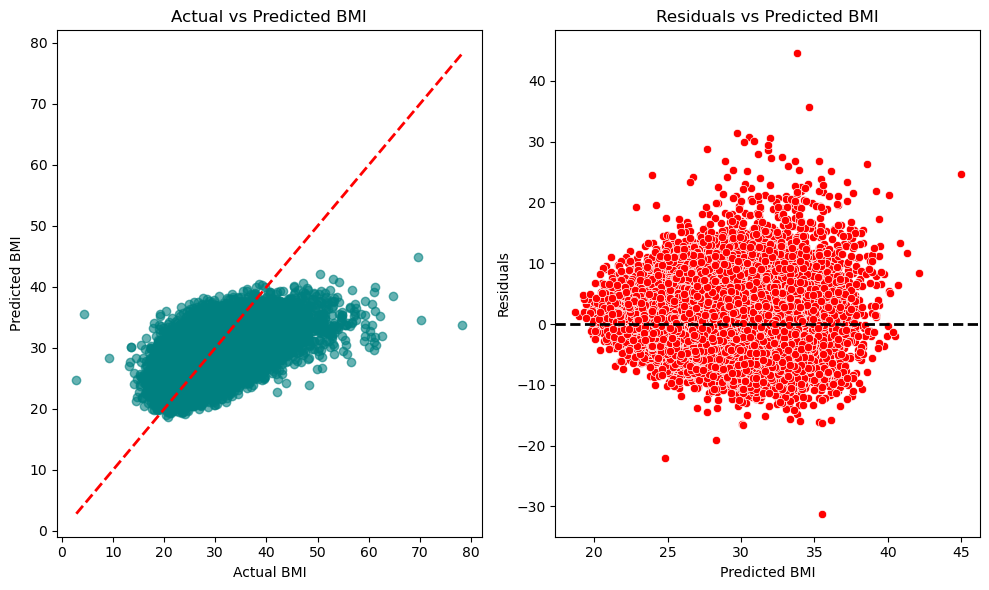

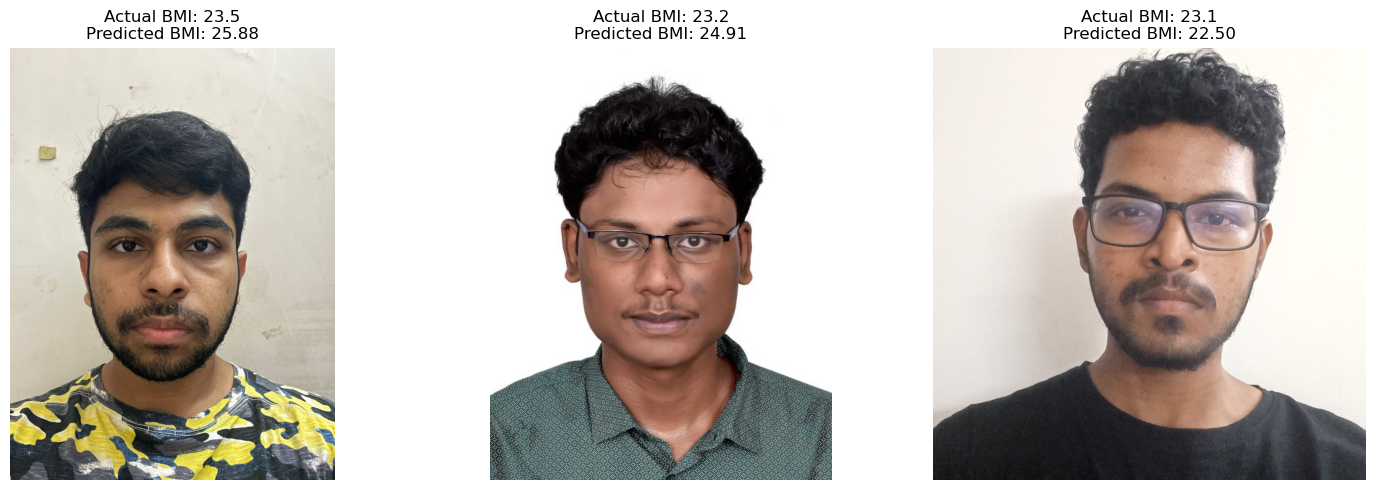

In [14]:
mse = mean_squared_error(ys, predictions)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
mae = mean_absolute_error(ys, predictions)
print("Mean Absolute Error (MAE):", mae)
r2 = r2_score(ys, predictions)
print("R^2 Score:", r2)
pearson_corr, _ = pearsonr(ys, predictions)
print("Pearson Correlation Coefficient:", pearson_corr)
diagnostics()

our_preds = lr_model.predict(our_features)
imgdisplay(our_preds)

<h2>Decision Tree Regression</h2>

In [119]:
#Decision Tree

tree_model = DecisionTreeRegressor(max_depth=10, random_state=42)
tree_model.fit(xs_train, ys_train)
predictions = tree_model.predict(xs)

Root Mean Squared Error (RMSE): 4.31561801479256
Mean Absolute Error (MAE): 3.2340569716840455
R^2 Score: 0.2918533784991194
Pearson Correlation Coefficient: 0.5491104578609672


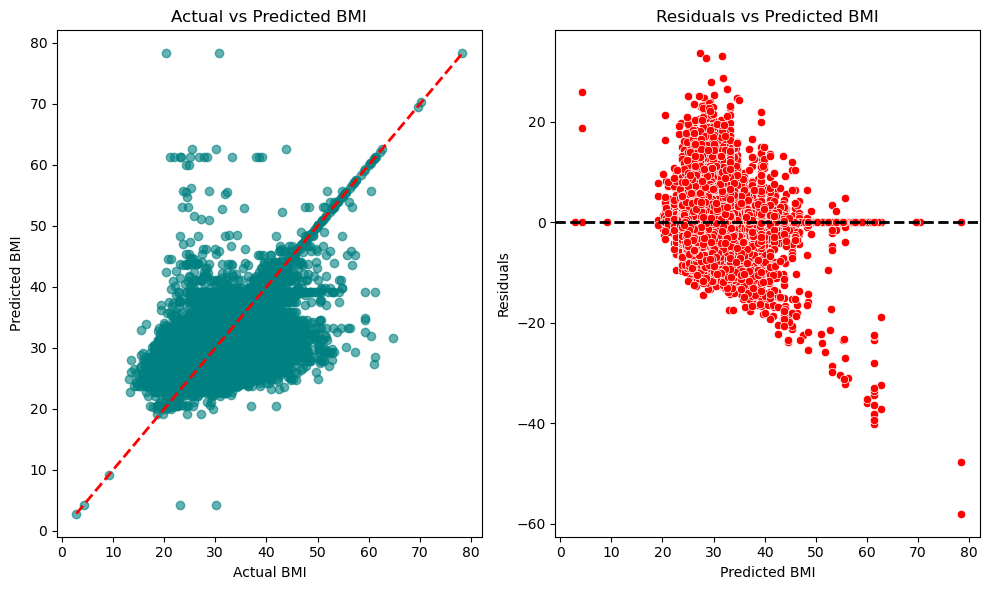

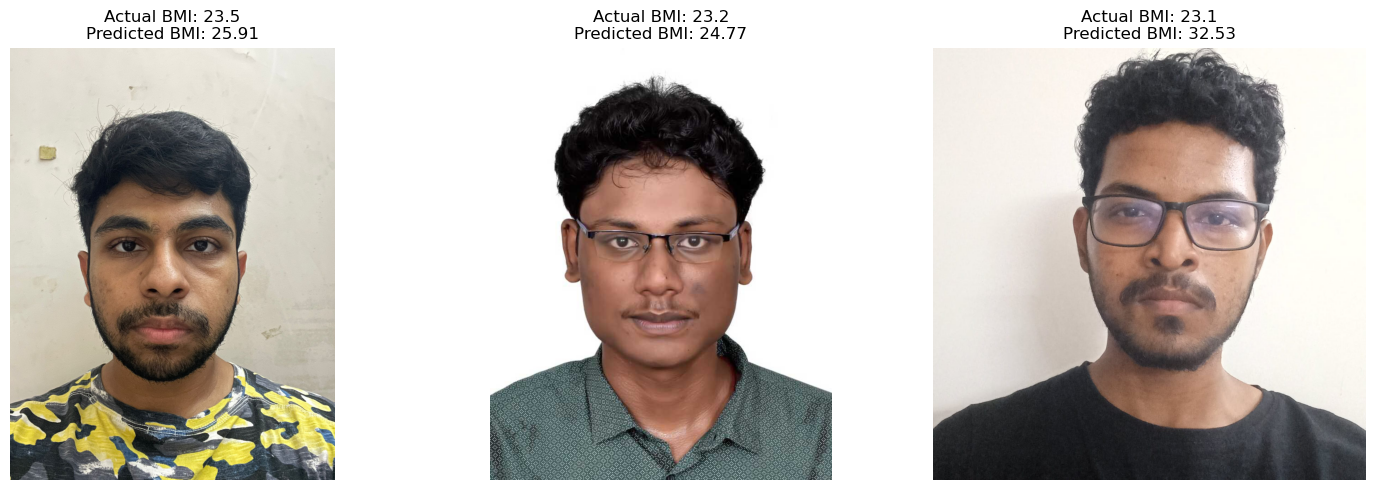

In [120]:
mse = mean_squared_error(ys, predictions)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
mae = mean_absolute_error(ys, predictions)
print("Mean Absolute Error (MAE):", mae)
r2 = r2_score(ys, predictions)
print("R^2 Score:", r2)
pearson_corr, _ = pearsonr(ys, predictions)
print("Pearson Correlation Coefficient:", pearson_corr)
diagnostics()

our_preds = tree_model.predict(our_features)
imgdisplay(our_preds)

<h2>Random Forest Regression</h2>

In [121]:
#Random Forest
rf_model = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42)
rf_model.fit(xs_train, ys_train)
predictions = rf_model.predict(xs)

Root Mean Squared Error (RMSE): 3.9533769067127613
Mean Absolute Error (MAE): 3.0569944703227208
R^2 Score: 0.40574391840248303
Pearson Correlation Coefficient: 0.6686268883433503


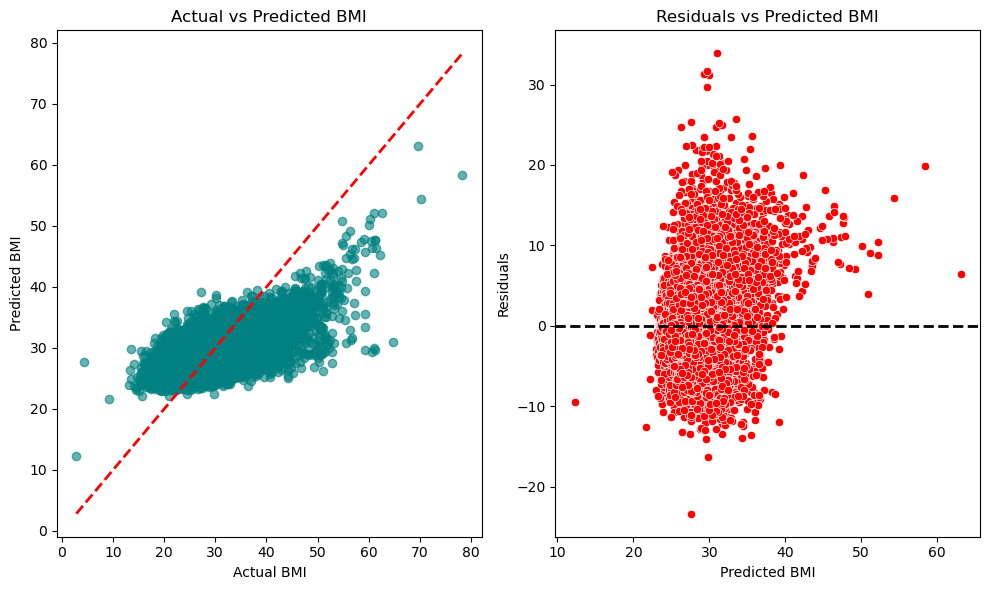

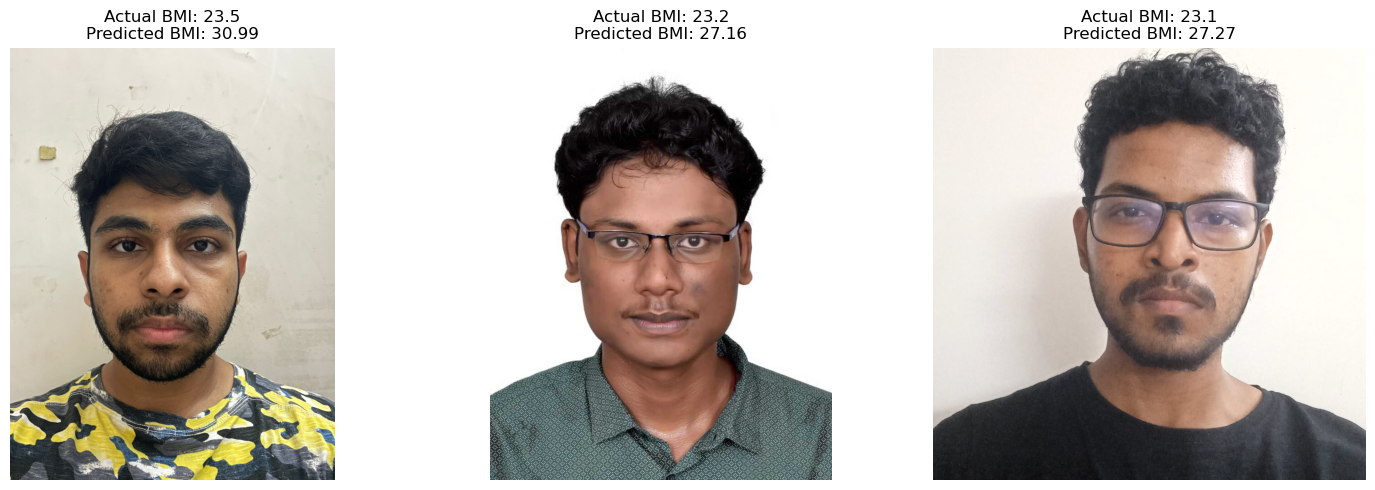

In [122]:
mse = mean_squared_error(ys, predictions)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
mae = mean_absolute_error(ys, predictions)
print("Mean Absolute Error (MAE):", mae)
r2 = r2_score(ys, predictions)
print("R^2 Score:", r2)
pearson_corr, _ = pearsonr(ys, predictions)
print("Pearson Correlation Coefficient:", pearson_corr)
diagnostics()

our_preds = rf_model.predict(our_features)
imgdisplay(our_preds)

<h2>XG Boost Regression</h2>

In [15]:
xgb_model = XGBRegressor(
    n_estimators=1000,    
    max_depth=6,         
    learning_rate=0.1,   
    subsample=0.8,      
    random_state=42
)
xgb_model.fit(xs_train, ys_train)
predictions = xgb_model.predict(xs)

Root Mean Squared Error (RMSE): 2.290183098716382
Mean Absolute Error (MAE): 1.3583405043203558
R^2 Score: 0.8005759171143986
Pearson Correlation Coefficient: 0.8988354661490192


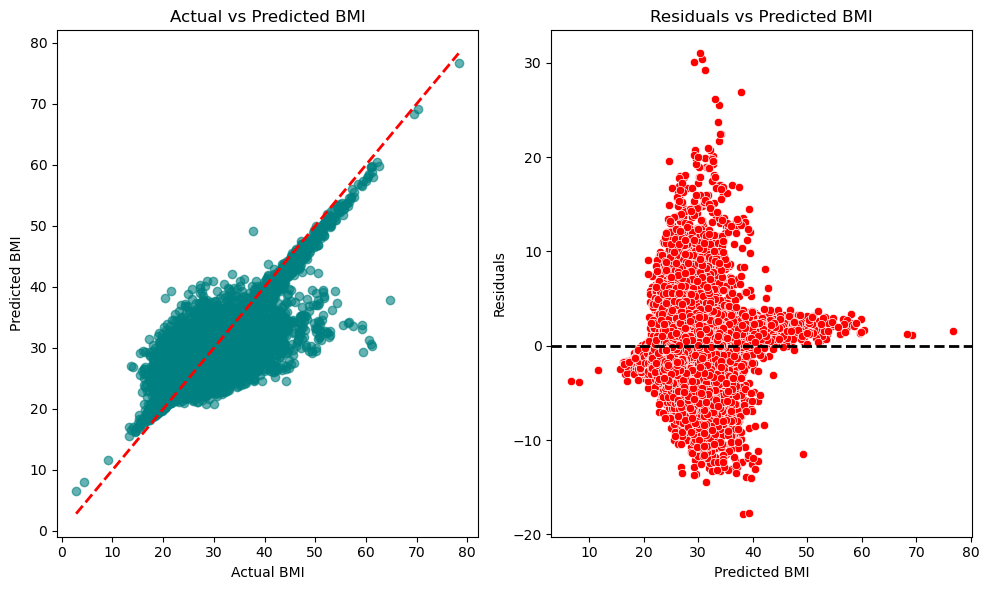

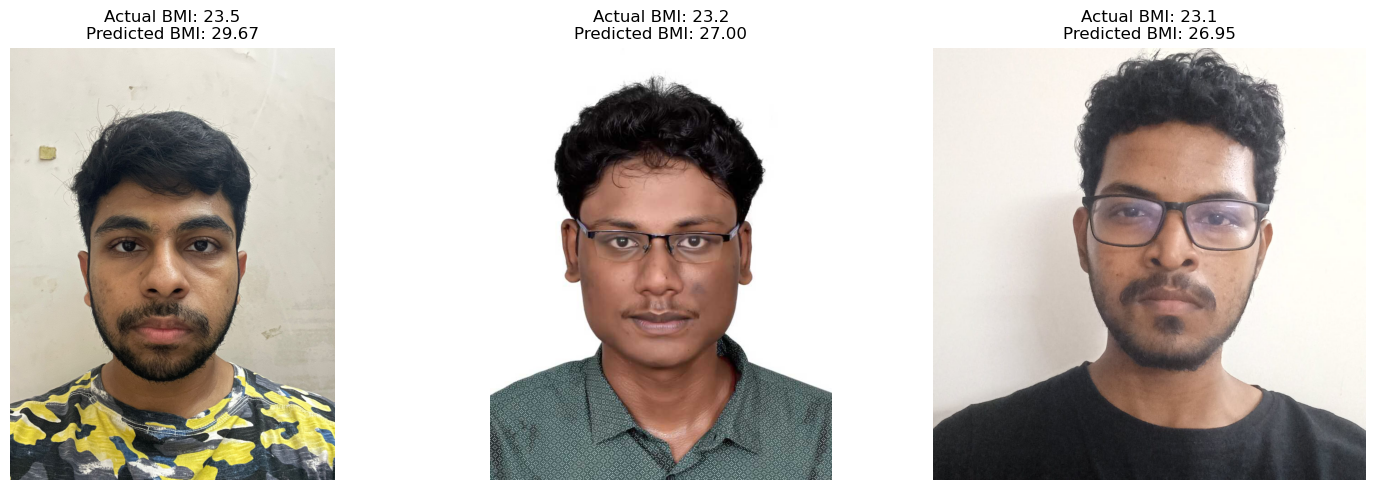

In [16]:
mse = mean_squared_error(ys, predictions)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)
mae = mean_absolute_error(ys, predictions)
print("Mean Absolute Error (MAE):", mae)
r2 = r2_score(ys, predictions)
print("R^2 Score:", r2)
pearson_corr, _ = pearsonr(ys, predictions)
print("Pearson Correlation Coefficient:", pearson_corr)
diagnostics()

our_preds = xgb_model.predict(our_features)
imgdisplay(our_preds)

<h2>Classification Into Obese, Normal or Underweight using Regression Values</h2>

In [17]:
newpersons = filtered_df.copy()
cols = [i for i in range(1, 1025)]
newpersons.drop(newpersons.columns[cols],axis=1,inplace=True)
newpersons = newpersons[['id', 'name', 'weight', 'height', 'sex']]
newpersons['calculated bmi'] = (newpersons['weight']*703)/(newpersons['height']**2)
newpersons.head()

id              name  weight  height   sex  calculated bmi
0  A00147  MCCUTCHEON, JOHN   185.0    67.0  Male       28.971931
1  A00360      BELL, HOWARD   167.0    69.0  Male       24.658895
2  A00367   GARVIN, RAYMOND   245.0    72.0  Male       33.224344
3  A01072    BRISBON, HENRY   195.0    69.0  Male       28.793321
4  A01077     JONES, ROBERT   180.0    68.0  Male       27.365917

<h3>Considering BMI>30 to be Obese and <18.5 to be Underweight</h3>

In [18]:
def getclass(x):
    if x > 30: return "Obese"
    elif x > 18.5: return "Normal"
    else: return "Underweight"
vals = np.array(features.iloc[:,1:])
predicted_vals = xgb_model.predict(vals)
newpersons = newpersons.iloc[:len(predicted_vals)]
newpersons['predicted_bmi'] = predicted_vals
newpersons['weight class'] = newpersons['predicted_bmi'].apply(getclass)
newpersons

id                 name  weight  height   sex  calculated bmi  \
0      A00147     MCCUTCHEON, JOHN   185.0    67.0  Male       28.971931   
1      A00360         BELL, HOWARD   167.0    69.0  Male       24.658895   
2      A00367      GARVIN, RAYMOND   245.0    72.0  Male       33.224344   
3      A01072       BRISBON, HENRY   195.0    69.0  Male       28.793321   
4      A01077        JONES, ROBERT   180.0    68.0  Male       27.365917   
...       ...                  ...     ...     ...   ...             ...   
49995  Y16005   ALLEN, TERRANCE T.   169.0    71.0  Male       23.568141   
49996  Y16006       EVANS, KENNETH   156.0    70.0  Male       22.381224   
49997  Y16009   PHILLIPS, NEHEMIAH   150.0    72.0  Male       20.341435   
49998  Y16011  CIESLOWSKI, PAUL T.   152.0    72.0  Male       20.612654   
49999  Y16012  ALMARAZ, ROBERTO C.   160.0    69.0  Male       23.625289   

       predicted_bmi weight class  
0          28.908102       Normal  
1          24.451565       Normal  
2          31.511412        Obese  
3          27.517553       Normal  
4          25.842659       Normal  
...              ...          ...  
49995      24.061115       Normal  
49996      27.334667       Normal  
49997      23.795485       Normal  
49998      26.680717       Normal  
49999      24.108101       Normal  

[50000 rows x 8 columns]

In [19]:
print("Total Number: ", len(newpersons))
print("Number of Normal:", len(newpersons[newpersons['weight class'] == 'Normal']))
print("Number of Underweight:", len(newpersons[newpersons['weight class'] == 'Underweight']))
print("Number of Obese:", len(newpersons[newpersons['weight class'] == 'Obese']))

Total Number:  50000
Number of Normal: 37088
Number of Underweight: 31
Number of Obese: 12881


<h2>Logistic Regression for Gender Classification</h2>

In [27]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Separate data by class
male = newpersons[newpersons['sex'] == 'Male']
female = newpersons[newpersons['sex'] == 'Female']

# Balance classes by under-sampling the majority class
if len(male) > len(female):
    male_balanced = resample(male, replace=False, n_samples=len(female), random_state=42)
    balanced_data = pd.concat([male_balanced, female])
else:
    female_balanced = resample(female, replace=False, n_samples=len(male), random_state=42)
    balanced_data = pd.concat([female_balanced, male])

# Shuffle the balanced data
balanced_data = balanced_data.sample(frac=1, random_state=42)

# Features and labels
features = balanced_data.drop(columns=['sex'])  # Assuming 'sex' is the target column
labels = balanced_data['sex']

# Train-test split
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(features_train, labels_train)

# Predictions and evaluation
labels_pred = logreg.predict(features_test)
accuracy = accuracy_score(labels_test, labels_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:\n", classification_report(labels_test, labels_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(labels_test, labels_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Female", "Male"], yticklabels=["Female", "Male"])
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


ValueError: could not convert string to float: 'R05434'

Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

      Female       0.99      0.77      0.87      2080
        Male       0.94      1.00      0.97      7920

    accuracy                           0.95     10000
   macro avg       0.97      0.88      0.92     10000
weighted avg       0.95      0.95      0.95     10000



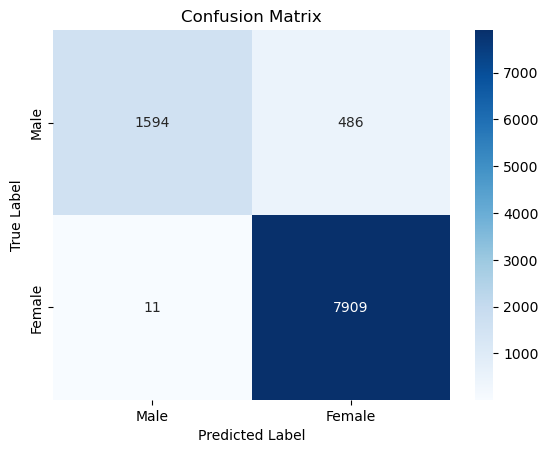

In [26]:
logreg = LogisticRegression()
yq_train = newpersons['sex'][:int(0.8*(len(newpersons)))]
yq_test = newpersons['sex'][int(0.8*(len(newpersons))):]
logreg.fit(xs_train, yq_train)

yq_pred = logreg.predict(xs_test)
accuracy = accuracy_score(yq_test, yq_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:\n", classification_report(yq_test, yq_pred))

conf_matrix = confusion_matrix(yq_test, yq_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Female", "Male"], yticklabels=["Female", "Male"])
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

<h2>Plotting of Offenses</h2>

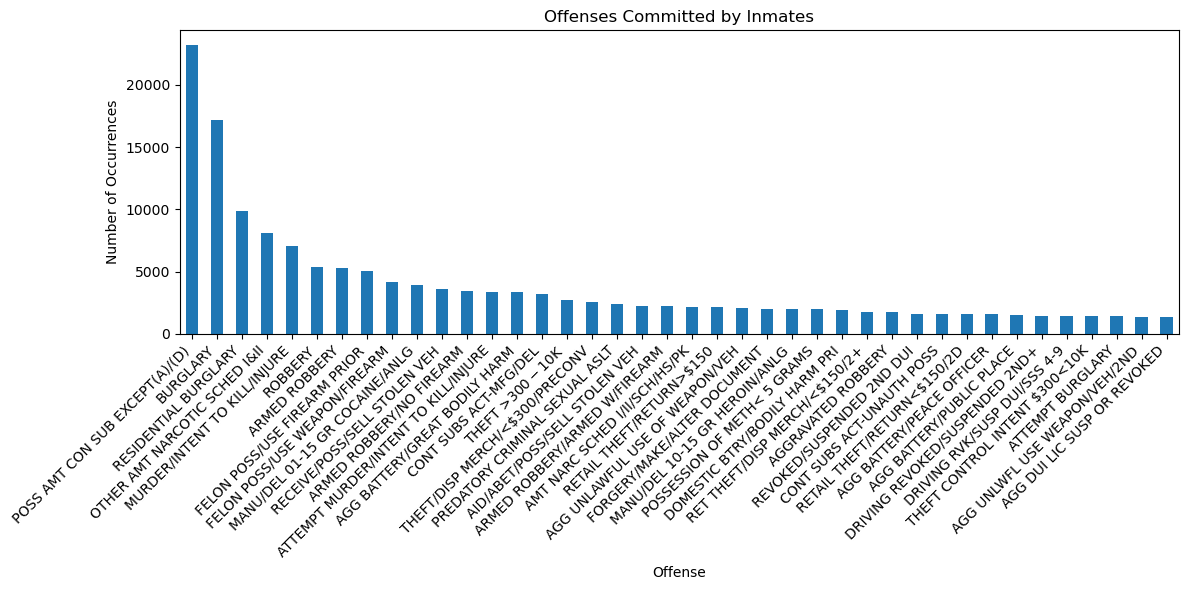

In [21]:
offenses = pd.read_csv('/media/kathir/Apps and Games/prml project/illinois_doc_dataset/sentencing.csv', sep=';')
offenses = offenses['offense'].value_counts()
top_n = 40
n_offences = offenses.head(top_n)

# Plot the distribution
plt.figure(figsize=(12, 6))
n_offences.plot(kind='bar')
plt.title('Offenses Committed by Inmates')
plt.xlabel('Offense')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()